In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import warnings
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from scipy.stats import uniform, randint
warnings.filterwarnings('ignore')

# Model and performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from joblib import dump, load
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc, average_precision_score, precision_recall_curve

# Hyperparameter tuninghCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from xgboost import plot_importance

# Data imputation
from imblearn.over_sampling import SMOTE


## Functions

#### 1) Evaluate model

In [178]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    # ROC-AUC 추가
    precision_, recall_, thr = precision_recall_curve(y_test, pred_proba)
    pr_auc = auc(recall_, precision_)
    # print('오차 행렬')
    
    # ROC-AUC print 추가
    result = '{0:.4f}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}, {5:.4f}'.format(accuracy, precision, recall, f1, roc_auc, pr_auc)

    return confusion, result 


#### 2) Plot ROC_AUC curve

In [179]:
def roc_curve_plot(y_test, opted_predict_prob,label_name):
    fpr, tpr, thresholds = roc_curve(y_test, opted_predict_prob)

    plt.plot(fpr, tpr, label = label_name)
    plt.plot([0,1], 'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title("ROC Curves")
    plt.legend(fontsize=6)

#### 3) Plot PR_AUC curve

In [180]:
def plot_pr_curve(recall, precision,label_name):
    pyplot.plot([0, 1], 'k--')
    pyplot.plot(recall, precision, label=label_name)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    plt.title("PR Curves")
    pyplot.legend(fontsize=6)

#### 4) preprocess_data

In [181]:
def preprocess_data(input, output):

    features = pd.read_excel(input)
    label = pd.read_excel(output)

    X_train, X_test, y_train, y_test = train_test_split(features, label, 
                                                    test_size=0.2, random_state=1)
  
    
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    # imputating train_data
    smote = SMOTE(random_state=0)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

#### 5) plot_curve
version 1과 version 2 중에 하나만 실행하기. 
실행 후 각 모델별 함수('## Ploting curve' 확인)에서 실행될 수 있도록 주석 확인.

In [182]:
## version 1_  input 또는 output 고정하여 비교할 경우 실행
def plot_curve(input, output, curve, y_test, opted_predict_prob):
    
    # set label
    in_ = re.sub(r'[^0-9]', '', input) 
    out_ = re.sub(r'[^0-9]', '', output)
    in_ = int(in_)
      
    # plot ROC-AUC curve
    if curve == 'roc':
        roc_auc = round(roc_auc_score(y_test, opted_predict_prob), 3)
        label = f"{in_-2}~{in_} Hours after ICU admission, {curve.upper()}_AUC: {roc_auc}"
        roc_curve_plot(y_test, opted_predict_prob, label_name = label)
        
    # plot PR-AUC curve
    elif curve == 'pr':
        precision, recall, thresholds = precision_recall_curve(y_test, opted_predict_prob)
        pr_auc = round(auc(recall, precision),3)
        label = f"{in_-2}~{in_} Hours after ICU admission, {curve.upper()}_AUC: {pr_auc}"
        plot_pr_curve(recall, precision, label_name=label)

In [183]:
## version 2_ MODEL별로 비교할 경우 실행
def plot_curve_(input, output, curve, y_test, opted_predict_prob, model_name):
    
    # set label
    in_ = re.sub(r'[^0-9]', '', input) 
    out_ = re.sub(r'[^0-9]', '', output)
      
    # plot ROC-AUC curve
    if curve == 'roc':
        roc_auc = round(roc_auc_score(y_test, opted_predict_prob), 3)
        label = f"{model_name}, {curve.upper()}_AUC: {roc_auc}"
        roc_curve_plot(y_test, opted_predict_prob, label_name = label)
        
    # plot PR-AUC curve
    elif curve == 'pr':
        precision, recall, thresholds = precision_recall_curve(y_test, opted_predict_prob)
        pr_auc = round(auc(recall, precision),3)
        label = f"{model_name}, {curve.upper()}_AUC: {pr_auc}"
        plot_pr_curve(recall, precision, label_name=label)

#### 6) train, calibrate

In [184]:
def train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output):    
    in_ = re.sub(r'[^0-9]', '', input)
    out_ = re.sub(r'[^0-9]', '', output)

    # grid search 
    if calibration == 'grid' :
        
        # Set up score'linear'
        scoring = ['roc_auc']
   
        kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

        grid_search = GridSearchCV(estimator=model, 
                           param_grid=param, 
                           scoring= scoring, 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
    
        grid_result = grid_search.fit(X_train, y_train)
    
        model = grid_search.best_estimator_

        opted_predict = grid_search.predict(X_test)
    
        # Get predicted probabilities
        opted_predict_prob = grid_search.predict_proba(X_test)[:,1]
  
    # random search
    elif calibration == 'random':

        scoring = ['roc_auc']
  
        kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

        random_search = RandomizedSearchCV(estimator=model, 
                           param_distributions=param, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
  
        random_result = random_search.fit(X_train, y_train)
    
        # 수정
        dump(random_search, f'./trained/{name}_matrix_trained_{calibration }_{in_}hr_{out_}hr.joblib') 
        print(f"save matrix: {name}_matrix_trained_{calibration }_{in_}hr_{out_}hr.joblib")

        opted_predict = random_search.predict(X_test)
  
        # Get predicted probabilities
        opted_predict_prob = random_search.predict_proba(X_test)[:,1]
    
    return opted_predict, opted_predict_prob

## Models

#### 1) Logistic Regeression

In [185]:
def LR_model(name, input, output, n_fold, calibration, curve):
    
    X_train, X_test, y_train, y_test = preprocess_data(input, output)

    
    ## model 
    model = LogisticRegression(random_state=1, max_iter=2000)

    ## optimizing hyper-param for model 
    if calibration == 'grid' :
        param = {'C':[0.001,0.01,0.1,1,10], 
                 'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
                 'penalty':['l1', 'l2']  
                  }
    elif calibration == 'random':
        
        param = {
        'C':[0.001,0.01,0.1,1,10],
        'penalty': ['l1','l2'],
        'solver': ['newton-cg','lbfgs','liblinear','sag','saga']
                  }
        
    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'Logistic Regression')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 2) Decision Tree

In [186]:
def DT_model(name, input, output, n_fold, calibration, curve):
    
    X_train, X_test, y_train, y_test = preprocess_data(input, output)
    
    ## model 
    model = DecisionTreeClassifier(random_state=1)

    ## optimizing hyper-param for model
     
    if calibration == 'grid' :
        param = {'min_impurity_decrease': [0.001, 0.01, 0.1],
              'max_depth': range(5, 20, 1),
              'min_samples_split': range(2, 100, 10)
        }
    elif calibration == 'random':
  
        param = {
         'min_impurity_decrease': [0.001, 0.01, 0.1],
            'max_depth': range(5, 20, 1),
            'min_samples_split': range(2, 100, 10)
        }

    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'Decision Tree')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 3) Random Forest

In [187]:
def RF_model(name, input, output, n_fold, calibration, curve):
    
    X_train, X_test, y_train, y_test = preprocess_data(input, output)
    
    ## model 
    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    ## optimizing hyper-param for model
    if calibration == 'grid' :
    
        param = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
        
    elif calibration == 'random':
  
        param = {'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
        }

    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'Random Forest')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 4) KNN

In [188]:
def KNN_model(name, input, output, n_fold, calibration, curve):
    
    X_train, X_test, y_train, y_test = preprocess_data(input, output)
    
    ## model 
    model = KNeighborsClassifier(n_neighbors=5)

    ## optimizing hyper-param for model 
    if calibration == 'grid' :
        param = {
            'n_neighbors' : list(range(1,30)),
            'weights' : ["uniform", "distance"],
            'metric' : ['euclidean', 'manhattan', 'minkowski'],
            'leaf_size' : range(1, 50, 5)
        }
        
    elif calibration == 'random':
  
        param = {
            'n_neighbors' : list(range(1,30)),
            'weights' : ["uniform", "distance"],
            'metric' : ['euclidean', 'manhattan', 'minkowski'],
            'leaf_size' : range(1, 50, 5)
        }

    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'K-Nearest Neighbor')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 5) XGBoost

In [189]:
def XGB_model(name, input, output, n_fold, calibration, curve):
    
    X_train, X_test, y_train, y_test = preprocess_data(input, output)
    
    ## model 
    model = XGBClassifier(booster='gbtree', objective='binary:logistic')

    ## optimizing hyper-param for model
    if calibration == 'grid' :
        param = { 
            'n_estimators': [100,200,400,800,1000],
            'learning_rate': [0.01,0.05,0.1,0.2,0.3,0.4,0.5],
            'gamma': [0,0.01,0.1,0.5,1,2],
            'min_child_weight':[1,2,3,4,5]
        }
    # random search
    elif calibration == 'random':
  
        param = { 
            'n_estimators': [100,200,400,800,1000],
            'learning_rate': [0.01,0.05,0.1,0.2,0.3,0.4,0.5],
            'gamma': [0,0.01,0.1,0.5,1,2],
            'min_child_weight':[1,2,3,4,5]
        }

    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'XGBoost')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 6) ANN

In [201]:
def ANN_model(input, output, n_fold, calibration, curve):
    
    ## processing data for training/test
    features = pd.read_excel(input)
    label = pd.read_excel(output)
    
    len_features = int(features.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)
    
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    smote = SMOTE(random_state=0)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    
    ## model 
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(len_features,)))
    
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model = KerasClassifier(model)

    ## optimizing hyper-param for model
    
    # grid search 
    if calibration == 'grid' :
        param = {
        'batch_size': [16, 32, 64, 128],
        'epochs': [10, 20]
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param, scoring='accuracy', cv=3)

        grid_result = grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        opted_predict = best_model.predict(X_test)
        
        opted_predict_prob = grid_search.predict_proba(X_test)[:,1]
    
        
  
    # random search
    elif calibration == 'random':
        param = {
            'batch_size': [16, 32, 64, 128],
            'epochs': [10, 20]
        }
        
         # Set up score
        scoring = ['accuracy']
   
        kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)


        random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param, 
                                   scoring=scoring, 
                                   cv=kfold,
                                   refit='accuracy', 
                                   n_jobs=-1, 
                                   verbose=0)

        random_result = random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        opted_predict = best_model.predict(X_test)
        
        opted_predict_prob = random_search.predict_proba(X_test)[:,1]
    
    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'Artifical Neural Network')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)

    return temp_comfusion, temp_result


#### 7) SVM

In [191]:
def SVM_model(name, input, output, n_fold, calibration, curve):
    
    ## processing data for training/test
    X_train, X_test, y_train, y_test = preprocess_data(input, output)

    
    ## model 
    model = SVC(random_state=0, probability=True)

    ## optimizing hyper-param for model
    
    # grid search 
    if calibration == 'grid' :
        param = {'C': [0.1,1, 10, 100], 
         'kernel': ['poly','sigmoid','linear','rbf'],
         'gamma': [1,0.1,0.01,0.001]}

    # random search
    elif calibration == 'random':
  
        param = {'C': [0.1,1, 10, 100], 
         'kernel': ['poly','sigmoid','linear','rbf'],
         'gamma': [1,0.1,0.01,0.001]}
    
    opted_predict, opted_predict_prob = train_and_calibrate_model(name, model, calibration, param, X_train, y_train, X_test, y_test, input, output)

    ## Ploting curve
    plot_curve(input, output, curve, y_test, opted_predict_prob)
#     plot_curve_(input, output, curve, y_test, opted_predict_prob, 'Support Vector Machine')
    
    ## Get performance metrics
    temp_comfusion, temp_result = get_clf_eval(y_test , opted_predict, opted_predict_prob)


    return temp_comfusion, temp_result

## Execute model

아래 세 함수 중 하나만 실행하기.

#### 1) input 고정

In [37]:
def execute(dir_input, dir_output, n_fold, imputation, calibration, curve, name):    
    i = 0
    total = len(dir_input)*len(dir_output)
    df_result = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"])
    
    models = {'LR': LR_model,
                      'DT': DT_model,
                      'RF': RF_model,
                      'XGB': XGB_model,
                      'KNN': KNN_model,
                      'ANN': ANN_model,
                      'SVM': SVM_model
             }
    
    model = models[name]
    
    for input in dir_input:
        in_ = re.sub(r'[^0-9]', '', input)
        idx = {'Accuracy': f'{in_}hr'}
        df_result = df_result.append(idx, ignore_index=True)
  
        for output in dir_output:
            print(f"{i/total*100}% processing..")
        
            ## Run
            confusion, result = model(name, input, output, n_fold, calibration, curve)
        
            ## post-process results from model
            dic = {}
            temp = result.split(', ')

            index = 0
            for key in df_result.keys():
                dic[key] = temp[index]
                index += 1

            df_result = df_result.append(dic, ignore_index=True)
            plt.savefig(f'./result_graph/{name}_{imputation}_{curve}_curve_{out_}hr.png', dpi=300)
            i = i + 1
        
        plt.cla()

    # export    
    df_result.to_csv(f'./result_csv/result_{name}_{calibration}_{imputation}_prolonged.csv')

#### 2) output 고정

In [202]:
def execute(dir_input, dir_output, n_fold, imputation, calibration, curve, name):    
    i = 0
    total = len(dir_input)*len(dir_output)
    df_result = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"])
    
    models = {'LR': LR_model,
                      'DT': DT_model,
                      'RF': RF_model,
                      'XGB': XGB_model,
                      'KNN': KNN_model,
                      'ANN': ANN_model,
                      'SVM': SVM_model
             }
    
    model = models[name]
    
    for output in dir_output:
        out_ = re.sub(r'[^0-9]', '', output)
        idx = {'Accuracy': f'{out_}hr'}
        df_result = df_result.append(idx, ignore_index=True)
    
        for input in dir_input:
            
            in_ = re.sub(r'[^0-9]', '', input)
            print(f"{i/total*100}% processing..")
        
            ## Run
            confusion, result = model(name, input, output, n_fold, calibration, curve)
        
            ## post-process results from model
            dic = {}
            temp = result.split(', ')

            index = 0
            for key in df_result.keys():
                dic[key] = temp[index]
                index += 1

            df_result = df_result.append(dic, ignore_index=True)
            plt.savefig(f'./result_graph/{name}_{imputation}_{curve}_curve_{out_}hr.png', dpi=300)
            i = i + 1
        
        plt.cla()
        
        # export    
        df_result.to_csv(f'./result_csv/result_{name}_{calibration}_{imputation}_prolonged.csv')


#### 3) input, output 고정. 모델별 그래프.

In [170]:
def execute(input_path, output_path, n_fold, imputation, calibration, curve, list_models):    
     
    models = {'LR': LR_model,
                      'DT': DT_model,
                      'RF': RF_model,
                      'KNN': KNN_model,
                      'XGB': XGB_model,
                      'SVM': SVM_model
             }
    
    
    in_ = re.sub(r'[^0-9]', '', input_path)
    out_ = re.sub(r'[^0-9]', '', output_path)
    
    ANN_model(input_path, output_path, 'random', curve)
        
    plt.savefig(f'./result_graph/ALL_{imputation}_{curve}_curve_{in_}hr.png', dpi=300)
    
    total = len(list_models)
    i = 0
    
    for name in list_models:
        if name == 'ANN':
            break
        
        model = models[name]
        
        print(f"{i/total*100}% processing..")
        
        ## Run
        confusion, result = model(name, input_path, output_path, n_fold, calibration, curve)
    
        plt.savefig(f'./result_graph/ALL_{imputation}_{curve}_curve_{in_}hr_{out_}hr.png', dpi=300)
        
        i = i + 1
        
        


#### 4) configure

In [203]:
#### configure

dir_input = [
    './df_input/df_2hr.xlsx',
    './df_input/df_4hr.xlsx',
    './df_input/df_6hr.xlsx',
    './df_input/df_8hr.xlsx',
    './df_input/df_10hr.xlsx',
    './df_input/df_12hr.xlsx'
]

dir_output = [
      './df_output/df_categorical_output_hr/df_categorical_output_24hr.xlsx',
     './df_output/df_categorical_output_hr/df_categorical_output_36hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_48hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_60hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_72hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_120hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_168hr.xlsx',
    './df_output/df_categorical_output_hr/df_categorical_output_336hr.xlsx'
 ]  

n_fold = 5
imputation = 'smote'
calibration = 'random'
curves = ['roc'] # roc: ROC_AUC/ pr: PR_AUC

INFO:tensorflow:Assets written to: ram://9cb5c1834e0f43d59cac2c3cc5b9d576/assets


INFO:tensorflow:Assets written to: ram://9cb5c1834e0f43d59cac2c3cc5b9d576/assets
2023-11-01 18:08:29.708753: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b7a255ee45984f3a864afa8b67c9d6a8: INVALID_ARGUMENT: ram://b7a255ee45984f3a864afa8b67c9d6a8 is a directory.


INFO:tensorflow:Assets written to: ram://ba65e18df2a3445082a3aaa367fea87f/assets


INFO:tensorflow:Assets written to: ram://ba65e18df2a3445082a3aaa367fea87f/assets
2023-11-01 18:08:29.946289: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9729a249e7394a3faae31ef2ab0fb7e0: INVALID_ARGUMENT: ram://9729a249e7394a3faae31ef2ab0fb7e0 is a directory.


INFO:tensorflow:Assets written to: ram://08f59695f200471a8ad25f6aa209989a/assets


INFO:tensorflow:Assets written to: ram://08f59695f200471a8ad25f6aa209989a/assets
2023-11-01 18:08:30.183001: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c3d5bdbee37148a887072879a6c50320: INVALID_ARGUMENT: ram://c3d5bdbee37148a887072879a6c50320 is a directory.


INFO:tensorflow:Assets written to: ram://8cf5ebcbed3f4c2f877c95fe1eb5a024/assets


INFO:tensorflow:Assets written to: ram://8cf5ebcbed3f4c2f877c95fe1eb5a024/assets
2023-11-01 18:08:30.412868: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c41c7027395f4389b9658a021b3650a7: INVALID_ARGUMENT: ram://c41c7027395f4389b9658a021b3650a7 is a directory.


INFO:tensorflow:Assets written to: ram://decfb84fc5d245b8bbc9921f11d14094/assets


INFO:tensorflow:Assets written to: ram://decfb84fc5d245b8bbc9921f11d14094/assets
2023-11-01 18:08:30.644404: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d77a9c27277e455c82995eb5fc1a6ed0: INVALID_ARGUMENT: ram://d77a9c27277e455c82995eb5fc1a6ed0 is a directory.


INFO:tensorflow:Assets written to: ram://710f74b6258e421fb36245e2a9b3de73/assets


INFO:tensorflow:Assets written to: ram://710f74b6258e421fb36245e2a9b3de73/assets
2023-11-01 18:08:30.880314: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c451398e21df43638cc2ede7c63e75f9: INVALID_ARGUMENT: ram://c451398e21df43638cc2ede7c63e75f9 is a directory.


INFO:tensorflow:Assets written to: ram://6ebff3685aae45d5870a1348aa7ae571/assets


INFO:tensorflow:Assets written to: ram://6ebff3685aae45d5870a1348aa7ae571/assets
2023-11-01 18:08:31.115620: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2330039e7f4646f2a444d2c9f8f7ccb0: INVALID_ARGUMENT: ram://2330039e7f4646f2a444d2c9f8f7ccb0 is a directory.


INFO:tensorflow:Assets written to: ram://b37096d02850466bb6678e43f039d9bf/assets


INFO:tensorflow:Assets written to: ram://b37096d02850466bb6678e43f039d9bf/assets
2023-11-01 18:08:31.345155: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6a2891fda58e4914ab4f81008827a2ba: INVALID_ARGUMENT: ram://6a2891fda58e4914ab4f81008827a2ba is a directory.


INFO:tensorflow:Assets written to: ram://bf216ffce4bf449fb0c7bb65f8c3f085/assets


INFO:tensorflow:Assets written to: ram://bf216ffce4bf449fb0c7bb65f8c3f085/assets


INFO:tensorflow:Assets written to: ram://0bcadaf73ce14e66adce076fc655dc91/assets


2023-11-01 18:08:31.733968: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://91010d13af2d497f9e2acddbf0baca0e: INVALID_ARGUMENT: ram://91010d13af2d497f9e2acddbf0baca0e is a directory.
INFO:tensorflow:Assets written to: ram://0bcadaf73ce14e66adce076fc655dc91/assets


INFO:tensorflow:Assets written to: ram://ac8d99666b20457a986dee495fd243c2/assets


2023-11-01 18:08:31.967582: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d2fb1c71e6c64b3e941c296193ced4fe: INVALID_ARGUMENT: ram://d2fb1c71e6c64b3e941c296193ced4fe is a directory.
INFO:tensorflow:Assets written to: ram://ac8d99666b20457a986dee495fd243c2/assets


INFO:tensorflow:Assets written to: ram://64acb20691404e7a918ce169b2ed70f3/assets


2023-11-01 18:08:32.198708: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9f32ee3e7ff34ec0afe03ddf19a9704c: INVALID_ARGUMENT: ram://9f32ee3e7ff34ec0afe03ddf19a9704c is a directory.
INFO:tensorflow:Assets written to: ram://64acb20691404e7a918ce169b2ed70f3/assets


INFO:tensorflow:Assets written to: ram://d3187b56e5c64400b1c021685e500b19/assets


2023-11-01 18:08:32.430636: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e2559e8fad304ce19502389a2175a18b: INVALID_ARGUMENT: ram://e2559e8fad304ce19502389a2175a18b is a directory.
INFO:tensorflow:Assets written to: ram://d3187b56e5c64400b1c021685e500b19/assets


INFO:tensorflow:Assets written to: ram://042b5ea95eee4a07832bc631525afa52/assets


2023-11-01 18:08:32.661448: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bcc2f0e1aee648efa5f79e547ed0db78: INVALID_ARGUMENT: ram://bcc2f0e1aee648efa5f79e547ed0db78 is a directory.
INFO:tensorflow:Assets written to: ram://042b5ea95eee4a07832bc631525afa52/assets


INFO:tensorflow:Assets written to: ram://0f0c00be47f14304b33c3c2d85961956/assets


2023-11-01 18:08:32.891611: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d27b628a65b5483ba9131bccc7388d44: INVALID_ARGUMENT: ram://d27b628a65b5483ba9131bccc7388d44 is a directory.
INFO:tensorflow:Assets written to: ram://0f0c00be47f14304b33c3c2d85961956/assets


INFO:tensorflow:Assets written to: ram://977613bd39814322a05c11ec8f4552c8/assets


2023-11-01 18:08:33.120581: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6dbd156dfc124efd889c4d9146b0083b: INVALID_ARGUMENT: ram://6dbd156dfc124efd889c4d9146b0083b is a directory.
INFO:tensorflow:Assets written to: ram://977613bd39814322a05c11ec8f4552c8/assets


INFO:tensorflow:Assets written to: ram://f033ed50dcd74b669ee00b887e817a7f/assets


2023-11-01 18:08:33.348419: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://71bb9d942f5449288283142e6b9e378d: INVALID_ARGUMENT: ram://71bb9d942f5449288283142e6b9e378d is a directory.
INFO:tensorflow:Assets written to: ram://f033ed50dcd74b669ee00b887e817a7f/assets
2023-11-01 18:08:33.577952: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4f8fe8be8bfb46198248b1c9514fcdfa: INVALID_ARGUMENT: ram://4f8fe8be8bfb46198248b1c9514fcdfa is a directory.


INFO:tensorflow:Assets written to: ram://61a9fe9a2cea4620842a44aa129503af/assets


INFO:tensorflow:Assets written to: ram://61a9fe9a2cea4620842a44aa129503af/assets


INFO:tensorflow:Assets written to: ram://0a86da5a86354350a3d2b0abbb0ea7c2/assets


INFO:tensorflow:Assets written to: ram://0a86da5a86354350a3d2b0abbb0ea7c2/assets
2023-11-01 18:08:34.355836: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4e92a9eedd7e48d3b69bc51a2bca1c31: INVALID_ARGUMENT: ram://4e92a9eedd7e48d3b69bc51a2bca1c31 is a directory.


INFO:tensorflow:Assets written to: ram://ce443ff2e2574c23833e7c388be52fab/assets


INFO:tensorflow:Assets written to: ram://ce443ff2e2574c23833e7c388be52fab/assets
2023-11-01 18:08:34.613065: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4e7692be8f1e426faa61067ba98e8eed: INVALID_ARGUMENT: ram://4e7692be8f1e426faa61067ba98e8eed is a directory.


INFO:tensorflow:Assets written to: ram://3b269717ff324658915d4479630c95f6/assets


INFO:tensorflow:Assets written to: ram://3b269717ff324658915d4479630c95f6/assets
2023-11-01 18:08:34.860246: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ee006105db4d417c9a283ee35f34748d: INVALID_ARGUMENT: ram://ee006105db4d417c9a283ee35f34748d is a directory.


INFO:tensorflow:Assets written to: ram://3e6e763dead24498a238b5d15ea9ba6f/assets


INFO:tensorflow:Assets written to: ram://3e6e763dead24498a238b5d15ea9ba6f/assets
2023-11-01 18:08:35.118178: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://136229e2cd484aa6be0a1d125a8fcd28: INVALID_ARGUMENT: ram://136229e2cd484aa6be0a1d125a8fcd28 is a directory.


INFO:tensorflow:Assets written to: ram://494d29fc9af14b85950ab2a0ca2d52d6/assets


INFO:tensorflow:Assets written to: ram://494d29fc9af14b85950ab2a0ca2d52d6/assets


INFO:tensorflow:Assets written to: ram://33faa787640b481691ac9b6527b24b99/assets


INFO:tensorflow:Assets written to: ram://33faa787640b481691ac9b6527b24b99/assets


INFO:tensorflow:Assets written to: ram://fa4da1b9dedb48cf9cdb149271f111d6/assets


INFO:tensorflow:Assets written to: ram://fa4da1b9dedb48cf9cdb149271f111d6/assets


INFO:tensorflow:Assets written to: ram://a72061b42da54e15a1d6cd0e424d2cad/assets


INFO:tensorflow:Assets written to: ram://a72061b42da54e15a1d6cd0e424d2cad/assets


INFO:tensorflow:Assets written to: ram://96b2613bf75e4938ab77944780030092/assets


INFO:tensorflow:Assets written to: ram://96b2613bf75e4938ab77944780030092/assets


INFO:tensorflow:Assets written to: ram://e1e176fc3ae443e3a6e53ffb707f72dd/assets


INFO:tensorflow:Assets written to: ram://e1e176fc3ae443e3a6e53ffb707f72dd/assets


INFO:tensorflow:Assets written to: ram://17e1f320820a4a758fb747d66558f178/assets


INFO:tensorflow:Assets written to: ram://17e1f320820a4a758fb747d66558f178/assets


INFO:tensorflow:Assets written to: ram://2f3bc186ca974957ad4335a08b16faf7/assets


INFO:tensorflow:Assets written to: ram://2f3bc186ca974957ad4335a08b16faf7/assets


INFO:tensorflow:Assets written to: ram://86780dc6f16b4481ba8d860cf121b836/assets


INFO:tensorflow:Assets written to: ram://86780dc6f16b4481ba8d860cf121b836/assets


INFO:tensorflow:Assets written to: ram://94aa9bc99c1343afbd57a96dc154528a/assets


INFO:tensorflow:Assets written to: ram://94aa9bc99c1343afbd57a96dc154528a/assets


INFO:tensorflow:Assets written to: ram://7ebd4c826a9344d8b20fe72435a0e986/assets


INFO:tensorflow:Assets written to: ram://7ebd4c826a9344d8b20fe72435a0e986/assets


INFO:tensorflow:Assets written to: ram://73024281ab50460ba7dea070be21de6e/assets


INFO:tensorflow:Assets written to: ram://73024281ab50460ba7dea070be21de6e/assets


INFO:tensorflow:Assets written to: ram://a1b0372ab86c441998d79e780458fcdd/assets


INFO:tensorflow:Assets written to: ram://a1b0372ab86c441998d79e780458fcdd/assets
2023-11-01 18:08:38.495594: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7665681cda13480e83f22bd43405b270: INVALID_ARGUMENT: ram://7665681cda13480e83f22bd43405b270 is a directory.
2023-11-01 18:08:38.502536: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3c6a239710e844acb417f7beb2cebbca: INVALID_ARGUMENT: ram://3c6a239710e844acb417f7beb2cebbca is a directory.


Epoch 1/20
Epoch 1/10
INFO:tensorflow:Assets written to: ram://96a0e113f40a40479e84d57f45fa502e/assets


2023-11-01 18:08:38.538780: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af9f7bd53564437e87af18f990a80d26: INVALID_ARGUMENT: ram://af9f7bd53564437e87af18f990a80d26 is a directory.
2023-11-01 18:08:38.542953: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://65825e5d54a94a7dabf59972bded105e: INVALID_ARGUMENT: ram://65825e5d54a94a7dabf59972bded105e is a directory.
2023-11-01 18:08:38.546978: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e19efd2690c14bb38a597d8467934736: INVALID_ARGUMENT: ram://e19efd2690c14bb38a597d8467934736 is a directory.
2023-11-01 18:08:38.549413: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c3411c3077d4fb0ac241e3677a5c019: INVALID_ARGUMENT: ram://9c3411c3077d4fb0ac241e3677a5c019 is a directory.
INFO:tensorflow:Assets written to: ram://96a0e113f40a40479e84d57f45fa502e/assets


Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
 74/533 [===>..........................] - ETA: 0s - loss: 1.5219 - accuracy: 0.7584INFO:tensorflow:Assets written to: ram://73b75c3c031345058290d713ad1cc141/assets


2023-11-01 18:08:38.855710: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e4fe7dff067a4ce580405a808c3d8e17: INVALID_ARGUMENT: ram://e4fe7dff067a4ce580405a808c3d8e17 is a directory.
INFO:tensorflow:Assets written to: ram://73b75c3c031345058290d713ad1cc141/assets


433/533 [=======================>......] - ETA: 0s - loss: 0.8251 - accuracy: 0.5938INFO:tensorflow:Assets written to: ram://f6c24f1f588440e6b14e7bec2ccd1424/assets


2023-11-01 18:08:39.535117: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://69fbfdcc51e84150953aab9fdc7d7c16: INVALID_ARGUMENT: ram://69fbfdcc51e84150953aab9fdc7d7c16 is a directory.
INFO:tensorflow:Assets written to: ram://f6c24f1f588440e6b14e7bec2ccd1424/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.7783 - accuracy: 0.5639
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.7790 - accuracy: 0.5810
Epoch 2/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7764 - accuracy: 0.5855
Epoch 2/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7761 - accuracy: 0.5659
Epoch 2/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7747 - accuracy: 0.5764
Epoch 2/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7768 - accuracy: 0.5573
Epoch 2/20
342/533 [==================>...........] - ETA: 0s - loss: 0.5587 - accuracy: 0.5287

2023-11-01 18:08:40.151941: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8438afcaaa4c4542861c23de4a10149f: INVALID_ARGUMENT: ram://8438afcaaa4c4542861c23de4a10149f is a directory.
2023-11-01 18:08:40.223769: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://12de59681e37464e98539959c07bdbf7: INVALID_ARGUMENT: ram://12de59681e37464e98539959c07bdbf7 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5529 - accuracy: 0.5273
Epoch 3/10
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5568 - accuracy: 0.5313
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5568 - accuracy: 0.5275
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5548 - accuracy: 0.5292
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5542 - accuracy: 0.5261
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7719 - accuracy: 0.5678
Epoch 2/20
 29/533 [>.............................] - ETA: 0s - loss: 0.5716 - accuracy: 0.5496

2023-11-01 18:08:40.824114: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c67f4d0331f44f41810c0b83c098500b: INVALID_ARGUMENT: ram://c67f4d0331f44f41810c0b83c098500b is a directory.


156/533 [=======>......................] - ETA: 0s - loss: 0.5673 - accuracy: 0.5697

2023-11-01 18:08:41.061343: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a6063a9d3bd0459590f75241ff77f287: INVALID_ARGUMENT: ram://a6063a9d3bd0459590f75241ff77f287 is a directory.


Epoch 1/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5574 - accuracy: 0.5305
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 0.7719 - accuracy: 0.5690
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5277 - accuracy: 0.5355
Epoch 4/10
533/533 [==============================] - 1s 2ms/step - loss: 0.7783 - accuracy: 0.5773
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5246 - accuracy: 0.5359
Epoch 4/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5285 - accuracy: 0.5340
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5284 - accuracy: 0.5344
Epoch 4/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.5296
Epoch 3/20
267/267 [==============================] - 1s 2ms/step - loss: 0.9400 - accuracy: 0.6158
Epoch 2/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9428 - accuracy: 0.6334


2023-11-01 18:08:41.836424: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://89d7292dd3e54a95948e881bbe50761d: INVALID_ARGUMENT: ram://89d7292dd3e54a95948e881bbe50761d is a directory.
2023-11-01 18:08:41.851240: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://10cb4bf21ee54ce2b3f8762c6649b1d5: INVALID_ARGUMENT: ram://10cb4bf21ee54ce2b3f8762c6649b1d5 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.5317
Epoch 4/20
382/533 [====================>.........] - ETA: 0s - loss: 0.5121 - accuracy: 0.5406

2023-11-01 18:08:42.098013: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3dddfddc39b04832954c7119ea4f15f4: INVALID_ARGUMENT: ram://3dddfddc39b04832954c7119ea4f15f4 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5534 - accuracy: 0.5332
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5549 - accuracy: 0.5305
Epoch 3/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.5207
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.5387
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.5323
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5868 - accuracy: 0.5212
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5134 - accuracy: 0.5371
Epoch 5/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5101 - accuracy: 0.5379
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9398 - accuracy: 0.6249
Epoch 2/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9404 - accuracy: 0.6270
Epoch 2/10


2023-11-01 18:08:42.950128: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bfe70bc384c245ada31073028f5dff6a: INVALID_ARGUMENT: ram://bfe70bc384c245ada31073028f5dff6a is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5256 - accuracy: 0.5381
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5136 - accuracy: 0.5393
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4985 - accuracy: 0.5383
Epoch 6/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5025 - accuracy: 0.5378
Epoch 6/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5845 - accuracy: 0.5257
Epoch 3/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5854 - accuracy: 0.5189
Epoch 3/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.5298
Epoch 5/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5045 - accuracy: 0.5375
Epoch 6/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5027 - accuracy: 0.5398
Epoch 6/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.5288
Epoch 5/10


267/267 [==============================] - 0s 2ms/step - loss: 0.4948 - accuracy: 0.5444
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5203 - accuracy: 0.5329
Epoch 6/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4949 - accuracy: 0.5407
Epoch 7/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4944 - accuracy: 0.5408
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.5432
Epoch 10/20
267/267 [==============================] - 1s 2ms/step - loss: 0.4905 - accuracy: 0.5366
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.4787 - accuracy: 0.5406
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4859 - accuracy: 0.5411
Epoch 9/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4892 - accuracy: 0.5431
Epoch 8/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4897 - accuracy: 0.5433
Epoch 

2023-11-01 18:08:47.152174: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b10753d9f8c44decbb7d791b29b7f968: INVALID_ARGUMENT: ram://b10753d9f8c44decbb7d791b29b7f968 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.5426
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.4818 - accuracy: 0.5421
Epoch 9/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4805 - accuracy: 0.5389
Epoch 11/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4867 - accuracy: 0.5420
Epoch 10/10
267/267 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.5393
Epoch 9/20
105/533 [====>.........................] - ETA: 0s - loss: 0.4959 - accuracy: 0.5274INFO:tensorflow:Assets written to: ram://e2f2f7c6ff95472c8b8af7f54894b2fb/assets


INFO:tensorflow:Assets written to: ram://e2f2f7c6ff95472c8b8af7f54894b2fb/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.4859 - accuracy: 0.5426
Epoch 9/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4863 - accuracy: 0.5431
Epoch 10/20
201/533 [==========>...................] - ETA: 0s - loss: 0.4841 - accuracy: 0.5404

2023-11-01 18:08:47.764933: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d37bf5f9adee4630916c6481034ab186: INVALID_ARGUMENT: ram://d37bf5f9adee4630916c6481034ab186 is a directory.


267/267 [==============================] - 1s 2ms/step - loss: 0.9413 - accuracy: 0.6153
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4855 - accuracy: 0.5439
Epoch 9/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4808 - accuracy: 0.5432
INFO:tensorflow:Assets written to: ram://57b67fdcef1d4225aa19d253ca859f90/assets


INFO:tensorflow:Assets written to: ram://57b67fdcef1d4225aa19d253ca859f90/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.4785 - accuracy: 0.5403
Epoch 12/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4789 - accuracy: 0.5386
Epoch 10/20
267/267 [==============================] - 1s 1ms/step - loss: 0.9395 - accuracy: 0.6253
Epoch 2/20
453/533 [========================>.....] - ETA: 0s - loss: 0.4806 - accuracy: 0.5469

2023-11-01 18:08:48.302238: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c771306cfff14a92b2933281b8017eb0: INVALID_ARGUMENT: ram://c771306cfff14a92b2933281b8017eb0 is a directory.


267/267 [==============================] - 0s 2ms/step - loss: 0.5864 - accuracy: 0.5224
Epoch 3/20
317/533 [================>.............] - ETA: 0s - loss: 0.4763 - accuracy: 0.5426INFO:tensorflow:Assets written to: ram://c3fc8942d00c4eae91d5baa0cec95f0a/assets


INFO:tensorflow:Assets written to: ram://c3fc8942d00c4eae91d5baa0cec95f0a/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.4843 - accuracy: 0.5413
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.5401
Epoch 3/20
Epoch 12/20
  1/267 [..............................] - ETA: 0s - loss: 0.3700 - accuracy: 0.4688

2023-11-01 18:08:48.698880: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://db51fc31ec214d6b89ff52a89d088163: INVALID_ARGUMENT: ram://db51fc31ec214d6b89ff52a89d088163 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.4821 - accuracy: 0.5432
Epoch 10/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4768 - accuracy: 0.5447
Epoch 13/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5517 - accuracy: 0.5336
Epoch 4/20
267/267 [==============================] - 0s 1ms/step - loss: 0.9390 - accuracy: 0.6249
Epoch 2/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5492 - accuracy: 0.5298
Epoch 4/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4864 - accuracy: 0.5415
Epoch 13/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5848 - accuracy: 0.5234
Epoch 3/20
524/533 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.5420

533/533 [==============================] - 1s 1ms/step - loss: 0.4824 - accuracy: 0.5407
Epoch 12/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5294 - accuracy: 0.5352
Epoch 5/20
267/267 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.5420
Epoch 14/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5503 - accuracy: 0.5246
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4797 - accuracy: 0.5407
Epoch 11/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4754 - accuracy: 0.5400
Epoch 14/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5210 - accuracy: 0.5327
Epoch 6/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4739 - accuracy: 0.5401
Epoch 12/20
126/267 [=============>................] - ETA: 0s - loss: 0.5165 - accuracy: 0.5350

267/267 [==============================] - 0s 1ms/step - loss: 0.5163 - accuracy: 0.5343
Epoch 6/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4822 - accuracy: 0.5420
Epoch 15/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5498 - accuracy: 0.5251
Epoch 4/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5124 - accuracy: 0.5389
Epoch 7/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4802 - accuracy: 0.5390
Epoch 13/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5070 - accuracy: 0.5346
Epoch 7/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5190 - accuracy: 0.5380
Epoch 6/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.5381
Epoch 16/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4779 - accuracy: 0.5425
Epoch 12/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4740 - accuracy: 0.5394
Epoch 1

533/533 [==============================] - 1s 1ms/step - loss: 0.4732 - accuracy: 0.5445
Epoch 14/20
Epoch 16/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4760 - accuracy: 0.5366
Epoch 17/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.5403
Epoch 15/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.5391
Epoch 12/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4705 - accuracy: 0.5389
Epoch 19/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4842 - accuracy: 0.5424
Epoch 14/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4671 - accuracy: 0.5365
Epoch 17/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4722 - accuracy: 0.5449
Epoch 16/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.5395
Epoch 16/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4850 - accurac

533/533 [==============================] - 1s 1ms/step - loss: 0.4703 - accuracy: 0.5390
Epoch 20/20
267/267 [==============================] - 0s 877us/step - loss: 0.4748 - accuracy: 0.5420
Epoch 20/20
533/533 [==============================] - 0s 872us/step - loss: 0.4683 - accuracy: 0.5428
Epoch 20/20
134/134 [==============================] - 0s 422us/steps: 0.4720 - accuracy: 0.5330


134/134 [==============================] - 0s 388us/step


INFO:tensorflow:Assets written to: ram://5baf2c7fc57f4bdeb6c0327e392c695d/assets


INFO:tensorflow:Assets written to: ram://5baf2c7fc57f4bdeb6c0327e392c695d/assets
2023-11-01 18:08:55.699228: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9edf066f04304c92919f803d4a5004bf: INVALID_ARGUMENT: ram://9edf066f04304c92919f803d4a5004bf is a directory.


INFO:tensorflow:Assets written to: ram://1ff668f3c0564cb0b2f77db9d2e89b2e/assets


INFO:tensorflow:Assets written to: ram://1ff668f3c0564cb0b2f77db9d2e89b2e/assets


Epoch 1/20


2023-11-01 18:08:55.938855: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e4e2a140a6c4d4fbbce2e8d1038ca88: INVALID_ARGUMENT: ram://5e4e2a140a6c4d4fbbce2e8d1038ca88 is a directory.


666/666 [==============================] - 0s 475us/step - loss: 0.7353 - accuracy: 0.5717
Epoch 2/20
666/666 [==============================] - 0s 470us/step - loss: 0.5421 - accuracy: 0.5342
Epoch 3/20
666/666 [==============================] - 0s 468us/step - loss: 0.5165 - accuracy: 0.5353
Epoch 4/20
666/666 [==============================] - 0s 466us/step - loss: 0.5020 - accuracy: 0.5385
Epoch 5/20
666/666 [==============================] - 0s 475us/step - loss: 0.4940 - accuracy: 0.5423
Epoch 6/20
666/666 [==============================] - 0s 468us/step - loss: 0.4884 - accuracy: 0.5395
Epoch 7/20
666/666 [==============================] - 0s 474us/step - loss: 0.4841 - accuracy: 0.5428
Epoch 8/20
666/666 [==============================] - 0s 479us/step - loss: 0.4811 - accuracy: 0.5432
Epoch 9/20
666/666 [==============================] - 0s 471us/step - loss: 0.4781 - accuracy: 0.5417
Epoch 10/20
666/666 [==============================] - 0s 475us/step - loss: 0.4763 - accurac

save matrix: DT_matrix_trained_random_12hr_60hr.joblib
16.666666666666664% processing..
save matrix: KNN_matrix_trained_random_12hr_60hr.joblib
33.33333333333333% processing..
save matrix: LR_matrix_trained_random_12hr_60hr.joblib
50.0% processing..
save matrix: RF_matrix_trained_random_12hr_60hr.joblib
66.66666666666666% processing..
save matrix: SVM_matrix_trained_random_12hr_60hr.joblib
83.33333333333334% processing..
save matrix: XGB_matrix_trained_random_12hr_60hr.joblib
INFO:tensorflow:Assets written to: ram://53b3aca00b4d4b40a12775abe38e234f/assets


INFO:tensorflow:Assets written to: ram://53b3aca00b4d4b40a12775abe38e234f/assets
2023-11-01 18:37:09.949899: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://90ab500b27a34719a41702dbb69ed73f: INVALID_ARGUMENT: ram://90ab500b27a34719a41702dbb69ed73f is a directory.


INFO:tensorflow:Assets written to: ram://9caca27f68cc4aa89586d7900a121ebd/assets


INFO:tensorflow:Assets written to: ram://9caca27f68cc4aa89586d7900a121ebd/assets
2023-11-01 18:37:10.183573: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://78732ade68aa403aaeffa108cd193b6e: INVALID_ARGUMENT: ram://78732ade68aa403aaeffa108cd193b6e is a directory.


INFO:tensorflow:Assets written to: ram://38944cfa04e04ea1b85128fded71a568/assets


INFO:tensorflow:Assets written to: ram://38944cfa04e04ea1b85128fded71a568/assets
2023-11-01 18:37:10.413645: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://473f00d6b69348a3b4b9061b7dda99f6: INVALID_ARGUMENT: ram://473f00d6b69348a3b4b9061b7dda99f6 is a directory.


INFO:tensorflow:Assets written to: ram://5988ed1bc8784a699ab3d499c3419d45/assets


INFO:tensorflow:Assets written to: ram://5988ed1bc8784a699ab3d499c3419d45/assets
2023-11-01 18:37:10.641722: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://92cdb72438bc487993bfdc10ffb0e108: INVALID_ARGUMENT: ram://92cdb72438bc487993bfdc10ffb0e108 is a directory.


INFO:tensorflow:Assets written to: ram://b7a129fc7e5943dabd8091bbf0d45e8d/assets


INFO:tensorflow:Assets written to: ram://b7a129fc7e5943dabd8091bbf0d45e8d/assets
2023-11-01 18:37:10.871886: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://364df825d521458e8c92abe5eda454aa: INVALID_ARGUMENT: ram://364df825d521458e8c92abe5eda454aa is a directory.


INFO:tensorflow:Assets written to: ram://6ae11dcab55544a3bfdddbb4c4546681/assets


INFO:tensorflow:Assets written to: ram://6ae11dcab55544a3bfdddbb4c4546681/assets
2023-11-01 18:37:11.098999: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d8817c9b604b4aa5b1837aa421e3873c: INVALID_ARGUMENT: ram://d8817c9b604b4aa5b1837aa421e3873c is a directory.


INFO:tensorflow:Assets written to: ram://56402243cac54b4894d47a98e7c46a69/assets


INFO:tensorflow:Assets written to: ram://56402243cac54b4894d47a98e7c46a69/assets
2023-11-01 18:37:11.325850: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d237f9bdd539481388b8ddf10ea5c21a: INVALID_ARGUMENT: ram://d237f9bdd539481388b8ddf10ea5c21a is a directory.


INFO:tensorflow:Assets written to: ram://a457f9becfc64e5baf67715f11ffb246/assets


INFO:tensorflow:Assets written to: ram://a457f9becfc64e5baf67715f11ffb246/assets
2023-11-01 18:37:11.553114: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8cf30cb8465041fba28ba772f058b4cc: INVALID_ARGUMENT: ram://8cf30cb8465041fba28ba772f058b4cc is a directory.


INFO:tensorflow:Assets written to: ram://6677c4dd661749aaa58a378d502b2539/assets


INFO:tensorflow:Assets written to: ram://6677c4dd661749aaa58a378d502b2539/assets
2023-11-01 18:37:11.782206: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f3aee85b10354895ab5e71a77b1b449e: INVALID_ARGUMENT: ram://f3aee85b10354895ab5e71a77b1b449e is a directory.


INFO:tensorflow:Assets written to: ram://b78918e476c1478f9c5f21d028243f31/assets


INFO:tensorflow:Assets written to: ram://b78918e476c1478f9c5f21d028243f31/assets
2023-11-01 18:37:12.009365: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f91196b5d4ed4aee82a5d9adc6452206: INVALID_ARGUMENT: ram://f91196b5d4ed4aee82a5d9adc6452206 is a directory.


INFO:tensorflow:Assets written to: ram://7b66111a3e584b4ebf75ef1a79e08652/assets


INFO:tensorflow:Assets written to: ram://7b66111a3e584b4ebf75ef1a79e08652/assets
2023-11-01 18:37:12.238196: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://178fdf7cdb4f460a8cc0aa4c3ad57a73: INVALID_ARGUMENT: ram://178fdf7cdb4f460a8cc0aa4c3ad57a73 is a directory.


INFO:tensorflow:Assets written to: ram://6c08a17005d14281b3f82f8ce25714ae/assets


INFO:tensorflow:Assets written to: ram://6c08a17005d14281b3f82f8ce25714ae/assets
2023-11-01 18:37:12.467346: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://93697304044048e99cf315b711e915b7: INVALID_ARGUMENT: ram://93697304044048e99cf315b711e915b7 is a directory.


INFO:tensorflow:Assets written to: ram://924a55a97eee4f7d93f080e67998f663/assets


INFO:tensorflow:Assets written to: ram://924a55a97eee4f7d93f080e67998f663/assets
2023-11-01 18:37:12.858729: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://51d1349aed694141a80360b581a349b8: INVALID_ARGUMENT: ram://51d1349aed694141a80360b581a349b8 is a directory.


INFO:tensorflow:Assets written to: ram://901b61f8e7ed4c11a8c8f1545f1ef2c8/assets


INFO:tensorflow:Assets written to: ram://901b61f8e7ed4c11a8c8f1545f1ef2c8/assets
2023-11-01 18:37:13.087712: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f386f04dfe284356b06744e1f37d9062: INVALID_ARGUMENT: ram://f386f04dfe284356b06744e1f37d9062 is a directory.


INFO:tensorflow:Assets written to: ram://a968bac4e2b54bbba39957acd74aeb32/assets


INFO:tensorflow:Assets written to: ram://a968bac4e2b54bbba39957acd74aeb32/assets
2023-11-01 18:37:13.315555: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://448ffa0321a04db3a20e667fb6f8cfa9: INVALID_ARGUMENT: ram://448ffa0321a04db3a20e667fb6f8cfa9 is a directory.


INFO:tensorflow:Assets written to: ram://af2c21dddf1e4d5a9a0fb6f3ed991a1d/assets


INFO:tensorflow:Assets written to: ram://af2c21dddf1e4d5a9a0fb6f3ed991a1d/assets
2023-11-01 18:37:13.543677: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c8d13bfa949c4f219939dad50c3858a6: INVALID_ARGUMENT: ram://c8d13bfa949c4f219939dad50c3858a6 is a directory.


INFO:tensorflow:Assets written to: ram://11ceb588e3d04278a021afbbd510c84d/assets


INFO:tensorflow:Assets written to: ram://11ceb588e3d04278a021afbbd510c84d/assets
2023-11-01 18:37:13.770020: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://160a90cd8d1d465980fa09e7a41de894: INVALID_ARGUMENT: ram://160a90cd8d1d465980fa09e7a41de894 is a directory.


INFO:tensorflow:Assets written to: ram://05fc2bd106e94e75983ef4a05069d0e1/assets


INFO:tensorflow:Assets written to: ram://05fc2bd106e94e75983ef4a05069d0e1/assets


INFO:tensorflow:Assets written to: ram://f797bb97ce8f456d82c36be4e1285196/assets


INFO:tensorflow:Assets written to: ram://f797bb97ce8f456d82c36be4e1285196/assets


Epoch 1/10


2023-11-01 18:37:14.156517: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4f1fb9c640944f9b8eabb917e63bf14e: INVALID_ARGUMENT: ram://4f1fb9c640944f9b8eabb917e63bf14e is a directory.
2023-11-01 18:37:14.210282: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://735c380207cc49fdbcd31d1ed080bd6c: INVALID_ARGUMENT: ram://735c380207cc49fdbcd31d1ed080bd6c is a directory.


328/533 [=================>............] - ETA: 0s - loss: 1.0388 - accuracy: 0.2868INFO:tensorflow:Assets written to: ram://c7437baa2944499691f123ad1f7b0b30/assets


INFO:tensorflow:Assets written to: ram://c7437baa2944499691f123ad1f7b0b30/assets


533/533 [==============================] - 0s 465us/step - loss: 0.8752 - accuracy: 0.3517
Epoch 2/10
  1/533 [..............................] - ETA: 0s - loss: 0.6121 - accuracy: 0.3750INFO:tensorflow:Assets written to: ram://9c0a30c4b02b4eb7a6338cdba0bcf8b1/assets


2023-11-01 18:37:14.526596: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://98884419641f47f8b2dec7b68238f9d8: INVALID_ARGUMENT: ram://98884419641f47f8b2dec7b68238f9d8 is a directory.
INFO:tensorflow:Assets written to: ram://9c0a30c4b02b4eb7a6338cdba0bcf8b1/assets


Epoch 1/10
533/533 [==============================] - 0s 538us/step - loss: 0.5675 - accuracy: 0.5197
Epoch 3/10
284/533 [==============>...............] - ETA: 0s - loss: 1.0957 - accuracy: 0.2148INFO:tensorflow:Assets written to: ram://763971b0b5e34da991ae8aee88bb77a1/assets


2023-11-01 18:37:14.761393: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9ec15ff26f2d4004a3fe357d700f7675: INVALID_ARGUMENT: ram://9ec15ff26f2d4004a3fe357d700f7675 is a directory.
INFO:tensorflow:Assets written to: ram://763971b0b5e34da991ae8aee88bb77a1/assets


533/533 [==============================] - 0s 515us/step - loss: 0.8725 - accuracy: 0.3541


2023-11-01 18:37:14.927687: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c6f87a3f785421bb0e750790775a2f2: INVALID_ARGUMENT: ram://9c6f87a3f785421bb0e750790775a2f2 is a directory.


Epoch 2/10
533/533 [==============================] - 0s 518us/step - loss: 0.5325 - accuracy: 0.5353
Epoch 4/10
 92/533 [====>.........................] - ETA: 0s - loss: 0.5031 - accuracy: 0.5530INFO:tensorflow:Assets written to: ram://89fc8255fbb64229a9210d21ba1413ab/assets


INFO:tensorflow:Assets written to: ram://89fc8255fbb64229a9210d21ba1413ab/assets


533/533 [==============================] - 0s 536us/step - loss: 0.5665 - accuracy: 0.5265
Epoch 3/10
  1/533 [..............................] - ETA: 0s - loss: 0.4750 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://3bb8011eb3fa4b00b02cb002f3778a5d/assets


INFO:tensorflow:Assets written to: ram://3bb8011eb3fa4b00b02cb002f3778a5d/assets


183/533 [=========>....................] - ETA: 0s - loss: 0.5461 - accuracy: 0.5113

2023-11-01 18:37:15.330218: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f8b87a15874b486b9e569950316d0629: INVALID_ARGUMENT: ram://f8b87a15874b486b9e569950316d0629 is a directory.
2023-11-01 18:37:15.337515: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://81751e4b5b564b978ee50b7fe67cc133: INVALID_ARGUMENT: ram://81751e4b5b564b978ee50b7fe67cc133 is a directory.


533/533 [==============================] - 0s 535us/step - loss: 0.8700 - accuracy: 0.3636
Epoch 2/10
533/533 [==============================] - 0s 558us/step - loss: 0.5147 - accuracy: 0.5351
Epoch 5/10
533/533 [==============================] - 0s 567us/step - loss: 0.5326 - accuracy: 0.5306
Epoch 4/10
533/533 [==============================] - 0s 575us/step - loss: 0.5661 - accuracy: 0.5280
Epoch 3/10
533/533 [==============================] - 0s 566us/step - loss: 0.5038 - accuracy: 0.5374
Epoch 6/10
355/533 [==================>...........] - ETA: 0s - loss: 0.9942 - accuracy: 0.2750INFO:tensorflow:Assets written to: ram://09a0a2df06424556ae8beb7337c9422e/assets


INFO:tensorflow:Assets written to: ram://09a0a2df06424556ae8beb7337c9422e/assets


530/533 [============================>.] - ETA: 0s - loss: 0.8691 - accuracy: 0.3692INFO:tensorflow:Assets written to: ram://cebe57a84c5c41abb674a5a65f9efd3f/assets


INFO:tensorflow:Assets written to: ram://cebe57a84c5c41abb674a5a65f9efd3f/assets


533/533 [==============================] - 0s 573us/step - loss: 0.8678 - accuracy: 0.3701
Epoch 2/10
533/533 [==============================] - 0s 585us/step - loss: 0.5155 - accuracy: 0.5370
Epoch 5/10
337/533 [=================>............] - ETA: 0s - loss: 0.5327 - accuracy: 0.5328Epoch 1/10


2023-11-01 18:37:15.815398: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://86f2fbfbb05b45a19adf8de458343618: INVALID_ARGUMENT: ram://86f2fbfbb05b45a19adf8de458343618 is a directory.


533/533 [==============================] - 0s 602us/step - loss: 0.5298 - accuracy: 0.5302
Epoch 4/10
533/533 [==============================] - 0s 605us/step - loss: 0.4962 - accuracy: 0.5377
Epoch 7/10
497/533 [==========================>...] - ETA: 0s - loss: 0.5663 - accuracy: 0.5299INFO:tensorflow:Assets written to: ram://bd04488992ed466b80f581b4cde96e49/assets


2023-11-01 18:37:16.036764: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e5de8ffd6fa54e9cbace6d7e4543c73f: INVALID_ARGUMENT: ram://e5de8ffd6fa54e9cbace6d7e4543c73f is a directory.
INFO:tensorflow:Assets written to: ram://bd04488992ed466b80f581b4cde96e49/assets


533/533 [==============================] - 0s 612us/step - loss: 0.5649 - accuracy: 0.5304
Epoch 3/10
533/533 [==============================] - 0s 623us/step - loss: 0.5052 - accuracy: 0.5387
Epoch 6/10
330/533 [=================>............] - ETA: 0s - loss: 1.0303 - accuracy: 0.2697

2023-11-01 18:37:16.225955: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8dc16cdab9ba4390805405beb80d23e2: INVALID_ARGUMENT: ram://8dc16cdab9ba4390805405beb80d23e2 is a directory.


533/533 [==============================] - 0s 626us/step - loss: 0.5112 - accuracy: 0.5353
Epoch 5/10
533/533 [==============================] - 0s 629us/step - loss: 0.8710 - accuracy: 0.3581
Epoch 2/10
533/533 [==============================] - 0s 627us/step - loss: 0.4905 - accuracy: 0.5410
Epoch 8/10
 80/533 [===>..........................] - ETA: 0s - loss: 0.4972 - accuracy: 0.5555INFO:tensorflow:Assets written to: ram://db78046e2d95427eac2543806e7cc23a/assets


INFO:tensorflow:Assets written to: ram://db78046e2d95427eac2543806e7cc23a/assets


533/533 [==============================] - 0s 670us/step - loss: 0.5308 - accuracy: 0.5356
Epoch 4/10
297/533 [===============>..............] - ETA: 0s - loss: 0.5004 - accuracy: 0.5415

2023-11-01 18:37:16.482828: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://31f44ed3c7c0459999b106d995283a33: INVALID_ARGUMENT: ram://31f44ed3c7c0459999b106d995283a33 is a directory.


533/533 [==============================] - 0s 702us/step - loss: 0.4981 - accuracy: 0.5423
Epoch 7/10
216/533 [===========>..................] - ETA: 0s - loss: 0.5186 - accuracy: 0.5518INFO:tensorflow:Assets written to: ram://8d23a58c874945ac93dd1cf7df52b77a/assets


INFO:tensorflow:Assets written to: ram://8d23a58c874945ac93dd1cf7df52b77a/assets


533/533 [==============================] - 0s 687us/step - loss: 0.4998 - accuracy: 0.5397
Epoch 6/10
533/533 [==============================] - 0s 739us/step - loss: 0.4867 - accuracy: 0.5394
Epoch 9/10
533/533 [==============================] - 0s 733us/step - loss: 0.8726 - accuracy: 0.3551
Epoch 2/20
 68/533 [==>...........................] - ETA: 0s - loss: 0.5740 - accuracy: 0.4715

2023-11-01 18:37:16.777527: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://09d38cd7fd38457ab7f1fb820049a3f5: INVALID_ARGUMENT: ram://09d38cd7fd38457ab7f1fb820049a3f5 is a directory.


533/533 [==============================] - 0s 746us/step - loss: 0.5136 - accuracy: 0.5371
Epoch 5/10
330/533 [=================>............] - ETA: 0s - loss: 0.4971 - accuracy: 0.5311INFO:tensorflow:Assets written to: ram://edeaa8b54f1c4b05b0a7536142521f76/assets


INFO:tensorflow:Assets written to: ram://edeaa8b54f1c4b05b0a7536142521f76/assets


533/533 [==============================] - 1s 799us/step - loss: 0.8697 - accuracy: 0.3649
Epoch 2/20
533/533 [==============================] - 0s 794us/step - loss: 0.4921 - accuracy: 0.5357
Epoch 7/10
176/533 [========>.....................] - ETA: 0s - loss: 1.3327 - accuracy: 0.1083

2023-11-01 18:37:17.068192: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a8031018e91a413ebdeb8a25b654cb80: INVALID_ARGUMENT: ram://a8031018e91a413ebdeb8a25b654cb80 is a directory.


Epoch 1/20
533/533 [==============================] - 0s 832us/step - loss: 0.5307 - accuracy: 0.5302
Epoch 4/10
533/533 [==============================] - 0s 810us/step - loss: 0.4835 - accuracy: 0.5413
Epoch 10/10
533/533 [==============================] - 0s 838us/step - loss: 0.5673 - accuracy: 0.5191
Epoch 3/20
  1/533 [..............................] - ETA: 0s - loss: 0.5927 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://599d7da884464067bb18fbe5db12aa16/assets


INFO:tensorflow:Assets written to: ram://599d7da884464067bb18fbe5db12aa16/assets


533/533 [==============================] - 0s 863us/step - loss: 0.5028 - accuracy: 0.5380
Epoch 6/10
145/533 [=======>......................] - ETA: 0s - loss: 0.5323 - accuracy: 0.5147

2023-11-01 18:37:17.398493: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e2b43fa108345fea784c02024cc4173: INVALID_ARGUMENT: ram://5e2b43fa108345fea784c02024cc4173 is a directory.


533/533 [==============================] - 0s 922us/step - loss: 0.4895 - accuracy: 0.5429
Epoch 9/10
533/533 [==============================] - 1s 984us/step - loss: 0.8702 - accuracy: 0.3770
Epoch 1/20
Epoch 2/20
213/533 [==========>...................] - ETA: 0s - loss: 0.4991 - accuracy: 0.5540

INFO:tensorflow:Assets written to: ram://1fde6ea01d874c2d8b668989ae26ae72/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5671 - accuracy: 0.5296
Epoch 3/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4867 - accuracy: 0.5414
Epoch 8/10
533/533 [==============================] - 1s 1ms/step - loss: 0.5127 - accuracy: 0.5347
Epoch 5/10
478/533 [=========================>....] - ETA: 0s - loss: 0.5333 - accuracy: 0.5296

2023-11-01 18:37:17.774950: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7379828720da46aba984c4527a8590f6: INVALID_ARGUMENT: ram://7379828720da46aba984c4527a8590f6 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5330 - accuracy: 0.5306
Epoch 4/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4952 - accuracy: 0.5411
Epoch 7/10
421/533 [======================>.......] - ETA: 0s - loss: 0.5721 - accuracy: 0.5151INFO:tensorflow:Assets written to: ram://b11bf281f561493dbc1b9f77a34a4258/assets


INFO:tensorflow:Assets written to: ram://b11bf281f561493dbc1b9f77a34a4258/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5656 - accuracy: 0.5210
Epoch 3/20
325/533 [=================>............] - ETA: 0s - loss: 0.5062 - accuracy: 0.5387

2023-11-01 18:37:18.175994: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://894471fc06f747f2a5aefbf6461abb70: INVALID_ARGUMENT: ram://894471fc06f747f2a5aefbf6461abb70 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5332 - accuracy: 0.5281
Epoch 4/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4823 - accuracy: 0.5413
Epoch 9/10
533/533 [==============================] - 1s 1ms/step - loss: 0.8715 - accuracy: 0.3640
Epoch 2/20
267/267 [==============================] - 1s 1ms/step - loss: 1.1064 - accuracy: 0.2290
Epoch 2/10
246/533 [============>.................] - ETA: 0s - loss: 0.4815 - accuracy: 0.5498INFO:tensorflow:Assets written to: ram://a75efc2b37b0482a96e59eb0f4c2f330/assets


INFO:tensorflow:Assets written to: ram://a75efc2b37b0482a96e59eb0f4c2f330/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5019 - accuracy: 0.5380
Epoch 6/10
347/533 [==================>...........] - ETA: 0s - loss: 0.4859 - accuracy: 0.5416

2023-11-01 18:37:18.583939: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://db752ea3c56e4261911937a6c7ffbd85: INVALID_ARGUMENT: ram://db752ea3c56e4261911937a6c7ffbd85 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5662 - accuracy: 0.5327
Epoch 3/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4906 - accuracy: 0.5408
Epoch 8/10
267/267 [==============================] - 1s 1ms/step - loss: 1.1071 - accuracy: 0.2180
Epoch 2/10
267/267 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.5171
Epoch 3/10
375/533 [====================>.........] - ETA: 0s - loss: 0.5213 - accuracy: 0.5393

INFO:tensorflow:Assets written to: ram://66aed1c6aa894eb595248e18b9f8bc26/assets


477/533 [=========================>....] - ETA: 0s - loss: 0.5192 - accuracy: 0.5369

2023-11-01 18:37:18.994310: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d72b5e5cd7cb4389816a4598f7aeab32: INVALID_ARGUMENT: ram://d72b5e5cd7cb4389816a4598f7aeab32 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5164 - accuracy: 0.5357
Epoch 5/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4790 - accuracy: 0.5426
Epoch 3/20
240/267 [=========================>....] - ETA: 0s - loss: 1.1593 - accuracy: 0.1953WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.



267/267 [==============================] - 1s 1ms/step - loss: 1.1104 - accuracy: 0.2144

358/533 [===================>..........] - ETA: 0s - loss: 0.4875 - accuracy: 0.5361Epoch 2/10

533/533 [==============================] - 1s 1ms/step - loss: 0.4948 - accuracy: 0.5428
Epoch 7/10

267/267 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.5215
Epoch 4/10

533/533 [==============================] - 1s 2ms/step - loss: 0.5038 - accuracy: 0.5383
Epoch 6/20

533/533 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.5310

118/267 [============>.................] - ETA: 0s - loss: 1.5842 - accuracy: 0.0162Epoch 4/20



304/533 [================>.............] - ETA: 0s - loss: 0.5363 - accuracy: 0.5228WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count



267/267 [==============================] - 0s 1ms/step - loss: 0.5626 - accuracy: 0.5285
Epoch 4/10

267/267 [==============================] - 0s 1ms/step - loss: 0.6080 - accuracy: 0.5099

181/533 [=========>....................] - ETA: 0s - loss: 0.5048 - accuracy: 0.5625Epoch 3/10

267/267 [==============================] - 1s 1ms/step - loss: 1.1089 - accuracy: 0.2207

484/533 [==========================>...] - ETA: 0s - loss: 0.5109 - accuracy: 0.5360Epoch 2/10

267/267 [==============================] - 0s 1ms/step - loss: 0.5382 - accuracy: 0.5320
Epoch 5/10

 40/267 [===>..........................] - ETA: 0s - loss: 0.5355 - accuracy: 0.5344INFO:

INFO:tensorflow:Assets written to: ram://8f9ceaa21326466a970c7e40448ec30c/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5116 - accuracy: 0.5375
Epoch 5/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5052 - accuracy: 0.5396
Epoch 6/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5396 - accuracy: 0.5305
Epoch 5/10
533/533 [==============================] - 1s 1ms/step - loss: 0.4893 - accuracy: 0.5408
Epoch 8/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5615 - accuracy: 0.5261
Epoch 4/10
Epoch 1/10
 70/533 [==>...........................] - ETA: 0s - loss: 0.4947 - accuracy: 0.5455

2023-11-01 18:37:19.902555: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a8e5340a15b043cba099bb89af8ac7d6: INVALID_ARGUMENT: ram://a8e5340a15b043cba099bb89af8ac7d6 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.4965 - accuracy: 0.5414
Epoch 7/20
489/533 [==========================>...] - ETA: 0s - loss: 0.5154 - accuracy: 0.5364INFO:tensorflow:Assets written to: ram://6800a9a783bd4da2a1b3547b66f6b1cf/assets


INFO:tensorflow:Assets written to: ram://6800a9a783bd4da2a1b3547b66f6b1cf/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.4835 - accuracy: 0.5429
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.5136 - accuracy: 0.5359
Epoch 5/20
 40/134 [=======>......................] - ETA: 0s - loss: 1.8169 - accuracy: 0.0015   

2023-11-01 18:37:20.316802: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://adad294b42d94d6a8cc0644097e52732: INVALID_ARGUMENT: ram://adad294b42d94d6a8cc0644097e52732 is a directory.


267/267 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.5350
Epoch 6/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5369 - accuracy: 0.5293
Epoch 5/10
267/267 [==============================] - 0s 1ms/step - loss: 0.5601 - accuracy: 0.5244
Epoch 4/10
533/533 [==============================] - 1s 1ms/step - loss: 0.5004 - accuracy: 0.5380
Epoch 6/20
  1/267 [..............................] - ETA: 47s - loss: 2.9154 - accuracy: 0.0000e+00INFO:tensorflow:Assets written to: ram://8db1e4e03e4f441ab56a1cb9c8eeb442/assets


INFO:tensorflow:Assets written to: ram://8db1e4e03e4f441ab56a1cb9c8eeb442/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.4983 - accuracy: 0.5382
Epoch 7/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5213 - accuracy: 0.5322
Epoch 6/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.5355
Epoch 7/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5364 - accuracy: 0.5363
Epoch 5/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4853 - accuracy: 0.5433
Epoch 9/10
242/267 [==========================>...] - ETA: 0s - loss: 1.1539 - accuracy: 0.1821

2023-11-01 18:37:20.802477: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fffc5354c01049998cc988ccae23180a: INVALID_ARGUMENT: ram://fffc5354c01049998cc988ccae23180a is a directory.



477/533 [=========================>....] - ETA: 0s - loss: 0.5038 - accuracy: 0.5392INFO:tensorflow:Assets written to: ram://59e9d989b0da40e8b60f67b518c60188/assets


INFO:tensorflow:Assets written to: ram://59e9d989b0da40e8b60f67b518c60188/assets


267/267 [==============================] - 0s 2ms/step - loss: 0.6063 - accuracy: 0.5109
Epoch 3/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5105 - accuracy: 0.5366
Epoch 7/10
267/267 [==============================] - 0s 1ms/step - loss: 0.4999 - accuracy: 0.5342
Epoch 9/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5075 - accuracy: 0.5394
Epoch 8/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5216 - accuracy: 0.5307
Epoch 6/10
 67/267 [======>.......................] - ETA: 0s - loss: 0.5059 - accuracy: 0.5639

2023-11-01 18:37:21.247485: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://04b3c532b60246c8be60508249b41729: INVALID_ARGUMENT: ram://04b3c532b60246c8be60508249b41729 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5023 - accuracy: 0.5385
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.5152
Epoch 3/20
 24/267 [=>............................] - ETA: 0s - loss: 0.5784 - accuracy: 0.5143INFO:tensorflow:Assets written to: ram://ba7a07ac309045a4aeb1b804aa528b03/assets


INFO:tensorflow:Assets written to: ram://ba7a07ac309045a4aeb1b804aa528b03/assets


267/267 [==============================] - 1s 2ms/step - loss: 1.1090 - accuracy: 0.2382
Epoch 2/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.5325
Epoch 8/10
267/267 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.5359
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.5349
Epoch 7/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4872 - accuracy: 0.5417
Epoch 9/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.5242


2023-11-01 18:37:21.782394: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3d57e5cb58a04e328ef1aedceec25584: INVALID_ARGUMENT: ram://3d57e5cb58a04e328ef1aedceec25584 is a directory.


Epoch 4/20
267/267 [==============================] - 1s 2ms/step - loss: 1.1071 - accuracy: 0.2165


INFO:tensorflow:Assets written to: ram://abf138f44e7347f29825a840b6a0c6ad/assets


Epoch 2/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5374 - accuracy: 0.5310 
Epoch 5/10
267/267 [==============================] - 0s 2ms/step - loss: 0.4981 - accuracy: 0.5397
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.4968 - accuracy: 0.5386
Epoch 9/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5046 - accuracy: 0.5432
Epoch 8/10
 89/533 [====>.........................] - ETA: 0s - loss: 0.4828 - accuracy: 0.5836

2023-11-01 18:37:22.264917: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cb4fe690391c4d698e6e108a87d40346: INVALID_ARGUMENT: ram://cb4fe690391c4d698e6e108a87d40346 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.4868 - accuracy: 0.5398
Epoch 8/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4895 - accuracy: 0.5424
Epoch 9/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.5279
Epoch 5/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.5247
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4952 - accuracy: 0.5401
Epoch 7/20
267/267 [==============================] - 1s 2ms/step - loss: 1.1094 - accuracy: 0.2288
Epoch 2/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5226 - accuracy: 0.5299
Epoch 6/10
267/267 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.5374
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.5336
Epoch 6/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.5226
Epoch 4/20

533/533 [==============================] - 1s 1ms/step - loss: 0.4774 - accuracy: 0.5416
Epoch 13/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4891 - accuracy: 0.5400
Epoch 12/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4998 - accuracy: 0.5391
Epoch 9/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4918 - accuracy: 0.5366
Epoch 10/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5053 - accuracy: 0.5352
Epoch 8/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4815 - accuracy: 0.5404
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.5421
Epoch 13/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4797 - accuracy: 0.5410
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4953 - accuracy: 0.5384
Epoch 10/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4917 - accuracy: 0.5447
Epoc

INFO:tensorflow:Assets written to: ram://de5bc378949f44b1b9dd48fce8917250/assets
2023-11-01 18:37:31.124374: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3815b9420fbc41df977b2b3bd1e54318: INVALID_ARGUMENT: ram://3815b9420fbc41df977b2b3bd1e54318 is a directory.


INFO:tensorflow:Assets written to: ram://2e3f99dd3c27422a84c636ac6c413d71/assets


INFO:tensorflow:Assets written to: ram://2e3f99dd3c27422a84c636ac6c413d71/assets


Epoch 1/20
  1/666 [..............................] - ETA: 54s - loss: 2.8378 - accuracy: 0.0000e+00

2023-11-01 18:37:31.353315: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4e8673bd9a0f4973a3f14fd0546b9be1: INVALID_ARGUMENT: ram://4e8673bd9a0f4973a3f14fd0546b9be1 is a directory.


666/666 [==============================] - 0s 462us/step - loss: 0.8174 - accuracy: 0.3905
Epoch 2/20
666/666 [==============================] - 0s 465us/step - loss: 0.5511 - accuracy: 0.5262
Epoch 3/20
666/666 [==============================] - 0s 465us/step - loss: 0.5201 - accuracy: 0.5345
Epoch 4/20
666/666 [==============================] - 0s 461us/step - loss: 0.5042 - accuracy: 0.5364
Epoch 5/20
666/666 [==============================] - 0s 452us/step - loss: 0.4950 - accuracy: 0.5421
Epoch 6/20
666/666 [==============================] - 0s 448us/step - loss: 0.4892 - accuracy: 0.5417
Epoch 7/20
666/666 [==============================] - 0s 468us/step - loss: 0.4848 - accuracy: 0.5416
Epoch 8/20
666/666 [==============================] - 0s 448us/step - loss: 0.4814 - accuracy: 0.5442
Epoch 9/20
666/666 [==============================] - 0s 451us/step - loss: 0.4784 - accuracy: 0.5383
Epoch 10/20
666/666 [==============================] - 0s 451us/step - loss: 0.4760 - accurac

save matrix: KNN_matrix_trained_random_12hr_60hr.joblib
33.33333333333333% processing..


/home/nursing-infomatics/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nursing-infomatics/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

save matrix: LR_matrix_trained_random_12hr_60hr.joblib
50.0% processing..
save matrix: RF_matrix_trained_random_12hr_60hr.joblib
66.66666666666666% processing..
save matrix: SVM_matrix_trained_random_12hr_60hr.joblib
83.33333333333334% processing..
save matrix: XGB_matrix_trained_random_12hr_60hr.joblib


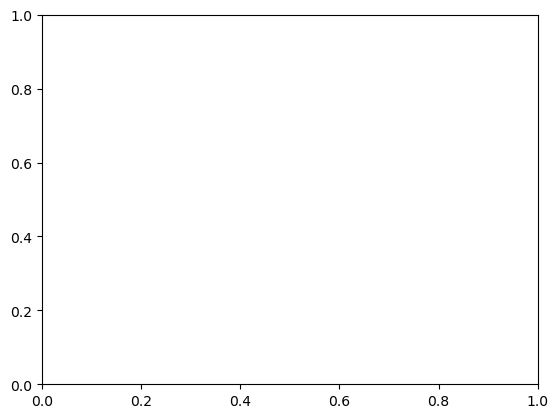

In [139]:
# 모델별로 성능을 비교할 경우에 사용

dir_input = './df_input/df_12hr.xlsx'
dir_output = './df_output/df_categorical_output_hr/df_categorical_output_60hr.xlsx'

models = ['DT','KNN','LR','RF','SVM','XGB']
n_fold = 5
imputation = 'smote'
calibration = 'random'
curves = ['roc', 'pr'] # roc: ROC_AUC/ pr: PR_AUC

for curve in curves:
    execute(dir_input, dir_output, n_fold, imputation, calibration, curve, models)
    plt.cla()


#### 5) Execute single model

0.0% processing..
save matrix: SVM_matrix_trained_random_2hr_60hr.joblib
16.666666666666664% processing..
save matrix: SVM_matrix_trained_random_4hr_60hr.joblib
33.33333333333333% processing..
save matrix: SVM_matrix_trained_random_6hr_60hr.joblib
50.0% processing..
save matrix: SVM_matrix_trained_random_8hr_60hr.joblib
66.66666666666666% processing..
save matrix: SVM_matrix_trained_random_10hr_60hr.joblib
83.33333333333334% processing..
save matrix: SVM_matrix_trained_random_12hr_60hr.joblib
0.0% processing..
save matrix: SVM_matrix_trained_random_2hr_60hr.joblib
16.666666666666664% processing..
save matrix: SVM_matrix_trained_random_4hr_60hr.joblib
33.33333333333333% processing..
save matrix: SVM_matrix_trained_random_6hr_60hr.joblib
50.0% processing..
save matrix: SVM_matrix_trained_random_8hr_60hr.joblib
66.66666666666666% processing..
save matrix: SVM_matrix_trained_random_10hr_60hr.joblib
83.33333333333334% processing..
save matrix: SVM_matrix_trained_random_12hr_60hr.joblib


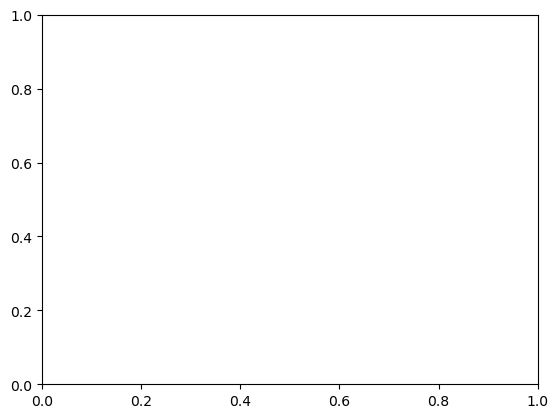

In [200]:
model = 'SVM'# 'LR','DT','RF','XGB','KNN','ANN','SVM'
curves = ['roc','pr']

for curve in curves:
    execute(dir_input, dir_output, n_fold, imputation, calibration, curve, model)
    plt.cla()

In [204]:
## ANN single execution

curves = ['roc','pr']

for curve in curves:
    i = 0
    total = len(dir_input)*len(dir_output)
    df_result = pd.DataFrame(columns = ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"])
    
    for output in dir_output:
        out_ = re.sub(r'[^0-9]', '', output)
        idx = {'Accuracy': f'{out_}hr'}
        df_result = df_result.append(idx, ignore_index=True)
    
        for input in dir_input:
            
            in_ = re.sub(r'[^0-9]', '', input)
            print(f"{i/total*100}% processing..")

        
            ## Run
            confusion, result = ANN_model(input, output, n_fold, calibration, curve)
        
            ## post-process results from model
            dic = {}
            temp = result.split(', ')

            index = 0
            for key in df_result.keys():
                dic[key] = temp[index]
                index += 1

            df_result = df_result.append(dic, ignore_index=True)
            plt.savefig(f'./result_graph/ANN_{imputation}_{curve}_curve_{out_}hr.png', dpi=300)
            i = i + 1
        
        plt.cla()

    # export    
    df_result.to_csv(f'./result_csv/result_ANN_{calibration}_{imputation}_prolonged.csv')

0.0% processing..
INFO:tensorflow:Assets written to: ram://adb2030eda8c4d77b54258a5e85237a9/assets


INFO:tensorflow:Assets written to: ram://adb2030eda8c4d77b54258a5e85237a9/assets


INFO:tensorflow:Assets written to: ram://ba91e9f34a404c5fa7e17d0c97f8c3df/assets


2023-11-03 10:36:40.156057: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1ec7c71c323a430598ae177e2acc7096: INVALID_ARGUMENT: ram://1ec7c71c323a430598ae177e2acc7096 is a directory.
INFO:tensorflow:Assets written to: ram://ba91e9f34a404c5fa7e17d0c97f8c3df/assets


INFO:tensorflow:Assets written to: ram://fcd25c569bc5420e835e79a5cdacfc8d/assets


2023-11-03 10:36:40.396882: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ddc83d6ba08a452ba85b059fb8ebd829: INVALID_ARGUMENT: ram://ddc83d6ba08a452ba85b059fb8ebd829 is a directory.
INFO:tensorflow:Assets written to: ram://fcd25c569bc5420e835e79a5cdacfc8d/assets


INFO:tensorflow:Assets written to: ram://6924da09254d44da957634c7aa4d7a76/assets


2023-11-03 10:36:40.634452: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://580212ae08b941958ee5dfd777368fa3: INVALID_ARGUMENT: ram://580212ae08b941958ee5dfd777368fa3 is a directory.
INFO:tensorflow:Assets written to: ram://6924da09254d44da957634c7aa4d7a76/assets


INFO:tensorflow:Assets written to: ram://42091ab810e846188062cbbafe5970f5/assets


2023-11-03 10:36:40.869625: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1aa7a8c98fc04c23b3c55be0ed24c2ad: INVALID_ARGUMENT: ram://1aa7a8c98fc04c23b3c55be0ed24c2ad is a directory.
INFO:tensorflow:Assets written to: ram://42091ab810e846188062cbbafe5970f5/assets


INFO:tensorflow:Assets written to: ram://9e47895a811c4e9d97e09fa9608944b6/assets


2023-11-03 10:36:41.103423: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b93de0eb2dfa408794b53b31e3af7ace: INVALID_ARGUMENT: ram://b93de0eb2dfa408794b53b31e3af7ace is a directory.
INFO:tensorflow:Assets written to: ram://9e47895a811c4e9d97e09fa9608944b6/assets


INFO:tensorflow:Assets written to: ram://5069e276ee1d4fc2ab6d6e066fe3fc9d/assets


2023-11-03 10:36:41.340500: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38865315a65b4e039605d999dd6ec0e0: INVALID_ARGUMENT: ram://38865315a65b4e039605d999dd6ec0e0 is a directory.
INFO:tensorflow:Assets written to: ram://5069e276ee1d4fc2ab6d6e066fe3fc9d/assets


INFO:tensorflow:Assets written to: ram://0fa349f0dfb74828be7d8d3ab9b68a3d/assets


2023-11-03 10:36:41.575927: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://684b7335fd6f49f896508a7749381bd1: INVALID_ARGUMENT: ram://684b7335fd6f49f896508a7749381bd1 is a directory.
INFO:tensorflow:Assets written to: ram://0fa349f0dfb74828be7d8d3ab9b68a3d/assets


INFO:tensorflow:Assets written to: ram://d47f71c9d3504a31af264564183ec49b/assets


2023-11-03 10:36:41.812068: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f0478235f75149f5850b520073f51ce3: INVALID_ARGUMENT: ram://f0478235f75149f5850b520073f51ce3 is a directory.
INFO:tensorflow:Assets written to: ram://d47f71c9d3504a31af264564183ec49b/assets


INFO:tensorflow:Assets written to: ram://9e6715de1b7d43f59ef4b6ea90ab3876/assets


2023-11-03 10:36:42.049710: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://154780fa7f1547ab90366725a0d6b65d: INVALID_ARGUMENT: ram://154780fa7f1547ab90366725a0d6b65d is a directory.
INFO:tensorflow:Assets written to: ram://9e6715de1b7d43f59ef4b6ea90ab3876/assets


INFO:tensorflow:Assets written to: ram://8463f939f2c54d74a61606634487e41c/assets


2023-11-03 10:36:42.284153: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f44ee8a69020470f8cd58c5941685845: INVALID_ARGUMENT: ram://f44ee8a69020470f8cd58c5941685845 is a directory.
INFO:tensorflow:Assets written to: ram://8463f939f2c54d74a61606634487e41c/assets


INFO:tensorflow:Assets written to: ram://589b23f77f314d6cb5451040fe3ddfe0/assets


2023-11-03 10:36:42.516984: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://73b6007544e34cf59bb405b202f346b6: INVALID_ARGUMENT: ram://73b6007544e34cf59bb405b202f346b6 is a directory.
INFO:tensorflow:Assets written to: ram://589b23f77f314d6cb5451040fe3ddfe0/assets


INFO:tensorflow:Assets written to: ram://7fa8d37e0fad473dabd9faff9abee700/assets


2023-11-03 10:36:42.751004: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4539f6fb7e3e4bf9ad6d451c7c96f4d1: INVALID_ARGUMENT: ram://4539f6fb7e3e4bf9ad6d451c7c96f4d1 is a directory.
INFO:tensorflow:Assets written to: ram://7fa8d37e0fad473dabd9faff9abee700/assets


INFO:tensorflow:Assets written to: ram://809763a6f60c4d17b5d4f0a359d8915e/assets


2023-11-03 10:36:42.987267: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2a63f6bcfac4460d9227612c0127bd70: INVALID_ARGUMENT: ram://2a63f6bcfac4460d9227612c0127bd70 is a directory.
INFO:tensorflow:Assets written to: ram://809763a6f60c4d17b5d4f0a359d8915e/assets


INFO:tensorflow:Assets written to: ram://31e33749e8db4b139a4d3732182ec687/assets


2023-11-03 10:36:43.223025: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://30c7ba14b74a4d89b5dc4c2351fc432f: INVALID_ARGUMENT: ram://30c7ba14b74a4d89b5dc4c2351fc432f is a directory.
INFO:tensorflow:Assets written to: ram://31e33749e8db4b139a4d3732182ec687/assets


INFO:tensorflow:Assets written to: ram://271408649e824d2eaa9b6285ba1bc690/assets


2023-11-03 10:36:43.461457: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://634eeae9c2cf4437b4cb086d2a130029: INVALID_ARGUMENT: ram://634eeae9c2cf4437b4cb086d2a130029 is a directory.
INFO:tensorflow:Assets written to: ram://271408649e824d2eaa9b6285ba1bc690/assets


INFO:tensorflow:Assets written to: ram://57c5f97a69934d70bbe4a1918c7bda1d/assets


2023-11-03 10:36:43.710303: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cfdb0ca6a1eb47feadb3c58bd2ff8ab6: INVALID_ARGUMENT: ram://cfdb0ca6a1eb47feadb3c58bd2ff8ab6 is a directory.
INFO:tensorflow:Assets written to: ram://57c5f97a69934d70bbe4a1918c7bda1d/assets
2023-11-03 10:36:43.986035: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c8a3132c71d444cabbfeaa4781ab7704: INVALID_ARGUMENT: ram://c8a3132c71d444cabbfeaa4781ab7704 is a directory.


INFO:tensorflow:Assets written to: ram://ff43db89ba7949f9acbc6409e1a1a2ed/assets


INFO:tensorflow:Assets written to: ram://ff43db89ba7949f9acbc6409e1a1a2ed/assets


INFO:tensorflow:Assets written to: ram://f4de5fafd2574e2cbb8e2a1c900525a0/assets


INFO:tensorflow:Assets written to: ram://f4de5fafd2574e2cbb8e2a1c900525a0/assets
2023-11-03 10:36:45.210890: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://935210294701440fbc9dcaf1a7a0d51d: INVALID_ARGUMENT: ram://935210294701440fbc9dcaf1a7a0d51d is a directory.


INFO:tensorflow:Assets written to: ram://a2d7817dd25847eeb55c09016e4ae1ef/assets


INFO:tensorflow:Assets written to: ram://a2d7817dd25847eeb55c09016e4ae1ef/assets


INFO:tensorflow:Assets written to: ram://662b2601d5fb4a788792f6022455a76b/assets


INFO:tensorflow:Assets written to: ram://662b2601d5fb4a788792f6022455a76b/assets


INFO:tensorflow:Assets written to: ram://6ee6213b8461491796dd5357385b8d15/assets


2023-11-03 10:36:45.751265: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7e234e30239d493ba5cae37d56daacd9: INVALID_ARGUMENT: ram://7e234e30239d493ba5cae37d56daacd9 is a directory.
INFO:tensorflow:Assets written to: ram://6ee6213b8461491796dd5357385b8d15/assets


INFO:tensorflow:Assets written to: ram://f7de5bb31df64dfaa3376a1f2bf51dcd/assets


INFO:tensorflow:Assets written to: ram://f7de5bb31df64dfaa3376a1f2bf51dcd/assets


INFO:tensorflow:Assets written to: ram://1531f32aa3ea4a94b35ee1a2c8829b46/assets


INFO:tensorflow:Assets written to: ram://1531f32aa3ea4a94b35ee1a2c8829b46/assets
2023-11-03 10:36:46.275284: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3d55fbb6b84f4d8893a26ecfbcefbc4d: INVALID_ARGUMENT: ram://3d55fbb6b84f4d8893a26ecfbcefbc4d is a directory.


INFO:tensorflow:Assets written to: ram://5a85b74d1da448fb9061d50275204074/assets


INFO:tensorflow:Assets written to: ram://5a85b74d1da448fb9061d50275204074/assets


INFO:tensorflow:Assets written to: ram://1e8e4e8d4ec944a8adb6030d5ca9d1f2/assets


2023-11-03 10:36:46.737913: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f0876ba27dc3467cbed022d53f297952: INVALID_ARGUMENT: ram://f0876ba27dc3467cbed022d53f297952 is a directory.
INFO:tensorflow:Assets written to: ram://1e8e4e8d4ec944a8adb6030d5ca9d1f2/assets


Epoch 1/10
INFO:tensorflow:Assets written to: ram://047f44a359404573a3fc8a11ad21b021/assets


INFO:tensorflow:Assets written to: ram://047f44a359404573a3fc8a11ad21b021/assets



  1/374 [..............................] - ETA: 1:03 - loss: 2.8358 - accuracy: 0.0625

2023-11-03 10:36:47.102548: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ac0f64a5849d42e9a536c0de61f7526b: INVALID_ARGUMENT: ram://ac0f64a5849d42e9a536c0de61f7526b is a directory.


374/374 [==============================] - 0s 686us/step - loss: 0.9840 - accuracy: 0.6474
Epoch 2/10
  1/374 [..............................] - ETA: 0s - loss: 0.7178 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://908544549e9346ca9bc5402bf41ec32b/assets


2023-11-03 10:36:47.248265: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1fd197af8d034da9953a165ed70eb60b: INVALID_ARGUMENT: ram://1fd197af8d034da9953a165ed70eb60b is a directory.
INFO:tensorflow:Assets written to: ram://908544549e9346ca9bc5402bf41ec32b/assets


 71/374 [====>.........................] - ETA: 0s - loss: 1.8140 - accuracy: 0.7632 INFO:tensorflow:Assets written to: ram://e1dbe0f35aa44e479afc6431bd51a7ab/assets


INFO:tensorflow:Assets written to: ram://e1dbe0f35aa44e479afc6431bd51a7ab/assets


374/374 [==============================] - 0s 782us/step - loss: 0.6618 - accuracy: 0.5132
Epoch 3/10
374/374 [==============================] - 0s 692us/step - loss: 0.9762 - accuracy: 0.6349
Epoch 2/10
374/374 [==============================] - 0s 724us/step - loss: 0.6454 - accuracy: 0.5498
Epoch 4/10
137/374 [=========>....................] - ETA: 0s - loss: 0.6657 - accuracy: 0.5164INFO:tensorflow:Assets written to: ram://76296019bcdf438697a761da5edc594a/assets


2023-11-03 10:36:47.843608: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9fe12d1e310d48dabf9a8ed51603a66b: INVALID_ARGUMENT: ram://9fe12d1e310d48dabf9a8ed51603a66b is a directory.
INFO:tensorflow:Assets written to: ram://76296019bcdf438697a761da5edc594a/assets


374/374 [==============================] - 0s 825us/step - loss: 0.6604 - accuracy: 0.5241
Epoch 3/10
350/374 [===========================>..] - ETA: 0s - loss: 0.6351 - accuracy: 0.5559INFO:tensorflow:Assets written to: ram://30a799f7684240099e05500f5c366adb/assets


INFO:tensorflow:Assets written to: ram://30a799f7684240099e05500f5c366adb/assets


374/374 [==============================] - 0s 869us/step - loss: 0.6364 - accuracy: 0.5587
Epoch 5/10
374/374 [==============================] - 0s 839us/step - loss: 0.6459 - accuracy: 0.5461
Epoch 4/10
122/374 [========>.....................] - ETA: 0s - loss: 0.6337 - accuracy: 0.5907INFO:tensorflow:Assets written to: ram://fc9ba9e2b8294e10ad3bf909d3034804/assets


2023-11-03 10:36:48.390777: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d408cca3ac754bee8800bdd04d06fd03: INVALID_ARGUMENT: ram://d408cca3ac754bee8800bdd04d06fd03 is a directory.
INFO:tensorflow:Assets written to: ram://fc9ba9e2b8294e10ad3bf909d3034804/assets


374/374 [==============================] - 0s 973us/step - loss: 0.6311 - accuracy: 0.5635
Epoch 6/10
374/374 [==============================] - 1s 1ms/step - loss: 0.9776 - accuracy: 0.6568
Epoch 2/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6375 - accuracy: 0.5587
Epoch 5/10
 96/374 [======>.......................] - ETA: 0s - loss: 1.6280 - accuracy: 0.8118    INFO:tensorflow:Assets written to: ram://233b0ca522c041ab84e71bd52bb9db42/assets


INFO:tensorflow:Assets written to: ram://233b0ca522c041ab84e71bd52bb9db42/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6605 - accuracy: 0.5232
Epoch 3/10
 83/374 [=====>........................] - ETA: 0s - loss: 0.6203 - accuracy: 0.5625

2023-11-03 10:36:49.007077: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://80c18636601843d0b38235363679deca: INVALID_ARGUMENT: ram://80c18636601843d0b38235363679deca is a directory.


374/374 [==============================] - 1s 1ms/step - loss: 0.9771 - accuracy: 0.6234
Epoch 2/10
121/374 [========>.....................] - ETA: 0s - loss: 0.6401 - accuracy: 0.4814INFO:tensorflow:Assets written to: ram://45af2c2222904d308ca813f188d97711/assets


INFO:tensorflow:Assets written to: ram://45af2c2222904d308ca813f188d97711/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6330 - accuracy: 0.5662
Epoch 6/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6256 - accuracy: 0.5649
Epoch 8/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6454 - accuracy: 0.5395
Epoch 4/10
305/374 [=======================>......] - ETA: 0s - loss: 0.6640 - accuracy: 0.5020INFO:tensorflow:Assets written to: ram://3d943e6dec064e718e2826705d5e1b5b/assets


2023-11-03 10:36:49.501159: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b887f0af393c4f3ea1c00859fdc33804: INVALID_ARGUMENT: ram://b887f0af393c4f3ea1c00859fdc33804 is a directory.
INFO:tensorflow:Assets written to: ram://3d943e6dec064e718e2826705d5e1b5b/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6614 - accuracy: 0.5143
Epoch 3/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6295 - accuracy: 0.5667
Epoch 7/10
 24/374 [>.............................] - ETA: 0s - loss: 2.2932 - accuracy: 0.3672      INFO:tensorflow:Assets written to: ram://966b211f40464f4eb69129fc7db68ded/assets


INFO:tensorflow:Assets written to: ram://966b211f40464f4eb69129fc7db68ded/assets


374/374 [==============================] - 1s 1ms/step - loss: 0.6376 - accuracy: 0.5614
Epoch 5/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6465 - accuracy: 0.5511
Epoch 4/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6271 - accuracy: 0.5598
Epoch 8/10
265/374 [====================>.........] - ETA: 0s - loss: 1.1054 - accuracy: 0.6486INFO:tensorflow:Assets written to: ram://9ba9ca0c5c144c8b8debf2b5a26bd475/assets


2023-11-03 10:36:50.425214: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://623c1586deab4c71ae286a53baf3166c: INVALID_ARGUMENT: ram://623c1586deab4c71ae286a53baf3166c is a directory.
INFO:tensorflow:Assets written to: ram://9ba9ca0c5c144c8b8debf2b5a26bd475/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.5099
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.9828 - accuracy: 0.6250
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6209 - accuracy: 0.5757
Epoch 10/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6381 - accuracy: 0.5673
Epoch 5/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6332 - accuracy: 0.5660
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6253 - accuracy: 0.5726
INFO:tensorflow:Assets written to: ram://3f64ddd949354119874a9df0c3b02194/assets


2023-11-03 10:36:50.969815: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://212f037c263f4a658adb9fcc153ef5a8: INVALID_ARGUMENT: ram://212f037c263f4a658adb9fcc153ef5a8 is a directory.
INFO:tensorflow:Assets written to: ram://3f64ddd949354119874a9df0c3b02194/assets


Epoch 9/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6434 - accuracy: 0.5367
Epoch 4/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6321 - accuracy: 0.5653
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6297 - accuracy: 0.5690
Epoch 7/10
100/374 [=======>......................] - ETA: 0s - loss: 0.6438 - accuracy: 0.5581

2023-11-03 10:36:51.232047: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8b1fbfdabf7c4499a982a17123240230: INVALID_ARGUMENT: ram://8b1fbfdabf7c4499a982a17123240230 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6238 - accuracy: 0.5749
Epoch 10/10
374/374 [==============================] - 1s 2ms/step - loss: 0.9832 - accuracy: 0.6436
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6358 - accuracy: 0.5621
Epoch 5/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6276 - accuracy: 0.5685
Epoch 8/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6287 - accuracy: 0.5644
Epoch 7/10
Epoch 1/20
 38/374 [==>...........................] - ETA: 0s - loss: 0.6441 - accuracy: 0.5066

2023-11-03 10:36:51.791298: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a5dfac3ee9ff48ebb4a723230f3fe8d5: INVALID_ARGUMENT: ram://a5dfac3ee9ff48ebb4a723230f3fe8d5 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6451 - accuracy: 0.5498
Epoch 4/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6608 - accuracy: 0.5264
Epoch 3/20
261/374 [===================>..........] - ETA: 0s - loss: 0.6333 - accuracy: 0.5457

2023-11-03 10:36:52.333604: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e488151793024763aab3b0534637ccad: INVALID_ARGUMENT: ram://e488151793024763aab3b0534637ccad is a directory.
2023-11-03 10:36:52.367911: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://51cc1a4d8fdd4f40bf5d28168f99a95b: INVALID_ARGUMENT: ram://51cc1a4d8fdd4f40bf5d28168f99a95b is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6253 - accuracy: 0.5695
Epoch 9/10
374/374 [==============================] - 1s 2ms/step - loss: 0.9751 - accuracy: 0.6291
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6306 - accuracy: 0.5634
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6265 - accuracy: 0.5771
Epoch 8/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6613 - accuracy: 0.5115
Epoch 3/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6372 - accuracy: 0.5607
Epoch 5/20
211/374 [===============>..............] - ETA: 0s - loss: 0.6229 - accuracy: 0.5563

2023-11-03 10:36:52.931108: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://785648c9990c492eb4dcb30b3e7ae908: INVALID_ARGUMENT: ram://785648c9990c492eb4dcb30b3e7ae908 is a directory.


187/187 [==============================] - 1s 2ms/step - loss: 1.2392 - accuracy: 0.7503
Epoch 2/10
 32/187 [====>.........................] - ETA: 0s - loss: 0.7227 - accuracy: 0.4473

2023-11-03 10:36:53.013327: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bc4082d240054972801b4501db905476: INVALID_ARGUMENT: ram://bc4082d240054972801b4501db905476 is a directory.


237/374 [==================>...........] - ETA: 0s - loss: 0.6441 - accuracy: 0.5132Epoch 9/10
Epoch 1/10
187/187 [==============================] - 1s 2ms/step - loss: 1.2468 - accuracy: 0.7690
Epoch 2/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6234 - accuracy: 0.5705
Epoch 10/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6607 - accuracy: 0.5297
Epoch 3/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6268 - accuracy: 0.5713
Epoch 7/10
 93/374 [======>.......................] - ETA: 0s - loss: 0.6210 - accuracy: 0.5450INFO:tensorflow:Assets written to: ram://0fb68995378c4bb99ff2fc1eff43c070/assets


INFO:tensorflow:Assets written to: ram://0fb68995378c4bb99ff2fc1eff43c070/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6463 - accuracy: 0.5461
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5057
Epoch 3/10
 76/374 [=====>........................] - ETA: 0s - loss: 0.6407 - accuracy: 0.5247   


128/374 [=========>....................] - ETA: 0s - loss: 0.6232 - accuracy: 0.5737

2023-11-03 10:36:53.549551: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://10ed73ae194a4bec9d80277c9af89b76: INVALID_ARGUMENT: ram://10ed73ae194a4bec9d80277c9af89b76 is a directory.


187/187 [==============================] - 1s 2ms/step - loss: 1.2401 - accuracy: 0.7559
Epoch 2/20
150/374 [===========>..................] - ETA: 0s - loss: 0.6414 - accuracy: 0.5779

2023-11-03 10:36:53.658964: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d6953dade8a743dfa4bfb4953fefcdb2: INVALID_ARGUMENT: ram://d6953dade8a743dfa4bfb4953fefcdb2 is a directory.
2023-11-03 10:36:53.743540: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://85e3289131744a128d3102ea90500b10: INVALID_ARGUMENT: ram://85e3289131744a128d3102ea90500b10 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6374 - accuracy: 0.5545
Epoch 5/20
374/374 [==============================] - 1s 3ms/step - loss: 0.6587 - accuracy: 0.5016
Epoch 3/20
187/187 [==============================] - 1s 3ms/step - loss: 1.2433 - accuracy: 0.7559
Epoch 2/10
172/187 [==========================>...] - ETA: 0s - loss: 0.6919 - accuracy: 0.5069INFO:tensorflow:Assets written to: ram://15577e363b65449080d0dc2fe88776a2/assets


INFO:tensorflow:Assets written to: ram://15577e363b65449080d0dc2fe88776a2/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6225 - accuracy: 0.5775
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5100
Epoch 3/20
187/187 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.5271
Epoch 4/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6452 - accuracy: 0.5397
Epoch 4/20
187/187 [==============================] - 1s 3ms/step - loss: 1.2430 - accuracy: 0.7701
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5084
Epoch 3/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.5443
Epoch 5/10
187/187 [==============================] - 1s 2ms/step - loss: 1.2439 - accuracy: 0.7800
Epoch 2/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6330 - accuracy: 0.5680
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5323
Epoch 3/20

2023-11-03 10:36:54.558861: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5fb4b07d272e4394b7e4907f95a477cc: INVALID_ARGUMENT: ram://5fb4b07d272e4394b7e4907f95a477cc is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.5067
Epoch 4/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6374 - accuracy: 0.5551
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6481 - accuracy: 0.5329
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.4971
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6222 - accuracy: 0.5683
Epoch 9/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6255 - accuracy: 0.5762
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5180
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6338 - accuracy: 0.5582
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.5598
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.5562
Epoch 5/10


Epoch 9/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6275 - accuracy: 0.5750
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6301 - accuracy: 0.5663
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6273 - accuracy: 0.5649
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6270 - accuracy: 0.5756
Epoch 11/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6203 - accuracy: 0.5682
Epoch 11/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6257 - accuracy: 0.5741
Epoch 9/20
179/187 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.5815

2023-11-03 10:36:56.514187: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ad763e97d19c4258a97938bbbdb97d31: INVALID_ARGUMENT: ram://ad763e97d19c4258a97938bbbdb97d31 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6276 - accuracy: 0.5796
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6257 - accuracy: 0.5731
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6254 - accuracy: 0.5740
Epoch 1/20
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6271 - accuracy: 0.5687
Epoch 11/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.5722
Epoch 10/20
  1/374 [..............................] - ETA: 0s - loss: 0.6789 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://27d28c8ca0a64d9f8c051892c6a8e33a/assets


INFO:tensorflow:Assets written to: ram://27d28c8ca0a64d9f8c051892c6a8e33a/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6321 - accuracy: 0.5660
Epoch 8/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6244 - accuracy: 0.5730
Epoch 8/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6242 - accuracy: 0.5746
Epoch 13/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6190 - accuracy: 0.5697
Epoch 9/20
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6257 - accuracy: 0.5715
Epoch 12/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.5707
Epoch 10/20
145/187 [======================>.......] - ETA: 0s - loss: 0.6257 - accuracy: 0.5584

2023-11-03 10:36:56.811312: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3bf8e4ed307b402bbe52be7ade694cb6: INVALID_ARGUMENT: ram://3bf8e4ed307b402bbe52be7ade694cb6 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6292 - accuracy: 0.5772
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.5724
Epoch 14/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6241 - accuracy: 0.5620
Epoch 13/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6221 - accuracy: 0.5784
Epoch 11/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.5704
Epoch 10/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6224 - accuracy: 0.5778
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6917 - accuracy: 0.5171
Epoch 3/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.5838
Epoch 15/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.5796
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6177 - accuracy: 0.5756
Epoch 

187/187 [==============================] - 0s 882us/step - loss: 0.6213 - accuracy: 0.5644
Epoch 16/20
187/187 [==============================] - 0s 918us/step - loss: 0.6900 - accuracy: 0.5073
Epoch 3/20
187/187 [==============================] - 0s 894us/step - loss: 0.6222 - accuracy: 0.5704
Epoch 15/20
374/374 [==============================] - 0s 928us/step - loss: 0.6211 - accuracy: 0.5704
Epoch 12/20
374/374 [==============================] - 0s 850us/step - loss: 0.6211 - accuracy: 0.5728
Epoch 10/20
187/187 [==============================] - 0s 854us/step - loss: 0.6235 - accuracy: 0.5776
Epoch 12/20
187/187 [==============================] - 0s 882us/step - loss: 0.6483 - accuracy: 0.5537
Epoch 5/20
187/187 [==============================] - 0s 916us/step - loss: 0.6205 - accuracy: 0.5786
Epoch 14/20
Epoch 11/20
Epoch 17/20
187/187 [==============================] - 0s 863us/step - loss: 0.6578 - accuracy: 0.5173
Epoch 4/20
374/374 [==============================] - 0s 853us/

374/374 [==============================] - 0s 1ms/step - loss: 0.6183 - accuracy: 0.5751
Epoch 16/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6164 - accuracy: 0.5751
Epoch 14/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6167 - accuracy: 0.5664
Epoch 20/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6150 - accuracy: 0.5687
Epoch 18/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6233 - accuracy: 0.5783
Epoch 13/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6173 - accuracy: 0.5801
Epoch 15/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6183 - accuracy: 0.5724
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.5756
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6212 - accuracy: 0.5746
Epoch 17/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6150 - accuracy: 0.5662
Ep

187/187 [==============================] - 0s 1ms/step - loss: 0.6211 - accuracy: 0.5798
Epoch 15/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.5712
Epoch 17/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6199 - accuracy: 0.5715
Epoch 14/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6200 - accuracy: 0.5745
Epoch 16/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6171 - accuracy: 0.5741
Epoch 18/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6153 - accuracy: 0.5788
Epoch 15/20
Epoch 16/20
 54/187 [=======>......................] - ETA: 0s - loss: 0.6276 - accuracy: 0.5926

374/374 [==============================] - 0s 1ms/step - loss: 0.6160 - accuracy: 0.5721
Epoch 17/20
Epoch 17/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6172 - accuracy: 0.5657
Epoch 18/20
187/187 [==============================] - 0s 999us/step - loss: 0.6187 - accuracy: 0.5778
Epoch 16/20
187/187 [==============================] - 0s 944us/step - loss: 0.6185 - accuracy: 0.5821
Epoch 18/20
329/374 [=========================>....] - ETA: 0s - loss: 0.6155 - accuracy: 0.5737

374/374 [==============================] - 0s 901us/step - loss: 0.6171 - accuracy: 0.5712
Epoch 19/20
187/187 [==============================] - 0s 836us/step - loss: 0.6174 - accuracy: 0.5768
Epoch 17/20
374/374 [==============================] - 0s 856us/step - loss: 0.6152 - accuracy: 0.5708
Epoch 18/20
187/187 [==============================] - 0s 790us/step - loss: 0.6180 - accuracy: 0.5771
Epoch 19/20
374/374 [==============================] - 0s 823us/step - loss: 0.6166 - accuracy: 0.5680
Epoch 19/20
187/187 [==============================] - 0s 855us/step - loss: 0.6171 - accuracy: 0.5741
Epoch 18/20
187/187 [==============================] - 0s 768us/step - loss: 0.6171 - accuracy: 0.5701
Epoch 20/20
374/374 [==============================] - 0s 786us/step - loss: 0.6141 - accuracy: 0.5723
Epoch 20/20
Epoch 18/20
187/187 [==============================] - 0s 814us/step - loss: 0.6162 - accuracy: 0.5740
Epoch 19/20
374/374 [==============================] - 0s 791us/step - lo

187/187 [==============================] - 0s 879us/step - loss: 0.6151 - accuracy: 0.5810
Epoch 20/20
374/374 [==============================] - 0s 809us/step - loss: 0.6152 - accuracy: 0.5713
Epoch 20/20
374/374 [==============================] - 0s 774us/step - loss: 0.6134 - accuracy: 0.5725
Epoch 20/20
94/94 [==============================] - 0s 449us/steposs: 0.6130 - accuracy: 0.57


94/94 [==============================] - 0s 385us/step


INFO:tensorflow:Assets written to: ram://85e2a4b6c6c349b7808b9ee521cf1550/assets


INFO:tensorflow:Assets written to: ram://85e2a4b6c6c349b7808b9ee521cf1550/assets
2023-11-03 10:37:01.629196: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7daefe1f4b554e55be6a094fdb3589d9: INVALID_ARGUMENT: ram://7daefe1f4b554e55be6a094fdb3589d9 is a directory.


INFO:tensorflow:Assets written to: ram://654dd27fd6294d9887af1744565c6da8/assets


INFO:tensorflow:Assets written to: ram://654dd27fd6294d9887af1744565c6da8/assets


Epoch 1/20


2023-11-03 10:37:01.870783: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c31f50d2cf6f465fa173068bd781435d: INVALID_ARGUMENT: ram://c31f50d2cf6f465fa173068bd781435d is a directory.


468/468 [==============================] - 0s 481us/step - loss: 0.9162 - accuracy: 0.6241
Epoch 2/20
468/468 [==============================] - 0s 480us/step - loss: 0.6539 - accuracy: 0.5226
Epoch 3/20
468/468 [==============================] - 0s 483us/step - loss: 0.6397 - accuracy: 0.5614
Epoch 4/20
468/468 [==============================] - 0s 472us/step - loss: 0.6335 - accuracy: 0.5592
Epoch 5/20
468/468 [==============================] - 0s 479us/step - loss: 0.6289 - accuracy: 0.5746
Epoch 6/20
468/468 [==============================] - 0s 488us/step - loss: 0.6256 - accuracy: 0.5650
Epoch 7/20
468/468 [==============================] - 0s 482us/step - loss: 0.6231 - accuracy: 0.5697
Epoch 8/20
468/468 [==============================] - 0s 482us/step - loss: 0.6218 - accuracy: 0.5749
Epoch 9/20
468/468 [==============================] - 0s 486us/step - loss: 0.6201 - accuracy: 0.5689
Epoch 10/20
468/468 [==============================] - 0s 528us/step - loss: 0.6190 - accurac

INFO:tensorflow:Assets written to: ram://50b8adc977fe480084a2292a235a3510/assets


INFO:tensorflow:Assets written to: ram://50b8adc977fe480084a2292a235a3510/assets
2023-11-03 10:37:10.639489: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8f2b2b9880804aaf97a57cf07792bf95: INVALID_ARGUMENT: ram://8f2b2b9880804aaf97a57cf07792bf95 is a directory.


INFO:tensorflow:Assets written to: ram://0cc229ed830e43f78b629cb7bb00505c/assets


INFO:tensorflow:Assets written to: ram://0cc229ed830e43f78b629cb7bb00505c/assets
2023-11-03 10:37:10.874409: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://767e3d0845a349c2981dc35405538aaf: INVALID_ARGUMENT: ram://767e3d0845a349c2981dc35405538aaf is a directory.


INFO:tensorflow:Assets written to: ram://65f8ea0df465449488e27339ceecada9/assets


INFO:tensorflow:Assets written to: ram://65f8ea0df465449488e27339ceecada9/assets
2023-11-03 10:37:11.104935: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://161c617564954010a61e3a9890ba495b: INVALID_ARGUMENT: ram://161c617564954010a61e3a9890ba495b is a directory.


INFO:tensorflow:Assets written to: ram://e85274acf1e04eb685557024cbc56d01/assets


INFO:tensorflow:Assets written to: ram://e85274acf1e04eb685557024cbc56d01/assets
2023-11-03 10:37:11.339016: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://84bd709301d941cc8c18679ea068f5fb: INVALID_ARGUMENT: ram://84bd709301d941cc8c18679ea068f5fb is a directory.


INFO:tensorflow:Assets written to: ram://820cbd27306543bfa4589e8e590501f6/assets


INFO:tensorflow:Assets written to: ram://820cbd27306543bfa4589e8e590501f6/assets
2023-11-03 10:37:11.571306: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://54d0586fc68349ccbc110547e5c9c13f: INVALID_ARGUMENT: ram://54d0586fc68349ccbc110547e5c9c13f is a directory.


INFO:tensorflow:Assets written to: ram://38910bd58d8642d2950b033cbd560885/assets


INFO:tensorflow:Assets written to: ram://38910bd58d8642d2950b033cbd560885/assets
2023-11-03 10:37:11.811661: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://aa438842e8014000b95f2b4e1a36f00e: INVALID_ARGUMENT: ram://aa438842e8014000b95f2b4e1a36f00e is a directory.


INFO:tensorflow:Assets written to: ram://8c3d8edae3ff4bbba9c5023aedab58b7/assets


INFO:tensorflow:Assets written to: ram://8c3d8edae3ff4bbba9c5023aedab58b7/assets
2023-11-03 10:37:12.048924: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b5482892880348e1a5ed07829b4c5dd1: INVALID_ARGUMENT: ram://b5482892880348e1a5ed07829b4c5dd1 is a directory.


INFO:tensorflow:Assets written to: ram://8141517308554fa5954f96caf4c5d32e/assets


INFO:tensorflow:Assets written to: ram://8141517308554fa5954f96caf4c5d32e/assets
2023-11-03 10:37:12.285942: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4f56dcb669834da0a1343270f9bafa9a: INVALID_ARGUMENT: ram://4f56dcb669834da0a1343270f9bafa9a is a directory.


INFO:tensorflow:Assets written to: ram://341e66be1f404b8297f6a286de2ff1db/assets


INFO:tensorflow:Assets written to: ram://341e66be1f404b8297f6a286de2ff1db/assets
2023-11-03 10:37:12.527372: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9144f2e85ae84ec0b33037e8e5ade88c: INVALID_ARGUMENT: ram://9144f2e85ae84ec0b33037e8e5ade88c is a directory.


INFO:tensorflow:Assets written to: ram://02474563f9c548a68166b517800a6108/assets


INFO:tensorflow:Assets written to: ram://02474563f9c548a68166b517800a6108/assets
2023-11-03 10:37:12.938872: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c56e83ba24584056a500d6984fd78b6f: INVALID_ARGUMENT: ram://c56e83ba24584056a500d6984fd78b6f is a directory.


INFO:tensorflow:Assets written to: ram://3461356bb734468396370197f1bfc73c/assets


INFO:tensorflow:Assets written to: ram://3461356bb734468396370197f1bfc73c/assets
2023-11-03 10:37:13.176667: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://97368f6fb69e4c0fb499cf7af492213c: INVALID_ARGUMENT: ram://97368f6fb69e4c0fb499cf7af492213c is a directory.


INFO:tensorflow:Assets written to: ram://d9d6eccd569646b8bdd8fd95c356ccc4/assets


INFO:tensorflow:Assets written to: ram://d9d6eccd569646b8bdd8fd95c356ccc4/assets
2023-11-03 10:37:13.423933: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://36c300bd838d4028bb7140aba2d30c64: INVALID_ARGUMENT: ram://36c300bd838d4028bb7140aba2d30c64 is a directory.


INFO:tensorflow:Assets written to: ram://fa506e42fdd74759bb2dcb416c48fd2c/assets


INFO:tensorflow:Assets written to: ram://fa506e42fdd74759bb2dcb416c48fd2c/assets
2023-11-03 10:37:13.659590: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7d3c945084434b3fa5a2a1bb583e99e2: INVALID_ARGUMENT: ram://7d3c945084434b3fa5a2a1bb583e99e2 is a directory.


INFO:tensorflow:Assets written to: ram://539ec7b29fef406faa7f7e30574e439c/assets


INFO:tensorflow:Assets written to: ram://539ec7b29fef406faa7f7e30574e439c/assets
2023-11-03 10:37:13.891692: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://edbabd0987ad48f39d168eac36a9f6a5: INVALID_ARGUMENT: ram://edbabd0987ad48f39d168eac36a9f6a5 is a directory.


INFO:tensorflow:Assets written to: ram://ff3ea9007b7e48189f6531faca7aeba9/assets


INFO:tensorflow:Assets written to: ram://ff3ea9007b7e48189f6531faca7aeba9/assets
2023-11-03 10:37:14.125602: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75fd1d484cfb45f7ab0893ad57bbe22f: INVALID_ARGUMENT: ram://75fd1d484cfb45f7ab0893ad57bbe22f is a directory.


INFO:tensorflow:Assets written to: ram://17bd739a694d489e8863fe67c112c157/assets


INFO:tensorflow:Assets written to: ram://17bd739a694d489e8863fe67c112c157/assets
2023-11-03 10:37:14.359222: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://25ab321bd1f7451c9604fc1ce694d198: INVALID_ARGUMENT: ram://25ab321bd1f7451c9604fc1ce694d198 is a directory.


INFO:tensorflow:Assets written to: ram://3b6dba931826453d9de5497e7b71a27b/assets


INFO:tensorflow:Assets written to: ram://3b6dba931826453d9de5497e7b71a27b/assets
2023-11-03 10:37:14.593308: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1647935766fa4fd485a16d672b178a24: INVALID_ARGUMENT: ram://1647935766fa4fd485a16d672b178a24 is a directory.


INFO:tensorflow:Assets written to: ram://485e6e729568493d946dbb30f9ce41bb/assets


INFO:tensorflow:Assets written to: ram://485e6e729568493d946dbb30f9ce41bb/assets


INFO:tensorflow:Assets written to: ram://05d78ad883644fcb96499534c7057e40/assets


INFO:tensorflow:Assets written to: ram://05d78ad883644fcb96499534c7057e40/assets


Epoch 1/10


2023-11-03 10:37:14.983888: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5a442b3333794c6db1aa575480327767: INVALID_ARGUMENT: ram://5a442b3333794c6db1aa575480327767 is a directory.
2023-11-03 10:37:15.060309: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6bd2ffba8a324b91997041c0c4f424c9: INVALID_ARGUMENT: ram://6bd2ffba8a324b91997041c0c4f424c9 is a directory.


209/374 [===============>..............] - ETA: 0s - loss: 1.0451 - accuracy: 0.7593INFO:tensorflow:Assets written to: ram://d97e2aaa46734447844600a8422097d7/assets


INFO:tensorflow:Assets written to: ram://d97e2aaa46734447844600a8422097d7/assets


374/374 [==============================] - 0s 500us/step - loss: 0.8908 - accuracy: 0.6545
Epoch 2/10
201/374 [===============>..............] - ETA: 0s - loss: 0.6661 - accuracy: 0.5202INFO:tensorflow:Assets written to: ram://3e5f17d307d64e28b7d27dad68d5379e/assets


2023-11-03 10:37:15.361531: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://549316a667394d409d46d17f74897433: INVALID_ARGUMENT: ram://549316a667394d409d46d17f74897433 is a directory.
INFO:tensorflow:Assets written to: ram://3e5f17d307d64e28b7d27dad68d5379e/assets


374/374 [==============================] - 0s 495us/step - loss: 0.6611 - accuracy: 0.5550
Epoch 3/10
296/374 [======================>.......] - ETA: 0s - loss: 0.6416 - accuracy: 0.5995INFO:tensorflow:Assets written to: ram://161a16d0b85649519506f1769c28ac4f/assets


2023-11-03 10:37:15.614479: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bcf382b3892549c59ed3ff96c8c8e479: INVALID_ARGUMENT: ram://bcf382b3892549c59ed3ff96c8c8e479 is a directory.
INFO:tensorflow:Assets written to: ram://161a16d0b85649519506f1769c28ac4f/assets


374/374 [==============================] - 0s 515us/step - loss: 0.6416 - accuracy: 0.5970
Epoch 4/10
374/374 [==============================] - 0s 536us/step - loss: 0.8900 - accuracy: 0.6571
Epoch 2/10
179/374 [=============>................] - ETA: 0s - loss: 0.6349 - accuracy: 0.5918

2023-11-03 10:37:15.775278: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0890366e879544ab90d44e9c198b3ef5: INVALID_ARGUMENT: ram://0890366e879544ab90d44e9c198b3ef5 is a directory.


374/374 [==============================] - 0s 554us/step - loss: 0.6299 - accuracy: 0.5888
Epoch 5/10
374/374 [==============================] - 0s 548us/step - loss: 0.6596 - accuracy: 0.5582
Epoch 3/10
260/374 [===================>..........] - ETA: 0s - loss: 0.6418 - accuracy: 0.5712INFO:tensorflow:Assets written to: ram://e97d566bec2f4c1db26b8b70d985e06b/assets


INFO:tensorflow:Assets written to: ram://e97d566bec2f4c1db26b8b70d985e06b/assets


374/374 [==============================] - 0s 574us/step - loss: 0.6234 - accuracy: 0.5995
Epoch 6/10
374/374 [==============================] - 0s 572us/step - loss: 0.6399 - accuracy: 0.5784
Epoch 4/10
  1/374 [..............................] - ETA: 0s - loss: 0.6332 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://c851594f9f154646b0b040df2c913031/assets


INFO:tensorflow:Assets written to: ram://c851594f9f154646b0b040df2c913031/assets


374/374 [==============================] - 0s 575us/step - loss: 0.8972 - accuracy: 0.6479
Epoch 2/10
 80/374 [=====>........................] - ETA: 0s - loss: 0.6730 - accuracy: 0.5664

2023-11-03 10:37:16.254244: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e0f6cd340e7a40c69a91b510db782bca: INVALID_ARGUMENT: ram://e0f6cd340e7a40c69a91b510db782bca is a directory.


250/374 [===================>..........] - ETA: 0s - loss: 0.6656 - accuracy: 0.5207

2023-11-03 10:37:16.269735: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2f684365c1244e9e9692f6026dec4bcf: INVALID_ARGUMENT: ram://2f684365c1244e9e9692f6026dec4bcf is a directory.


374/374 [==============================] - 0s 605us/step - loss: 0.6289 - accuracy: 0.5980
Epoch 5/10
374/374 [==============================] - 0s 609us/step - loss: 0.6617 - accuracy: 0.5563
Epoch 3/10
374/374 [==============================] - 0s 614us/step - loss: 0.6148 - accuracy: 0.5961
Epoch 8/10
374/374 [==============================] - 0s 626us/step - loss: 0.6216 - accuracy: 0.5971
Epoch 6/10
374/374 [==============================] - 0s 625us/step - loss: 0.6414 - accuracy: 0.5968
Epoch 4/10
 82/374 [=====>........................] - ETA: 0s - loss: 0.6194 - accuracy: 0.6418INFO:tensorflow:Assets written to: ram://8a4b5df31bef4b498ea1a727645ff51f/assets


INFO:tensorflow:Assets written to: ram://8a4b5df31bef4b498ea1a727645ff51f/assets


374/374 [==============================] - 0s 639us/step - loss: 0.8914 - accuracy: 0.6513
Epoch 2/10
298/374 [======================>.......] - ETA: 0s - loss: 0.6207 - accuracy: 0.6124INFO:tensorflow:Assets written to: ram://078f2f59f048454c8320e1746bf89c73/assets


2023-11-03 10:37:16.769844: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e93ab6a62cdf429894026f0b73dc6199: INVALID_ARGUMENT: ram://e93ab6a62cdf429894026f0b73dc6199 is a directory.
INFO:tensorflow:Assets written to: ram://078f2f59f048454c8320e1746bf89c73/assets


374/374 [==============================] - 0s 690us/step - loss: 0.6123 - accuracy: 0.5929
Epoch 9/10
374/374 [==============================] - 0s 688us/step - loss: 0.6173 - accuracy: 0.5986
Epoch 7/10
374/374 [==============================] - 0s 702us/step - loss: 0.6303 - accuracy: 0.5854
Epoch 5/10
374/374 [==============================] - 0s 715us/step - loss: 0.6629 - accuracy: 0.5599
Epoch 3/10
374/374 [==============================] - 0s 734us/step - loss: 0.6103 - accuracy: 0.5943
Epoch 10/10
374/374 [==============================] - 0s 740us/step - loss: 0.6138 - accuracy: 0.5988
Epoch 8/10
  1/374 [..............................] - ETA: 0s - loss: 0.6326 - accuracy: 0.7500INFO:tensorflow:Assets written to: ram://bd53e69545e3430d9dce077c5fb92a24/assets


2023-11-03 10:37:17.053430: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f1000368c3e74b94929fd650f7f3f5e0: INVALID_ARGUMENT: ram://f1000368c3e74b94929fd650f7f3f5e0 is a directory.
INFO:tensorflow:Assets written to: ram://bd53e69545e3430d9dce077c5fb92a24/assets


374/374 [==============================] - 0s 705us/step - loss: 0.6430 - accuracy: 0.5994
Epoch 4/10
374/374 [==============================] - 0s 730us/step - loss: 0.8871 - accuracy: 0.6315
Epoch 2/10
374/374 [==============================] - 0s 796us/step - loss: 0.6111 - accuracy: 0.6011
Epoch 9/10
374/374 [==============================] - 0s 801us/step - loss: 0.6192 - accuracy: 0.5966
Epoch 7/10
252/374 [===================>..........] - ETA: 0s - loss: 0.6648 - accuracy: 0.5637

2023-11-03 10:37:17.285367: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2668f4a8d152446c8657901f8a5cd1b8: INVALID_ARGUMENT: ram://2668f4a8d152446c8657901f8a5cd1b8 is a directory.
INFO:tensorflow:Assets written to: ram://bc6024e01b874eb895bcf3ae964d91a5/assets


374/374 [==============================] - 0s 839us/step - loss: 0.6324 - accuracy: 0.5795
Epoch 5/10
374/374 [==============================] - 0s 818us/step - loss: 0.6600 - accuracy: 0.5750
Epoch 3/10
374/374 [==============================] - 0s 828us/step - loss: 0.6085 - accuracy: 0.5909
Epoch 10/10
374/374 [==============================] - 0s 830us/step - loss: 0.6160 - accuracy: 0.5960
Epoch 8/10
257/374 [===================>..........] - ETA: 0s - loss: 0.6432 - accuracy: 0.6031INFO:tensorflow:Assets written to: ram://fc06f0da4f2a43f1a41b78a1d3cdb4ea/assets


2023-11-03 10:37:17.569224: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bb301cfd968340a6ada471dd6f99970b: INVALID_ARGUMENT: ram://bb301cfd968340a6ada471dd6f99970b is a directory.
INFO:tensorflow:Assets written to: ram://fc06f0da4f2a43f1a41b78a1d3cdb4ea/assets


374/374 [==============================] - 0s 806us/step - loss: 0.8934 - accuracy: 0.6739
Epoch 2/20
374/374 [==============================] - 0s 795us/step - loss: 0.6258 - accuracy: 0.5940
Epoch 6/10
374/374 [==============================] - 0s 798us/step - loss: 0.6398 - accuracy: 0.5913
Epoch 4/10
374/374 [==============================] - 0s 850us/step - loss: 0.6131 - accuracy: 0.5909
Epoch 9/10
  1/374 [..............................] - ETA: 0s - loss: 0.6883 - accuracy: 0.7500INFO:tensorflow:Assets written to: ram://60d719c3639f445c8b799fda4cabcb64/assets


2023-11-03 10:37:17.892814: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d58a7e56af3f4af8a809aea41e470838: INVALID_ARGUMENT: ram://d58a7e56af3f4af8a809aea41e470838 is a directory.
INFO:tensorflow:Assets written to: ram://60d719c3639f445c8b799fda4cabcb64/assets


374/374 [==============================] - 1s 939us/step - loss: 0.8929 - accuracy: 0.6757
Epoch 2/20
374/374 [==============================] - 0s 909us/step - loss: 0.6203 - accuracy: 0.5920
Epoch 7/10
374/374 [==============================] - 0s 904us/step - loss: 0.6294 - accuracy: 0.5828
Epoch 5/10
289/374 [======================>.......] - ETA: 0s - loss: 0.6648 - accuracy: 0.5430INFO:tensorflow:Assets written to: ram://627ea606f6154946a521bd1b49985975/assets


2023-11-03 10:37:18.208276: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f01a759e82e24fe2a2bfd54b1ff72d8a: INVALID_ARGUMENT: ram://f01a759e82e24fe2a2bfd54b1ff72d8a is a directory.
INFO:tensorflow:Assets written to: ram://627ea606f6154946a521bd1b49985975/assets


374/374 [==============================] - 0s 911us/step - loss: 0.6111 - accuracy: 0.5963
Epoch 10/10
374/374 [==============================] - 0s 911us/step - loss: 0.8911 - accuracy: 0.6815
Epoch 2/20
374/374 [==============================] - 0s 920us/step - loss: 0.6407 - accuracy: 0.5933
Epoch 4/20
374/374 [==============================] - 0s 881us/step - loss: 0.6170 - accuracy: 0.6054
Epoch 8/10
374/374 [==============================] - 0s 895us/step - loss: 0.6228 - accuracy: 0.5975
Epoch 6/10
319/374 [========================>.....] - ETA: 0s - loss: 0.9277 - accuracy: 0.7002INFO:tensorflow:Assets written to: ram://06b1d963a03348c792db4fdf466fa3c6/assets


2023-11-03 10:37:18.544926: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38cf25f3065d4027a3c5b811d21fb9b3: INVALID_ARGUMENT: ram://38cf25f3065d4027a3c5b811d21fb9b3 is a directory.
INFO:tensorflow:Assets written to: ram://06b1d963a03348c792db4fdf466fa3c6/assets


374/374 [==============================] - 0s 962us/step - loss: 0.8919 - accuracy: 0.6413
Epoch 2/20
374/374 [==============================] - 0s 946us/step - loss: 0.6610 - accuracy: 0.5426
Epoch 3/20
374/374 [==============================] - 0s 949us/step - loss: 0.6297 - accuracy: 0.5928
Epoch 5/20
374/374 [==============================] - 0s 959us/step - loss: 0.6402 - accuracy: 0.5899
Epoch 4/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6188 - accuracy: 0.5870
Epoch 7/10
268/374 [====================>.........] - ETA: 0s - loss: 0.6648 - accuracy: 0.5676

2023-11-03 10:37:18.877147: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c24b3bc75a2641399bea08af684aee8f: INVALID_ARGUMENT: ram://c24b3bc75a2641399bea08af684aee8f is a directory.



257/374 [===================>..........] - ETA: 0s - loss: 0.6423 - accuracy: 0.5803INFO:tensorflow:Assets written to: ram://4b380d1eed2444ce8f57781e40ea6bce/assets


INFO:tensorflow:Assets written to: ram://4b380d1eed2444ce8f57781e40ea6bce/assets


374/374 [==============================] - 1s 1ms/step - loss: 0.8917 - accuracy: 0.6630
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6625 - accuracy: 0.5551
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6229 - accuracy: 0.5971
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6413 - accuracy: 0.5861
Epoch 4/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6023
Epoch 5/20
 71/374 [====>.........................] - ETA: 0s - loss: 0.6498 - accuracy: 0.6100

2023-11-03 10:37:19.280443: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a10383877144420a98b67112867e9dc1: INVALID_ARGUMENT: ram://a10383877144420a98b67112867e9dc1 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6124 - accuracy: 0.5950
Epoch 10/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6147 - accuracy: 0.5945
Epoch 8/10
187/187 [==============================] - 0s 1ms/step - loss: 1.0678 - accuracy: 0.8089
Epoch 2/10
197/374 [==============>...............] - ETA: 0s - loss: 0.6340 - accuracy: 0.5739

INFO:tensorflow:Assets written to: ram://4f95b26214e141c5a4d44ca207946041/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5110
Epoch 3/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6596 - accuracy: 0.5668
Epoch 3/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6437 - accuracy: 0.5928
Epoch 4/20
  1/374 [..............................] - ETA: 0s - loss: 0.6397 - accuracy: 0.5000

2023-11-03 10:37:19.693932: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3d47138ed2b74524827a2720ae85bf2a: INVALID_ARGUMENT: ram://3d47138ed2b74524827a2720ae85bf2a is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6181 - accuracy: 0.5968
Epoch 7/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6304 - accuracy: 0.5901
Epoch 5/20
 32/374 [=>............................] - ETA: 0s - loss: 0.6433 - accuracy: 0.6328Epoch 2/10
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6116 - accuracy: 0.5898
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6589 - accuracy: 0.5714
Epoch 4/10
146/374 [==========>...................] - ETA: 0s - loss: 0.6237 - accuracy: 0.57

curacy: 0.5938
187/187 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5386

129/187 [===================>..........] - ETA: 0s - loss: 0.6465 - accuracy: 0.5891Epoch 3/10

187/187 [==============================] - 0s 1ms/step - loss: 0.6443 - accuracy: 0.5908
Epoch 5/10

374/374 [==============================] - 0s 1ms/step - loss: 0.6402 - accuracy: 0.5927

329/374 [=========================>....] - ETA: 0s - loss: 0.6147 - accuracy: 0.5874Epoch 4/20

374/374 [==============================] - 0s 1ms/step - loss: 0.6147 - accuracy: 0.5909
Epoch 8/20

374/374 [==============================] - 0s 1ms/step - loss: 0.6325 - accuracy: 0.6004
Epoch 5/20


374/374 [==============================] - 0s 1ms/step - loss: 0.6100 - accuracy: 0.5920
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5042
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6435 - accuracy: 0.5970
Epoch 5/10
  1/187 [..............................] - ETA: 0s - loss: 0.7173 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://1eff23c3c8c54e33a278a4686bd9f38d/assets


INFO:tensorflow:Assets written to: ram://1eff23c3c8c54e33a278a4686bd9f38d/assets



187/187 [==============================] - 0s 1ms/step - loss: 0.6285 - accuracy: 0.5883
Epoch 7/10

374/374 [==============================] - 0s 1ms/step - loss: 0.6291 - accuracy: 0.5858
Epoch 5/20

374/374 [==============================] - 0s 1ms/step - loss: 0.6122 - accuracy: 0.5889

187/187 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.5734

374/374 [==============================] - 0s 1ms/step - loss: 0.6193 - accuracy: 0.5981
Epoch 9/20

368/374 [============================>.] - ETA: 0s - loss: 0.6253 - accuracy: 0.6021Epoch 4/10
Epoch 7/20

374/374 [==============================] - 0s 1ms/step - loss: 0.6255 - a

2023-11-03 10:37:20.647662: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://408cb373e8f04af3ab06a7793a51084d: INVALID_ARGUMENT: ram://408cb373e8f04af3ab06a7793a51084d is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6137 - accuracy: 0.5993
Epoch 8/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6342 - accuracy: 0.5991
Epoch 6/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6239 - accuracy: 0.5953
Epoch 8/10
154/374 [===========>..................] - ETA: 0s - loss: 0.6104 - accuracy: 0.6307INFO:tensorflow:Assets written to: ram://bfcb38bc520c4e6f986da2cb331766ef/assets


INFO:tensorflow:Assets written to: ram://bfcb38bc520c4e6f986da2cb331766ef/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6451 - accuracy: 0.5898
Epoch 5/10
199/374 [==============>...............] - ETA: 0s - loss: 0.6101 - accuracy: 0.6099

2023-11-03 10:37:21.025921: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af4f09b8fd7c45e7b43d05a336ce3f09: INVALID_ARGUMENT: ram://af4f09b8fd7c45e7b43d05a336ce3f09 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6276 - accuracy: 0.5990
Epoch 7/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6203 - accuracy: 0.5985
Epoch 9/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6228 - accuracy: 0.5955
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6094 - accuracy: 0.5873
Epoch 10/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6205 - accuracy: 0.5945
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0679 - accuracy: 0.7496
Epoch 6/10
Epoch 2/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6112 - accuracy: 0.5961
Epoch 9/20
Epoch 8/10
 75/374 [=====>........................] - ETA: 0s - loss: 0.6144 - accuracy: 0.5533INFO:tensorflow:Assets written to: ram://ceb5babbfe57492e98660efa20d5abca/assets


INFO:tensorflow:Assets written to: ram://ceb5babbfe57492e98660efa20d5abca/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6172 - accuracy: 0.5849
Epoch 10/10
  1/187 [..............................] - ETA: 35s - loss: 2.2504 - accuracy: 0.2188

2023-11-03 10:37:21.434313: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af1923036f4e4404b6e73e9844d7ea15: INVALID_ARGUMENT: ram://af1923036f4e4404b6e73e9844d7ea15 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5389
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6298 - accuracy: 0.6075
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.5981
Epoch 9/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6179 - accuracy: 0.5890
Epoch 7/20
187/187 [==============================] - 1s 2ms/step - loss: 1.0729 - accuracy: 0.8004
Epoch 2/10
301/374 [=======================>......] - ETA: 0s - loss: 0.6065 - accuracy: 0.5893INFO:tensorflow:Assets written to: ram://d92c267526184bb4a40ce1feb93cde82/assets


INFO:tensorflow:Assets written to: ram://d92c267526184bb4a40ce1feb93cde82/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6080 - accuracy: 0.5888
Epoch 11/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6132 - accuracy: 0.5918
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.5708
Epoch 4/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6252 - accuracy: 0.5973
Epoch 8/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6088 - accuracy: 0.5941
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6043
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5407
Epoch 3/10
187/187 [==============================] - 1s 2ms/step - loss: 1.0617 - accuracy: 0.7546
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.5862
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6211 - accuracy: 0.5951
Epoch 9/

2023-11-03 10:37:21.869758: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://36debab3b01048c0bab85820825599a6: INVALID_ARGUMENT: ram://36debab3b01048c0bab85820825599a6 is a directory.


249/374 [==================>...........] - ETA: 0s - loss: 0.5997 - accuracy: 0.6052INFO:tensorflow:Assets written to: ram://9e54d3aac14441f4828ecfbce23e7a4b/assets


INFO:tensorflow:Assets written to: ram://9e54d3aac14441f4828ecfbce23e7a4b/assets


374/374 [==============================] - 1s 1ms/step - loss: 0.6115 - accuracy: 0.5941
Epoch 10/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6146 - accuracy: 0.5984
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.5644
Epoch 4/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5045
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6366 - accuracy: 0.5949
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6136 - accuracy: 0.5994
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6180 - accuracy: 0.5991
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 1.0672 - accuracy: 0.7661
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6074 - accuracy: 0.5971
Epoch 11/20
176/374 [=============>................] - ETA: 0s - loss: 0.6102 - accuracy: 0.5962

2023-11-03 10:37:22.343463: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d5aee06c2271482ba8af2f60e02e80d1: INVALID_ARGUMENT: ram://d5aee06c2271482ba8af2f60e02e80d1 is a directory.



187/187 [==============================] - 0s 2ms/step - loss: 0.6431 - accuracy: 0.5793
INFO:tensorflow:Assets written to: ram://2c4f1810ceba4216ad277a02aa590ba9/assets


INFO:tensorflow:Assets written to: ram://2c4f1810ceba4216ad277a02aa590ba9/assets


Epoch 5/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6578 - accuracy: 0.5727
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6303 - accuracy: 0.5938
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5356
Epoch 3/20
243/374 [==================>...........] - ETA: 0s - loss: 0.6128 - accuracy: 0.5993

2023-11-03 10:37:22.777280: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a52b4d1eab394d3faf473d367af43f67: INVALID_ARGUMENT: ram://a52b4d1eab394d3faf473d367af43f67 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6095 - accuracy: 0.5893
Epoch 9/20
Epoch 11/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6343 - accuracy: 0.5994
Epoch 6/10
187/187 [==============================] - 0s 2ms/step - loss: 1.0711 - accuracy: 0.7805
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6438 - accuracy: 0.5826
Epoch 5/20
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.6034
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.5624
Epoch 4/20
 84/187 [============>.................] - ETA: 0s - loss: 0.6340 - accuracy: 0.5822INFO:tensorflow:Assets written to: ram://2d0349cf9d614bc39bdc2547b1cf4739/assets


INFO:tensorflow:Assets written to: ram://2d0349cf9d614bc39bdc2547b1cf4739/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6054 - accuracy: 0.5961
Epoch 12/20
 68/187 [=========>....................] - ETA: 0s - loss: 1.4791 - accuracy: 0.9499

2023-11-03 10:37:23.232322: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4089628251994f16aebefa5623561ec7: INVALID_ARGUMENT: ram://4089628251994f16aebefa5623561ec7 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6277 - accuracy: 0.5853
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5321
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.5923
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6220 - accuracy: 0.5974
Epoch 5/20
Epoch 9/10
187/187 [==============================] - 1s 2ms/step - loss: 1.0720 - accuracy: 0.7949
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6044 - accuracy: 0.5903
Epoch 14/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6099 - accuracy: 0.5923
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.5849
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6280 - accuracy: 0.5993
Epoch 7/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.591

187/187 [==============================] - 0s 2ms/step - loss: 0.6282 - accuracy: 0.5955
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6181 - accuracy: 0.6021
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.5924
Epoch 12/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6108 - accuracy: 0.5898
Epoch 13/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6060 - accuracy: 0.5949
Epoch 14/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6013 - accuracy: 0.5908
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6220 - accuracy: 0.5995
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.5943
Epoch 13/20
Epoch 11/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.5898
Epoch 14/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6045 - accuracy:

187/187 [==============================] - 0s 1ms/step - loss: 0.6059 - accuracy: 0.5918
Epoch 19/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6026 - accuracy: 0.5891
Epoch 20/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6014 - accuracy: 0.5907
Epoch 18/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.5862
Epoch 18/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6062 - accuracy: 0.5853
Epoch 17/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6054 - accuracy: 0.5901
Epoch 20/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.5902
Epoch 19/20
187/187 [==============================] - 0s 979us/step - loss: 0.6061 - accuracy: 0.5950
Epoch 19/20
187/187 [==============================] - 0s 946us/step - loss: 0.6050 - accuracy: 0.5853
Epoch 18/20
374/374 [==============================] - 0s 937us/step - loss: 0.6006 - accuracy: 0.5

INFO:tensorflow:Assets written to: ram://77292ea740e34d5b9a493dbfb2f2f01a/assets
2023-11-03 10:37:29.022663: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f6eb7c667a9c4fa092208856a024e2fc: INVALID_ARGUMENT: ram://f6eb7c667a9c4fa092208856a024e2fc is a directory.


INFO:tensorflow:Assets written to: ram://52e57a7bc6764e12a2507e2828b23281/assets


INFO:tensorflow:Assets written to: ram://52e57a7bc6764e12a2507e2828b23281/assets


Epoch 1/20


2023-11-03 10:37:29.275365: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5eb8c9aac1134251847b6541546f15c7: INVALID_ARGUMENT: ram://5eb8c9aac1134251847b6541546f15c7 is a directory.


234/234 [==============================] - 0s 496us/step - loss: 0.9979 - accuracy: 0.7533
Epoch 2/20
234/234 [==============================] - 0s 475us/step - loss: 0.6738 - accuracy: 0.5152
Epoch 3/20
234/234 [==============================] - 0s 485us/step - loss: 0.6485 - accuracy: 0.5945
Epoch 4/20
234/234 [==============================] - 0s 485us/step - loss: 0.6351 - accuracy: 0.5911
Epoch 5/20
234/234 [==============================] - 0s 493us/step - loss: 0.6275 - accuracy: 0.5909
Epoch 6/20
234/234 [==============================] - 0s 558us/step - loss: 0.6223 - accuracy: 0.5921
Epoch 7/20
234/234 [==============================] - 0s 491us/step - loss: 0.6183 - accuracy: 0.5912
Epoch 8/20
234/234 [==============================] - 0s 480us/step - loss: 0.6154 - accuracy: 0.5965
Epoch 9/20
234/234 [==============================] - 0s 482us/step - loss: 0.6125 - accuracy: 0.5865
Epoch 10/20
234/234 [==============================] - 0s 486us/step - loss: 0.6108 - accurac

INFO:tensorflow:Assets written to: ram://29c7edc90c254da99524182357716cb2/assets
2023-11-03 10:37:35.368906: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c91067986ed84da09fe69500c4d92e79: INVALID_ARGUMENT: ram://c91067986ed84da09fe69500c4d92e79 is a directory.


INFO:tensorflow:Assets written to: ram://a848c768d99840a090b291006e2ef9cf/assets


INFO:tensorflow:Assets written to: ram://a848c768d99840a090b291006e2ef9cf/assets


2023-11-03 10:37:35.979751: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f8ed5bcfcca24b56b5d195337a25e882: INVALID_ARGUMENT: ram://f8ed5bcfcca24b56b5d195337a25e882 is a directory.


INFO:tensorflow:Assets written to: ram://d91acd9f635d493a924ca5cb2198cb56/assets


INFO:tensorflow:Assets written to: ram://d91acd9f635d493a924ca5cb2198cb56/assets
2023-11-03 10:37:36.232531: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1ef05836c1184bdb8055ce9c23588038: INVALID_ARGUMENT: ram://1ef05836c1184bdb8055ce9c23588038 is a directory.


INFO:tensorflow:Assets written to: ram://30c98a4b39014440858cb34e3557d92f/assets


INFO:tensorflow:Assets written to: ram://30c98a4b39014440858cb34e3557d92f/assets
2023-11-03 10:37:36.475622: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://98bc205b8b0b4d2bba7cfda3242af404: INVALID_ARGUMENT: ram://98bc205b8b0b4d2bba7cfda3242af404 is a directory.


INFO:tensorflow:Assets written to: ram://15ff16b37a0d4548aacb7858663fda58/assets


INFO:tensorflow:Assets written to: ram://15ff16b37a0d4548aacb7858663fda58/assets
2023-11-03 10:37:36.719103: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d4edd5aadb2341448c5fab43967c6d3e: INVALID_ARGUMENT: ram://d4edd5aadb2341448c5fab43967c6d3e is a directory.


INFO:tensorflow:Assets written to: ram://2f1e02c4942242989ba3917194dd7294/assets


INFO:tensorflow:Assets written to: ram://2f1e02c4942242989ba3917194dd7294/assets
2023-11-03 10:37:36.960634: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://45a1803a7ac6485c8c9bd05fc183ad30: INVALID_ARGUMENT: ram://45a1803a7ac6485c8c9bd05fc183ad30 is a directory.


INFO:tensorflow:Assets written to: ram://322c1050443048b0b23e73952693762c/assets


INFO:tensorflow:Assets written to: ram://322c1050443048b0b23e73952693762c/assets
2023-11-03 10:37:37.200630: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6b4168352f1f499088ba2200c5a16cb7: INVALID_ARGUMENT: ram://6b4168352f1f499088ba2200c5a16cb7 is a directory.


INFO:tensorflow:Assets written to: ram://16446bb57c32442db35bbeadd34c56f9/assets


INFO:tensorflow:Assets written to: ram://16446bb57c32442db35bbeadd34c56f9/assets
2023-11-03 10:37:37.447752: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://611c78f18c934c8e8821400b6dac218c: INVALID_ARGUMENT: ram://611c78f18c934c8e8821400b6dac218c is a directory.


INFO:tensorflow:Assets written to: ram://9f02ee59186847db8514c998e5835bcf/assets


INFO:tensorflow:Assets written to: ram://9f02ee59186847db8514c998e5835bcf/assets
2023-11-03 10:37:37.690209: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2dc84788931e4e22831a3d698f652ba8: INVALID_ARGUMENT: ram://2dc84788931e4e22831a3d698f652ba8 is a directory.


INFO:tensorflow:Assets written to: ram://40fcb270f1b24665ad3922d6980e810d/assets


INFO:tensorflow:Assets written to: ram://40fcb270f1b24665ad3922d6980e810d/assets
2023-11-03 10:37:37.931325: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://80ea4a69147d4cf4832f41c411d1ec24: INVALID_ARGUMENT: ram://80ea4a69147d4cf4832f41c411d1ec24 is a directory.


INFO:tensorflow:Assets written to: ram://203bc42cad784b25aecdb77c57f7a0a0/assets


INFO:tensorflow:Assets written to: ram://203bc42cad784b25aecdb77c57f7a0a0/assets
2023-11-03 10:37:38.172338: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cd617bf0db5d473a83090923a6111771: INVALID_ARGUMENT: ram://cd617bf0db5d473a83090923a6111771 is a directory.


INFO:tensorflow:Assets written to: ram://cc12ee46b1b84eb991f7d70e09352c48/assets


INFO:tensorflow:Assets written to: ram://cc12ee46b1b84eb991f7d70e09352c48/assets
2023-11-03 10:37:38.410994: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d7ae4464037e41018b678f9740a6e926: INVALID_ARGUMENT: ram://d7ae4464037e41018b678f9740a6e926 is a directory.


INFO:tensorflow:Assets written to: ram://42363d5e990443afa0f4527af0237811/assets


INFO:tensorflow:Assets written to: ram://42363d5e990443afa0f4527af0237811/assets
2023-11-03 10:37:38.652849: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38b0a186ed1f4a86a9db34962656bf0f: INVALID_ARGUMENT: ram://38b0a186ed1f4a86a9db34962656bf0f is a directory.


INFO:tensorflow:Assets written to: ram://509a4c7e56674cc9853c145e63adf6c0/assets


INFO:tensorflow:Assets written to: ram://509a4c7e56674cc9853c145e63adf6c0/assets
2023-11-03 10:37:38.893238: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://876f9868ae34487a8999f014e2736b3b: INVALID_ARGUMENT: ram://876f9868ae34487a8999f014e2736b3b is a directory.


INFO:tensorflow:Assets written to: ram://72a128576fe143bba91543ed26956bb1/assets


INFO:tensorflow:Assets written to: ram://72a128576fe143bba91543ed26956bb1/assets
2023-11-03 10:37:39.134281: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://28a1e299a59d453297745381b4b73ace: INVALID_ARGUMENT: ram://28a1e299a59d453297745381b4b73ace is a directory.


INFO:tensorflow:Assets written to: ram://8488fb3f6cee40d8907dc0082c6f0d2a/assets


INFO:tensorflow:Assets written to: ram://8488fb3f6cee40d8907dc0082c6f0d2a/assets
2023-11-03 10:37:39.375637: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://85d54daf6cdf489897c897c47c1140bc: INVALID_ARGUMENT: ram://85d54daf6cdf489897c897c47c1140bc is a directory.


INFO:tensorflow:Assets written to: ram://461befc04be147e0ba9190b39695cb6b/assets


INFO:tensorflow:Assets written to: ram://461befc04be147e0ba9190b39695cb6b/assets
2023-11-03 10:37:39.618252: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://319cf9ee4f9d46ebbf596ecf2e784eb5: INVALID_ARGUMENT: ram://319cf9ee4f9d46ebbf596ecf2e784eb5 is a directory.


INFO:tensorflow:Assets written to: ram://36e19467bd074ec8b3d43b4de142ee7f/assets


INFO:tensorflow:Assets written to: ram://36e19467bd074ec8b3d43b4de142ee7f/assets


INFO:tensorflow:Assets written to: ram://78ce90799306411782175b0686a535ef/assets


INFO:tensorflow:Assets written to: ram://78ce90799306411782175b0686a535ef/assets


Epoch 1/10


2023-11-03 10:37:40.038042: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://860b89199fbb4e93882302b8603581d4: INVALID_ARGUMENT: ram://860b89199fbb4e93882302b8603581d4 is a directory.
2023-11-03 10:37:40.082159: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://76a158ab896b4e3282650bc58298cda2: INVALID_ARGUMENT: ram://76a158ab896b4e3282650bc58298cda2 is a directory.


374/374 [==============================] - 0s 500us/step - loss: 0.9161 - accuracy: 0.3205
Epoch 2/10
  1/374 [..............................] - ETA: 0s - loss: 0.7725 - accuracy: 0.3125INFO:tensorflow:Assets written to: ram://e3584c43ecdf40b6b4b5d954edc00dd1/assets


INFO:tensorflow:Assets written to: ram://e3584c43ecdf40b6b4b5d954edc00dd1/assets



109/374 [=======>......................] - ETA: 0s - loss: 0.6873 - accuracy: 0.4507INFO:tensorflow:Assets written to: ram://73fb0e039eee4c8491c2ab0383a4acf7/assets


INFO:tensorflow:Assets written to: ram://73fb0e039eee4c8491c2ab0383a4acf7/assets


374/374 [==============================] - 0s 502us/step - loss: 0.6701 - accuracy: 0.4968
Epoch 3/10
  1/374 [..............................] - ETA: 0s - loss: 0.6879 - accuracy: 0.6250

2023-11-03 10:37:40.483625: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://77a133df690844fba3d1c0e82c91ec33: INVALID_ARGUMENT: ram://77a133df690844fba3d1c0e82c91ec33 is a directory.



  1/374 [..............................] - ETA: 34s - loss: 2.0948 - accuracy: 0.0000e+00

2023-11-03 10:37:40.626734: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e9b5d1c4b30a4ce0ad716537254c9ece: INVALID_ARGUMENT: ram://e9b5d1c4b30a4ce0ad716537254c9ece is a directory.


374/374 [==============================] - 0s 534us/step - loss: 0.6419 - accuracy: 0.5667
Epoch 4/10
374/374 [==============================] - 0s 510us/step - loss: 0.9083 - accuracy: 0.3521
Epoch 2/10
374/374 [==============================] - 0s 485us/step - loss: 0.6269 - accuracy: 0.5787- ETA: 0s - loss: 0.6837 - accuracy: 0.42
Epoch 5/10
374/374 [==============================] - 0s 501us/step - loss: 0.6686 - accuracy: 0.4993
Epoch 3/10
276/374 [=====================>........] - ETA: 0s - loss: 0.6202 - accuracy: 0.5960INFO:tensorflow:Assets written to: ram://417509e3a2584e7fa7999b59797fbd0e/assets


INFO:tensorflow:Assets written to: ram://417509e3a2584e7fa7999b59797fbd0e/assets


374/374 [==============================] - 0s 561us/step - loss: 0.6186 - accuracy: 0.5898
Epoch 6/10
374/374 [==============================] - 0s 523us/step - loss: 0.6404 - accuracy: 0.5620
Epoch 4/10
190/374 [==============>...............] - ETA: 0s - loss: 0.6128 - accuracy: 0.5908INFO:tensorflow:Assets written to: ram://f288d7d8496742acb22d76faebce8206/assets


2023-11-03 10:37:41.198539: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0ee13d29ce0149f39aec76f221b20baf: INVALID_ARGUMENT: ram://0ee13d29ce0149f39aec76f221b20baf is a directory.
INFO:tensorflow:Assets written to: ram://f288d7d8496742acb22d76faebce8206/assets


374/374 [==============================] - 0s 542us/step - loss: 0.6131 - accuracy: 0.5904
Epoch 7/10
374/374 [==============================] - 0s 582us/step - loss: 0.6260 - accuracy: 0.5784
Epoch 5/10
349/374 [==========================>...] - ETA: 0s - loss: 0.9270 - accuracy: 0.3258INFO:tensorflow:Assets written to: ram://e5b5b45d38024aa7a31a9b0ec061e266/assets


2023-11-03 10:37:41.514169: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://62aacec3ac2a4008bc1f78b40ea3f370: INVALID_ARGUMENT: ram://62aacec3ac2a4008bc1f78b40ea3f370 is a directory.
INFO:tensorflow:Assets written to: ram://e5b5b45d38024aa7a31a9b0ec061e266/assets


374/374 [==============================] - 0s 580us/step - loss: 0.9123 - accuracy: 0.3380
Epoch 2/10
374/374 [==============================] - 0s 565us/step - loss: 0.6091 - accuracy: 0.5934
Epoch 8/10
374/374 [==============================] - 0s 555us/step - loss: 0.6172 - accuracy: 0.6006
Epoch 6/10
260/374 [===================>..........] - ETA: 0s - loss: 0.6760 - accuracy: 0.4781

2023-11-03 10:37:41.670390: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f8b3be8c888e458a91733ccab9c07c60: INVALID_ARGUMENT: ram://f8b3be8c888e458a91733ccab9c07c60 is a directory.


Epoch 1/10
374/374 [==============================] - 0s 590us/step - loss: 0.6699 - accuracy: 0.4916
Epoch 3/10
374/374 [==============================] - 0s 599us/step - loss: 0.6059 - accuracy: 0.5904
Epoch 9/10
374/374 [==============================] - 0s 586us/step - loss: 0.6112 - accuracy: 0.5951
Epoch 7/10
240/374 [==================>...........] - ETA: 0s - loss: 0.6077 - accuracy: 0.5750

INFO:tensorflow:Assets written to: ram://7055298e7ba848f38a88adfb32ccf43c/assets



374/374 [==============================] - 0s 649us/step - loss: 0.6423 - accuracy: 0.5538
Epoch 4/10

374/374 [==============================] - 0s 614us/step - loss: 0.6037 - accuracy: 0.5956
Epoch 10/10

319/374 [========================>.....] - ETA: 0s - loss: 0.9458 - accuracy: 0.2972INFO:tensorflow:Assets written to: ram://55989baa59384e3989371efc2d96453d/assets


INFO:tensorflow:Assets written to: ram://55989baa59384e3989371efc2d96453d/assets


374/374 [==============================] - 0s 636us/step - loss: 0.9092 - accuracy: 0.3288
Epoch 2/10
374/374 [==============================] - 0s 634us/step - loss: 0.6072 - accuracy: 0.5883
Epoch 8/10
218/374 [================>.............] - ETA: 0s - loss: 0.6051 - accuracy: 0.6009

2023-11-03 10:37:42.177541: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://61eac5a2b350446e84f1de36d88e4e5d: INVALID_ARGUMENT: ram://61eac5a2b350446e84f1de36d88e4e5d is a directory.


374/374 [==============================] - 0s 704us/step - loss: 0.6015 - accuracy: 0.5956
Epoch 5/10
348/374 [==========================>...] - ETA: 0s - loss: 0.6730 - accuracy: 0.4898

2023-11-03 10:37:42.280469: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c4b8ec4469ce4670b3511fbe895c7e83: INVALID_ARGUMENT: ram://c4b8ec4469ce4670b3511fbe895c7e83 is a directory.


374/374 [==============================] - 0s 731us/step - loss: 0.6047 - accuracy: 0.5996
Epoch 9/10
149/374 [==========>...................] - ETA: 0s - loss: 0.6457 - accuracy: 0.5629INFO:tensorflow:Assets written to: ram://b9c8be0f6dcc4de793c9de1a46bb5180/assets


INFO:tensorflow:Assets written to: ram://b9c8be0f6dcc4de793c9de1a46bb5180/assets


374/374 [==============================] - 0s 712us/step - loss: 0.6200 - accuracy: 0.6000
Epoch 6/10
374/374 [==============================] - 0s 700us/step - loss: 0.6019 - accuracy: 0.5971
Epoch 10/10
374/374 [==============================] - 0s 708us/step - loss: 0.9131 - accuracy: 0.3166
Epoch 2/10
  1/374 [..............................] - ETA: 0s - loss: 0.7133 - accuracy: 0.6250Epoch 1/20


2023-11-03 10:37:42.574950: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://88f7028353fe4de98c808756271e0da0: INVALID_ARGUMENT: ram://88f7028353fe4de98c808756271e0da0 is a directory.


141/374 [==========>...................] - ETA: 0s - loss: 0.6359 - accuracy: 0.5590INFO:tensorflow:Assets written to: ram://7483d36553794de69f43db9bc20887e8/assets


INFO:tensorflow:Assets written to: ram://7483d36553794de69f43db9bc20887e8/assets


374/374 [==============================] - 0s 726us/step - loss: 0.6140 - accuracy: 0.5898
Epoch 7/10
374/374 [==============================] - 0s 728us/step - loss: 0.6300 - accuracy: 0.5788
Epoch 5/10
374/374 [==============================] - 0s 721us/step - loss: 0.6692 - accuracy: 0.5086
Epoch 3/10
204/374 [===============>..............] - ETA: 0s - loss: 1.0579 - accuracy: 0.1955

2023-11-03 10:37:42.858273: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://df21cf54026142a0847165e8dc908263: INVALID_ARGUMENT: ram://df21cf54026142a0847165e8dc908263 is a directory.


Epoch 1/20
255/374 [===================>..........] - ETA: 0s - loss: 0.6107 - accuracy: 0.5784INFO:tensorflow:Assets written to: ram://8868da71d67741ed9fc195e958fcd1f8/assets


INFO:tensorflow:Assets written to: ram://8868da71d67741ed9fc195e958fcd1f8/assets


374/374 [==============================] - 0s 758us/step - loss: 0.9041 - accuracy: 0.3450
Epoch 2/20
374/374 [==============================] - 0s 806us/step - loss: 0.6101 - accuracy: 0.5873
Epoch 8/10
374/374 [==============================] - 0s 791us/step - loss: 0.6214 - accuracy: 0.5848
Epoch 6/10
374/374 [==============================] - 0s 821us/step - loss: 0.6422 - accuracy: 0.5689
Epoch 4/10
195/374 [==============>...............] - ETA: 0s - loss: 1.0989 - accuracy: 0.1955

2023-11-03 10:37:43.174441: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3d964e8fd77f40f6bb28412f5985d7a2: INVALID_ARGUMENT: ram://3d964e8fd77f40f6bb28412f5985d7a2 is a directory.


374/374 [==============================] - 0s 765us/step - loss: 0.6719 - accuracy: 0.5122
Epoch 3/20
196/374 [==============>...............] - ETA: 0s - loss: 0.6179 - accuracy: 0.5660INFO:tensorflow:Assets written to: ram://873b9fd2e7d44a41915369d13bd3e4ce/assets


INFO:tensorflow:Assets written to: ram://873b9fd2e7d44a41915369d13bd3e4ce/assets


374/374 [==============================] - 0s 755us/step - loss: 0.6067 - accuracy: 0.5919
Epoch 9/10
374/374 [==============================] - 0s 802us/step - loss: 0.6163 - accuracy: 0.5930
Epoch 7/10
374/374 [==============================] - 0s 816us/step - loss: 0.6274 - accuracy: 0.5803
Epoch 5/10
178/374 [=============>................] - ETA: 0s - loss: 1.1186 - accuracy: 0.1847

2023-11-03 10:37:43.477854: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://48827ecdebbf4db094df09aa5cd0bc28: INVALID_ARGUMENT: ram://48827ecdebbf4db094df09aa5cd0bc28 is a directory.


352/374 [===========================>..] - ETA: 0s - loss: 0.6435 - accuracy: 0.5748INFO:tensorflow:Assets written to: ram://7db247842c694ae2bb45470be83f79a0/assets


INFO:tensorflow:Assets written to: ram://7db247842c694ae2bb45470be83f79a0/assets


374/374 [==============================] - 0s 878us/step - loss: 0.6429 - accuracy: 0.5700
Epoch 4/20
374/374 [==============================] - 0s 876us/step - loss: 0.6690 - accuracy: 0.5150
Epoch 3/20
374/374 [==============================] - 0s 854us/step - loss: 0.9079 - accuracy: 0.3163
Epoch 2/20
374/374 [==============================] - 0s 864us/step - loss: 0.6051 - accuracy: 0.5923
Epoch 10/10
374/374 [==============================] - 0s 916us/step - loss: 0.6120 - accuracy: 0.5900
Epoch 8/10
117/374 [========>.....................] - ETA: 0s - loss: 0.6044 - accuracy: 0.5507

2023-11-03 10:37:43.798120: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7cafc3630ff645078f60564c656207c6: INVALID_ARGUMENT: ram://7cafc3630ff645078f60564c656207c6 is a directory.


374/374 [==============================] - 0s 953us/step - loss: 0.6187 - accuracy: 0.5907
Epoch 6/10
320/374 [========================>.....] - ETA: 0s - loss: 0.9522 - accuracy: 0.2795INFO:tensorflow:Assets written to: ram://3e764ffc275a4dabb466627364e20794/assets


INFO:tensorflow:Assets written to: ram://3e764ffc275a4dabb466627364e20794/assets


374/374 [==============================] - 0s 993us/step - loss: 0.6409 - accuracy: 0.5615
Epoch 4/20
374/374 [==============================] - 0s 981us/step - loss: 0.6681 - accuracy: 0.5167
Epoch 3/20
374/374 [==============================] - 1s 1ms/step - loss: 0.9158 - accuracy: 0.3176
Epoch 2/20
127/374 [=========>....................] - ETA: 0s - loss: 0.6248 - accuracy: 0.5684

2023-11-03 10:37:44.174154: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4a27e393307548c7834e8f30bb38335a: INVALID_ARGUMENT: ram://4a27e393307548c7834e8f30bb38335a is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6090 - accuracy: 0.5995
Epoch 9/10
94/94 [==============================] - 0s 904us/step
Epoch 7/10
138/374 [==========>...................] - ETA: 0s - loss: 0.5921 - accuracy: 0.6096INFO:tensorflow:Assets written to: ram://f4c1ebdb430c425496713d87d9532b1f/assets


INFO:tensorflow:Assets written to: ram://f4c1ebdb430c425496713d87d9532b1f/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6193 - accuracy: 0.5893
Epoch 6/20
374/374 [==============================] - 1s 1ms/step - loss: 0.9102 - accuracy: 0.3351
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6262 - accuracy: 0.5742
Epoch 5/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6411 - accuracy: 0.5507
Epoch 4/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6702 - accuracy: 0.5018
Epoch 3/20
 42/374 [==>...........................] - ETA: 0s - loss: 0.6364 - accuracy: 0.5804

2023-11-03 10:37:44.578062: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8a2aafdee116423aa3dde45bb5e6c8ca: INVALID_ARGUMENT: ram://8a2aafdee116423aa3dde45bb5e6c8ca is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 1.0921 - accuracy: 0.1847
Epoch 2/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6065 - accuracy: 0.5940
Epoch 10/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.5937
Epoch 8/10
252/374 [===================>..........] - ETA: 0s - loss: 0.6147 - accuracy: 0.5903INFO:tensorflow:Assets written to: ram://52dabd35b28c45d2874e38479bed39dd/assets


INFO:tensorflow:Assets written to: ram://52dabd35b28c45d2874e38479bed39dd/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.7091 - accuracy: 0.4860
Epoch 3/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6137 - accuracy: 0.5894
Epoch 7/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6691 - accuracy: 0.4979
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6174 - accuracy: 0.5926
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6272 - accuracy: 0.5792
Epoch 5/20
 78/187 [===========>..................] - ETA: 0s - loss: 0.6750 - accuracy: 0.5028

2023-11-03 10:37:44.983150: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e1d5729b877643539c75d5a9a295dad3: INVALID_ARGUMENT: ram://e1d5729b877643539c75d5a9a295dad3 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6435 - accuracy: 0.5459
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0999 - accuracy: 0.1672
Epoch 2/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6669 - accuracy: 0.5152
Epoch 4/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6063 - accuracy: 0.5928
Epoch 9/10
  1/374 [..............................] - ETA: 0s - loss: 0.6685 - accuracy: 0.7500INFO:tensorflow:Assets written to: ram://141798c70fad434cabdb4ff26b42392c/assets


INFO:tensorflow:Assets written to: ram://141798c70fad434cabdb4ff26b42392c/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.7080 - accuracy: 0.4689
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6467 - accuracy: 0.5446
Epoch 5/10
306/374 [=======================>......] - ETA: 0s - loss: 0.6160 - accuracy: 0.5972

2023-11-03 10:37:45.414465: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bd087771845e43eca8c08ecfa19a0ab9: INVALID_ARGUMENT: ram://bd087771845e43eca8c08ecfa19a0ab9 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6192 - accuracy: 0.5894
Epoch 6/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6096 - accuracy: 0.5953
Epoch 8/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6414 - accuracy: 0.5668
Epoch 4/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6114 - accuracy: 0.5939
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0916 - accuracy: 0.1857
Epoch 2/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6302 - accuracy: 0.5885
Epoch 5/20
147/374 [==========>...................] - ETA: 0s - loss: 0.6013 - accuracy: 0.5944INFO:tensorflow:Assets written to: ram://40b93afb31d94049a6be24630c3d8570/assets


INFO:tensorflow:Assets written to: ram://40b93afb31d94049a6be24630c3d8570/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6339 - accuracy: 0.5724
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6040 - accuracy: 0.5908
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.4920
Epoch 3/10
282/374 [=====================>........] - ETA: 0s - loss: 0.6296 - accuracy: 0.5875

2023-11-03 10:37:45.861451: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://71240c4f24f14053b330e9c213672e37: INVALID_ARGUMENT: ram://71240c4f24f14053b330e9c213672e37 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 1.0905 - accuracy: 0.1808
Epoch 2/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.5863
Epoch 7/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6132 - accuracy: 0.5939
Epoch 7/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6268 - accuracy: 0.5758
Epoch 9/20
Epoch 5/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6076 - accuracy: 0.5993
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5027
Epoch 4/10
247/374 [==================>...........] - ETA: 0s - loss: 0.6025 - accuracy: 0.5919INFO:tensorflow:Assets written to: ram://01c497a5410e4e3abe470dff56e7e5fd/assets


INFO:tensorflow:Assets written to: ram://01c497a5410e4e3abe470dff56e7e5fd/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.7089 - accuracy: 0.4732
Epoch 3/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.5781
Epoch 8/10
124/374 [========>.....................] - ETA: 0s - loss: 0.6090 - accuracy: 0.5817

2023-11-03 10:37:46.332035: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f686d512e0dc404ebece0b36896c1cf9: INVALID_ARGUMENT: ram://f686d512e0dc404ebece0b36896c1cf9 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 1.0926 - accuracy: 0.2007
Epoch 2/10
Epoch 1/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6238 - accuracy: 0.5821
Epoch 7/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.5939
Epoch 9/10
357/374 [===========================>..] - ETA: 0s - loss: 0.6043 - accuracy: 0.5919INFO:tensorflow:Assets written to: ram://4b3c7e2fb1d04a00834195a1b1a98f05/assets


INFO:tensorflow:Assets written to: ram://4b3c7e2fb1d04a00834195a1b1a98f05/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.5941
Epoch 8/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6184 - accuracy: 0.5895
Epoch 10/20
Epoch 6/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6045 - accuracy: 0.5990
Epoch 9/20
 69/374 [====>.........................] - ETA: 0s - loss: 0.6146 - accuracy: 0.5960Epoch 3/10
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6157 - accuracy: 0.5959
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6175 - accuracy: 0.5924
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.5506
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6123 - accuracy: 0.5832
Epoch 10/10
Epoch 1/20
240/374 [==================>...........] - ETA: 0s - loss: 0.6011 - accuracy: 0.5854

2023-11-03 10:37:46.807883: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3bf607ce1af04aae8c32146cabd460a6: INVALID_ARGUMENT: ram://3bf607ce1af04aae8c32146cabd460a6 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.5200
Epoch 4/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6252 - accuracy: 0.5851
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6131 - accuracy: 0.5966
Epoch 9/10
 31/187 [===>..........................] - ETA: 0s - loss: 0.6230 - accuracy: 0.6421INFO:tensorflow:Assets written to: ram://e5a713bda8e846359c501c866d7f3450/assets


INFO:tensorflow:Assets written to: ram://e5a713bda8e846359c501c866d7f3450/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6353 - accuracy: 0.5686
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6023 - accuracy: 0.5911
Epoch 11/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6017 - accuracy: 0.5933
Epoch 10/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6115 - accuracy: 0.5917
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6093 - accuracy: 0.5831
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6269 - accuracy: 0.5748
Epoch 7/10
108/374 [=======>......................] - ETA: 0s - loss: 0.6042 - accuracy: 0.6019

2023-11-03 10:37:47.278707: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f46450582c39489dbb8d6c4bd2ed097a: INVALID_ARGUMENT: ram://f46450582c39489dbb8d6c4bd2ed097a is a directory.


 86/187 [============>.................] - ETA: 0s - loss: 0.6077 - accuracy: 0.5970INFO:tensorflow:Assets written to: ram://397aef56c2fa42b9a3ae63b54ddbaa94/assets


INFO:tensorflow:Assets written to: ram://397aef56c2fa42b9a3ae63b54ddbaa94/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.5971
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.5736
Epoch 6/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6216 - accuracy: 0.5912
Epoch 8/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6005 - accuracy: 0.5939
Epoch 12/20
187/187 [==============================] - 0s 2ms/step - loss: 1.0912 - accuracy: 0.1802
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6041 - accuracy: 0.6030
Epoch 10/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6090 - accuracy: 0.5949
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6471 - accuracy: 0.5513
Epoch 5/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6000 - accuracy: 0.5933
Epoch 11/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.5832
Epoch 7/

2023-11-03 10:37:47.818462: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cbc51688f532453f88bf050947dabf55: INVALID_ARGUMENT: ram://cbc51688f532453f88bf050947dabf55 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6086 - accuracy: 0.5972
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6173 - accuracy: 0.5954
Epoch 9/10
INFO:tensorflow:Assets written to: ram://bca0dbe8af11458289872860a3dda511/assets


INFO:tensorflow:Assets written to: ram://bca0dbe8af11458289872860a3dda511/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.7076 - accuracy: 0.4741
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.5769
Epoch 6/20
 58/187 [========>.....................] - ETA: 0s - loss: 0.6751 - accuracy: 0.4580

2023-11-03 10:37:48.280558: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e88d77c48a604cbd897419162db3ae67: INVALID_ARGUMENT: ram://e88d77c48a604cbd897419162db3ae67 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.5806
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6143 - accuracy: 0.5930
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 1.0950 - accuracy: 0.1807
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5989 - accuracy: 0.5944
Epoch 13/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6031 - accuracy: 0.5863
Epoch 11/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6452 - accuracy: 0.5528
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6251 - accuracy: 0.5677
Epoch 7/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6059 - accuracy: 0.5937
Epoch 12/20
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.7085 - accuracy: 0.4752
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6455 - accuracy: 0.5

187/187 [==============================] - 0s 1ms/step - loss: 0.6101 - accuracy: 0.5824
Epoch 11/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6039 - accuracy: 0.5863
Epoch 14/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6045 - accuracy: 0.5921
Epoch 8/20
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6142 - accuracy: 0.5897
Epoch 10/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5980 - accuracy: 0.5943
Epoch 15/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5962 - accuracy: 0.5946
Epoch 17/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6082 - accuracy: 0.5903
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6027 - accuracy: 0.6010
Epoch 15/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6154 - accuracy: 0.5898
Epoch 9/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5936 - accuracy:

187/187 [==============================] - 0s 1ms/step - loss: 0.5989 - accuracy: 0.5888
Epoch 18/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5948 - accuracy: 0.5931
Epoch 20/20
187/187 [==============================] - 0s 952us/step - loss: 0.6000 - accuracy: 0.5905
Epoch 20/20
187/187 [==============================] - 0s 886us/step - loss: 0.5980 - accuracy: 0.5890
Epoch 19/20
374/374 [==============================] - 0s 957us/step - loss: 0.5944 - accuracy: 0.5847
Epoch 18/20
374/374 [==============================] - 0s 927us/step - loss: 0.5966 - accuracy: 0.5925
Epoch 19/20
187/187 [==============================] - 0s 869us/step - loss: 0.5974 - accuracy: 0.5944
Epoch 20/20
374/374 [==============================] - 0s 799us/step - loss: 0.5943 - accuracy: 0.5885
Epoch 19/20
374/374 [==============================] - 0s 735us/step - loss: 0.5965 - accuracy: 0.5940
Epoch 20/20
374/374 [==============================] - 0s 600us/step - loss: 0.5936 - acc

INFO:tensorflow:Assets written to: ram://abecb205e7f2473aa2c9db5d064ce728/assets
2023-11-03 10:37:53.854539: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://47e1a8a19a84452ebcb18db083a3b009: INVALID_ARGUMENT: ram://47e1a8a19a84452ebcb18db083a3b009 is a directory.


INFO:tensorflow:Assets written to: ram://ccfb4f9563ea44898fc83589ce88de4d/assets


INFO:tensorflow:Assets written to: ram://ccfb4f9563ea44898fc83589ce88de4d/assets


Epoch 1/20


2023-11-03 10:37:54.097594: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ee0cf1345c414292a9004f81f9d87e88: INVALID_ARGUMENT: ram://ee0cf1345c414292a9004f81f9d87e88 is a directory.


234/234 [==============================] - 0s 507us/step - loss: 1.0186 - accuracy: 0.2554
Epoch 2/20
234/234 [==============================] - 0s 489us/step - loss: 0.6898 - accuracy: 0.4908
Epoch 3/20
234/234 [==============================] - 0s 489us/step - loss: 0.6541 - accuracy: 0.5247
Epoch 4/20
234/234 [==============================] - 0s 473us/step - loss: 0.6366 - accuracy: 0.5647
Epoch 5/20
234/234 [==============================] - 0s 482us/step - loss: 0.6258 - accuracy: 0.5797
Epoch 6/20
234/234 [==============================] - 0s 477us/step - loss: 0.6187 - accuracy: 0.5904
Epoch 7/20
234/234 [==============================] - 0s 477us/step - loss: 0.6141 - accuracy: 0.5959
Epoch 8/20
234/234 [==============================] - 0s 480us/step - loss: 0.6107 - accuracy: 0.5943
Epoch 9/20
234/234 [==============================] - 0s 477us/step - loss: 0.6077 - accuracy: 0.5945
Epoch 10/20
234/234 [==============================] - 0s 478us/step - loss: 0.6058 - accurac

INFO:tensorflow:Assets written to: ram://4ba2fb965fbf43ceb839fc623e22b620/assets


INFO:tensorflow:Assets written to: ram://4ba2fb965fbf43ceb839fc623e22b620/assets
2023-11-03 10:38:00.434789: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1a1a816bbf6f406999e4b7cfdc76ae39: INVALID_ARGUMENT: ram://1a1a816bbf6f406999e4b7cfdc76ae39 is a directory.


INFO:tensorflow:Assets written to: ram://10dd7ce95a434913bcc3609ab8157f57/assets


INFO:tensorflow:Assets written to: ram://10dd7ce95a434913bcc3609ab8157f57/assets
2023-11-03 10:38:00.690061: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://60b76a22d2df4f968f8cb968b49990f4: INVALID_ARGUMENT: ram://60b76a22d2df4f968f8cb968b49990f4 is a directory.


INFO:tensorflow:Assets written to: ram://7d8dc4d5edfd4a5c8f4277e0cb81abe1/assets


INFO:tensorflow:Assets written to: ram://7d8dc4d5edfd4a5c8f4277e0cb81abe1/assets
2023-11-03 10:38:00.926495: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e388e5ff0e2c4fdf8c49e428c98aaa8b: INVALID_ARGUMENT: ram://e388e5ff0e2c4fdf8c49e428c98aaa8b is a directory.


INFO:tensorflow:Assets written to: ram://04e6b826e43844f784ce959c63fbe50a/assets


INFO:tensorflow:Assets written to: ram://04e6b826e43844f784ce959c63fbe50a/assets
2023-11-03 10:38:01.160899: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://351b56cd44474b6c91add5a1570bed4b: INVALID_ARGUMENT: ram://351b56cd44474b6c91add5a1570bed4b is a directory.


INFO:tensorflow:Assets written to: ram://193ab11ee1f0460ea0921df9a364fdf2/assets


INFO:tensorflow:Assets written to: ram://193ab11ee1f0460ea0921df9a364fdf2/assets
2023-11-03 10:38:01.396187: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cb45f5dcdb1c4d3a95d784d4fcfd1fee: INVALID_ARGUMENT: ram://cb45f5dcdb1c4d3a95d784d4fcfd1fee is a directory.


INFO:tensorflow:Assets written to: ram://265c08655db343718b0b0902e2f77bba/assets


INFO:tensorflow:Assets written to: ram://265c08655db343718b0b0902e2f77bba/assets
2023-11-03 10:38:01.630190: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://542d957e94cb4ab1a018f3a72a5ca058: INVALID_ARGUMENT: ram://542d957e94cb4ab1a018f3a72a5ca058 is a directory.


INFO:tensorflow:Assets written to: ram://85bfef83c87a4e92a2b20013b781d23b/assets


INFO:tensorflow:Assets written to: ram://85bfef83c87a4e92a2b20013b781d23b/assets
2023-11-03 10:38:01.863705: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a069278369604c049ef73a4a7f2b7a55: INVALID_ARGUMENT: ram://a069278369604c049ef73a4a7f2b7a55 is a directory.


INFO:tensorflow:Assets written to: ram://848d14d9e836404b9fe0f60c52f4f882/assets


INFO:tensorflow:Assets written to: ram://848d14d9e836404b9fe0f60c52f4f882/assets
2023-11-03 10:38:02.097752: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0e1315fc18f7475a8a350b0a393d4162: INVALID_ARGUMENT: ram://0e1315fc18f7475a8a350b0a393d4162 is a directory.


INFO:tensorflow:Assets written to: ram://25c890a3189d41529012ad5b92107192/assets


INFO:tensorflow:Assets written to: ram://25c890a3189d41529012ad5b92107192/assets
2023-11-03 10:38:02.334626: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://41a919c695c9467794ceb98f22c14604: INVALID_ARGUMENT: ram://41a919c695c9467794ceb98f22c14604 is a directory.


INFO:tensorflow:Assets written to: ram://0067bb5949354f5fb8d80dc958dd1a98/assets


INFO:tensorflow:Assets written to: ram://0067bb5949354f5fb8d80dc958dd1a98/assets
2023-11-03 10:38:02.570116: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://66dfbc23f25e44e28c7ab142f06c5cb0: INVALID_ARGUMENT: ram://66dfbc23f25e44e28c7ab142f06c5cb0 is a directory.


INFO:tensorflow:Assets written to: ram://ddae9fbf599e4abfae5f1d2ec780d2ef/assets


INFO:tensorflow:Assets written to: ram://ddae9fbf599e4abfae5f1d2ec780d2ef/assets
2023-11-03 10:38:02.813151: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://055e2a3290344906befefc1fc6b77546: INVALID_ARGUMENT: ram://055e2a3290344906befefc1fc6b77546 is a directory.


INFO:tensorflow:Assets written to: ram://339562776f6f4c0c83ce39e0ec7ebb3e/assets


INFO:tensorflow:Assets written to: ram://339562776f6f4c0c83ce39e0ec7ebb3e/assets
2023-11-03 10:38:03.051674: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e8f0725cfebe4e46afb9e79a2d022daa: INVALID_ARGUMENT: ram://e8f0725cfebe4e46afb9e79a2d022daa is a directory.


INFO:tensorflow:Assets written to: ram://9b08eb1fec434324a3245ac521e9ab9b/assets


INFO:tensorflow:Assets written to: ram://9b08eb1fec434324a3245ac521e9ab9b/assets
2023-11-03 10:38:03.478392: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://984b019bd2954eb5bb89624da991399d: INVALID_ARGUMENT: ram://984b019bd2954eb5bb89624da991399d is a directory.


INFO:tensorflow:Assets written to: ram://0c5d10ef5bcc432f88786a2a36fa2b1c/assets


INFO:tensorflow:Assets written to: ram://0c5d10ef5bcc432f88786a2a36fa2b1c/assets
2023-11-03 10:38:03.717738: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://602169d719e740a79053f8c38bbf1ef2: INVALID_ARGUMENT: ram://602169d719e740a79053f8c38bbf1ef2 is a directory.


INFO:tensorflow:Assets written to: ram://d577754c80a24bccb4626e38fccc2970/assets


INFO:tensorflow:Assets written to: ram://d577754c80a24bccb4626e38fccc2970/assets
2023-11-03 10:38:03.956569: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bb4699e460a84b3ab61c817a290023e7: INVALID_ARGUMENT: ram://bb4699e460a84b3ab61c817a290023e7 is a directory.


INFO:tensorflow:Assets written to: ram://dd3af8a5d91744c6a33d0af041307fbf/assets


INFO:tensorflow:Assets written to: ram://dd3af8a5d91744c6a33d0af041307fbf/assets
2023-11-03 10:38:04.194185: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8235e63a736c47f7afe7b5960081bc79: INVALID_ARGUMENT: ram://8235e63a736c47f7afe7b5960081bc79 is a directory.


INFO:tensorflow:Assets written to: ram://f8590f50b3b3447b85a5ca9495998cc2/assets


INFO:tensorflow:Assets written to: ram://f8590f50b3b3447b85a5ca9495998cc2/assets
2023-11-03 10:38:04.431363: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://85e7f23e926144cebeecd772d693ddb9: INVALID_ARGUMENT: ram://85e7f23e926144cebeecd772d693ddb9 is a directory.


INFO:tensorflow:Assets written to: ram://603c8e93530d4f1b81c2521f9c94aea5/assets


INFO:tensorflow:Assets written to: ram://603c8e93530d4f1b81c2521f9c94aea5/assets


INFO:tensorflow:Assets written to: ram://70f2786a98d443a9acd5272cc8142c00/assets


INFO:tensorflow:Assets written to: ram://70f2786a98d443a9acd5272cc8142c00/assets


Epoch 1/10


2023-11-03 10:38:04.829589: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5f22cedcca1b420ca201fc4313c5d29e: INVALID_ARGUMENT: ram://5f22cedcca1b420ca201fc4313c5d29e is a directory.
2023-11-03 10:38:04.886845: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://29dc28709ed44eaab3fe51789424c10a: INVALID_ARGUMENT: ram://29dc28709ed44eaab3fe51789424c10a is a directory.


310/374 [=======================>......] - ETA: 0s - loss: 0.9192 - accuracy: 0.6046INFO:tensorflow:Assets written to: ram://c567949b5d9f4c83b59caa934bb680a0/assets


INFO:tensorflow:Assets written to: ram://c567949b5d9f4c83b59caa934bb680a0/assets


374/374 [==============================] - 0s 490us/step - loss: 0.8784 - accuracy: 0.5744
Epoch 2/10
189/374 [==============>...............] - ETA: 0s - loss: 0.6613 - accuracy: 0.4841INFO:tensorflow:Assets written to: ram://790bddcc2b3e417c9db21c4e772d636f/assets


2023-11-03 10:38:05.216070: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://09b8692f24e743d090f8c27f8d841153: INVALID_ARGUMENT: ram://09b8692f24e743d090f8c27f8d841153 is a directory.
INFO:tensorflow:Assets written to: ram://790bddcc2b3e417c9db21c4e772d636f/assets


Epoch 1/10
374/374 [==============================] - 0s 512us/step - loss: 0.6555 - accuracy: 0.5222
Epoch 3/10
374/374 [==============================] - 0s 561us/step - loss: 0.6362 - accuracy: 0.5722
INFO:tensorflow:Assets written to: ram://9de5b59c1af34aa3a67bcd1076efb415/assets


2023-11-03 10:38:05.479142: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4507147fe99748f0a0d4e25d7d083b8c: INVALID_ARGUMENT: ram://4507147fe99748f0a0d4e25d7d083b8c is a directory.
INFO:tensorflow:Assets written to: ram://9de5b59c1af34aa3a67bcd1076efb415/assets


Epoch 4/10
374/374 [==============================] - 0s 547us/step - loss: 0.8772 - accuracy: 0.5799
Epoch 2/10
 95/374 [======>.......................] - ETA: 0s - loss: 0.6660 - accuracy: 0.4467

2023-11-03 10:38:05.649058: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://177166d9c8094ddcbd19dc72324a0431: INVALID_ARGUMENT: ram://177166d9c8094ddcbd19dc72324a0431 is a directory.


374/374 [==============================] - 0s 549us/step - loss: 0.6254 - accuracy: 0.5677
Epoch 5/10
374/374 [==============================] - 0s 573us/step - loss: 0.6544 - accuracy: 0.5262
Epoch 3/10
260/374 [===================>..........] - ETA: 0s - loss: 0.6352 - accuracy: 0.5776INFO:tensorflow:Assets written to: ram://cdd1d221805e49aab6cb3e44fc843885/assets


INFO:tensorflow:Assets written to: ram://cdd1d221805e49aab6cb3e44fc843885/assets


374/374 [==============================] - 0s 603us/step - loss: 0.6182 - accuracy: 0.5782
Epoch 6/10
  1/374 [..............................] - ETA: 0s - loss: 0.7279 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://4b14e943c2874f64866bc0d076b2aad5/assets


INFO:tensorflow:Assets written to: ram://4b14e943c2874f64866bc0d076b2aad5/assets


374/374 [==============================] - 0s 580us/step - loss: 0.6359 - accuracy: 0.5685
Epoch 4/10
374/374 [==============================] - 0s 585us/step - loss: 0.8785 - accuracy: 0.5829
Epoch 2/10
153/374 [===========>..................] - ETA: 0s - loss: 0.6656 - accuracy: 0.4763

2023-11-03 10:38:06.115729: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://11ce213fece748b095a99d7e7fab0db5: INVALID_ARGUMENT: ram://11ce213fece748b095a99d7e7fab0db5 is a directory.


232/374 [=================>............] - ETA: 0s - loss: 0.6622 - accuracy: 0.4895

2023-11-03 10:38:06.152090: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9e0cf413eb2c41d98c36c533e636e7ea: INVALID_ARGUMENT: ram://9e0cf413eb2c41d98c36c533e636e7ea is a directory.


Epoch 1/10
374/374 [==============================] - 0s 645us/step - loss: 0.6133 - accuracy: 0.5796
Epoch 7/10
374/374 [==============================] - 0s 632us/step - loss: 0.6251 - accuracy: 0.5625
Epoch 5/10
374/374 [==============================] - 0s 661us/step - loss: 0.6555 - accuracy: 0.5298
Epoch 3/10
374/374 [==============================] - 0s 657us/step - loss: 0.6083 - accuracy: 0.5752
Epoch 8/10
374/374 [==============================] - 0s 664us/step - loss: 0.6176 - accuracy: 0.5754
Epoch 6/10
374/374 [==============================] - 0s 641us/step - loss: 0.6384 - accuracy: 0.5625
Epoch 4/10
374/374 [==============================] - 0s 646us/step - loss: 0.8773 - accuracy: 0.5551
Epoch 2/10
 81/374 [=====>........................] - ETA: 0s - loss: 0.6269 - accuracy: 0.5787INFO:tensorflow:Assets written to: ram://3ad321da33ed4661b2f24e5896db397d/assets


INFO:tensorflow:Assets written to: ram://3ad321da33ed4661b2f24e5896db397d/assets


227/374 [=================>............] - ETA: 0s - loss: 0.6622 - accuracy: 0.5061INFO:tensorflow:Assets written to: ram://bff85a8b23d74d249d2232168d510280/assets


2023-11-03 10:38:06.672822: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2d34d969f4d2485e9cdde7a58e41d2eb: INVALID_ARGUMENT: ram://2d34d969f4d2485e9cdde7a58e41d2eb is a directory.
INFO:tensorflow:Assets written to: ram://bff85a8b23d74d249d2232168d510280/assets


374/374 [==============================] - 0s 648us/step - loss: 0.6067 - accuracy: 0.5914
Epoch 9/10
374/374 [==============================] - 0s 666us/step - loss: 0.6132 - accuracy: 0.5824
Epoch 7/10
374/374 [==============================] - 0s 660us/step - loss: 0.6278 - accuracy: 0.5722
Epoch 5/10
374/374 [==============================] - 0s 672us/step - loss: 0.6576 - accuracy: 0.5318
Epoch 3/10
374/374 [==============================] - 0s 690us/step - loss: 0.6033 - accuracy: 0.5909
Epoch 10/10
374/374 [==============================] - 0s 689us/step - loss: 0.6092 - accuracy: 0.5844
Epoch 8/10
374/374 [==============================] - 0s 694us/step - loss: 0.6207 - accuracy: 0.5821
Epoch 6/10
374/374 [==============================] - 0s 690us/step - loss: 0.6390 - accuracy: 0.5566
INFO:tensorflow:Assets written to: ram://61ad107d0ea6410a9d8a017f9d1f0a97/assets


2023-11-03 10:38:06.944454: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b230d1b3ce9546d4b98dc441a152a115: INVALID_ARGUMENT: ram://b230d1b3ce9546d4b98dc441a152a115 is a directory.
INFO:tensorflow:Assets written to: ram://61ad107d0ea6410a9d8a017f9d1f0a97/assets


Epoch 4/10
374/374 [==============================] - 0s 753us/step - loss: 0.8792 - accuracy: 0.5813
Epoch 2/10
374/374 [==============================] - 0s 781us/step - loss: 0.6060 - accuracy: 0.5944
Epoch 9/10
374/374 [==============================] - 0s 800us/step - loss: 0.6158 - accuracy: 0.5868
Epoch 7/10
241/374 [==================>...........] - ETA: 0s - loss: 0.6623 - accuracy: 0.5246INFO:tensorflow:Assets written to: ram://6880af6710104377bbfc8a8021993274/assets


2023-11-03 10:38:07.161597: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4a37b0b983044c64a8456d4ae665a5e4: INVALID_ARGUMENT: ram://4a37b0b983044c64a8456d4ae665a5e4 is a directory.
INFO:tensorflow:Assets written to: ram://6880af6710104377bbfc8a8021993274/assets


374/374 [==============================] - 0s 845us/step - loss: 0.6564 - accuracy: 0.5335
Epoch 3/10
374/374 [==============================] - 0s 812us/step - loss: 0.6032 - accuracy: 0.5878
Epoch 10/10
374/374 [==============================] - 0s 801us/step - loss: 0.6122 - accuracy: 0.5970
Epoch 8/10
374/374 [==============================] - 0s 773us/step - loss: 0.6204 - accuracy: 0.5776
Epoch 6/10
  1/374 [..............................] - ETA: 0s - loss: 0.5761 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://f20b9c9de54a4784aafe5f18983e2a87/assets


2023-11-03 10:38:07.479706: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://db92233014b742d1a1b2943a9281850c: INVALID_ARGUMENT: ram://db92233014b742d1a1b2943a9281850c is a directory.
INFO:tensorflow:Assets written to: ram://f20b9c9de54a4784aafe5f18983e2a87/assets


374/374 [==============================] - 0s 787us/step - loss: 0.6376 - accuracy: 0.5557
Epoch 4/10
374/374 [==============================] - 0s 848us/step - loss: 0.6087 - accuracy: 0.5993
Epoch 9/10
374/374 [==============================] - 0s 868us/step - loss: 0.6156 - accuracy: 0.5875
Epoch 7/10
 61/374 [===>..........................] - ETA: 0s - loss: 0.6099 - accuracy: 0.5738Epoch 2/20
INFO:tensorflow:Assets written to: ram://423a6525acf946d6aa701dc26c9b7dc7/assets


2023-11-03 10:38:07.796408: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d9f2c3bc2f0a40718d0a28abab1040e4: INVALID_ARGUMENT: ram://d9f2c3bc2f0a40718d0a28abab1040e4 is a directory.
INFO:tensorflow:Assets written to: ram://423a6525acf946d6aa701dc26c9b7dc7/assets


374/374 [==============================] - 0s 867us/step - loss: 0.6260 - accuracy: 0.5688
Epoch 5/10
374/374 [==============================] - 0s 886us/step - loss: 0.6063 - accuracy: 0.5893
Epoch 10/10
374/374 [==============================] - 0s 851us/step - loss: 0.6123 - accuracy: 0.5803
Epoch 8/10
374/374 [==============================] - 0s 860us/step - loss: 0.6373 - accuracy: 0.5619
Epoch 4/20
  1/374 [..............................] - ETA: 0s - loss: 0.5901 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://19c7dfa650d94f65afd999101a7183d0/assets


2023-11-03 10:38:08.124612: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://36f73c1d7feb4357aa14cba83dbca312: INVALID_ARGUMENT: ram://36f73c1d7feb4357aa14cba83dbca312 is a directory.
INFO:tensorflow:Assets written to: ram://19c7dfa650d94f65afd999101a7183d0/assets


374/374 [==============================] - 0s 880us/step - loss: 0.6540 - accuracy: 0.5381
Epoch 3/20
374/374 [==============================] - 0s 898us/step - loss: 0.8794 - accuracy: 0.5714
Epoch 2/20
374/374 [==============================] - 0s 873us/step - loss: 0.6193 - accuracy: 0.5872
Epoch 6/10
281/374 [=====================>........] - ETA: 0s - loss: 0.9442 - accuracy: 0.5856

2023-11-03 10:38:08.446224: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9fb70d8483f24a018b505402de613e18: INVALID_ARGUMENT: ram://9fb70d8483f24a018b505402de613e18 is a directory.


343/374 [==========================>...] - ETA: 0s - loss: 0.6366 - accuracy: 0.5490INFO:tensorflow:Assets written to: ram://7099509c4713401b89b4aa8b6c793d8b/assets


INFO:tensorflow:Assets written to: ram://7099509c4713401b89b4aa8b6c793d8b/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6256 - accuracy: 0.5598
Epoch 5/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.5885
Epoch 9/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6359 - accuracy: 0.5573
Epoch 4/20
374/374 [==============================] - 1s 1ms/step - loss: 0.8787 - accuracy: 0.5581
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6136 - accuracy: 0.5835
Epoch 7/10
 45/374 [==>...........................] - ETA: 0s - loss: 0.6235 - accuracy: 0.6542

2023-11-03 10:38:08.835306: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d42209a373ad411faf25cefb4416974d: INVALID_ARGUMENT: ram://d42209a373ad411faf25cefb4416974d is a directory.


324/374 [========================>.....] - ETA: 0s - loss: 0.6076 - accuracy: 0.5920INFO:tensorflow:Assets written to: ram://d7c3841281454abfa2120bf16444abc3/assets


INFO:tensorflow:Assets written to: ram://d7c3841281454abfa2120bf16444abc3/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6189 - accuracy: 0.5816
Epoch 10/10
Epoch 6/20
374/374 [==============================] - 1s 1ms/step - loss: 0.8795 - accuracy: 0.5770
Epoch 5/20
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.5327
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6383 - accuracy: 0.5684
Epoch 4/20
 41/374 [==>...........................] - ETA: 0s - loss: 0.6307 - accuracy: 0.5777

2023-11-03 10:38:09.217839: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7cb535093be7488c807cb4d132d369fa: INVALID_ARGUMENT: ram://7cb535093be7488c807cb4d132d369fa is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6093 - accuracy: 0.5827
Epoch 8/10
187/187 [==============================] - 0s 1ms/step - loss: 1.0521 - accuracy: 0.6394
Epoch 2/10
251/374 [===================>..........] - ETA: 0s - loss: 0.6139 - accuracy: 0.5822INFO:tensorflow:Assets written to: ram://c755737de30448369df3dff140b8401a/assets


INFO:tensorflow:Assets written to: ram://c755737de30448369df3dff140b8401a/assets


246/374 [==================>...........] - ETA: 0s - loss: 0.6078 - accuracy: 0.5973

2023-11-03 10:38:09.592959: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5ad18b34836a4fac8e55709da40ee2e1: INVALID_ARGUMENT: ram://5ad18b34836a4fac8e55709da40ee2e1 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6135 - accuracy: 0.5859
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6820 - accuracy: 0.5179
Epoch 3/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6183 - accuracy: 0.5851
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6555 - accuracy: 0.5454
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6381 - accuracy: 0.5531
Epoch 5/20
Epoch 4/20
94/94 [==============================] - 0s 1ms/step
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 1.0502 - accuracy: 0.6429
Epoch 2/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6532 - accuracy: 0.5339
Epoch 4/10
198/374 [==============>...............] - ETA: 0s - loss: 0.6121 - accuracy: 0.5644INFO:tensorflow:Assets written to: ram://70eb12136f864f2cb309bb83b53bcde6/assets


INFO:tensorflow:Assets written to: ram://70eb12136f864f2cb309bb83b53bcde6/assets


163/187 [=========================>....] - ETA: 0s - loss: 0.6855 - accuracy: 0.5209

2023-11-03 10:38:10.009605: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dc17adb706a146e58475ec0e287dfe52: INVALID_ARGUMENT: ram://dc17adb706a146e58475ec0e287dfe52 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6819 - accuracy: 0.5269
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6399 - accuracy: 0.5530
Epoch 5/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6129 - accuracy: 0.5848
Epoch 7/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6370 - accuracy: 0.5511
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0509 - accuracy: 0.6506
Epoch 1/10
Epoch 2/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6209 - accuracy: 0.5804
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6279 - accuracy: 0.5740
Epoch 5/20
110/374 [=======>......................] - ETA: 0s - loss: 0.6326 - accuracy: 0.5994INFO:tensorflow:Assets written to: ram://ff039c8403c9459ca3785674f300e9f0/assets


INFO:tensorflow:Assets written to: ram://ff039c8403c9459ca3785674f300e9f0/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6521 - accuracy: 0.5331
Epoch 4/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6300 - accuracy: 0.5545
Epoch 6/10
248/374 [==================>...........] - ETA: 0s - loss: 0.6302 - accuracy: 0.5771

2023-11-03 10:38:10.427405: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4b2274383e954f35825c4aec54f25b2f: INVALID_ARGUMENT: ram://4b2274383e954f35825c4aec54f25b2f is a directory.


374/374 [==============================] - 1s 1ms/step - loss: 0.6067 - accuracy: 0.5858
Epoch 9/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6088 - accuracy: 0.5843
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 1.0545 - accuracy: 0.6470
Epoch 2/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6261 - accuracy: 0.5745
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.5789
Epoch 7/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6209 - accuracy: 0.5773
Epoch 6/20
  1/374 [..............................] - ETA: 2s - loss: 0.6926 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://92e5f362d10c44f2be683d8890b2af9e/assets


INFO:tensorflow:Assets written to: ram://92e5f362d10c44f2be683d8890b2af9e/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6159 - accuracy: 0.5941
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6191 - accuracy: 0.5797
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6402 - accuracy: 0.5634
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 1.0527 - accuracy: 0.6528
Epoch 2/10
253/374 [===================>..........] - ETA: 0s - loss: 0.6219 - accuracy: 0.5687

2023-11-03 10:38:10.882708: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://52e8769d14f44207a9ea20e2222da69e: INVALID_ARGUMENT: ram://52e8769d14f44207a9ea20e2222da69e is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6234 - accuracy: 0.5722
Epoch 7/10
  1/374 [..............................] - ETA: 0s - loss: 0.5698 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://1b2ae47929884229b8d56b7d28b4845c/assets


INFO:tensorflow:Assets written to: ram://1b2ae47929884229b8d56b7d28b4845c/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.5352
Epoch 4/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6149 - accuracy: 0.5784
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.5650
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6157 - accuracy: 0.5821
Epoch 7/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5074
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6118 - accuracy: 0.5948
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.5816
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.5512
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 1.0543 - accuracy: 0.6036
Epoch 2/20
Epoch 1/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6117 - accuracy: 0.5841


2023-11-03 10:38:11.369884: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b38ff8dfb13d4c48b854c29ff536b69c: INVALID_ARGUMENT: ram://b38ff8dfb13d4c48b854c29ff536b69c is a directory.


277/374 [=====================>........] - ETA: 0s - loss: 0.6039 - accuracy: 0.5749INFO:tensorflow:Assets written to: ram://2e5a5bf52da947abadd1c59ef912217e/assets


INFO:tensorflow:Assets written to: ram://2e5a5bf52da947abadd1c59ef912217e/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.5821
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5336
Epoch 3/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6035 - accuracy: 0.5821
Epoch 10/20
 30/187 [===>..........................] - ETA: 0s - loss: 0.6687 - accuracy: 0.4594

2023-11-03 10:38:11.822349: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b0eba59a52554ba5911d757d89f979e8: INVALID_ARGUMENT: ram://b0eba59a52554ba5911d757d89f979e8 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.5737
Epoch 7/20
Epoch 8/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6120 - accuracy: 0.5847
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6396 - accuracy: 0.5604
Epoch 5/10
Epoch 1/20
136/374 [=========>....................] - ETA: 0s - loss: 0.5967 - accuracy: 0.6135INFO:tensorflow:Assets written to: ram://fb2bcec7b406462d98075f7759260c73/assets


INFO:tensorflow:Assets written to: ram://fb2bcec7b406462d98075f7759260c73/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.5308
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.5843
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.5636
Epoch 7/10
 61/187 [========>.....................] - ETA: 0s - loss: 0.6087 - accuracy: 0.5866

2023-11-03 10:38:12.241562: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2fdc0bf3c5e1481f99215de83cc220a9: INVALID_ARGUMENT: ram://2fdc0bf3c5e1481f99215de83cc220a9 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5124
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.5550
Epoch 5/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5997 - accuracy: 0.5853
Epoch 12/20
187/187 [==============================] - 1s 2ms/step - loss: 1.0529 - accuracy: 0.6287
Epoch 2/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6012 - accuracy: 0.5908
Epoch 11/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6208 - accuracy: 0.5708
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6142 - accuracy: 0.5827
Epoch 10/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6101 - accuracy: 0.5827
Epoch 8/20
 68/374 [====>.........................] - ETA: 0s - loss: 0.5856 - accuracy: 0.5974INFO:tensorflow:Assets written to: ram://48a158d91f1548c59e2459fdae8f4a0b/assets


INFO:tensorflow:Assets written to: ram://48a158d91f1548c59e2459fdae8f4a0b/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6092 - accuracy: 0.5877
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.5847
Epoch 7/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6063 - accuracy: 0.5911
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.5221
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.5720
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5316
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 1.0517 - accuracy: 0.6355
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6177 - accuracy: 0.5811
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6196 - accuracy: 0.5761
Epoch 8/10
207/374 [===============>..............] - ETA: 0s - loss: 0.6056 - accuracy: 0.5873

2023-11-03 10:38:12.769312: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ffb8d97027044819bc7eca460dec459d: INVALID_ARGUMENT: ram://ffb8d97027044819bc7eca460dec459d is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6393 - accuracy: 0.5568
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.5277
Epoch 4/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5988 - accuracy: 0.5848
Epoch 13/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5088
Epoch 3/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6068 - accuracy: 0.5923
Epoch 9/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6069 - accuracy: 0.5847
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.5775
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6307 - accuracy: 0.5600
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.5374
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6126 - accuracy: 0.5877
Epoch 10/

374/374 [==============================] - 0s 1ms/step - loss: 0.5953 - accuracy: 0.5921
Epoch 15/20
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6124 - accuracy: 0.5892
Epoch 17/20
Epoch 11/20
374/374 [==============================] - 1s 1ms/step - loss: 0.5988 - accuracy: 0.5910
Epoch 13/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.5971
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6041 - accuracy: 0.5928
Epoch 14/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5993 - accuracy: 0.5996
Epoch 15/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6010 - accuracy: 0.5854
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6024 - accuracy: 0.5871
Epoch 15/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6104 - accuracy: 0.5927
Epoch 11/20
374/374 [==============================] - 0s 1ms/step - loss: 0.59

374/374 [==============================] - 0s 927us/step - loss: 0.5972 - accuracy: 0.5890
Epoch 19/20
187/187 [==============================] - 0s 860us/step - loss: 0.5973 - accuracy: 0.5890
Epoch 20/20
374/374 [==============================] - 0s 911us/step - loss: 0.5957 - accuracy: 0.5913
Epoch 20/20
374/374 [==============================] - 0s 752us/step - loss: 0.5931 - accuracy: 0.5833
Epoch 19/20
374/374 [==============================] - 0s 722us/step - loss: 0.5966 - accuracy: 0.5893
Epoch 20/20
374/374 [==============================] - 0s 601us/step - loss: 0.5925 - accuracy: 0.5862
Epoch 20/20
94/94 [==============================] - 0s 380us/step
INFO:tensorflow:Assets written to: ram://624b6eb20bd647fa95ae07bac3c214b5/assets


INFO:tensorflow:Assets written to: ram://624b6eb20bd647fa95ae07bac3c214b5/assets
2023-11-03 10:38:18.433344: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://030970a8e1884cb2abca142b493fdf37: INVALID_ARGUMENT: ram://030970a8e1884cb2abca142b493fdf37 is a directory.


INFO:tensorflow:Assets written to: ram://e437e61555db4f938c25a8bffcb6d62f/assets


INFO:tensorflow:Assets written to: ram://e437e61555db4f938c25a8bffcb6d62f/assets


Epoch 1/20


2023-11-03 10:38:18.684336: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d2e3f78194574ca0881fce3c08d9a375: INVALID_ARGUMENT: ram://d2e3f78194574ca0881fce3c08d9a375 is a directory.


468/468 [==============================] - 0s 493us/step - loss: 0.8342 - accuracy: 0.5436
Epoch 2/20
468/468 [==============================] - 0s 486us/step - loss: 0.6477 - accuracy: 0.5405
Epoch 3/20
468/468 [==============================] - 0s 489us/step - loss: 0.6303 - accuracy: 0.5723
Epoch 4/20
468/468 [==============================] - 0s 467us/step - loss: 0.6208 - accuracy: 0.5778
Epoch 5/20
468/468 [==============================] - 0s 487us/step - loss: 0.6140 - accuracy: 0.5800
Epoch 6/20
468/468 [==============================] - 0s 481us/step - loss: 0.6096 - accuracy: 0.5896
Epoch 7/20
468/468 [==============================] - 0s 474us/step - loss: 0.6066 - accuracy: 0.5917
Epoch 8/20
468/468 [==============================] - 0s 467us/step - loss: 0.6039 - accuracy: 0.5834
Epoch 9/20
468/468 [==============================] - 0s 479us/step - loss: 0.6015 - accuracy: 0.5897
Epoch 10/20
468/468 [==============================] - 0s 484us/step - loss: 0.6002 - accurac

INFO:tensorflow:Assets written to: ram://f0aadd0e90ef4cb69ea219847b6f1b05/assets


INFO:tensorflow:Assets written to: ram://f0aadd0e90ef4cb69ea219847b6f1b05/assets
2023-11-03 10:38:27.363664: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://db0201248f0b47ceadfa2b3dba746106: INVALID_ARGUMENT: ram://db0201248f0b47ceadfa2b3dba746106 is a directory.


INFO:tensorflow:Assets written to: ram://c5b77290dcc14cda952e72bed654069e/assets


INFO:tensorflow:Assets written to: ram://c5b77290dcc14cda952e72bed654069e/assets
2023-11-03 10:38:27.609184: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a450fb2a96324680901a2c09a68a7777: INVALID_ARGUMENT: ram://a450fb2a96324680901a2c09a68a7777 is a directory.


INFO:tensorflow:Assets written to: ram://a0f3cf79f82e4572bf7486d9293a8ef3/assets


INFO:tensorflow:Assets written to: ram://a0f3cf79f82e4572bf7486d9293a8ef3/assets
2023-11-03 10:38:27.852741: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1f09581285254819a40cd506b3666868: INVALID_ARGUMENT: ram://1f09581285254819a40cd506b3666868 is a directory.


INFO:tensorflow:Assets written to: ram://5aadfb4f5ad44341b89af7e83f34ff8b/assets


INFO:tensorflow:Assets written to: ram://5aadfb4f5ad44341b89af7e83f34ff8b/assets
2023-11-03 10:38:28.095501: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b82c32d80291444095e8e39d929ca468: INVALID_ARGUMENT: ram://b82c32d80291444095e8e39d929ca468 is a directory.


INFO:tensorflow:Assets written to: ram://54eece2fad104e3c8fc8c5536ce5c510/assets


INFO:tensorflow:Assets written to: ram://54eece2fad104e3c8fc8c5536ce5c510/assets
2023-11-03 10:38:28.339467: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1cd6bc1c56ad4bd9b3286210905c95a8: INVALID_ARGUMENT: ram://1cd6bc1c56ad4bd9b3286210905c95a8 is a directory.


INFO:tensorflow:Assets written to: ram://93afc7adcdb848d8868be25ceaceb8c0/assets


INFO:tensorflow:Assets written to: ram://93afc7adcdb848d8868be25ceaceb8c0/assets
2023-11-03 10:38:28.582646: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75f3e554f6844f78817f2cd0df55cb80: INVALID_ARGUMENT: ram://75f3e554f6844f78817f2cd0df55cb80 is a directory.


INFO:tensorflow:Assets written to: ram://4e3c7e60b6784881b83b1df77626ff6f/assets


INFO:tensorflow:Assets written to: ram://4e3c7e60b6784881b83b1df77626ff6f/assets
2023-11-03 10:38:29.000246: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://96dbb1231a4f4a73a5d74d521e263454: INVALID_ARGUMENT: ram://96dbb1231a4f4a73a5d74d521e263454 is a directory.


INFO:tensorflow:Assets written to: ram://9a6e86badab44981979b503a4c4d868a/assets


INFO:tensorflow:Assets written to: ram://9a6e86badab44981979b503a4c4d868a/assets
2023-11-03 10:38:29.249514: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0e95aefb14e4442994f72e4f996da7aa: INVALID_ARGUMENT: ram://0e95aefb14e4442994f72e4f996da7aa is a directory.


INFO:tensorflow:Assets written to: ram://055ff61d9aa743b8a672b1cc9eaf2496/assets


INFO:tensorflow:Assets written to: ram://055ff61d9aa743b8a672b1cc9eaf2496/assets
2023-11-03 10:38:29.488998: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e3d17d1d7dd6476f80350afc517b5353: INVALID_ARGUMENT: ram://e3d17d1d7dd6476f80350afc517b5353 is a directory.


INFO:tensorflow:Assets written to: ram://44a4dce7c46449c7b0cec904a98b9691/assets


INFO:tensorflow:Assets written to: ram://44a4dce7c46449c7b0cec904a98b9691/assets
2023-11-03 10:38:29.731532: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a0a9c82a723b44399259a3a638d86371: INVALID_ARGUMENT: ram://a0a9c82a723b44399259a3a638d86371 is a directory.


INFO:tensorflow:Assets written to: ram://e936274004374b11881cbd9b5be688e1/assets


INFO:tensorflow:Assets written to: ram://e936274004374b11881cbd9b5be688e1/assets
2023-11-03 10:38:29.972711: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c3cf55cd67fe4dfa99ee320ae6daa2c5: INVALID_ARGUMENT: ram://c3cf55cd67fe4dfa99ee320ae6daa2c5 is a directory.


INFO:tensorflow:Assets written to: ram://a8cc7ad5bf734a1182a23731beac532e/assets


INFO:tensorflow:Assets written to: ram://a8cc7ad5bf734a1182a23731beac532e/assets
2023-11-03 10:38:30.213163: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://22e70bb4839c4929a930e740d211b704: INVALID_ARGUMENT: ram://22e70bb4839c4929a930e740d211b704 is a directory.


INFO:tensorflow:Assets written to: ram://5d8834d589184eacbef41666881543d9/assets


INFO:tensorflow:Assets written to: ram://5d8834d589184eacbef41666881543d9/assets
2023-11-03 10:38:30.454473: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b63751534b804dc4b2960c5bb2506c56: INVALID_ARGUMENT: ram://b63751534b804dc4b2960c5bb2506c56 is a directory.


INFO:tensorflow:Assets written to: ram://038c01d3188b4048835197ebabaea1b0/assets


INFO:tensorflow:Assets written to: ram://038c01d3188b4048835197ebabaea1b0/assets
2023-11-03 10:38:30.695225: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1a1f810101c14e7b8312cecee715f1b6: INVALID_ARGUMENT: ram://1a1f810101c14e7b8312cecee715f1b6 is a directory.


INFO:tensorflow:Assets written to: ram://c9311932a87a4cc6b2a4b4a68988c499/assets


INFO:tensorflow:Assets written to: ram://c9311932a87a4cc6b2a4b4a68988c499/assets
2023-11-03 10:38:30.938472: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7aabcd322662455cbf338e82ff53cf54: INVALID_ARGUMENT: ram://7aabcd322662455cbf338e82ff53cf54 is a directory.


INFO:tensorflow:Assets written to: ram://9c81ee6d2e4d4b20a5710edfb8e38c49/assets


INFO:tensorflow:Assets written to: ram://9c81ee6d2e4d4b20a5710edfb8e38c49/assets
2023-11-03 10:38:31.177543: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a86ff2501b4b498ba8c60c1546285461: INVALID_ARGUMENT: ram://a86ff2501b4b498ba8c60c1546285461 is a directory.


INFO:tensorflow:Assets written to: ram://3fd0aef5281e4c0d9c5844f509075fe8/assets


INFO:tensorflow:Assets written to: ram://3fd0aef5281e4c0d9c5844f509075fe8/assets
2023-11-03 10:38:31.415951: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0e337537a8d74aecb4aac2d5ac640d0b: INVALID_ARGUMENT: ram://0e337537a8d74aecb4aac2d5ac640d0b is a directory.


INFO:tensorflow:Assets written to: ram://ae3b6ebfb80440c08b15fd3b2f7d7c51/assets


INFO:tensorflow:Assets written to: ram://ae3b6ebfb80440c08b15fd3b2f7d7c51/assets


INFO:tensorflow:Assets written to: ram://373c49eb312b432fb24c097772c788c4/assets


INFO:tensorflow:Assets written to: ram://373c49eb312b432fb24c097772c788c4/assets


Epoch 1/10


2023-11-03 10:38:31.829951: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8be22b811ea445a08d90909c781fcd9b: INVALID_ARGUMENT: ram://8be22b811ea445a08d90909c781fcd9b is a directory.
2023-11-03 10:38:31.881049: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://24ad9afefc384a1eb5785b770620889f: INVALID_ARGUMENT: ram://24ad9afefc384a1eb5785b770620889f is a directory.


374/374 [==============================] - 0s 465us/step - loss: 0.9048 - accuracy: 0.5836
Epoch 2/10
  1/374 [..............................] - ETA: 0s - loss: 0.7186 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://8984100c7ebd4412afafad92450336d8/assets


INFO:tensorflow:Assets written to: ram://8984100c7ebd4412afafad92450336d8/assets



209/374 [===============>..............] - ETA: 0s - loss: 0.6627 - accuracy: 0.5401INFO:tensorflow:Assets written to: ram://b8a5bcbd9a734cbfb659aa512bd9df7b/assets


INFO:tensorflow:Assets written to: ram://b8a5bcbd9a734cbfb659aa512bd9df7b/assets



314/374 [========================>.....] - ETA: 0s - loss: 0.6570 - accuracy: 0.5468Epoch 1/10


2023-11-03 10:38:32.239745: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0140be16c21c4dbaab413df9544fe485: INVALID_ARGUMENT: ram://0140be16c21c4dbaab413df9544fe485 is a directory.


374/374 [==============================] - 0s 485us/step - loss: 0.6560 - accuracy: 0.5585
Epoch 3/10
374/374 [==============================] - 0s 504us/step - loss: 0.6334 - accuracy: 0.5779
Epoch 4/10
100/374 [=======>......................] - ETA: 0s - loss: 0.6097 - accuracy: 0.6444INFO:tensorflow:Assets written to: ram://fbdc251efb4a438f96a6bb8748da3b5e/assets


2023-11-03 10:38:32.445231: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://834472bc39704242b13cc7bb0e5c3ae3: INVALID_ARGUMENT: ram://834472bc39704242b13cc7bb0e5c3ae3 is a directory.
INFO:tensorflow:Assets written to: ram://fbdc251efb4a438f96a6bb8748da3b5e/assets


374/374 [==============================] - 0s 532us/step - loss: 0.9064 - accuracy: 0.5593
Epoch 2/10
374/374 [==============================] - 0s 567us/step - loss: 0.6209 - accuracy: 0.5936
Epoch 5/10
374/374 [==============================] - 0s 562us/step - loss: 0.6557 - accuracy: 0.5635
Epoch 3/10
170/374 [============>.................] - ETA: 0s - loss: 0.6220 - accuracy: 0.5897

2023-11-03 10:38:32.680404: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://907e66df9ee64179a65df1dfce5bc291: INVALID_ARGUMENT: ram://907e66df9ee64179a65df1dfce5bc291 is a directory.



163/374 [============>.................] - ETA: 0s - loss: 0.6347 - accuracy: 0.5901INFO:tensorflow:Assets written to: ram://406f51020ad7407a80a4cecb4ef317ed/assets


INFO:tensorflow:Assets written to: ram://406f51020ad7407a80a4cecb4ef317ed/assets


374/374 [==============================] - 0s 588us/step - loss: 0.6133 - accuracy: 0.5958
Epoch 6/10
374/374 [==============================] - 0s 615us/step - loss: 0.6339 - accuracy: 0.5794
Epoch 4/10
  1/374 [..............................] - ETA: 0s - loss: 0.6549 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://8142af76681d4a3f95279e5fc664a48e/assets


INFO:tensorflow:Assets written to: ram://8142af76681d4a3f95279e5fc664a48e/assets


374/374 [==============================] - 0s 600us/step - loss: 0.9034 - accuracy: 0.5702
Epoch 2/10
374/374 [==============================] - 0s 598us/step - loss: 0.6079 - accuracy: 0.5891
Epoch 7/10
249/374 [==================>...........] - ETA: 0s - loss: 0.6225 - accuracy: 0.5640Epoch 1/10


2023-11-03 10:38:33.114280: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://87435219ea694874883855b07fe8b5d5: INVALID_ARGUMENT: ram://87435219ea694874883855b07fe8b5d5 is a directory.
2023-11-03 10:38:33.137518: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://419c90b70b834e47b9f47dba02a690b7: INVALID_ARGUMENT: ram://419c90b70b834e47b9f47dba02a690b7 is a directory.


374/374 [==============================] - 0s 612us/step - loss: 0.6203 - accuracy: 0.5762
Epoch 5/10
374/374 [==============================] - 0s 606us/step - loss: 0.6560 - accuracy: 0.5533
Epoch 3/10
374/374 [==============================] - 0s 609us/step - loss: 0.6042 - accuracy: 0.5978
Epoch 8/10
374/374 [==============================] - 0s 626us/step - loss: 0.6136 - accuracy: 0.5864
Epoch 6/10
374/374 [==============================] - 0s 634us/step - loss: 0.6338 - accuracy: 0.5779
Epoch 4/10
374/374 [==============================] - 0s 640us/step - loss: 0.9028 - accuracy: 0.5716
Epoch 2/10
236/374 [=================>............] - ETA: 0s - loss: 0.5990 - accuracy: 0.6038INFO:tensorflow:Assets written to: ram://1d8cebaad275480fb968e03e85d31f6a/assets


INFO:tensorflow:Assets written to: ram://1d8cebaad275480fb968e03e85d31f6a/assets



320/374 [========================>.....] - ETA: 0s - loss: 0.5998 - accuracy: 0.6025INFO:tensorflow:Assets written to: ram://a6e86194610f4a2989b47118b764b757/assets


INFO:tensorflow:Assets written to: ram://a6e86194610f4a2989b47118b764b757/assets


374/374 [==============================] - 0s 657us/step - loss: 0.6010 - accuracy: 0.5966
Epoch 9/10
233/374 [=================>............] - ETA: 0s - loss: 0.6213 - accuracy: 0.5797

2023-11-03 10:38:33.661273: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9a21c127a1f0487eb288f49404701cc5: INVALID_ARGUMENT: ram://9a21c127a1f0487eb288f49404701cc5 is a directory.


374/374 [==============================] - 0s 678us/step - loss: 0.6078 - accuracy: 0.5958
Epoch 1/10
Epoch 7/10
374/374 [==============================] - 0s 692us/step - loss: 0.6214 - accuracy: 0.5832
Epoch 5/10
374/374 [==============================] - 0s 711us/step - loss: 0.6550 - accuracy: 0.5459
Epoch 3/10
374/374 [==============================] - 0s 726us/step - loss: 0.5990 - accuracy: 0.5928
Epoch 10/10
329/374 [=========================>....] - ETA: 0s - loss: 0.6048 - accuracy: 0.5952INFO:tensorflow:Assets written to: ram://377e4e1a9d6c4ed18751842a16340af5/assets


2023-11-03 10:38:33.865807: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://01c93ca40d8d43d584eba2bb087ffe64: INVALID_ARGUMENT: ram://01c93ca40d8d43d584eba2bb087ffe64 is a directory.
INFO:tensorflow:Assets written to: ram://377e4e1a9d6c4ed18751842a16340af5/assets


374/374 [==============================] - 0s 758us/step - loss: 0.6038 - accuracy: 0.5939
Epoch 8/10
374/374 [==============================] - 0s 702us/step - loss: 0.6139 - accuracy: 0.5976
Epoch 6/10
374/374 [==============================] - 0s 721us/step - loss: 0.6339 - accuracy: 0.5733
Epoch 4/10
374/374 [==============================] - 0s 739us/step - loss: 0.9012 - accuracy: 0.5868
Epoch 2/10
374/374 [==============================] - 0s 734us/step - loss: 0.5970 - accuracy: 0.5963
Epoch 1/20
 1/94 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://39d7cc5e598f497b82c1bda8e01313bc/assets


2023-11-03 10:38:34.116864: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://444ab09b657440e986c5ab1eb28baa6e: INVALID_ARGUMENT: ram://444ab09b657440e986c5ab1eb28baa6e is a directory.
INFO:tensorflow:Assets written to: ram://39d7cc5e598f497b82c1bda8e01313bc/assets


374/374 [==============================] - 0s 767us/step - loss: 0.6009 - accuracy: 0.5923
Epoch 9/10
374/374 [==============================] - 0s 747us/step - loss: 0.6091 - accuracy: 0.5951
Epoch 7/10
374/374 [==============================] - 0s 770us/step - loss: 0.6220 - accuracy: 0.5913
Epoch 5/10
374/374 [==============================] - 0s 771us/step - loss: 0.6535 - accuracy: 0.5529
Epoch 3/10
135/374 [=========>....................] - ETA: 0s - loss: 0.6327 - accuracy: 0.5856INFO:tensorflow:Assets written to: ram://10e1e9609b7b458387d9367dbd83b583/assets


2023-11-03 10:38:34.399549: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://09a6725de6af4e68a765989f117d5a3c: INVALID_ARGUMENT: ram://09a6725de6af4e68a765989f117d5a3c is a directory.
INFO:tensorflow:Assets written to: ram://10e1e9609b7b458387d9367dbd83b583/assets


374/374 [==============================] - 0s 790us/step - loss: 0.5982 - accuracy: 0.5923
Epoch 2/20
Epoch 10/10
374/374 [==============================] - 0s 788us/step - loss: 0.6056 - accuracy: 0.6005
Epoch 8/10
374/374 [==============================] - 0s 798us/step - loss: 0.6144 - accuracy: 0.5863
Epoch 6/10
 63/374 [====>.........................] - ETA: 0s - loss: 0.6016 - accuracy: 0.61WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-11-03 10:38:34.701875: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e62d3038b19e4d9280fdb0bcc3150f29: INVALID_ARGUMENT: ram://e62d3038b19e4d9280fdb0bcc3150f29 is a directory.



374/374 [==============================] - 0s 779us/step - loss: 0.6312 - accuracy: 0.5801
Epoch 4/10

 65/374 [====>.........................] - ETA: 0s - loss: 0.6279 - accuracy: 0.5712Epoch 1/20

374/374 [==============================] - 0s 743us/step - loss: 0.9024 - accuracy: 0.5844
Epoch 2/20

374/374 [==============================] - 0s 739us/step - loss: 0.6564 - accuracy: 0.5513
Epoch 3/20

374/374 [==============================] - 0s 744us/step - loss: 0.5964 - accuracy: 0.5911

374/374 [==============================] - 0s 740us/step - loss: 0.6026 - accuracy: 0.5988
Epoch 9/10

374/374 [==============================] - 0s 710us/step - loss: 0.6095 - accuracy: 0.5898
Epoch 7/10

374/374 [==============================] - 0s 701us/step - loss: 0.6190 - accuracy: 0.


148/374 [==========>...................] - ETA: 0s - loss: 0.6075 - accuracy: 0.5904WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total



94/94 [==============================] - 0s 568us/step


374/374 [==============================] - 0s 718us/step - loss: 0.6553 - accuracy: 0.5475
Epoch 3/20
374/374 [==============================] - 0s 716us/step - loss: 0.6342 - accuracy: 0.5747
Epoch 4/20
374/374 [==============================] - 0s 711us/step - loss: 0.6002 - accuracy: 0.5939
Epoch 10/10
374/374 [==============================] - 0s 714us/step - loss: 0.9023 - accuracy: 0.5715
Epoch 2/20
374/374 [==============================] - 0s 712us/step - loss: 0.6059 - accuracy: 0.5927
Epoch 8/10
374/374 [==============================] - 0s 709us/step - loss: 0.6116 - accuracy: 0.5905
Epoch 6/10
149/374 [==========>...................] - ETA: 0s - loss: 0.6098 - accuracy: 0.5621INFO:tensorflow:Assets written to: ram://fc0cbf668900436fbf18f5a6a1b0589a/assets


INFO:tensorflow:Assets written to: ram://fc0cbf668900436fbf18f5a6a1b0589a/assets


374/374 [==============================] - 0s 743us/step - loss: 0.6328 - accuracy: 0.5799
Epoch 4/20
374/374 [==============================] - 0s 742us/step - loss: 0.6216 - accuracy: 0.5858
Epoch 5/20
  1/374 [..............................] - ETA: 0s - loss: 0.6299 - accuracy: 0.5625

2023-11-03 10:38:35.410634: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6cd9ff0a61a2455fbaf9a12c36cb377d: INVALID_ARGUMENT: ram://6cd9ff0a61a2455fbaf9a12c36cb377d is a directory.


374/374 [==============================] - 0s 770us/step - loss: 0.6029 - accuracy: 0.5903
Epoch 9/10
374/374 [==============================] - 0s 839us/step - loss: 0.6058 - accuracy: 0.5832
Epoch 7/10
113/374 [========>.....................] - ETA: 0s - loss: 0.6040 - accuracy: 0.5868INFO:tensorflow:Assets written to: ram://e6432f66b1bb4b089b1610e0bf12ad44/assets


INFO:tensorflow:Assets written to: ram://e6432f66b1bb4b089b1610e0bf12ad44/assets


241/374 [==================>...........] - ETA: 0s - loss: 0.5991 - accuracy: 0.5866   

2023-11-03 10:38:35.716015: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://65324fd4db32473192ebde580aeb7bc4: INVALID_ARGUMENT: ram://65324fd4db32473192ebde580aeb7bc4 is a directory.


374/374 [==============================] - 0s 841us/step - loss: 0.6206 - accuracy: 0.5944
Epoch 5/20
374/374 [==============================] - 0s 888us/step - loss: 0.6133 - accuracy: 0.5894
Epoch 6/20
374/374 [==============================] - 0s 901us/step - loss: 0.6333 - accuracy: 0.5797
Epoch 4/20
374/374 [==============================] - 0s 914us/step - loss: 0.6006 - accuracy: 0.5898
Epoch 10/10
374/374 [==============================] - 0s 924us/step - loss: 0.6021 - accuracy: 0.5888
Epoch 8/10
  1/374 [..............................] - ETA: 0s - loss: 0.6318 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://1c208e03edbf424a9d0c85984c6e9ec5/assets


INFO:tensorflow:Assets written to: ram://1c208e03edbf424a9d0c85984c6e9ec5/assets


374/374 [==============================] - 1s 981us/step - loss: 0.9024 - accuracy: 0.5793
Epoch 2/20
189/374 [==============>...............] - ETA: 0s - loss: 0.6001 - accuracy: 0.6002 

2023-11-03 10:38:36.084791: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ea9b0cb00abf4352b9983cef70d5e471: INVALID_ARGUMENT: ram://ea9b0cb00abf4352b9983cef70d5e471 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6129 - accuracy: 0.5866
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6083 - accuracy: 0.5936
Epoch 7/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6213 - accuracy: 0.5838
Epoch 5/20
282/374 [=====================>........] - ETA: 0s - loss: 0.6567 - accuracy: 0.5541INFO:tensorflow:Assets written to: ram://d608a20b94c040d4abf5ecad035cccbc/assets


INFO:tensorflow:Assets written to: ram://d608a20b94c040d4abf5ecad035cccbc/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.5994 - accuracy: 0.5877
Epoch 9/10
374/374 [==============================] - 1s 1ms/step - loss: 0.9022 - accuracy: 0.5710
Epoch 2/20
 42/374 [==>...........................] - ETA: 0s - loss: 0.6411 - accuracy: 0.6057

2023-11-03 10:38:36.482358: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f8301c9810fa4149bd07fb28a922e17b: INVALID_ARGUMENT: ram://f8301c9810fa4149bd07fb28a922e17b is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 1.0945 - accuracy: 0.6175
Epoch 2/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6044 - accuracy: 0.5916
Epoch 8/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.5913
Epoch 6/20
271/374 [====================>.........] - ETA: 0s - loss: 0.6578 - accuracy: 0.5701INFO:tensorflow:Assets written to: ram://1b21007a35c247d19bf51852c4c2a535/assets


INFO:tensorflow:Assets written to: ram://1b21007a35c247d19bf51852c4c2a535/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6864 - accuracy: 0.5351
Epoch 3/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.5684
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6338 - accuracy: 0.5736
Epoch 4/20
 45/374 [==>...........................] - ETA: 0s - loss: 0.6163 - accuracy: 0.6514

2023-11-03 10:38:36.843140: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6a2ca6ed45744477b1faaa760531cda1: INVALID_ARGUMENT: ram://6a2ca6ed45744477b1faaa760531cda1 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 1.0976 - accuracy: 0.6153
Epoch 2/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6529 - accuracy: 0.5650
Epoch 4/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6037 - accuracy: 0.5934
Epoch 8/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6013 - accuracy: 0.5978
Epoch 9/20
329/374 [=========================>....] - ETA: 0s - loss: 0.6087 - accuracy: 0.5938INFO:tensorflow:Assets written to: ram://006b1d10e68441da92c6be72375243b1/assets


INFO:tensorflow:Assets written to: ram://006b1d10e68441da92c6be72375243b1/assets


156/187 [========================>.....] - ETA: 0s - loss: 0.6911 - accuracy: 0.5218

2023-11-03 10:38:37.237293: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://52f8e80b748d4ae68993a5641a5dad69: INVALID_ARGUMENT: ram://52f8e80b748d4ae68993a5641a5dad69 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6371 - accuracy: 0.5826
Epoch 5/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6214 - accuracy: 0.5832
Epoch 5/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6314 - accuracy: 0.5745
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0957 - accuracy: 0.6207
Epoch 2/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6542 - accuracy: 0.5535
Epoch 4/10
373/374 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.5880INFO:tensorflow:Assets written to: ram://58b1c6ef19a64242909fc7e9006f8b80/assets


INFO:tensorflow:Assets written to: ram://58b1c6ef19a64242909fc7e9006f8b80/assets


374/374 [==============================] - 0s 1ms/step - loss: 0.6009 - accuracy: 0.5884
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6263 - accuracy: 0.5928
Epoch 6/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5318
Epoch 3/10
 34/187 [====>.........................] - ETA: 0s - loss: 0.6541 - accuracy: 0.5211

2023-11-03 10:38:37.635711: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8b2efb4e3d204502a445f901a26bd6ab: INVALID_ARGUMENT: ram://8b2efb4e3d204502a445f901a26bd6ab is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6383 - accuracy: 0.5577
Epoch 5/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6189 - accuracy: 0.5924
Epoch 7/10
187/187 [==============================] - 0s 1ms/step - loss: 1.0977 - accuracy: 0.6305
Epoch 2/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6198 - accuracy: 0.5892
Epoch 5/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.5835
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.5553
Epoch 4/10
166/187 [=========================>....] - ETA: 0s - loss: 0.6137 - accuracy: 0.5791

INFO:tensorflow:Assets written to: ram://9b31b92ea1d146c8b7d33e0c08dcc400/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.5869
Epoch 8/10
374/374 [==============================] - 0s 1ms/step - loss: 0.5982 - accuracy: 0.5933
Epoch 10/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6275 - accuracy: 0.5814
Epoch 6/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5278
Epoch 3/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6027 - accuracy: 0.5976
Epoch 5/10
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 1.0950 - accuracy: 0.6542
Epoch 2/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6102 - accuracy: 0.5971
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.5869
Epoch 7/10
242/374 [==================>...........] - ETA: 0s - loss: 0.5943 - accuracy: 0.5922

2023-11-03 10:38:38.095353: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://915edebec71c4d5696323c092e5b2bf5: INVALID_ARGUMENT: ram://915edebec71c4d5696323c092e5b2bf5 is a directory.


374/374 [==============================] - 1s 1ms/step - loss: 0.6095 - accuracy: 0.5925
Epoch 7/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6118 - accuracy: 0.5872
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6279 - accuracy: 0.5871
Epoch 6/10
INFO:tensorflow:Assets written to: ram://edbbee0cfdea4a8b80238d44d6b4c5e8/assets


INFO:tensorflow:Assets written to: ram://edbbee0cfdea4a8b80238d44d6b4c5e8/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.5966 - accuracy: 0.5888
Epoch 11/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5956 - accuracy: 0.5921
Epoch 12/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6373 - accuracy: 0.5796
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 1.0972 - accuracy: 0.6359
Epoch 2/20
134/187 [====================>.........] - ETA: 0s - loss: 0.6034 - accuracy: 0.5854Epoch 7/10
Epoch 10/20
165/374 [============>.................] - ETA: 0s - loss: 0.5905 - accuracy: 0.6080

2023-11-03 10:38:38.576405: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c051d5c5785f470e845d163e7f62d88d: INVALID_ARGUMENT: ram://c051d5c5785f470e845d163e7f62d88d is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6520 - accuracy: 0.5694
Epoch 4/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.5914
Epoch 9/10
236/374 [=================>............] - ETA: 0s - loss: 0.5944 - accuracy: 0.5908INFO:tensorflow:Assets written to: ram://9b442cdf140a40fcadf654124d4eab74/assets


INFO:tensorflow:Assets written to: ram://9b442cdf140a40fcadf654124d4eab74/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.5721
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6063 - accuracy: 0.5912
Epoch 8/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6063 - accuracy: 0.5940
Epoch 7/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6155 - accuracy: 0.5844
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.5745
Epoch 5/10
374/374 [==============================] - 1s 2ms/step - loss: 0.5949 - accuracy: 0.5951
Epoch 12/20
187/187 [==============================] - 0s 2ms/step - loss: 1.0986 - accuracy: 0.6398
Epoch 2/20
 84/374 [=====>........................] - ETA: 0s - loss: 0.6073 - accuracy: 0.5454

2023-11-03 10:38:39.095301: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ff7914739200496b84903b29cd5aa3bc: INVALID_ARGUMENT: ram://ff7914739200496b84903b29cd5aa3bc is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6205 - accuracy: 0.5858
Epoch 7/10
374/374 [==============================] - 1s 2ms/step - loss: 0.5983 - accuracy: 0.6021
Epoch 11/20
INFO:tensorflow:Assets written to: ram://a3ba168f69414db9a1af467b5657a9e8/assets


INFO:tensorflow:Assets written to: ram://a3ba168f69414db9a1af467b5657a9e8/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.5745
Epoch 6/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.5194
Epoch 3/20
104/374 [=======>......................] - ETA: 0s - loss: 0.6014 - accuracy: 0.5739

2023-11-03 10:38:39.546318: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://be20783464f34346972cf90d106ae240: INVALID_ARGUMENT: ram://be20783464f34346972cf90d106ae240 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6028 - accuracy: 0.5865
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6082 - accuracy: 0.5965
Epoch 10/10
153/374 [===========>..................] - ETA: 0s - loss: 0.6053 - accuracy: 0.5788Epoch 8/10
Epoch 1/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6024 - accuracy: 0.5898
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6376 - accuracy: 0.5919
Epoch 5/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6186 - accuracy: 0.5885
Epoch 7/10
374/374 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.5856
Epoch 13/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.5659
Epoch 4/20
 70/374 [====>.........................] - ETA: 0s - loss: 0.5968 - accuracy: 0.6161INFO:tensorflow:Assets written to: ram://ff9182dec7654b558c26495e2ff1300f/assets


INFO:tensorflow:Assets written to: ram://ff9182dec7654b558c26495e2ff1300f/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.5928
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5199
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.5838
Epoch 6/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5964 - accuracy: 0.5918
Epoch 12/20
171/374 [============>.................] - ETA: 0s - loss: 0.5898 - accuracy: 0.5980

2023-11-03 10:38:40.073002: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://00ea3925edad4c339f792e086e32fe9f: INVALID_ARGUMENT: ram://00ea3925edad4c339f792e086e32fe9f is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.5739
Epoch 5/20
187/187 [==============================] - 1s 2ms/step - loss: 1.0948 - accuracy: 0.6238
Epoch 2/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.5913
Epoch 7/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6083 - accuracy: 0.5838
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.5588
Epoch 4/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5998 - accuracy: 0.5944
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6268 - accuracy: 0.5841
Epoch 6/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5919 - accuracy: 0.5904
Epoch 15/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5292
Epoch 3/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6146 - accuracy: 0.5938
Epoch 8/2

374/374 [==============================] - 0s 1ms/step - loss: 0.5884 - accuracy: 0.5841
Epoch 18/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6092 - accuracy: 0.5915
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.5980 - accuracy: 0.5924
Epoch 14/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.5876
Epoch 19/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6061 - accuracy: 0.5872
Epoch 11/20
187/187 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.5879
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.5969 - accuracy: 0.5886
Epoch 15/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5940 - accuracy: 0.5800
Epoch 15/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6037 - accuracy: 0.5937
Epoch 12/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6003 - accuracy: 0.5956
Epo

374/374 [==============================] - 0s 728us/step - loss: 0.5910 - accuracy: 0.5858
Epoch 20/20
374/374 [==============================] - 0s 660us/step - loss: 0.5879 - accuracy: 0.5885
Epoch 19/20
374/374 [==============================] - 0s 577us/step - loss: 0.5871 - accuracy: 0.5838
Epoch 20/20
94/94 [==============================] - 0s 387us/step
INFO:tensorflow:Assets written to: ram://e1e1c14a056b47079e10bcc6caee6e14/assets


INFO:tensorflow:Assets written to: ram://e1e1c14a056b47079e10bcc6caee6e14/assets
2023-11-03 10:38:45.385794: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://785f12830bfe426c8e7f1e22ac7aaa31: INVALID_ARGUMENT: ram://785f12830bfe426c8e7f1e22ac7aaa31 is a directory.


INFO:tensorflow:Assets written to: ram://fe3d781182b64115a0865d03aeb33ec2/assets


INFO:tensorflow:Assets written to: ram://fe3d781182b64115a0865d03aeb33ec2/assets


Epoch 1/20
  1/234 [..............................] - ETA: 18s - loss: 2.3817 - accuracy: 0.0312

2023-11-03 10:38:45.626282: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a9906a443baa40e8abe88aac40959c14: INVALID_ARGUMENT: ram://a9906a443baa40e8abe88aac40959c14 is a directory.


234/234 [==============================] - 0s 543us/step - loss: 1.0198 - accuracy: 0.6153
Epoch 2/20
234/234 [==============================] - 0s 483us/step - loss: 0.6702 - accuracy: 0.5469
Epoch 3/20
234/234 [==============================] - 0s 495us/step - loss: 0.6418 - accuracy: 0.5722
Epoch 4/20
234/234 [==============================] - 0s 485us/step - loss: 0.6268 - accuracy: 0.5844
Epoch 5/20
234/234 [==============================] - 0s 487us/step - loss: 0.6184 - accuracy: 0.5928
Epoch 6/20
234/234 [==============================] - 0s 495us/step - loss: 0.6123 - accuracy: 0.5833
Epoch 7/20
234/234 [==============================] - 0s 490us/step - loss: 0.6079 - accuracy: 0.5853
Epoch 8/20
234/234 [==============================] - 0s 488us/step - loss: 0.6050 - accuracy: 0.5921
Epoch 9/20
234/234 [==============================] - 0s 498us/step - loss: 0.6022 - accuracy: 0.5897
Epoch 10/20
234/234 [==============================] - 0s 488us/step - loss: 0.5999 - accurac

INFO:tensorflow:Assets written to: ram://16619df6900e4e55a0901ff98272c9e6/assets


INFO:tensorflow:Assets written to: ram://16619df6900e4e55a0901ff98272c9e6/assets
2023-11-03 10:38:52.014032: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8ecf087adce84660bb8dadff7b970670: INVALID_ARGUMENT: ram://8ecf087adce84660bb8dadff7b970670 is a directory.


INFO:tensorflow:Assets written to: ram://e4a97a8b21e34936b700796cddc10260/assets


INFO:tensorflow:Assets written to: ram://e4a97a8b21e34936b700796cddc10260/assets
2023-11-03 10:38:52.257933: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d7ae1ae0f3c64a6ca2e51dc5a98dcdae: INVALID_ARGUMENT: ram://d7ae1ae0f3c64a6ca2e51dc5a98dcdae is a directory.


INFO:tensorflow:Assets written to: ram://22c3b1be3e08472ab898e06e3b8f8efe/assets


INFO:tensorflow:Assets written to: ram://22c3b1be3e08472ab898e06e3b8f8efe/assets
2023-11-03 10:38:52.495078: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ba3262402a1b4aae96323d5505c74b9e: INVALID_ARGUMENT: ram://ba3262402a1b4aae96323d5505c74b9e is a directory.


INFO:tensorflow:Assets written to: ram://357caff30927404abb8b3551003610be/assets


INFO:tensorflow:Assets written to: ram://357caff30927404abb8b3551003610be/assets
2023-11-03 10:38:52.730646: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://34aa8a830f91426299cd3412b3c6c96d: INVALID_ARGUMENT: ram://34aa8a830f91426299cd3412b3c6c96d is a directory.


INFO:tensorflow:Assets written to: ram://0bcd4eff397244ba84df335f7589250c/assets


INFO:tensorflow:Assets written to: ram://0bcd4eff397244ba84df335f7589250c/assets
2023-11-03 10:38:52.969787: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://475f41c1d7ae4797a3a00c5356da0118: INVALID_ARGUMENT: ram://475f41c1d7ae4797a3a00c5356da0118 is a directory.


INFO:tensorflow:Assets written to: ram://67a0ed7933154094bdec9dbe13b0f8fc/assets


INFO:tensorflow:Assets written to: ram://67a0ed7933154094bdec9dbe13b0f8fc/assets
2023-11-03 10:38:53.205209: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f2fdf998601d4bf797f26573ff67d28f: INVALID_ARGUMENT: ram://f2fdf998601d4bf797f26573ff67d28f is a directory.


INFO:tensorflow:Assets written to: ram://897cdfbba7614b32a7957cc5a9a8087e/assets


INFO:tensorflow:Assets written to: ram://897cdfbba7614b32a7957cc5a9a8087e/assets
2023-11-03 10:38:53.440557: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0cab70bb1f0746e0b53410c14fe8a587: INVALID_ARGUMENT: ram://0cab70bb1f0746e0b53410c14fe8a587 is a directory.


INFO:tensorflow:Assets written to: ram://85a45ce2fd4d41e2b137616adf56188b/assets


INFO:tensorflow:Assets written to: ram://85a45ce2fd4d41e2b137616adf56188b/assets
2023-11-03 10:38:53.677141: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a3374a5468a74825a8d460c85e38b5d7: INVALID_ARGUMENT: ram://a3374a5468a74825a8d460c85e38b5d7 is a directory.


INFO:tensorflow:Assets written to: ram://125172cdc6cd464d9e3edb769d9f71ca/assets


INFO:tensorflow:Assets written to: ram://125172cdc6cd464d9e3edb769d9f71ca/assets
2023-11-03 10:38:53.926026: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f8b6fcbc15534dca86257f99789da020: INVALID_ARGUMENT: ram://f8b6fcbc15534dca86257f99789da020 is a directory.


INFO:tensorflow:Assets written to: ram://b602ee8a063a4a34b086ebc9856b6eff/assets


INFO:tensorflow:Assets written to: ram://b602ee8a063a4a34b086ebc9856b6eff/assets
2023-11-03 10:38:54.158449: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://36cead4bcbab4bc8a72262a0bcd50fac: INVALID_ARGUMENT: ram://36cead4bcbab4bc8a72262a0bcd50fac is a directory.


INFO:tensorflow:Assets written to: ram://e45b30ce06e047a3b464fd3a317896c5/assets


INFO:tensorflow:Assets written to: ram://e45b30ce06e047a3b464fd3a317896c5/assets
2023-11-03 10:38:54.396129: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://259eb38de54b4f49b9656e15c773a3da: INVALID_ARGUMENT: ram://259eb38de54b4f49b9656e15c773a3da is a directory.


INFO:tensorflow:Assets written to: ram://c106aa0d83d549529ea8ee325d725c9d/assets


INFO:tensorflow:Assets written to: ram://c106aa0d83d549529ea8ee325d725c9d/assets
2023-11-03 10:38:54.635362: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bfb431ecf1d54a6aad615cfdfb7b0103: INVALID_ARGUMENT: ram://bfb431ecf1d54a6aad615cfdfb7b0103 is a directory.


INFO:tensorflow:Assets written to: ram://a5b7a9e390ef493baf82afe4aec009a4/assets


INFO:tensorflow:Assets written to: ram://a5b7a9e390ef493baf82afe4aec009a4/assets
2023-11-03 10:38:54.869593: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e8ab79dbfdc34cb996cb53356d2d9acf: INVALID_ARGUMENT: ram://e8ab79dbfdc34cb996cb53356d2d9acf is a directory.


INFO:tensorflow:Assets written to: ram://80f2aed0b0fa4ca280a60033a06dc1b4/assets


INFO:tensorflow:Assets written to: ram://80f2aed0b0fa4ca280a60033a06dc1b4/assets
2023-11-03 10:38:55.110058: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5345693b9ecf41aeaaabd107f26a4c6f: INVALID_ARGUMENT: ram://5345693b9ecf41aeaaabd107f26a4c6f is a directory.


INFO:tensorflow:Assets written to: ram://3bc373c6a4544863a3374064b696d5ba/assets


INFO:tensorflow:Assets written to: ram://3bc373c6a4544863a3374064b696d5ba/assets
2023-11-03 10:38:55.341413: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a8f8ae73568b4ddf8a6ffd518b11344d: INVALID_ARGUMENT: ram://a8f8ae73568b4ddf8a6ffd518b11344d is a directory.


INFO:tensorflow:Assets written to: ram://d157ab0b372347518cd11900466882ab/assets


INFO:tensorflow:Assets written to: ram://d157ab0b372347518cd11900466882ab/assets
2023-11-03 10:38:55.577320: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4ed975cda5444677a7429409e042d520: INVALID_ARGUMENT: ram://4ed975cda5444677a7429409e042d520 is a directory.


INFO:tensorflow:Assets written to: ram://77d51f0e948640e4aeec2bc72447677c/assets


INFO:tensorflow:Assets written to: ram://77d51f0e948640e4aeec2bc72447677c/assets
2023-11-03 10:38:55.808253: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://30089d034a9b46de8f16af7b6d19b7b8: INVALID_ARGUMENT: ram://30089d034a9b46de8f16af7b6d19b7b8 is a directory.


INFO:tensorflow:Assets written to: ram://b129ca2640b94294a3ca7a3bc8987994/assets


INFO:tensorflow:Assets written to: ram://b129ca2640b94294a3ca7a3bc8987994/assets


INFO:tensorflow:Assets written to: ram://bfba1fdec19f44448ef014a2d0538753/assets


INFO:tensorflow:Assets written to: ram://bfba1fdec19f44448ef014a2d0538753/assets


Epoch 1/10


2023-11-03 10:38:56.210889: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7c77ec5f88d3483cbb070651b261584a: INVALID_ARGUMENT: ram://7c77ec5f88d3483cbb070651b261584a is a directory.
2023-11-03 10:38:56.266970: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://df023047a6f143609ae0d8fe6ad48b67: INVALID_ARGUMENT: ram://df023047a6f143609ae0d8fe6ad48b67 is a directory.


374/374 [==============================] - 0s 466us/step - loss: 0.9371 - accuracy: 0.3801
Epoch 2/10
  1/374 [..............................] - ETA: 0s - loss: 0.6807 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://0809e9e72a2744db822a907705cb035d/assets


INFO:tensorflow:Assets written to: ram://0809e9e72a2744db822a907705cb035d/assets



208/374 [===============>..............] - ETA: 0s - loss: 0.6486 - accuracy: 0.5153INFO:tensorflow:Assets written to: ram://0f946d03786346029b2c4f317f140dd4/assets


2023-11-03 10:38:56.613327: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://16cea5f4dc5749c4b66fab1597876111: INVALID_ARGUMENT: ram://16cea5f4dc5749c4b66fab1597876111 is a directory.
INFO:tensorflow:Assets written to: ram://0f946d03786346029b2c4f317f140dd4/assets


Epoch 1/10
374/374 [==============================] - 0s 483us/step - loss: 0.6430 - accuracy: 0.5308
Epoch 3/10
374/374 [==============================] - 0s 498us/step - loss: 0.6268 - accuracy: 0.5555
Epoch 4/10
374/374 [==============================] - 0s 492us/step - loss: 0.9352 - accuracy: 0.3434
Epoch 2/10
374/374 [==============================] - 0s 479us/step - loss: 0.6173 - accuracy: 0.5612
Epoch 5/10
374/374 [==============================] - 0s 500us/step - loss: 0.6406 - accuracy: 0.5433
Epoch 3/10
  1/374 [..............................] - ETA: 0s - loss: 0.5624 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://ce95ee76e0404217b8fdd518b4646d7a/assets


2023-11-03 10:38:57.060397: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c1cf09092574ea899b5a8ea73dba683: INVALID_ARGUMENT: ram://0c1cf09092574ea899b5a8ea73dba683 is a directory.
INFO:tensorflow:Assets written to: ram://ce95ee76e0404217b8fdd518b4646d7a/assets



 99/374 [======>.......................] - ETA: 0s - loss: 0.6307 - accuracy: 0.5808

2023-11-03 10:38:57.261164: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0e70b13addac46debe5e8dd467b5b21a: INVALID_ARGUMENT: ram://0e70b13addac46debe5e8dd467b5b21a is a directory.


374/374 [==============================] - 0s 568us/step - loss: 0.6113 - accuracy: 0.5719
Epoch 6/10
374/374 [==============================] - 0s 534us/step - loss: 0.6246 - accuracy: 0.5560
Epoch 4/10
374/374 [==============================] - 0s 553us/step - loss: 0.6071 - accuracy: 0.5727
Epoch 7/10
  1/374 [..............................] - ETA: 0s - loss: 0.7531 - accuracy: 0.1875INFO:tensorflow:Assets written to: ram://250f101f7b664c0ea2a2c72e95f09c0d/assets


INFO:tensorflow:Assets written to: ram://250f101f7b664c0ea2a2c72e95f09c0d/assets


374/374 [==============================] - 0s 560us/step - loss: 0.6153 - accuracy: 0.5647
Epoch 5/10
178/374 [=============>................] - ETA: 0s - loss: 0.6061 - accuracy: 0.5674INFO:tensorflow:Assets written to: ram://9c60fdea01db442eb57c436fae83c41e/assets


INFO:tensorflow:Assets written to: ram://9c60fdea01db442eb57c436fae83c41e/assets


374/374 [==============================] - 0s 574us/step - loss: 0.9385 - accuracy: 0.3509
Epoch 2/10
374/374 [==============================] - 0s 583us/step - loss: 0.6039 - accuracy: 0.5704
Epoch 8/10
374/374 [==============================] - 0s 614us/step - loss: 0.6102 - accuracy: 0.5677
Epoch 6/10
253/374 [===================>..........] - ETA: 0s - loss: 0.6476 - accuracy: 0.5375Epoch 1/10


2023-11-03 10:38:57.717715: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://be3271ec081448f78daa70d5b73be2cc: INVALID_ARGUMENT: ram://be3271ec081448f78daa70d5b73be2cc is a directory.
2023-11-03 10:38:57.724630: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://35d7aec5e53947508b16766d090d7498: INVALID_ARGUMENT: ram://35d7aec5e53947508b16766d090d7498 is a directory.


374/374 [==============================] - 0s 618us/step - loss: 0.6433 - accuracy: 0.5366
Epoch 3/10
374/374 [==============================] - 0s 632us/step - loss: 0.6005 - accuracy: 0.5744
Epoch 9/10
374/374 [==============================] - 0s 619us/step - loss: 0.6056 - accuracy: 0.5724
Epoch 7/10
374/374 [==============================] - 0s 615us/step - loss: 0.6276 - accuracy: 0.5583
Epoch 4/10
374/374 [==============================] - 0s 639us/step - loss: 0.9328 - accuracy: 0.3610
INFO:tensorflow:Assets written to: ram://628852544f81463682981ed6a425fc82/assets
Epoch 2/10


INFO:tensorflow:Assets written to: ram://628852544f81463682981ed6a425fc82/assets


374/374 [==============================] - 0s 626us/step - loss: 0.5991 - accuracy: 0.5814
Epoch 10/10
241/374 [==================>...........] - ETA: 0s - loss: 0.6213 - accuracy: 0.5747INFO:tensorflow:Assets written to: ram://0ddfe231286343b0944570094d85fc79/assets


INFO:tensorflow:Assets written to: ram://0ddfe231286343b0944570094d85fc79/assets



374/374 [==============================] - 0s 678us/step - loss: 0.6029 - accuracy: 0.5715
Epoch 8/10

  1/374 [..............................] - ETA: 0s - loss: 0.5304 - accuracy: 0.5000

2023-11-03 10:38:58.243277: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b032b9429afb466fbf39fef160a42619: INVALID_ARGUMENT: ram://b032b9429afb466fbf39fef160a42619 is a directory.


374/374 [==============================] - 0s 699us/step - loss: 0.6425 - accuracy: 0.5337
Epoch 3/10
374/374 [==============================] - 0s 715us/step - loss: 0.6003 - accuracy: 0.5739
Epoch 9/10
374/374 [==============================] - 0s 705us/step - loss: 0.6131 - accuracy: 0.5762
Epoch 6/10
  1/374 [..............................] - ETA: 0s - loss: 0.5511 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://f193114cc28c4b6e8f5249399dea594f/assets


2023-11-03 10:38:58.524025: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e54633f4a7b047b987ff18930c5cd0b5: INVALID_ARGUMENT: ram://e54633f4a7b047b987ff18930c5cd0b5 is a directory.
INFO:tensorflow:Assets written to: ram://f193114cc28c4b6e8f5249399dea594f/assets


374/374 [==============================] - 0s 674us/step - loss: 0.6272 - accuracy: 0.5541
Epoch 4/10
374/374 [==============================] - 0s 714us/step - loss: 0.9370 - accuracy: 0.3405
Epoch 2/10
374/374 [==============================] - 0s 698us/step - loss: 0.5983 - accuracy: 0.5762
Epoch 10/10
374/374 [==============================] - 0s 722us/step - loss: 0.6091 - accuracy: 0.5807
Epoch 7/10
153/374 [===========>..................] - ETA: 0s - loss: 0.6018 - accuracy: 0.5846INFO:tensorflow:Assets written to: ram://dbaa944a87d949d9afac10efc5364aad/assets


2023-11-03 10:38:58.733460: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://98e2ce18162f4fcab509f7eaf9a4a86d: INVALID_ARGUMENT: ram://98e2ce18162f4fcab509f7eaf9a4a86d is a directory.
INFO:tensorflow:Assets written to: ram://dbaa944a87d949d9afac10efc5364aad/assets


374/374 [==============================] - 0s 698us/step - loss: 0.6182 - accuracy: 0.5661
Epoch 5/10
374/374 [==============================] - 0s 746us/step - loss: 0.6414 - accuracy: 0.5489
Epoch 3/10
374/374 [==============================] - 0s 717us/step - loss: 0.6061 - accuracy: 0.5786
Epoch 8/10
269/374 [====================>.........] - ETA: 0s - loss: 0.6257 - accuracy: 0.5488INFO:tensorflow:Assets written to: ram://facacd752dd64469a35af4e018a4c324/assets


2023-11-03 10:38:59.006914: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ca713c5351ac4b01b3cfcd6e9f2cca33: INVALID_ARGUMENT: ram://ca713c5351ac4b01b3cfcd6e9f2cca33 is a directory.
INFO:tensorflow:Assets written to: ram://facacd752dd64469a35af4e018a4c324/assets


374/374 [==============================] - 0s 742us/step - loss: 0.6126 - accuracy: 0.5721
Epoch 6/10
374/374 [==============================] - 0s 756us/step - loss: 0.9366 - accuracy: 0.3656
Epoch 2/20
374/374 [==============================] - 0s 769us/step - loss: 0.6250 - accuracy: 0.5501
Epoch 4/10
374/374 [==============================] - 0s 744us/step - loss: 0.6030 - accuracy: 0.5787
Epoch 9/10
338/374 [==========================>...] - ETA: 0s - loss: 0.9646 - accuracy: 0.3543INFO:tensorflow:Assets written to: ram://714390e3959f4494ae5dbbe1e01c1d41/assets


2023-11-03 10:38:59.295774: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f756fb4504a94ec3b09ce0e7c95549bd: INVALID_ARGUMENT: ram://f756fb4504a94ec3b09ce0e7c95549bd is a directory.
INFO:tensorflow:Assets written to: ram://714390e3959f4494ae5dbbe1e01c1d41/assets


374/374 [==============================] - 0s 778us/step - loss: 0.6087 - accuracy: 0.5751
Epoch 7/10
374/374 [==============================] - 0s 764us/step - loss: 0.9354 - accuracy: 0.3704
Epoch 2/20
374/374 [==============================] - 0s 752us/step - loss: 0.6425 - accuracy: 0.5236
Epoch 3/20
374/374 [==============================] - 0s 761us/step - loss: 0.6158 - accuracy: 0.5731
Epoch 5/10
374/374 [==============================] - 0s 797us/step - loss: 0.6010 - accuracy: 0.5776
Epoch 10/10
240/374 [==================>...........] - ETA: 0s - loss: 0.6161 - accuracy: 0.5669INFO:tensorflow:Assets written to: ram://630899d732454022ba1b13eb909410d4/assets


2023-11-03 10:38:59.577213: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b8e5e9f733434730bc993a399a0a39a9: INVALID_ARGUMENT: ram://b8e5e9f733434730bc993a399a0a39a9 is a directory.
INFO:tensorflow:Assets written to: ram://630899d732454022ba1b13eb909410d4/assets


374/374 [==============================] - 0s 826us/step - loss: 0.6050 - accuracy: 0.5710
Epoch 8/10
374/374 [==============================] - 0s 822us/step - loss: 0.6406 - accuracy: 0.5333
Epoch 3/20
374/374 [==============================] - 0s 819us/step - loss: 0.9394 - accuracy: 0.3613
Epoch 2/20
374/374 [==============================] - 0s 847us/step - loss: 0.6094 - accuracy: 0.5751
Epoch 6/10
243/374 [==================>...........] - ETA: 0s - loss: 0.6214 - accuracy: 0.5597

2023-11-03 10:38:59.891454: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://eac3c28fc1d94cd985deaec9352d33fa: INVALID_ARGUMENT: ram://eac3c28fc1d94cd985deaec9352d33fa is a directory.



296/374 [======================>.......] - ETA: 0s - loss: 0.6272 - accuracy: 0.5796INFO:tensorflow:Assets written to: ram://430e0f5e2e6041c1b585f288ffbfba03/assets


INFO:tensorflow:Assets written to: ram://430e0f5e2e6041c1b585f288ffbfba03/assets


374/374 [==============================] - 1s 1ms/step - loss: 0.9348 - accuracy: 0.3741
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.5837
Epoch 9/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6249 - accuracy: 0.5567
Epoch 4/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.5373
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6053 - accuracy: 0.5763
Epoch 7/10
 92/374 [======>.......................] - ETA: 0s - loss: 0.6098 - accuracy: 0.5204

2023-11-03 10:39:00.278223: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a517ecd9ac8a452c915419a3e04a1720: INVALID_ARGUMENT: ram://a517ecd9ac8a452c915419a3e04a1720 is a directory.


266/374 [====================>.........] - ETA: 0s - loss: 0.6139 - accuracy: 0.5458INFO:tensorflow:Assets written to: ram://673313b11aa0405fb0e00252d254926f/assets


INFO:tensorflow:Assets written to: ram://673313b11aa0405fb0e00252d254926f/assets


374/374 [==============================] - 1s 1ms/step - loss: 0.9369 - accuracy: 0.3714
Epoch 2/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6426 - accuracy: 0.5195
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6008 - accuracy: 0.5723
Epoch 10/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6265 - accuracy: 0.5508
Epoch 4/20
 41/374 [==>...........................] - ETA: 0s - loss: 0.5946 - accuracy: 0.5396

2023-11-03 10:39:00.680532: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3721a1250c0f45f0bc41df60df2fcc68: INVALID_ARGUMENT: ram://3721a1250c0f45f0bc41df60df2fcc68 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6117 - accuracy: 0.5667
Epoch 6/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6021 - accuracy: 0.5790
Epoch 8/10
187/187 [==============================] - 0s 1ms/step - loss: 1.1825 - accuracy: 0.1989
Epoch 2/10
222/374 [================>.............] - ETA: 0s - loss: 0.6072 - accuracy: 0.5591INFO:tensorflow:Assets written to: ram://9d6d06ba30a9432bbac3b9231ff07573/assets


INFO:tensorflow:Assets written to: ram://9d6d06ba30a9432bbac3b9231ff07573/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6719 - accuracy: 0.5142
Epoch 3/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6413 - accuracy: 0.5285
Epoch 3/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.5464
Epoch 4/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.5603
Epoch 5/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6100 - accuracy: 0.5692
Epoch 6/20
 42/374 [==>...........................] - ETA: 0s - loss: 0.5989 - accuracy: 0.5833

2023-11-03 10:39:01.114280: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2b044f737f304dc6868f31acb651f6a5: INVALID_ARGUMENT: ram://2b044f737f304dc6868f31acb651f6a5 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6065 - accuracy: 0.5784
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 1.1829 - accuracy: 0.1825
Epoch 9/10
Epoch 2/10
207/374 [===============>..............] - ETA: 0s - loss: 0.6180 - accuracy: 0.6033INFO:tensorflow:Assets written to: ram://d48b3ea69a434564a7b4dbe9e0fda43b/assets


INFO:tensorflow:Assets written to: ram://d48b3ea69a434564a7b4dbe9e0fda43b/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6687 - accuracy: 0.5124
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6295 - accuracy: 0.5522
Epoch 5/10
374/374 [==============================] - 0s 1ms/step - loss: 0.6124 - accuracy: 0.5664
Epoch 6/20
285/374 [=====================>........] - ETA: 0s - loss: 0.5962 - accuracy: 0.5833

2023-11-03 10:39:01.506763: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://221d944b84e74c8dbaf0b537c2fa98c3: INVALID_ARGUMENT: ram://221d944b84e74c8dbaf0b537c2fa98c3 is a directory.


374/374 [==============================] - 0s 1ms/step - loss: 0.6061 - accuracy: 0.5736
Epoch 7/20
374/374 [==============================] - 0s 1ms/step - loss: 0.6037 - accuracy: 0.5704
Epoch 8/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5971 - accuracy: 0.5800
Epoch 10/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6387 - accuracy: 0.5318
Epoch 4/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.5548
Epoch 6/10
193/374 [==============>...............] - ETA: 0s - loss: 0.6116 - accuracy: 0.5440INFO:tensorflow:Assets written to: ram://3c1a70cf9f8945318e134079c5b5df5c/assets


INFO:tensorflow:Assets written to: ram://3c1a70cf9f8945318e134079c5b5df5c/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6715 - accuracy: 0.5102
Epoch 3/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6272 - accuracy: 0.5555
Epoch 5/10
339/374 [==========================>...] - ETA: 0s - loss: 0.6144 - accuracy: 0.5507

2023-11-03 10:39:01.929018: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://842255af1e2747849732c82e4c4567e4: INVALID_ARGUMENT: ram://842255af1e2747849732c82e4c4567e4 is a directory.


187/187 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.5697
Epoch 7/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6153 - accuracy: 0.5567
Epoch 5/20
187/187 [==============================] - 0s 1ms/step - loss: 1.1804 - accuracy: 0.1879
Epoch 2/10
374/374 [==============================] - 1s 1ms/step - loss: 0.6088 - accuracy: 0.5782
Epoch 7/20
374/374 [==============================] - 1s 1ms/step - loss: 0.6126 - accuracy: 0.5661
Epoch 6/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6029 - accuracy: 0.5777
Epoch 4/10
Epoch 8/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6198 - accuracy: 0.5689


INFO:tensorflow:Assets written to: ram://897d1c5d7ad3451daa851e005bcdbf89/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6126 - accuracy: 0.5702
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5181
Epoch 3/10
117/374 [========>.....................] - ETA: 0s - loss: 0.6000 - accuracy: 0.6079

2023-11-03 10:39:02.386489: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9e8d366127424fe999868796d3d89f34: INVALID_ARGUMENT: ram://9e8d366127424fe999868796d3d89f34 is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.5620
Epoch 7/10
187/187 [==============================] - 0s 2ms/step - loss: 1.1810 - accuracy: 0.2094
Epoch 2/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.5441
Epoch 5/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6091 - accuracy: 0.5751
Epoch 9/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6420 - accuracy: 0.5237
Epoch 4/10
 40/374 [==>...........................] - ETA: 0s - loss: 0.6179 - accuracy: 0.5891INFO:tensorflow:Assets written to: ram://88e697729acc435bbfe3e1cfce1479bb/assets


INFO:tensorflow:Assets written to: ram://88e697729acc435bbfe3e1cfce1479bb/assets


374/374 [==============================] - 1s 2ms/step - loss: 0.6084 - accuracy: 0.5691
Epoch 7/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6106 - accuracy: 0.5677
Epoch 8/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.5161
Epoch 3/10
374/374 [==============================] - 1s 2ms/step - loss: 0.5993 - accuracy: 0.5811
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.5650
Epoch 6/10
187/187 [==============================] - 0s 1ms/step - loss: 0.6304 - accuracy: 0.5511
Epoch 5/10
 59/187 [========>.....................] - ETA: 0s - loss: 0.6085 - accuracy: 0.5837

2023-11-03 10:39:02.877360: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a30385b067cd462bb1972f66473b1d5b: INVALID_ARGUMENT: ram://a30385b067cd462bb1972f66473b1d5b is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6079 - accuracy: 0.5726
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6175 - accuracy: 0.5657
Epoch 7/10
  1/187 [..............................] - ETA: 0s - loss: 0.5829 - accuracy: 0.4688INFO:tensorflow:Assets written to: ram://f8e97bdbc4874a9b85d992b46badbbf3/assets


INFO:tensorflow:Assets written to: ram://f8e97bdbc4874a9b85d992b46badbbf3/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.5694
Epoch 6/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6029 - accuracy: 0.5831
Epoch 9/20
 35/187 [====>.........................] - ETA: 0s - loss: 0.6451 - accuracy: 0.4482 

2023-11-03 10:39:03.346092: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://61ade19b41014dd3bac5c7e2dba3e7a7: INVALID_ARGUMENT: ram://61ade19b41014dd3bac5c7e2dba3e7a7 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.5978 - accuracy: 0.5802
Epoch 11/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6051 - accuracy: 0.5766
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.5537
Epoch 5/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6049 - accuracy: 0.5746
Epoch 8/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5983 - accuracy: 0.5769
Epoch 10/20
191/374 [==============>...............] - ETA: 0s - loss: 0.6038 - accuracy: 0.6119Epoch 7/10
Epoch 4/20
187/187 [==============================] - 1s 2ms/step - loss: 1.1829 - accuracy: 0.1729
Epoch 2/20
 63/187 [=========>....................] - ETA: 0s - loss: 0.6031 - accuracy: 0.5665INFO:tensorflow:Assets written to: ram://97dbec374de64a90b7cc64c712ace70f/assets


INFO:tensorflow:Assets written to: ram://97dbec374de64a90b7cc64c712ace70f/assets


187/187 [==============================] - 0s 2ms/step - loss: 0.6194 - accuracy: 0.5584
Epoch 6/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6103 - accuracy: 0.5692
Epoch 9/10
374/374 [==============================] - 1s 2ms/step - loss: 0.6013 - accuracy: 0.5803
Epoch 8/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.5545
Epoch 5/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6006 - accuracy: 0.5797
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6142 - accuracy: 0.5703
Epoch 7/10
374/374 [==============================] - 1s 2ms/step - loss: 0.5959 - accuracy: 0.5767
Epoch 12/20
  1/374 [..............................] - ETA: 0s - loss: 0.6672 - accuracy: 0.4375

2023-11-03 10:39:03.869417: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9af88de2b03f49f49e3b50d7dccc6199: INVALID_ARGUMENT: ram://9af88de2b03f49f49e3b50d7dccc6199 is a directory.


374/374 [==============================] - 1s 2ms/step - loss: 0.6027 - accuracy: 0.5706
Epoch 9/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5967 - accuracy: 0.5814
Epoch 11/20
  1/374 [..............................] - ETA: 0s - loss: 0.5366 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://7948a07f4a584c0684bc23c8d73a1591/assets


INFO:tensorflow:Assets written to: ram://7948a07f4a584c0684bc23c8d73a1591/assets


187/187 [==============================] - 0s 1ms/step - loss: 0.6398 - accuracy: 0.5475
Epoch 4/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.5699
Epoch 9/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.5053
Epoch 3/20
 88/187 [=============>................] - ETA: 0s - loss: 0.6008 - accuracy: 0.5906

2023-11-03 10:39:04.325784: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ef3f17f0ef19440bb1f28a1fa312dc5b: INVALID_ARGUMENT: ram://ef3f17f0ef19440bb1f28a1fa312dc5b is a directory.


187/187 [==============================] - 0s 2ms/step - loss: 0.6284 - accuracy: 0.5470
Epoch 5/20
374/374 [==============================] - 1s 2ms/step - loss: 0.5985 - accuracy: 0.5785
Epoch 9/20
187/187 [==============================] - 0s 2ms/step - loss: 1.1847 - accuracy: 0.1770
Epoch 2/20
219/374 [================>.............] - ETA: 0s - loss: 0.5990 - accuracy: 0.5930Epoch 11/20
Epoch 10/10
187/187 [==============================] - 0s 2ms/step - loss: 0.6054 - accuracy: 0.5802
Epoch 7/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.5406
Epoch 4/20
374/374 [==============================] - 1s 2ms/step - loss: 0.6010 - accuracy: 0.5736
Epoch 10/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.5515
Epoch 6/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5190
Epoch 3/20
187/187 [==============================] - 0s 2ms/step - loss: 0.6303 - accuracy: 0.5522
Ep

187/187 [==============================] - 0s 1ms/step - loss: 0.5980 - accuracy: 0.5774
Epoch 15/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6072 - accuracy: 0.5751
Epoch 9/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6036 - accuracy: 0.5754
Epoch 12/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5920 - accuracy: 0.5817
Epoch 16/20
Epoch 17/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5959 - accuracy: 0.5745
Epoch 14/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6058 - accuracy: 0.5751
Epoch 11/20
187/187 [==============================] - 0s 1ms/step - loss: 0.5970 - accuracy: 0.5806
Epoch 16/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6041 - accuracy: 0.5768
Epoch 10/20
187/187 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.5802
Epoch 13/20
374/374 [==============================] - 0s 1ms/step - loss: 0.5908 - accuracy

187/187 [==============================] - 0s 974us/step - loss: 0.5959 - accuracy: 0.5748
Epoch 20/20
187/187 [==============================] - 0s 881us/step - loss: 0.5919 - accuracy: 0.5838
Epoch 19/20
374/374 [==============================] - 0s 921us/step - loss: 0.5923 - accuracy: 0.5770
Epoch 19/20
374/374 [==============================] - 0s 860us/step - loss: 0.5875 - accuracy: 0.5852
Epoch 19/20
187/187 [==============================] - 0s 847us/step - loss: 0.5914 - accuracy: 0.5853
Epoch 20/20
374/374 [==============================] - 0s 756us/step - loss: 0.5921 - accuracy: 0.5768
Epoch 20/20
374/374 [==============================] - 0s 639us/step - loss: 0.5868 - accuracy: 0.5832
Epoch 20/20
94/94 [==============================] - 0s 389us/step
INFO:tensorflow:Assets written to: ram://3de03a74239e44fab270d58414487c68/assets


INFO:tensorflow:Assets written to: ram://3de03a74239e44fab270d58414487c68/assets
2023-11-03 10:39:09.733134: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://da11a043ebfd4e4db9ac47973d6c6751: INVALID_ARGUMENT: ram://da11a043ebfd4e4db9ac47973d6c6751 is a directory.


INFO:tensorflow:Assets written to: ram://ea19d96b9469407996ec815a5703628e/assets


INFO:tensorflow:Assets written to: ram://ea19d96b9469407996ec815a5703628e/assets


Epoch 1/20


2023-11-03 10:39:09.977657: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e2b3320299654c8ebdf02092c05e4ec5: INVALID_ARGUMENT: ram://e2b3320299654c8ebdf02092c05e4ec5 is a directory.


234/234 [==============================] - 0s 506us/step - loss: 1.0870 - accuracy: 0.2486
Epoch 2/20
234/234 [==============================] - 0s 486us/step - loss: 0.6545 - accuracy: 0.5301
Epoch 3/20
234/234 [==============================] - 0s 490us/step - loss: 0.6325 - accuracy: 0.5447
Epoch 4/20
234/234 [==============================] - 0s 477us/step - loss: 0.6221 - accuracy: 0.5576
Epoch 5/20
234/234 [==============================] - 0s 485us/step - loss: 0.6159 - accuracy: 0.5675
Epoch 6/20
234/234 [==============================] - 0s 478us/step - loss: 0.6101 - accuracy: 0.5698
Epoch 7/20
234/234 [==============================] - 0s 492us/step - loss: 0.6075 - accuracy: 0.5753
Epoch 8/20
234/234 [==============================] - 0s 488us/step - loss: 0.6049 - accuracy: 0.5740
Epoch 9/20
234/234 [==============================] - 0s 482us/step - loss: 0.6026 - accuracy: 0.5781
Epoch 10/20
234/234 [==============================] - 0s 496us/step - loss: 0.6007 - accurac

INFO:tensorflow:Assets written to: ram://8bc31ed3370149e1a34f86ba866032f0/assets


INFO:tensorflow:Assets written to: ram://8bc31ed3370149e1a34f86ba866032f0/assets
2023-11-03 10:39:16.413279: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6e3df6fcc5ab44888436662d747cf3ff: INVALID_ARGUMENT: ram://6e3df6fcc5ab44888436662d747cf3ff is a directory.


INFO:tensorflow:Assets written to: ram://cb17b0d4f5134fe18dbbd608aeef3fa3/assets


INFO:tensorflow:Assets written to: ram://cb17b0d4f5134fe18dbbd608aeef3fa3/assets
2023-11-03 10:39:16.663505: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8fa3c990f12d4c6bbc0d0971e051c038: INVALID_ARGUMENT: ram://8fa3c990f12d4c6bbc0d0971e051c038 is a directory.


INFO:tensorflow:Assets written to: ram://63248c4759ce48e39eb8e8e1e3c62fad/assets


INFO:tensorflow:Assets written to: ram://63248c4759ce48e39eb8e8e1e3c62fad/assets
2023-11-03 10:39:16.908065: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8a796338662342bc89fb733fca98e679: INVALID_ARGUMENT: ram://8a796338662342bc89fb733fca98e679 is a directory.


INFO:tensorflow:Assets written to: ram://3696dda482a94b3a96ff1af3b42f0fd5/assets


INFO:tensorflow:Assets written to: ram://3696dda482a94b3a96ff1af3b42f0fd5/assets
2023-11-03 10:39:17.150814: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://87135fc328be47cfb785cfdfa84d5b2f: INVALID_ARGUMENT: ram://87135fc328be47cfb785cfdfa84d5b2f is a directory.


INFO:tensorflow:Assets written to: ram://0de8ea2a8a9b4020bbf228a3b324e3ee/assets


INFO:tensorflow:Assets written to: ram://0de8ea2a8a9b4020bbf228a3b324e3ee/assets
2023-11-03 10:39:17.390690: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1c6ad259ebcb4a7a8c2025054d810c42: INVALID_ARGUMENT: ram://1c6ad259ebcb4a7a8c2025054d810c42 is a directory.


INFO:tensorflow:Assets written to: ram://0f5213c195b14b75bf26d9c588667458/assets


INFO:tensorflow:Assets written to: ram://0f5213c195b14b75bf26d9c588667458/assets
2023-11-03 10:39:17.633990: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://41aa5b36666b40d6843ee5f877214875: INVALID_ARGUMENT: ram://41aa5b36666b40d6843ee5f877214875 is a directory.


INFO:tensorflow:Assets written to: ram://a6ddc41d3ed344ffa630c347c7eeece3/assets


INFO:tensorflow:Assets written to: ram://a6ddc41d3ed344ffa630c347c7eeece3/assets
2023-11-03 10:39:17.875740: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://761d35a0b8f34ce6aadc85b9a7e405d2: INVALID_ARGUMENT: ram://761d35a0b8f34ce6aadc85b9a7e405d2 is a directory.


INFO:tensorflow:Assets written to: ram://76bd435d32514d169419e47e30698e57/assets


INFO:tensorflow:Assets written to: ram://76bd435d32514d169419e47e30698e57/assets
2023-11-03 10:39:18.119476: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://194971654ed640988737da8d0c790a0f: INVALID_ARGUMENT: ram://194971654ed640988737da8d0c790a0f is a directory.


INFO:tensorflow:Assets written to: ram://9787c08bfbc3413689e4b15271e248f5/assets


INFO:tensorflow:Assets written to: ram://9787c08bfbc3413689e4b15271e248f5/assets
2023-11-03 10:39:18.365402: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://be67adef922b4d308626d0c640635f93: INVALID_ARGUMENT: ram://be67adef922b4d308626d0c640635f93 is a directory.


INFO:tensorflow:Assets written to: ram://7428d9dbac154620a73ff6e49aa11264/assets


INFO:tensorflow:Assets written to: ram://7428d9dbac154620a73ff6e49aa11264/assets
2023-11-03 10:39:18.607562: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://91ee127cdc2c47eba2189bc4e8f02f5f: INVALID_ARGUMENT: ram://91ee127cdc2c47eba2189bc4e8f02f5f is a directory.


INFO:tensorflow:Assets written to: ram://228ab99b56ad450aa6c11627301ebc78/assets


INFO:tensorflow:Assets written to: ram://228ab99b56ad450aa6c11627301ebc78/assets
2023-11-03 10:39:18.852890: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://060dd02d29a0410d91cddbcf132bbc5e: INVALID_ARGUMENT: ram://060dd02d29a0410d91cddbcf132bbc5e is a directory.


INFO:tensorflow:Assets written to: ram://9a2b80fbf01e4ee387154e769db5067a/assets


INFO:tensorflow:Assets written to: ram://9a2b80fbf01e4ee387154e769db5067a/assets
2023-11-03 10:39:19.107043: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5847f31846784928934c14733bc16308: INVALID_ARGUMENT: ram://5847f31846784928934c14733bc16308 is a directory.


INFO:tensorflow:Assets written to: ram://7b0bb2c43f7c40c8a0a00c66c23b56fd/assets


INFO:tensorflow:Assets written to: ram://7b0bb2c43f7c40c8a0a00c66c23b56fd/assets
2023-11-03 10:39:19.347070: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3aaf9301c0b34dd0ab778391e12e23d4: INVALID_ARGUMENT: ram://3aaf9301c0b34dd0ab778391e12e23d4 is a directory.


INFO:tensorflow:Assets written to: ram://8bdfa17da3ad41d798d981ff55e3aa96/assets


INFO:tensorflow:Assets written to: ram://8bdfa17da3ad41d798d981ff55e3aa96/assets
2023-11-03 10:39:19.595085: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://55e7f7ba85b24f0fb475d00f7d75c5bf: INVALID_ARGUMENT: ram://55e7f7ba85b24f0fb475d00f7d75c5bf is a directory.


INFO:tensorflow:Assets written to: ram://56075b686e4f49c6b96b8ad288560800/assets


INFO:tensorflow:Assets written to: ram://56075b686e4f49c6b96b8ad288560800/assets
2023-11-03 10:39:19.837597: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e3a4e6f5494d4a179f34bdb873726235: INVALID_ARGUMENT: ram://e3a4e6f5494d4a179f34bdb873726235 is a directory.


INFO:tensorflow:Assets written to: ram://0f5da83fc01b4b54beb1763ad13a26b0/assets


INFO:tensorflow:Assets written to: ram://0f5da83fc01b4b54beb1763ad13a26b0/assets
2023-11-03 10:39:20.282124: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://013d934472ab442f822a084e7582d4af: INVALID_ARGUMENT: ram://013d934472ab442f822a084e7582d4af is a directory.


INFO:tensorflow:Assets written to: ram://cab722f930894a58bde2fb0fc6201a3a/assets


INFO:tensorflow:Assets written to: ram://cab722f930894a58bde2fb0fc6201a3a/assets
2023-11-03 10:39:20.532149: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://97ef4c62e0224c40b56d823b69d4f4dc: INVALID_ARGUMENT: ram://97ef4c62e0224c40b56d823b69d4f4dc is a directory.


INFO:tensorflow:Assets written to: ram://efaadc0d6b6c437097c68b2f33701e48/assets


INFO:tensorflow:Assets written to: ram://efaadc0d6b6c437097c68b2f33701e48/assets


INFO:tensorflow:Assets written to: ram://81ad7393d1fc4bf2b24a045e0c2b42d1/assets


INFO:tensorflow:Assets written to: ram://81ad7393d1fc4bf2b24a045e0c2b42d1/assets


Epoch 1/10


2023-11-03 10:39:20.931728: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1d2db80ff5874132858494c75200b17d: INVALID_ARGUMENT: ram://1d2db80ff5874132858494c75200b17d is a directory.
2023-11-03 10:39:21.011648: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0d60cf3d715349ca81f076fe444659a2: INVALID_ARGUMENT: ram://0d60cf3d715349ca81f076fe444659a2 is a directory.


322/466 [===================>..........] - ETA: 0s - loss: 0.9094 - accuracy: 0.3835INFO:tensorflow:Assets written to: ram://712e3a4032d34054837e929ae5ef1931/assets


INFO:tensorflow:Assets written to: ram://712e3a4032d34054837e929ae5ef1931/assets


466/466 [==============================] - 0s 475us/step - loss: 0.8317 - accuracy: 0.4321
Epoch 2/10
 95/466 [=====>........................] - ETA: 0s - loss: 0.6382 - accuracy: 0.5178Epoch 1/10
INFO:tensorflow:Assets written to: ram://628e1c514a7247d78ed657563e825410/assets


2023-11-03 10:39:21.309353: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8c2ad86eff524446af91376116944274: INVALID_ARGUMENT: ram://8c2ad86eff524446af91376116944274 is a directory.
INFO:tensorflow:Assets written to: ram://628e1c514a7247d78ed657563e825410/assets


466/466 [==============================] - 0s 515us/step - loss: 0.6228 - accuracy: 0.5389
Epoch 3/10
387/466 [=======================>......] - ETA: 0s - loss: 0.8667 - accuracy: 0.4188INFO:tensorflow:Assets written to: ram://7fe013571cae4560a55e76a0d08441c2/assets


2023-11-03 10:39:21.558412: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f0c744c96bb44e5088d5d3ead232694a: INVALID_ARGUMENT: ram://f0c744c96bb44e5088d5d3ead232694a is a directory.
INFO:tensorflow:Assets written to: ram://7fe013571cae4560a55e76a0d08441c2/assets


466/466 [==============================] - 0s 529us/step - loss: 0.8313 - accuracy: 0.4330
Epoch 2/10
466/466 [==============================] - 0s 549us/step - loss: 0.5967 - accuracy: 0.5510
Epoch 4/10
  1/466 [..............................] - ETA: 47s - loss: 2.1525 - accuracy: 0.0000e+00

2023-11-03 10:39:21.764412: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fac060a31bcb4e8fac5a723a2b771e5f: INVALID_ARGUMENT: ram://fac060a31bcb4e8fac5a723a2b771e5f is a directory.


466/466 [==============================] - 0s 555us/step - loss: 0.6164 - accuracy: 0.5374
Epoch 3/10
445/466 [===========================>..] - ETA: 0s - loss: 0.5857 - accuracy: 0.5485INFO:tensorflow:Assets written to: ram://b0ffbaddcc324b80ada6c9da8b978a84/assets


INFO:tensorflow:Assets written to: ram://b0ffbaddcc324b80ada6c9da8b978a84/assets


466/466 [==============================] - 0s 568us/step - loss: 0.5850 - accuracy: 0.5491
Epoch 5/10
263/466 [===============>..............] - ETA: 0s - loss: 0.5893 - accuracy: 0.5537INFO:tensorflow:Assets written to: ram://b1a44c3803d848daa6b1c083afb797c9/assets


INFO:tensorflow:Assets written to: ram://b1a44c3803d848daa6b1c083afb797c9/assets


466/466 [==============================] - 0s 593us/step - loss: 0.8261 - accuracy: 0.4381
Epoch 2/10
466/466 [==============================] - 0s 588us/step - loss: 0.5892 - accuracy: 0.5499
Epoch 4/10
  1/466 [..............................] - ETA: 0s - loss: 0.7245 - accuracy: 0.6250

2023-11-03 10:39:22.228400: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://daebf1d977d84b588d1add690bcb04ee: INVALID_ARGUMENT: ram://daebf1d977d84b588d1add690bcb04ee is a directory.


424/466 [==========================>...] - ETA: 0s - loss: 0.5787 - accuracy: 0.5532

2023-11-03 10:39:22.261011: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a811811f098e4120a7192cdddfc5d63e: INVALID_ARGUMENT: ram://a811811f098e4120a7192cdddfc5d63e is a directory.


466/466 [==============================] - 0s 603us/step - loss: 0.5787 - accuracy: 0.5517
Epoch 6/10
466/466 [==============================] - 0s 621us/step - loss: 0.6213 - accuracy: 0.5394
Epoch 3/10
466/466 [==============================] - 0s 638us/step - loss: 0.5762 - accuracy: 0.5496
Epoch 5/10
466/466 [==============================] - 0s 637us/step - loss: 0.5741 - accuracy: 0.5495
Epoch 7/10
155/466 [========>.....................] - ETA: 0s - loss: 0.5717 - accuracy: 0.5839INFO:tensorflow:Assets written to: ram://11f69acb75e04600ab3f3e02356dbb60/assets


INFO:tensorflow:Assets written to: ram://11f69acb75e04600ab3f3e02356dbb60/assets


466/466 [==============================] - 0s 630us/step - loss: 0.8293 - accuracy: 0.4442
Epoch 2/10
 72/466 [===>..........................] - ETA: 0s - loss: 0.6393 - accuracy: 0.4939INFO:tensorflow:Assets written to: ram://4700189cd8a7432fbf3410848e31b4d4/assets


INFO:tensorflow:Assets written to: ram://4700189cd8a7432fbf3410848e31b4d4/assets



466/466 [==============================] - 0s 649us/step - loss: 0.5962 - accuracy: 0.5464
Epoch 4/10


2023-11-03 10:39:22.768133: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8af09d05236e43188ba9cdaaade79851: INVALID_ARGUMENT: ram://8af09d05236e43188ba9cdaaade79851 is a directory.


466/466 [==============================] - 0s 679us/step - loss: 0.5690 - accuracy: 0.5549
Epoch 6/10
466/466 [==============================] - 0s 716us/step - loss: 0.5708 - accuracy: 0.5436
Epoch 8/10
466/466 [==============================] - 0s 692us/step - loss: 0.6178 - accuracy: 0.5416
Epoch 3/10
466/466 [==============================] - 0s 720us/step - loss: 0.5838 - accuracy: 0.5517
Epoch 5/10
  1/466 [..............................] - ETA: 0s - loss: 0.5571 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://1d7525e0f1f744f6b429178fb2344956/assets


2023-11-03 10:39:23.039955: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7b3495b453a44f27a3e476d7eb4d4010: INVALID_ARGUMENT: ram://7b3495b453a44f27a3e476d7eb4d4010 is a directory.
INFO:tensorflow:Assets written to: ram://1d7525e0f1f744f6b429178fb2344956/assets


466/466 [==============================] - 0s 729us/step - loss: 0.5648 - accuracy: 0.5510
Epoch 7/10
466/466 [==============================] - 0s 739us/step - loss: 0.5684 - accuracy: 0.5443
Epoch 9/10
466/466 [==============================] - 0s 783us/step - loss: 0.5914 - accuracy: 0.5470
Epoch 4/10
118/466 [======>.......................] - ETA: 0s - loss: 0.6355 - accuracy: 0.5122INFO:tensorflow:Assets written to: ram://0b253ac349a94eca888f29cd4c06f55d/assets


2023-11-03 10:39:23.264633: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4db7843713c64841b9e422372116afb0: INVALID_ARGUMENT: ram://4db7843713c64841b9e422372116afb0 is a directory.
INFO:tensorflow:Assets written to: ram://0b253ac349a94eca888f29cd4c06f55d/assets


466/466 [==============================] - 0s 803us/step - loss: 0.5615 - accuracy: 0.5460
Epoch 8/10
466/466 [==============================] - 0s 839us/step - loss: 0.6189 - accuracy: 0.5357
Epoch 3/10
466/466 [==============================] - 0s 856us/step - loss: 0.5673 - accuracy: 0.5377
Epoch 10/10
428/466 [==========================>...] - ETA: 0s - loss: 0.5783 - accuracy: 0.5476INFO:tensorflow:Assets written to: ram://d7dcc763afc4432fba1a88e59116a939/assets


2023-11-03 10:39:23.561865: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1541e9db5bc94cdbbe828e3418a5058a: INVALID_ARGUMENT: ram://1541e9db5bc94cdbbe828e3418a5058a is a directory.
INFO:tensorflow:Assets written to: ram://d7dcc763afc4432fba1a88e59116a939/assets


466/466 [==============================] - 0s 825us/step - loss: 0.5795 - accuracy: 0.5492
Epoch 5/10
466/466 [==============================] - 1s 857us/step - loss: 0.8275 - accuracy: 0.4379
Epoch 2/20
466/466 [==============================] - 0s 857us/step - loss: 0.5725 - accuracy: 0.5457
Epoch 7/10
466/466 [==============================] - 0s 864us/step - loss: 0.5590 - accuracy: 0.5491
Epoch 9/10
407/466 [=========================>....] - ETA: 0s - loss: 0.5644 - accuracy: 0.5359INFO:tensorflow:Assets written to: ram://a1fcc319f55f4881a614b7ab2e69f8d9/assets


2023-11-03 10:39:23.881417: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c3a6d52422e4cfea2f0d6637063db2c: INVALID_ARGUMENT: ram://0c3a6d52422e4cfea2f0d6637063db2c is a directory.
INFO:tensorflow:Assets written to: ram://a1fcc319f55f4881a614b7ab2e69f8d9/assets


466/466 [==============================] - 0s 903us/step - loss: 0.5921 - accuracy: 0.5469
Epoch 4/10
466/466 [==============================] - 0s 907us/step - loss: 0.5718 - accuracy: 0.5484
Epoch 6/10
466/466 [==============================] - 1s 950us/step - loss: 0.8236 - accuracy: 0.4333
Epoch 2/20
466/466 [==============================] - 0s 962us/step - loss: 0.6226 - accuracy: 0.5404
Epoch 3/20
466/466 [==============================] - 0s 949us/step - loss: 0.5697 - accuracy: 0.5435
Epoch 8/10
299/466 [==================>...........] - ETA: 0s - loss: 0.9235 - accuracy: 0.3545INFO:tensorflow:Assets written to: ram://62d65c9592734799ac2db14cb99b95cc/assets


2023-11-03 10:39:24.217143: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fec0ba604e944de9be3ec6a966267b79: INVALID_ARGUMENT: ram://fec0ba604e944de9be3ec6a966267b79 is a directory.
INFO:tensorflow:Assets written to: ram://62d65c9592734799ac2db14cb99b95cc/assets


466/466 [==============================] - 0s 1ms/step - loss: 0.5565 - accuracy: 0.5428
Epoch 10/10
466/466 [==============================] - 1s 1ms/step - loss: 0.8280 - accuracy: 0.4158
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5794 - accuracy: 0.5490
Epoch 5/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5677 - accuracy: 0.5466
Epoch 7/10
466/466 [==============================] - 1s 1ms/step - loss: 0.6154 - accuracy: 0.5334
Epoch 3/20
127/466 [=======>......................] - ETA: 0s - loss: 0.5767 - accuracy: 0.5581

2023-11-03 10:39:24.589250: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7b49136fb97b4cd89f9fe7ea25a661b1: INVALID_ARGUMENT: ram://7b49136fb97b4cd89f9fe7ea25a661b1 is a directory.



298/466 [==================>...........] - ETA: 0s - loss: 0.9248 - accuracy: 0.3515INFO:tensorflow:Assets written to: ram://8eebbe2c80ef4026ba409e774f08f569/assets


INFO:tensorflow:Assets written to: ram://8eebbe2c80ef4026ba409e774f08f569/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5971 - accuracy: 0.5495
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5675 - accuracy: 0.5432
Epoch 9/10
288/466 [=================>............] - ETA: 0s - loss: 0.5723 - accuracy: 0.5560

2023-11-03 10:39:24.986714: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b636e1bc1ccb45ef8a6b6bf78812415d: INVALID_ARGUMENT: ram://b636e1bc1ccb45ef8a6b6bf78812415d is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.6215 - accuracy: 0.5453
Epoch 3/20
405/466 [=========================>....] - ETA: 0s - loss: 0.5673 - accuracy: 0.5502INFO:tensorflow:Assets written to: ram://8b4c7b72b41649949e76952c6a49dc9e/assets


INFO:tensorflow:Assets written to: ram://8b4c7b72b41649949e76952c6a49dc9e/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5730 - accuracy: 0.5508
Epoch 6/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5643 - accuracy: 0.5463
Epoch 8/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5885 - accuracy: 0.5553
Epoch 4/20
436/466 [===========================>..] - ETA: 0s - loss: 0.8397 - accuracy: 0.4222

2023-11-03 10:39:25.408440: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://42c265603fb04c40a607c0a4c201547f: INVALID_ARGUMENT: ram://42c265603fb04c40a607c0a4c201547f is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.8275 - accuracy: 0.4215
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5654 - accuracy: 0.5381
Epoch 10/10
233/233 [==============================] - 1s 1ms/step - loss: 0.9819 - accuracy: 0.3461
Epoch 2/10
111/466 [======>.......................] - ETA: 0s - loss: 0.5647 - accuracy: 0.5614INFO:tensorflow:Assets written to: ram://79f888f1579f469eaf372fd956f2306d/assets


INFO:tensorflow:Assets written to: ram://79f888f1579f469eaf372fd956f2306d/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.6192 - accuracy: 0.5326
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5960 - accuracy: 0.5471
Epoch 4/20
118/466 [======>.......................] - ETA: 0s - loss: 0.6031 - accuracy: 0.5742

2023-11-03 10:39:25.823719: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6e14b14e0afc45e7b0182411ca36a6f4: INVALID_ARGUMENT: ram://6e14b14e0afc45e7b0182411ca36a6f4 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5685 - accuracy: 0.5473
Epoch 7/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5620 - accuracy: 0.5436
Epoch 9/10
233/233 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.5136
Epoch 3/10
233/233 [==============================] - 1s 1ms/step - loss: 0.9781 - accuracy: 0.3417
Epoch 2/10
464/466 [============================>.] - ETA: 0s - loss: 0.5762 - accuracy: 0.5455INFO:tensorflow:Assets written to: ram://dd36ba73894f44f3a9aa1b3b0d0504ad/assets


INFO:tensorflow:Assets written to: ram://dd36ba73894f44f3a9aa1b3b0d0504ad/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5766 - accuracy: 0.5456
Epoch 5/20
466/466 [==============================] - 1s 1ms/step - loss: 0.6175 - accuracy: 0.5371
Epoch 3/20
105/233 [============>.................] - ETA: 0s - loss: 1.2543 - accuracy: 0.2384

2023-11-03 10:39:26.249868: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2f2446bc269045f58adc5d38c2217362: INVALID_ARGUMENT: ram://2f2446bc269045f58adc5d38c2217362 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.6177 - accuracy: 0.5496
Epoch 4/10
233/233 [==============================] - 0s 1ms/step - loss: 0.6498 - accuracy: 0.5081
Epoch 3/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9777 - accuracy: 0.3718
Epoch 2/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5847 - accuracy: 0.5466
Epoch 5/20
  1/466 [..............................] - ETA: 0s - loss: 0.5060 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://c5ac46d946cf4fcbb0c45dca5775100d/assets


INFO:tensorflow:Assets written to: ram://c5ac46d946cf4fcbb0c45dca5775100d/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5594 - accuracy: 0.5428
Epoch 10/10
370/466 [======================>.......] - ETA: 0s - loss: 0.5949 - accuracy: 0.5476

2023-11-03 10:39:26.694923: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dc38db4922734076a3c48288865ad13d: INVALID_ARGUMENT: ram://dc38db4922734076a3c48288865ad13d is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5699 - accuracy: 0.5538
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.5538
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5919 - accuracy: 0.5490
Epoch 3/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9801 - accuracy: 0.3508
Epoch 2/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5747 - accuracy: 0.5486
Epoch 7/20
275/466 [================>.............] - ETA: 0s - loss: 0.5806 - accuracy: 0.5641INFO:tensorflow:Assets written to: ram://cc119ae6b8a546bf824752b8efb3a771/assets


INFO:tensorflow:Assets written to: ram://cc119ae6b8a546bf824752b8efb3a771/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5900 - accuracy: 0.5517
Epoch 6/10
351/466 [=====================>........] - ETA: 0s - loss: 0.5845 - accuracy: 0.5580

2023-11-03 10:39:27.132210: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fbdd858f2da141268354baa4b30413fc: INVALID_ARGUMENT: ram://fbdd858f2da141268354baa4b30413fc is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.5427
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5793 - accuracy: 0.5509
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.5416
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.5271
Epoch 3/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5629 - accuracy: 0.5412
Epoch 9/10
 64/466 [===>..........................] - ETA: 0s - loss: 0.5558 - accuracy: 0.5781INFO:tensorflow:Assets written to: ram://4c05dbabcacd4051af6bd3ec8157fa76/assets


INFO:tensorflow:Assets written to: ram://4c05dbabcacd4051af6bd3ec8157fa76/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5650 - accuracy: 0.5499
Epoch 7/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5790 - accuracy: 0.5489
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5996 - accuracy: 0.5522
Epoch 4/10
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5716 - accuracy: 0.5437
Epoch 8/20
 34/233 [===>..........................] - ETA: 0s - loss: 0.5964 - accuracy: 0.4963

2023-11-03 10:39:27.699844: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e68e61ef0f504ebc9a1722fb342bad98: INVALID_ARGUMENT: ram://e68e61ef0f504ebc9a1722fb342bad98 is a directory.


233/233 [==============================] - 1s 2ms/step - loss: 0.9800 - accuracy: 0.3586
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.5448
Epoch 8/10
163/233 [===================>..........] - ETA: 0s - loss: 0.5887 - accuracy: 0.5336INFO:tensorflow:Assets written to: ram://af3d68953ea448c3a1108a0ddbe3d2ee/assets


INFO:tensorflow:Assets written to: ram://af3d68953ea448c3a1108a0ddbe3d2ee/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.5441
Epoch 6/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5610 - accuracy: 0.5418
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.5459
Epoch 4/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9800 - accuracy: 0.3531
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.5472
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.5525
Epoch 8/10
 76/233 [========>.....................] - ETA: 0s - loss: 0.6306 - accuracy: 0.5547

2023-11-03 10:39:28.295931: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b41806676854494ba888d6620c430772: INVALID_ARGUMENT: ram://b41806676854494ba888d6620c430772 is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5725 - accuracy: 0.5477
Epoch 6/20
132/233 [===============>..............] - ETA: 0s - loss: 0.6659 - accuracy: 0.5211INFO:tensorflow:Assets written to: ram://9115d671cedd46aa9d9d6cd333b40a6c/assets


INFO:tensorflow:Assets written to: ram://9115d671cedd46aa9d9d6cd333b40a6c/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5949 - accuracy: 0.5407
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5694 - accuracy: 0.5435
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.5420
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.5510
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.5208
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5732 - accuracy: 0.5463
Epoch 10/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5677 - accuracy: 0.5509
Epoch 7/20
233/233 [==============================] - 1s 2ms/step - loss: 0.9787 - accuracy: 0.3762
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5775 - accuracy: 0.5455
Epoch 7/10
115/233 [=============>................] - ETA: 0s - loss: 0.6198 - accuracy: 0.5288

2023-11-03 10:39:28.894553: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d01dde5fdf284545b2ae0aeaa196e628: INVALID_ARGUMENT: ram://d01dde5fdf284545b2ae0aeaa196e628 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.5479
Epoch 8/10
 79/233 [=========>....................] - ETA: 0s - loss: 0.6747 - accuracy: 0.6005INFO:tensorflow:Assets written to: ram://3c62fe0b1f5c45e58da79e64fdcdf190/assets


INFO:tensorflow:Assets written to: ram://3c62fe0b1f5c45e58da79e64fdcdf190/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5632 - accuracy: 0.5457
Epoch 10/10
233/233 [==============================] - 1s 2ms/step - loss: 0.6016 - accuracy: 0.5460
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.5378
Epoch 4/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5590 - accuracy: 0.5443
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6535 - accuracy: 0.5276
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5748 - accuracy: 0.5440
Epoch 9/10
193/233 [=======================>......] - ETA: 0s - loss: 0.5772 - accuracy: 0.5536

2023-11-03 10:39:29.387955: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9a47b63cce414c63bc53c19c173b357c: INVALID_ARGUMENT: ram://9a47b63cce414c63bc53c19c173b357c is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.5498
Epoch 7/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5675 - accuracy: 0.5413
Epoch 10/20
233/233 [==============================] - 1s 2ms/step - loss: 0.9776 - accuracy: 0.3618
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.5573
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5935 - accuracy: 0.5463
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.5376
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5696 - accuracy: 0.5460
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5640 - accuracy: 0.5460
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5732 - accuracy: 0.5447
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6522 - accuracy: 0.5154
Epoch 3/20

233/233 [==============================] - 0s 1ms/step - loss: 0.5601 - accuracy: 0.5502
Epoch 12/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5534 - accuracy: 0.5444
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5702 - accuracy: 0.5417
Epoch 11/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5631 - accuracy: 0.5421
Epoch 14/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5672 - accuracy: 0.5423
Epoch 14/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5700 - accuracy: 0.5441
Epoch 9/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5596 - accuracy: 0.5410
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5662 - accuracy: 0.5495
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5680 - accuracy: 0.5441
Epoch 12/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5617 - accuracy: 0.5424
Epo

233/233 [==============================] - 0s 1ms/step - loss: 0.5606 - accuracy: 0.5380
Epoch 17/20
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5572 - accuracy: 0.5368
Epoch 19/20
Epoch 18/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.5409
Epoch 18/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5607 - accuracy: 0.5408
Epoch 19/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5551 - accuracy: 0.5372
Epoch 16/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.5365
Epoch 19/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5533 - accuracy: 0.5419
Epoch 17/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5588 - accuracy: 0.5431
Epoch 18/20
233/233 [==============================] - 0s 996us/step - loss: 0.5561 - accuracy: 0.5403
Epoch 20/20
466/466 [==============================] - 0s 1ms/step - loss: 0.

INFO:tensorflow:Assets written to: ram://876ca69ef1d24e15a209a03eb3039ead/assets
2023-11-03 10:39:39.098125: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1bce023316b54246bf305421ebece355: INVALID_ARGUMENT: ram://1bce023316b54246bf305421ebece355 is a directory.


INFO:tensorflow:Assets written to: ram://4c67d8b4a4344566b9af969eafda6459/assets


INFO:tensorflow:Assets written to: ram://4c67d8b4a4344566b9af969eafda6459/assets


Epoch 1/20


2023-11-03 10:39:39.357361: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ce6330ef4e2b4b5487df476a20506d27: INVALID_ARGUMENT: ram://ce6330ef4e2b4b5487df476a20506d27 is a directory.


582/582 [==============================] - 0s 501us/step - loss: 0.7884 - accuracy: 0.4660
Epoch 2/20
582/582 [==============================] - 0s 480us/step - loss: 0.6082 - accuracy: 0.5448
Epoch 3/20
582/582 [==============================] - 0s 482us/step - loss: 0.5860 - accuracy: 0.5518
Epoch 4/20
582/582 [==============================] - 0s 475us/step - loss: 0.5756 - accuracy: 0.5483
Epoch 5/20
582/582 [==============================] - 0s 479us/step - loss: 0.5699 - accuracy: 0.5473
Epoch 6/20
582/582 [==============================] - 0s 482us/step - loss: 0.5660 - accuracy: 0.5440
Epoch 7/20
582/582 [==============================] - 0s 476us/step - loss: 0.5633 - accuracy: 0.5419
Epoch 8/20
582/582 [==============================] - 0s 470us/step - loss: 0.5614 - accuracy: 0.5398
Epoch 9/20
582/582 [==============================] - 0s 463us/step - loss: 0.5595 - accuracy: 0.5430
Epoch 10/20
582/582 [==============================] - 0s 480us/step - loss: 0.5587 - accurac

INFO:tensorflow:Assets written to: ram://7831dc14415846b28cbb636893cbc8b1/assets


INFO:tensorflow:Assets written to: ram://7831dc14415846b28cbb636893cbc8b1/assets
2023-11-03 10:39:49.074859: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0815129052754c70939d6ead78c7f295: INVALID_ARGUMENT: ram://0815129052754c70939d6ead78c7f295 is a directory.


INFO:tensorflow:Assets written to: ram://fad7958939b24fbab278845b7aedea35/assets


INFO:tensorflow:Assets written to: ram://fad7958939b24fbab278845b7aedea35/assets
2023-11-03 10:39:49.313838: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6823942b0ca94f96bfae157b7f06ef0e: INVALID_ARGUMENT: ram://6823942b0ca94f96bfae157b7f06ef0e is a directory.


INFO:tensorflow:Assets written to: ram://43c65ff8f0054f73a2346b5d91521eb3/assets


INFO:tensorflow:Assets written to: ram://43c65ff8f0054f73a2346b5d91521eb3/assets
2023-11-03 10:39:49.553674: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f243be0658ce4301976fe06fef037398: INVALID_ARGUMENT: ram://f243be0658ce4301976fe06fef037398 is a directory.


INFO:tensorflow:Assets written to: ram://15e725e62d674978bff3f3e51a9453e8/assets


INFO:tensorflow:Assets written to: ram://15e725e62d674978bff3f3e51a9453e8/assets
2023-11-03 10:39:49.790699: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d085251d0c2f4d75b1605f4a3cba54b3: INVALID_ARGUMENT: ram://d085251d0c2f4d75b1605f4a3cba54b3 is a directory.


INFO:tensorflow:Assets written to: ram://963c4778bc0f4ddaba9a304c48c73fd0/assets


INFO:tensorflow:Assets written to: ram://963c4778bc0f4ddaba9a304c48c73fd0/assets
2023-11-03 10:39:50.028098: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2eee4c1510144dc0906705af1d9dd174: INVALID_ARGUMENT: ram://2eee4c1510144dc0906705af1d9dd174 is a directory.


INFO:tensorflow:Assets written to: ram://0392bccc13ab49e696b8d710a14ecc55/assets


INFO:tensorflow:Assets written to: ram://0392bccc13ab49e696b8d710a14ecc55/assets
2023-11-03 10:39:50.267937: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://21e2de2b89264b8398086b9359d200b5: INVALID_ARGUMENT: ram://21e2de2b89264b8398086b9359d200b5 is a directory.


INFO:tensorflow:Assets written to: ram://b7093b1edb72486697ec4e0e8894da8d/assets


INFO:tensorflow:Assets written to: ram://b7093b1edb72486697ec4e0e8894da8d/assets
2023-11-03 10:39:50.507249: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6a2683d547384af493640b5db5a0f166: INVALID_ARGUMENT: ram://6a2683d547384af493640b5db5a0f166 is a directory.


INFO:tensorflow:Assets written to: ram://89815c9028464efc85be77b450b824ff/assets


INFO:tensorflow:Assets written to: ram://89815c9028464efc85be77b450b824ff/assets
2023-11-03 10:39:50.749505: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9ac2223857ff4500a580bd805b1b72ce: INVALID_ARGUMENT: ram://9ac2223857ff4500a580bd805b1b72ce is a directory.


INFO:tensorflow:Assets written to: ram://c0695962f3ee460da0b2efaa83735b85/assets


INFO:tensorflow:Assets written to: ram://c0695962f3ee460da0b2efaa83735b85/assets
2023-11-03 10:39:50.989173: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7faa4dddf1a74d2fa4f77609702f9b5e: INVALID_ARGUMENT: ram://7faa4dddf1a74d2fa4f77609702f9b5e is a directory.


INFO:tensorflow:Assets written to: ram://bcea81a8abb84bce9c571a1c4fe123fc/assets


INFO:tensorflow:Assets written to: ram://bcea81a8abb84bce9c571a1c4fe123fc/assets
2023-11-03 10:39:51.420261: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://879497c392a94e8484c82ccfc0b40fc9: INVALID_ARGUMENT: ram://879497c392a94e8484c82ccfc0b40fc9 is a directory.


INFO:tensorflow:Assets written to: ram://df4917cb7c4e4f6a80e370397ac8ed5c/assets


INFO:tensorflow:Assets written to: ram://df4917cb7c4e4f6a80e370397ac8ed5c/assets
2023-11-03 10:39:51.661913: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e69dbdee474e4ad2bb216fc5084e2c35: INVALID_ARGUMENT: ram://e69dbdee474e4ad2bb216fc5084e2c35 is a directory.


INFO:tensorflow:Assets written to: ram://ceadba9639bf4d9cafb2cc9fb817ccb6/assets


INFO:tensorflow:Assets written to: ram://ceadba9639bf4d9cafb2cc9fb817ccb6/assets
2023-11-03 10:39:51.897905: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7f677947f1d54ea4abd1c6197ec3e087: INVALID_ARGUMENT: ram://7f677947f1d54ea4abd1c6197ec3e087 is a directory.


INFO:tensorflow:Assets written to: ram://9597376812fb41c788bc4d2d762b1675/assets


INFO:tensorflow:Assets written to: ram://9597376812fb41c788bc4d2d762b1675/assets
2023-11-03 10:39:52.137601: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://762f45c031714f27be69568057f26dbc: INVALID_ARGUMENT: ram://762f45c031714f27be69568057f26dbc is a directory.


INFO:tensorflow:Assets written to: ram://3c74220bd6554b5c99b655c807669717/assets


INFO:tensorflow:Assets written to: ram://3c74220bd6554b5c99b655c807669717/assets
2023-11-03 10:39:52.370162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://24fb23b3bce64b70b191c08ff877a68e: INVALID_ARGUMENT: ram://24fb23b3bce64b70b191c08ff877a68e is a directory.


INFO:tensorflow:Assets written to: ram://44a97b8098884f178eb237c1f03bcbfe/assets


INFO:tensorflow:Assets written to: ram://44a97b8098884f178eb237c1f03bcbfe/assets
2023-11-03 10:39:52.607947: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4b538a64c7c94d43b4283d94f3a800b5: INVALID_ARGUMENT: ram://4b538a64c7c94d43b4283d94f3a800b5 is a directory.


INFO:tensorflow:Assets written to: ram://737c0217d0fc457fa7d9677cd0e47e2c/assets


INFO:tensorflow:Assets written to: ram://737c0217d0fc457fa7d9677cd0e47e2c/assets
2023-11-03 10:39:52.843783: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2fa4226daa4f4d3b9617fe668e26c093: INVALID_ARGUMENT: ram://2fa4226daa4f4d3b9617fe668e26c093 is a directory.


INFO:tensorflow:Assets written to: ram://eede30c70c10449a91cc51e3f18f3728/assets


INFO:tensorflow:Assets written to: ram://eede30c70c10449a91cc51e3f18f3728/assets
2023-11-03 10:39:53.083604: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://19eab876b0ae4f4091354deffdeaf67b: INVALID_ARGUMENT: ram://19eab876b0ae4f4091354deffdeaf67b is a directory.


INFO:tensorflow:Assets written to: ram://a429699bf9134d92a872ce729f01decc/assets


INFO:tensorflow:Assets written to: ram://a429699bf9134d92a872ce729f01decc/assets


INFO:tensorflow:Assets written to: ram://97922643deea40a6969ee77d0da756ed/assets


INFO:tensorflow:Assets written to: ram://97922643deea40a6969ee77d0da756ed/assets


Epoch 1/10


2023-11-03 10:39:53.506502: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://39e8555ebc72484f985afa11c69c8f6c: INVALID_ARGUMENT: ram://39e8555ebc72484f985afa11c69c8f6c is a directory.
2023-11-03 10:39:53.594576: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://69d19500f5c0498097e8d13428421394: INVALID_ARGUMENT: ram://69d19500f5c0498097e8d13428421394 is a directory.


321/466 [===================>..........] - ETA: 0s - loss: 0.9194 - accuracy: 0.6717INFO:tensorflow:Assets written to: ram://d7270e043dd74a798727ecdc7cdadc88/assets


INFO:tensorflow:Assets written to: ram://d7270e043dd74a798727ecdc7cdadc88/assets


466/466 [==============================] - 0s 470us/step - loss: 0.8374 - accuracy: 0.6132
Epoch 2/10
207/466 [============>.................] - ETA: 0s - loss: 0.6267 - accuracy: 0.5257Epoch 1/10
INFO:tensorflow:Assets written to: ram://0e19a217417e41829120b8e4f7ce35d5/assets


2023-11-03 10:39:53.912322: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0be2b8ea03f84bd5a3d5f7221e5e4dbf: INVALID_ARGUMENT: ram://0be2b8ea03f84bd5a3d5f7221e5e4dbf is a directory.
INFO:tensorflow:Assets written to: ram://0e19a217417e41829120b8e4f7ce35d5/assets


466/466 [==============================] - 0s 500us/step - loss: 0.6121 - accuracy: 0.5471
Epoch 3/10
293/466 [=================>............] - ETA: 0s - loss: 0.9415 - accuracy: 0.6736INFO:tensorflow:Assets written to: ram://e9c9eabccd504c08a805cf8fb1a386ac/assets


2023-11-03 10:39:54.163787: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9ae07b3a8f9e4dd3a4af269be4fccf37: INVALID_ARGUMENT: ram://9ae07b3a8f9e4dd3a4af269be4fccf37 is a directory.
INFO:tensorflow:Assets written to: ram://e9c9eabccd504c08a805cf8fb1a386ac/assets



387/466 [=======================>......] - ETA: 0s - loss: 0.8745 - accuracy: 0.6287

2023-11-03 10:39:54.331514: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1bddcf69d2654becb6a3d06c08be72c9: INVALID_ARGUMENT: ram://1bddcf69d2654becb6a3d06c08be72c9 is a directory.


466/466 [==============================] - 0s 526us/step - loss: 0.8358 - accuracy: 0.6080
Epoch 2/10
466/466 [==============================] - 0s 553us/step - loss: 0.5795 - accuracy: 0.5589
Epoch 4/10
466/466 [==============================] - 0s 575us/step - loss: 0.6076 - accuracy: 0.5435
Epoch 3/10
181/466 [==========>...................] - ETA: 0s - loss: 1.0806 - accuracy: 0.7307INFO:tensorflow:Assets written to: ram://39f65aa24dce4bbba051a48ae2337e61/assets


INFO:tensorflow:Assets written to: ram://39f65aa24dce4bbba051a48ae2337e61/assets


466/466 [==============================] - 0s 579us/step - loss: 0.5635 - accuracy: 0.5561
Epoch 5/10
373/466 [=======================>......] - ETA: 0s - loss: 0.8817 - accuracy: 0.6175INFO:tensorflow:Assets written to: ram://6e03a22f82c648299721af8142d63a9b/assets


INFO:tensorflow:Assets written to: ram://6e03a22f82c648299721af8142d63a9b/assets


466/466 [==============================] - 0s 557us/step - loss: 0.8348 - accuracy: 0.5850
Epoch 2/10
466/466 [==============================] - 0s 582us/step - loss: 0.5726 - accuracy: 0.5498
Epoch 4/10
413/466 [=========================>....] - ETA: 0s - loss: 0.5560 - accuracy: 0.5630

2023-11-03 10:39:54.802862: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6a1882491db243f2818aef43906dac2e: INVALID_ARGUMENT: ram://6a1882491db243f2818aef43906dac2e is a directory.
2023-11-03 10:39:54.812307: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e2a3c7d4758c4f329121de72e833e4a2: INVALID_ARGUMENT: ram://e2a3c7d4758c4f329121de72e833e4a2 is a directory.


Epoch 1/10
466/466 [==============================] - 0s 608us/step - loss: 0.5543 - accuracy: 0.5589
Epoch 6/10
466/466 [==============================] - 0s 614us/step - loss: 0.6126 - accuracy: 0.5382
Epoch 3/10
466/466 [==============================] - 0s 637us/step - loss: 0.5556 - accuracy: 0.5589
Epoch 5/10
466/466 [==============================] - 0s 631us/step - loss: 0.5490 - accuracy: 0.5577
Epoch 7/10
  1/466 [..............................] - ETA: 0s - loss: 0.7740 - accuracy: 0.3750INFO:tensorflow:Assets written to: ram://cf521c4238b54128aaba1f5136e203c6/assets


INFO:tensorflow:Assets written to: ram://cf521c4238b54128aaba1f5136e203c6/assets


466/466 [==============================] - 0s 631us/step - loss: 0.8368 - accuracy: 0.6073
Epoch 2/10
155/466 [========>.....................] - ETA: 0s - loss: 0.5397 - accuracy: 0.5492INFO:tensorflow:Assets written to: ram://8c05f90dad144c6681af5c57d7d1d189/assets


INFO:tensorflow:Assets written to: ram://8c05f90dad144c6681af5c57d7d1d189/assets


466/466 [==============================] - 0s 645us/step - loss: 0.5780 - accuracy: 0.5538
Epoch 4/10
301/466 [==================>...........] - ETA: 0s - loss: 0.5457 - accuracy: 0.5648Epoch 1/10


2023-11-03 10:39:55.360069: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://95b7c8f8a6a2407cbbdd3942676cb017: INVALID_ARGUMENT: ram://95b7c8f8a6a2407cbbdd3942676cb017 is a directory.


466/466 [==============================] - 0s 652us/step - loss: 0.5471 - accuracy: 0.5546
Epoch 6/10
466/466 [==============================] - 0s 682us/step - loss: 0.5450 - accuracy: 0.5519
Epoch 8/10
466/466 [==============================] - 0s 696us/step - loss: 0.6082 - accuracy: 0.5467
Epoch 3/10
466/466 [==============================] - 0s 683us/step - loss: 0.5615 - accuracy: 0.5529
Epoch 5/10
227/466 [=============>................] - ETA: 0s - loss: 0.5416 - accuracy: 0.5463INFO:tensorflow:Assets written to: ram://0af2e9fb252e4389ab705bd80a8aa968/assets


2023-11-03 10:39:55.587228: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6545b220f35f43cc9816c769ee2a323f: INVALID_ARGUMENT: ram://6545b220f35f43cc9816c769ee2a323f is a directory.
INFO:tensorflow:Assets written to: ram://0af2e9fb252e4389ab705bd80a8aa968/assets


466/466 [==============================] - 0s 698us/step - loss: 0.5412 - accuracy: 0.5550
Epoch 7/10
466/466 [==============================] - 0s 705us/step - loss: 0.5420 - accuracy: 0.5573
Epoch 9/10
466/466 [==============================] - 0s 717us/step - loss: 0.8330 - accuracy: 0.6061
Epoch 2/10
466/466 [==============================] - 0s 733us/step - loss: 0.5717 - accuracy: 0.5545
Epoch 4/10
416/466 [=========================>....] - ETA: 0s - loss: 0.5537 - accuracy: 0.5518INFO:tensorflow:Assets written to: ram://b4936c7d24e84d20ac66246f8277ed51/assets


2023-11-03 10:39:55.810911: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2dc48084dcc2426dbd4a21148a612acb: INVALID_ARGUMENT: ram://2dc48084dcc2426dbd4a21148a612acb is a directory.
INFO:tensorflow:Assets written to: ram://b4936c7d24e84d20ac66246f8277ed51/assets


466/466 [==============================] - 0s 726us/step - loss: 0.5521 - accuracy: 0.5511
Epoch 6/10
466/466 [==============================] - 0s 766us/step - loss: 0.5370 - accuracy: 0.5564
Epoch 8/10
466/466 [==============================] - 0s 801us/step - loss: 0.5398 - accuracy: 0.5570
Epoch 10/10
466/466 [==============================] - 0s 802us/step - loss: 0.6079 - accuracy: 0.5445
Epoch 3/10
375/466 [=======================>......] - ETA: 0s - loss: 0.5590 - accuracy: 0.5543INFO:tensorflow:Assets written to: ram://808524c3787f4e3b8049ec9468c617e1/assets


2023-11-03 10:39:56.104173: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2901883639974cf3a8f5da5cdd2d5a5c: INVALID_ARGUMENT: ram://2901883639974cf3a8f5da5cdd2d5a5c is a directory.
INFO:tensorflow:Assets written to: ram://808524c3787f4e3b8049ec9468c617e1/assets


466/466 [==============================] - 0s 829us/step - loss: 0.5545 - accuracy: 0.5558
Epoch 5/10
466/466 [==============================] - 1s 842us/step - loss: 0.8382 - accuracy: 0.6046
Epoch 7/10
Epoch 2/20
466/466 [==============================] - 0s 866us/step - loss: 0.5339 - accuracy: 0.5518
Epoch 9/10
396/466 [========================>.....] - ETA: 0s - loss: 0.5372 - accuracy: 0.5496INFO:tensorflow:Assets written to: ram://833b288925d54d73bcca33622017755e/assets


2023-11-03 10:39:56.409398: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f2ba074c3d6d4d83b6ec462b2cc18ba4: INVALID_ARGUMENT: ram://f2ba074c3d6d4d83b6ec462b2cc18ba4 is a directory.
INFO:tensorflow:Assets written to: ram://833b288925d54d73bcca33622017755e/assets


466/466 [==============================] - 0s 937us/step - loss: 0.5734 - accuracy: 0.5519
Epoch 4/10
466/466 [==============================] - 1s 948us/step - loss: 0.8336 - accuracy: 0.6124
Epoch 2/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5420 - accuracy: 0.5503
Epoch 8/10
 56/466 [==>...........................] - ETA: 0s - loss: 0.5400 - accuracy: 0.5636INFO:tensorflow:Assets written to: ram://a07907acb9314c2fbc831e097b1e5553/assets


2023-11-03 10:39:56.719379: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c5c9ba70d85c4f28b09b14747f47162c: INVALID_ARGUMENT: ram://c5c9ba70d85c4f28b09b14747f47162c is a directory.
INFO:tensorflow:Assets written to: ram://a07907acb9314c2fbc831e097b1e5553/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.8363 - accuracy: 0.5791
Epoch 2/20
466/466 [==============================] - 0s 991us/step - loss: 0.5573 - accuracy: 0.5583
Epoch 5/10
466/466 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.5513
Epoch 3/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5384 - accuracy: 0.5546
Epoch 7/10
401/466 [========================>.....] - ETA: 0s - loss: 0.5416 - accuracy: 0.5489INFO:tensorflow:Assets written to: ram://75d976347d264d43a91656ff4c3e7b3f/assets


2023-11-03 10:39:57.089250: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cc2d95d1a9cc4650b320343890703d16: INVALID_ARGUMENT: ram://cc2d95d1a9cc4650b320343890703d16 is a directory.
INFO:tensorflow:Assets written to: ram://75d976347d264d43a91656ff4c3e7b3f/assets


466/466 [==============================] - 0s 1ms/step - loss: 0.5809 - accuracy: 0.5518
Epoch 4/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5392 - accuracy: 0.5531
Epoch 9/10
466/466 [==============================] - 1s 1ms/step - loss: 0.8351 - accuracy: 0.5753
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.6114 - accuracy: 0.5459
Epoch 3/20
  1/466 [..............................] - ETA: 0s - loss: 0.5671 - accuracy: 0.5625

2023-11-03 10:39:57.448384: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://014006fea2b54347be5dee41f2e3d891: INVALID_ARGUMENT: ram://014006fea2b54347be5dee41f2e3d891 is a directory.
INFO:tensorflow:Assets written to: ram://fee542a6df634fadab3dccc61cf9bb8f/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.5545
Epoch 6/10
384/466 [=======================>......] - ETA: 0s - loss: 0.5379 - accuracy: 0.5470

2023-11-03 10:39:57.835088: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://424a4e6de24b422c8115ec38a94a06d4: INVALID_ARGUMENT: ram://424a4e6de24b422c8115ec38a94a06d4 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5729 - accuracy: 0.5585
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.5514
Epoch 8/10
233/233 [==============================] - 0s 1ms/step - loss: 0.9918 - accuracy: 0.6426
Epoch 2/10
 70/466 [===>..........................] - ETA: 0s - loss: 0.6298 - accuracy: 0.6062INFO:tensorflow:Assets written to: ram://3da2d7bf878f4224ae59b58fe621baf6/assets


INFO:tensorflow:Assets written to: ram://3da2d7bf878f4224ae59b58fe621baf6/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.6080 - accuracy: 0.5474
Epoch 3/20
146/233 [=================>............] - ETA: 0s - loss: 0.6646 - accuracy: 0.5325

2023-11-03 10:39:58.231836: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://934890a72c7b4697adfbefeebce3924b: INVALID_ARGUMENT: ram://934890a72c7b4697adfbefeebce3924b is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5767 - accuracy: 0.5519
Epoch 4/20
233/233 [==============================] - 0s 1ms/step - loss: 0.6545 - accuracy: 0.5327
Epoch 3/10
233/233 [==============================] - 1s 1ms/step - loss: 0.9913 - accuracy: 0.7095
Epoch 2/10
290/466 [=================>............] - ETA: 0s - loss: 0.5758 - accuracy: 0.5608INFO:tensorflow:Assets written to: ram://b260ff3add634bbb80bc2a5af0061456/assets


INFO:tensorflow:Assets written to: ram://b260ff3add634bbb80bc2a5af0061456/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5559 - accuracy: 0.5506
Epoch 5/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.5576
Epoch 9/10
466/466 [==============================] - 1s 1ms/step - loss: 0.6082 - accuracy: 0.5528
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5549 - accuracy: 0.5550
Epoch 6/20
139/233 [================>.............] - ETA: 0s - loss: 0.6629 - accuracy: 0.5483

2023-11-03 10:39:58.680182: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://154c0f90736f4551a2f809314eeb0e91: INVALID_ARGUMENT: ram://154c0f90736f4551a2f809314eeb0e91 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5713 - accuracy: 0.5547
Epoch 4/20
233/233 [==============================] - 0s 1ms/step - loss: 0.9917 - accuracy: 0.6802
Epoch 2/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.5420
Epoch 3/10
 77/233 [========>.....................] - ETA: 0s - loss: 0.6164 - accuracy: 0.5507INFO:tensorflow:Assets written to: ram://ac9f772617164aa89c9fbbc27b860d8a/assets


INFO:tensorflow:Assets written to: ram://ac9f772617164aa89c9fbbc27b860d8a/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5604 - accuracy: 0.5537
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5859 - accuracy: 0.5557
Epoch 5/10
233/233 [==============================] - 0s 1ms/step - loss: 0.6530 - accuracy: 0.5531
Epoch 3/10
138/233 [================>.............] - ETA: 0s - loss: 1.1713 - accuracy: 0.7792WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-11-03 10:39:59.146663: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2bf2beecd4324f65a62b90f0b58efd83: INVALID_ARGUMENT: ram://2bf2beecd4324f65a62b90f0b58efd83 is a directory.



233/233 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.5480

372/466 [======================>.......] - ETA: 0s - loss: 0.5491

 - accuracy: 0.5501Epoch 4/10

466/466 [==============================] - 1s 1ms/step - loss: 0.5297 - accuracy: 0.5566
Epoch 10/10

466/466 [==============================] - 1s 2ms/step - loss: 0.5467 - accuracy: 0.5542

 69/233 [=======>......................] - ETA: 0s - loss: 0.6244 - accuracy: 0.5204Epoch 6/20
Epoch 1/10

466/466 [==============================] - 1s 2ms/step - loss: 0.5737 - accuracy: 0.5521

233/233 [==============================] - 1s 2ms/step - loss: 0.9910 - accuracy: 0.7037
Epoch 4/20
Epoch 2/10

466/466 [==============================] - 1s 2ms/step - loss: 0.5490 - accuracy: 0.5553
Epoch 7/20

233/233 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.5533

305/466 [================


254/466 [===============>..............] - ETA: 0s - loss: 0.5236 - accuracy: 0.5463WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total



 38/233 [===>..........................] - ETA: 0s - loss: 0.5756 - accuracy: 0.6028


422/466 [==========================>...] - ETA: 0s - loss: 0.5502 - accuracy: 0.5493WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count



108/233 [============>.................] - ETA: 0s - loss: 0.5604 - accuracy: 0.5637

233/233 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.5397
Epoch 3/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5362 - accuracy: 0.5525
Epoch 9/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9929 - accuracy: 0.6979
Epoch 2/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.5617
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5646 - accuracy: 0.5615
Epoch 6/10
464/466 [============================>.] - ETA: 0s - loss: 0.5413 - accuracy: 0.5577INFO:tensorflow:Assets written to: ram://8cc404e402ba47dcba9a37e39d7f3e11/assets


INFO:tensorflow:Assets written to: ram://8cc404e402ba47dcba9a37e39d7f3e11/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5414 - accuracy: 0.5578
Epoch 7/20
458/466 [============================>.] - ETA: 0s - loss: 0.5571 - accuracy: 0.5564

466/466 [==============================] - 1s 2ms/step - loss: 0.5570 - accuracy: 0.5560
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6028 - accuracy: 0.5388
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5447 - accuracy: 0.5552
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.5531
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.5210
Epoch 3/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5564 - accuracy: 0.5505
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5553 - accuracy: 0.5549
Epoch 7/10
 56/233 [======>.......................] - ETA: 0s - loss: 0.5511 - accuracy: 0.5709

2023-11-03 10:40:00.189041: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://526986f7539e4bb79530004702b6aef0: INVALID_ARGUMENT: ram://526986f7539e4bb79530004702b6aef0 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.5513
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5460 - accuracy: 0.5507
Epoch 7/20
334/466 [====================>.........] - ETA: 0s - loss: 0.5412 - accuracy: 0.5533INFO:tensorflow:Assets written to: ram://a2fcad63745647db81c67ccd589459a7/assets


INFO:tensorflow:Assets written to: ram://a2fcad63745647db81c67ccd589459a7/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.5513
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.5510
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.5585
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5372 - accuracy: 0.5553
Epoch 8/20
 88/233 [==========>...................] - ETA: 0s - loss: 0.5434 - accuracy: 0.5643Epoch 6/10
Epoch 9/20
233/233 [==============================] - 1s 2ms/step - loss: 0.9925 - accuracy: 0.6874
Epoch 2/20
107/466 [=====>........................] - ETA: 0s - loss: 0.5386 - accuracy: 0.5777

2023-11-03 10:40:00.800812: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0dc62bbe755a408e9a084651893cc3eb: INVALID_ARGUMENT: ram://0dc62bbe755a408e9a084651893cc3eb is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.5556
Epoch 8/10
139/233 [================>.............] - ETA: 0s - loss: 0.6631 - accuracy: 0.5672INFO:tensorflow:Assets written to: ram://8f4cf454afed499facd6a0573c1a58af/assets


INFO:tensorflow:Assets written to: ram://8f4cf454afed499facd6a0573c1a58af/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.5558
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5481 - accuracy: 0.5533
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.5506
Epoch 3/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5423 - accuracy: 0.5506
Epoch 8/20
405/466 [=========================>....] - ETA: 0s - loss: 0.5361 - accuracy: 0.5622

2023-11-03 10:40:01.322676: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4ad536c80e3b4d369e4fc5c4eb8dd91e: INVALID_ARGUMENT: ram://4ad536c80e3b4d369e4fc5c4eb8dd91e is a directory.



233/233 [==============================] - 1s 2ms/step - loss: 0.9842 - accuracy: 0.6333
Epoch 2/20

233/233 [==============================] - 0s 2ms/step - loss: 0.5655 - accuracy: 0.5560
Epoch 6/10

117/117 [==============================] - 0s 1ms/step

 35/233 [===>..........................] - ETA: 0s - loss: 0.6766 - accuracy: 0.5098INFO:tensorflow:Assets written to: ram://a0f3a485b0ab453c9e3d7cb9b5559d2a/assets

 61/233 [======>.......................] - ETA: 0s - loss: 0.5577 - accuracy: 0.5733

INFO:tensorflow:Assets written to: ram://a0f3a485b0ab453c9e3d7cb9b5559d2a/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.5517
Epoch 10/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5423 - accuracy: 0.5528
Epoch 7/20
330/466 [====================>.........] - ETA: 0s - loss: 0.5388 - accuracy: 0.5545

2023-11-03 10:40:01.776244: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9403953667a84b24b64e8072c79b2507: INVALID_ARGUMENT: ram://9403953667a84b24b64e8072c79b2507 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.5585
Epoch 8/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5396 - accuracy: 0.5546
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5453 - accuracy: 0.5546
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.5432
Epoch 3/20
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9915 - accuracy: 0.7122
Epoch 2/20
166/466 [=========>....................] - ETA: 0s - loss: 0.5494 - accuracy: 0.5727INFO:tensorflow:Assets written to: ram://c7d0c1dd1b6a4ae5a67174c72f11f193/assets


INFO:tensorflow:Assets written to: ram://c7d0c1dd1b6a4ae5a67174c72f11f193/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5387 - accuracy: 0.5482
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.5558
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5843 - accuracy: 0.5603
Epoch 5/20
120/233 [==============>...............] - ETA: 0s - loss: 0.6698 - accuracy: 0.5461

2023-11-03 10:40:02.276424: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://517474621f9c4e258a3a36c5ad3ed083: INVALID_ARGUMENT: ram://517474621f9c4e258a3a36c5ad3ed083 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.6029 - accuracy: 0.5531
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9884 - accuracy: 0.6589
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.5463
Epoch 3/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.5566
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.5553
Epoch 10/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5382 - accuracy: 0.5566
Epoch 11/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5319 - accuracy: 0.5521
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.5281
Epoch 3/20
233/233 [==============================] - 0s 1ms/step - loss: 0.6068 - accuracy: 0.5498
Epoch 4/20
233/233 [==============================] - 1s 1ms/step - loss: 0.9881 - accuracy: 0.6511
Epoch 2/2

233/233 [==============================] - 0s 1ms/step - loss: 0.5501 - accuracy: 0.5532
Epoch 8/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5412 - accuracy: 0.5549
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5352 - accuracy: 0.5556
Epoch 12/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5270 - accuracy: 0.5538
Epoch 14/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5377 - accuracy: 0.5576
Epoch 12/20
Epoch 10/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.5526
Epoch 15/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5422 - accuracy: 0.5490
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5397 - accuracy: 0.5556
Epoch 14/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5336 - accuracy: 0.5519
Epoch 13/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5321 - accuracy

466/466 [==============================] - 1s 1ms/step - loss: 0.5299 - accuracy: 0.5518
Epoch 18/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5244 - accuracy: 0.5531
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5318 - accuracy: 0.5482
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5301 - accuracy: 0.5520
Epoch 18/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5280 - accuracy: 0.5547
Epoch 17/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5322 - accuracy: 0.5517
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5239 - accuracy: 0.5507
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.5488
Epoch 19/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5219 - accuracy: 0.5491
Epoch 18/20
233/233 [==============================] - 0s 952us/step - loss: 0.5293 - accuracy: 0.5541


INFO:tensorflow:Assets written to: ram://64bf643056ab477ba5d6d42281335279/assets
2023-11-03 10:40:09.377860: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://73b1d2657e694412891070c5bac77e18: INVALID_ARGUMENT: ram://73b1d2657e694412891070c5bac77e18 is a directory.


INFO:tensorflow:Assets written to: ram://9f949c0b40d94ffe9099ae56431789dd/assets


INFO:tensorflow:Assets written to: ram://9f949c0b40d94ffe9099ae56431789dd/assets


Epoch 1/10


2023-11-03 10:40:09.623779: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://783b2a585c0a40489c90ce51be0dacc4: INVALID_ARGUMENT: ram://783b2a585c0a40489c90ce51be0dacc4 is a directory.


291/291 [==============================] - 0s 490us/step - loss: 0.9305 - accuracy: 0.6628
Epoch 2/10
291/291 [==============================] - 0s 487us/step - loss: 0.6308 - accuracy: 0.5336
Epoch 3/10
291/291 [==============================] - 0s 484us/step - loss: 0.5897 - accuracy: 0.5511
Epoch 4/10
291/291 [==============================] - 0s 484us/step - loss: 0.5685 - accuracy: 0.5543
Epoch 5/10
291/291 [==============================] - 0s 479us/step - loss: 0.5567 - accuracy: 0.5563
Epoch 6/10
291/291 [==============================] - 0s 487us/step - loss: 0.5494 - accuracy: 0.5536
Epoch 7/10
291/291 [==============================] - 0s 491us/step - loss: 0.5440 - accuracy: 0.5575
Epoch 8/10
291/291 [==============================] - 0s 483us/step - loss: 0.5406 - accuracy: 0.5518
Epoch 9/10
291/291 [==============================] - 0s 486us/step - loss: 0.5379 - accuracy: 0.5546
Epoch 10/10
54/54 [==============================] - 0s 400us/step
16.666666666666664% proces

INFO:tensorflow:Assets written to: ram://21b8b2db019d4396a0b7f699cb36e8f7/assets
2023-11-03 10:40:14.701435: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://86c8847c40cd4563b3810919dd923fbc: INVALID_ARGUMENT: ram://86c8847c40cd4563b3810919dd923fbc is a directory.


INFO:tensorflow:Assets written to: ram://870494fd21ea4ffe89c73fcc813756d9/assets


INFO:tensorflow:Assets written to: ram://870494fd21ea4ffe89c73fcc813756d9/assets
2023-11-03 10:40:14.947005: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0baf4df1527745f182c60e1f6731057b: INVALID_ARGUMENT: ram://0baf4df1527745f182c60e1f6731057b is a directory.


INFO:tensorflow:Assets written to: ram://1c187bbf20f5452cade84149106621a1/assets


INFO:tensorflow:Assets written to: ram://1c187bbf20f5452cade84149106621a1/assets
2023-11-03 10:40:15.188603: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://55b25f56812443ce9c214cf832163e18: INVALID_ARGUMENT: ram://55b25f56812443ce9c214cf832163e18 is a directory.


INFO:tensorflow:Assets written to: ram://f54e4891f91c424f80cc275f16b12b82/assets


INFO:tensorflow:Assets written to: ram://f54e4891f91c424f80cc275f16b12b82/assets
2023-11-03 10:40:15.430466: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e040e434ca1345ef83fdf305359a1992: INVALID_ARGUMENT: ram://e040e434ca1345ef83fdf305359a1992 is a directory.


INFO:tensorflow:Assets written to: ram://f590580c9f394e53bd0100421e3467f1/assets


INFO:tensorflow:Assets written to: ram://f590580c9f394e53bd0100421e3467f1/assets
2023-11-03 10:40:15.673141: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af95aca8edc54d0087ad90a0ece86483: INVALID_ARGUMENT: ram://af95aca8edc54d0087ad90a0ece86483 is a directory.


INFO:tensorflow:Assets written to: ram://f463526670a14e2295c0eaceac647df7/assets


INFO:tensorflow:Assets written to: ram://f463526670a14e2295c0eaceac647df7/assets
2023-11-03 10:40:15.912233: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fe68fe2779834474a1f524dca0ef154b: INVALID_ARGUMENT: ram://fe68fe2779834474a1f524dca0ef154b is a directory.


INFO:tensorflow:Assets written to: ram://b66b51f8ad014d6f8b9b9cde45ba3e9d/assets


INFO:tensorflow:Assets written to: ram://b66b51f8ad014d6f8b9b9cde45ba3e9d/assets
2023-11-03 10:40:16.522333: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://86e23099f4ef40fda599bd2453552742: INVALID_ARGUMENT: ram://86e23099f4ef40fda599bd2453552742 is a directory.


INFO:tensorflow:Assets written to: ram://71613812fd75448283c5e0d12136f121/assets


INFO:tensorflow:Assets written to: ram://71613812fd75448283c5e0d12136f121/assets
2023-11-03 10:40:16.774559: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://877730d563df40668034aba3f51f647d: INVALID_ARGUMENT: ram://877730d563df40668034aba3f51f647d is a directory.


INFO:tensorflow:Assets written to: ram://e35a5c70877042b1b68ebf33fd40cff6/assets


INFO:tensorflow:Assets written to: ram://e35a5c70877042b1b68ebf33fd40cff6/assets
2023-11-03 10:40:17.020330: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://11ced21d57ad426d98c48666b0004f8f: INVALID_ARGUMENT: ram://11ced21d57ad426d98c48666b0004f8f is a directory.


INFO:tensorflow:Assets written to: ram://a656e63350214b1e9c386a6413ef63a3/assets


INFO:tensorflow:Assets written to: ram://a656e63350214b1e9c386a6413ef63a3/assets
2023-11-03 10:40:17.263732: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1fe91bcca2f5458dbe6d2addd81a14ab: INVALID_ARGUMENT: ram://1fe91bcca2f5458dbe6d2addd81a14ab is a directory.


INFO:tensorflow:Assets written to: ram://07b734b13e9145e0841f3da204efc3ea/assets


INFO:tensorflow:Assets written to: ram://07b734b13e9145e0841f3da204efc3ea/assets
2023-11-03 10:40:17.506598: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f1a25b28b0d24a37ac991cf56d9d71c5: INVALID_ARGUMENT: ram://f1a25b28b0d24a37ac991cf56d9d71c5 is a directory.


INFO:tensorflow:Assets written to: ram://b1065fc5b15343d7936dc4a6236e114b/assets


INFO:tensorflow:Assets written to: ram://b1065fc5b15343d7936dc4a6236e114b/assets
2023-11-03 10:40:17.747826: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b83ff586234d4a6d9dbf09f20f255186: INVALID_ARGUMENT: ram://b83ff586234d4a6d9dbf09f20f255186 is a directory.


INFO:tensorflow:Assets written to: ram://cfc3aaa44dc447c68c7c467f81e12d54/assets


INFO:tensorflow:Assets written to: ram://cfc3aaa44dc447c68c7c467f81e12d54/assets
2023-11-03 10:40:17.989720: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7226ac378e7d4b5298d80440037650a3: INVALID_ARGUMENT: ram://7226ac378e7d4b5298d80440037650a3 is a directory.


INFO:tensorflow:Assets written to: ram://f13da545ee2a491e96b14a5d47061ae5/assets


INFO:tensorflow:Assets written to: ram://f13da545ee2a491e96b14a5d47061ae5/assets
2023-11-03 10:40:18.230379: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d54779a1c60747598897a1ce98d48b40: INVALID_ARGUMENT: ram://d54779a1c60747598897a1ce98d48b40 is a directory.


INFO:tensorflow:Assets written to: ram://9558c5f4f6d8457b86ac5cd904407fa8/assets


INFO:tensorflow:Assets written to: ram://9558c5f4f6d8457b86ac5cd904407fa8/assets
2023-11-03 10:40:18.476717: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://433c517cb83e48d2af6c7d743939113f: INVALID_ARGUMENT: ram://433c517cb83e48d2af6c7d743939113f is a directory.


INFO:tensorflow:Assets written to: ram://1ac6633bebfb450f80d43c27ab236b03/assets


INFO:tensorflow:Assets written to: ram://1ac6633bebfb450f80d43c27ab236b03/assets
2023-11-03 10:40:18.715729: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://515ac74f5b9d406c9dcc1c5b6cf63660: INVALID_ARGUMENT: ram://515ac74f5b9d406c9dcc1c5b6cf63660 is a directory.


INFO:tensorflow:Assets written to: ram://aff0cc3df8494abca0d228db3c35a7f2/assets


INFO:tensorflow:Assets written to: ram://aff0cc3df8494abca0d228db3c35a7f2/assets
2023-11-03 10:40:18.954493: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://77cd4b272f3f444c88f2e6ca06dd495d: INVALID_ARGUMENT: ram://77cd4b272f3f444c88f2e6ca06dd495d is a directory.


INFO:tensorflow:Assets written to: ram://2c2e326341a94982814d4c5250847a6c/assets


INFO:tensorflow:Assets written to: ram://2c2e326341a94982814d4c5250847a6c/assets


INFO:tensorflow:Assets written to: ram://fb82003152fd401b918539a3b78dbec6/assets


INFO:tensorflow:Assets written to: ram://fb82003152fd401b918539a3b78dbec6/assets


Epoch 1/10


2023-11-03 10:40:19.364385: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://da36042d852e41dc841ea1eb95b7201a: INVALID_ARGUMENT: ram://da36042d852e41dc841ea1eb95b7201a is a directory.
2023-11-03 10:40:19.415782: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3e3d06588f374ef58b956ba0f9b564ed: INVALID_ARGUMENT: ram://3e3d06588f374ef58b956ba0f9b564ed is a directory.


319/466 [===================>..........] - ETA: 0s - loss: 0.9346 - accuracy: 0.7085INFO:tensorflow:Assets written to: ram://8278639e80f14951a61e109a76fc2b49/assets


INFO:tensorflow:Assets written to: ram://8278639e80f14951a61e109a76fc2b49/assets


466/466 [==============================] - 0s 474us/step - loss: 0.8432 - accuracy: 0.6484
Epoch 2/10
 96/466 [=====>........................] - ETA: 0s - loss: 0.6229 - accuracy: 0.5156INFO:tensorflow:Assets written to: ram://fc5192902bf248b3ba0b718858142b52/assets


2023-11-03 10:40:19.762120: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6a77b97fe9924562963e28e9db90bc86: INVALID_ARGUMENT: ram://6a77b97fe9924562963e28e9db90bc86 is a directory.
INFO:tensorflow:Assets written to: ram://fc5192902bf248b3ba0b718858142b52/assets


Epoch 1/10
466/466 [==============================] - 0s 522us/step - loss: 0.6048 - accuracy: 0.5467
Epoch 3/10
198/466 [===========>..................] - ETA: 0s - loss: 0.5896 - accuracy: 0.5533INFO:tensorflow:Assets written to: ram://5c4df2c2470f4b95b91adc58aae826d5/assets


2023-11-03 10:40:19.987815: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://312b1c5f65d94289ade925e23621ae48: INVALID_ARGUMENT: ram://312b1c5f65d94289ade925e23621ae48 is a directory.
INFO:tensorflow:Assets written to: ram://5c4df2c2470f4b95b91adc58aae826d5/assets



295/466 [=================>............] - ETA: 0s - loss: 0.5874 - accuracy: 0.5574

2023-11-03 10:40:20.171729: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2b0174f584e54fbeaed7927cb38d899a: INVALID_ARGUMENT: ram://2b0174f584e54fbeaed7927cb38d899a is a directory.


466/466 [==============================] - 0s 517us/step - loss: 0.8432 - accuracy: 0.6476
Epoch 2/10
466/466 [==============================] - 0s 539us/step - loss: 0.5777 - accuracy: 0.5578
Epoch 4/10
466/466 [==============================] - 0s 581us/step - loss: 0.5989 - accuracy: 0.5500
Epoch 3/10
185/466 [==========>...................] - ETA: 0s - loss: 1.1129 - accuracy: 0.8385INFO:tensorflow:Assets written to: ram://17e335aac8d8400a85cace7306e286e0/assets


INFO:tensorflow:Assets written to: ram://17e335aac8d8400a85cace7306e286e0/assets


466/466 [==============================] - 0s 573us/step - loss: 0.5616 - accuracy: 0.5576
Epoch 5/10
  1/466 [..............................] - ETA: 0s - loss: 0.4809 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://90431e66e3a9476086b5b6a7f8c197b0/assets


INFO:tensorflow:Assets written to: ram://90431e66e3a9476086b5b6a7f8c197b0/assets


466/466 [==============================] - 0s 575us/step - loss: 0.8391 - accuracy: 0.6296
Epoch 2/10
332/466 [====================>.........] - ETA: 0s - loss: 0.5503 - accuracy: 0.5553

2023-11-03 10:40:20.632879: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://85bf71a7dc464543b8eab8e166abbd93: INVALID_ARGUMENT: ram://85bf71a7dc464543b8eab8e166abbd93 is a directory.
2023-11-03 10:40:20.651740: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8c889a1cf0dc438e9af59c696972be9c: INVALID_ARGUMENT: ram://8c889a1cf0dc438e9af59c696972be9c is a directory.


466/466 [==============================] - 0s 587us/step - loss: 0.5706 - accuracy: 0.5522
Epoch 4/10
466/466 [==============================] - 0s 602us/step - loss: 0.5531 - accuracy: 0.5643
Epoch 6/10
466/466 [==============================] - 0s 624us/step - loss: 0.6037 - accuracy: 0.5513
Epoch 3/10
466/466 [==============================] - 0s 605us/step - loss: 0.5553 - accuracy: 0.5586
Epoch 5/10
 75/466 [===>..........................] - ETA: 0s - loss: 0.5597 - accuracy: 0.5783INFO:tensorflow:Assets written to: ram://cbcb7857f95a4648aa91feb585ac0941/assets


INFO:tensorflow:Assets written to: ram://cbcb7857f95a4648aa91feb585ac0941/assets


466/466 [==============================] - 0s 624us/step - loss: 0.5465 - accuracy: 0.5609
Epoch 7/10
466/466 [==============================] - 0s 641us/step - loss: 0.8396 - accuracy: 0.6246
Epoch 2/10
152/466 [========>.....................] - ETA: 0s - loss: 0.5416 - accuracy: 0.5547INFO:tensorflow:Assets written to: ram://71bdce346c2f40e8bd3078c7274eee05/assets


2023-11-03 10:40:21.162038: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a7825cf67f18474f8ad0ddc3b107ac94: INVALID_ARGUMENT: ram://a7825cf67f18474f8ad0ddc3b107ac94 is a directory.
INFO:tensorflow:Assets written to: ram://71bdce346c2f40e8bd3078c7274eee05/assets


466/466 [==============================] - 0s 660us/step - loss: 0.5761 - accuracy: 0.5463
Epoch 4/10
466/466 [==============================] - 0s 679us/step - loss: 0.5459 - accuracy: 0.5611
Epoch 6/10
466/466 [==============================] - 0s 666us/step - loss: 0.5419 - accuracy: 0.5605
Epoch 8/10
466/466 [==============================] - 0s 664us/step - loss: 0.5986 - accuracy: 0.5503
Epoch 3/10
466/466 [==============================] - 0s 677us/step - loss: 0.5604 - accuracy: 0.5572
Epoch 5/10
226/466 [=============>................] - ETA: 0s - loss: 0.5486 - accuracy: 0.5487INFO:tensorflow:Assets written to: ram://d948c91ee12e462f83d8049836964e7c/assets


2023-11-03 10:40:21.441689: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4101694f65fd49b4aa56f2b56934306a: INVALID_ARGUMENT: ram://4101694f65fd49b4aa56f2b56934306a is a directory.
INFO:tensorflow:Assets written to: ram://d948c91ee12e462f83d8049836964e7c/assets


466/466 [==============================] - 0s 696us/step - loss: 0.5391 - accuracy: 0.5584
Epoch 7/10
363/466 [======================>.......] - ETA: 0s - loss: 0.5412 - accuracy: 0.5506

2023-11-03 10:40:21.644432: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3fb06e85a1604da4bebb6c4e625cbf07: INVALID_ARGUMENT: ram://3fb06e85a1604da4bebb6c4e625cbf07 is a directory.


466/466 [==============================] - 0s 726us/step - loss: 0.8429 - accuracy: 0.6311
Epoch 2/10
466/466 [==============================] - 0s 710us/step - loss: 0.5385 - accuracy: 0.5570
Epoch 9/10
140/466 [========>.....................] - ETA: 0s - loss: 0.5380 - accuracy: 0.5571INFO:tensorflow:Assets written to: ram://e9f68dc53f0b4eb2a40f5d01ab48a158/assets


INFO:tensorflow:Assets written to: ram://e9f68dc53f0b4eb2a40f5d01ab48a158/assets


466/466 [==============================] - 0s 756us/step - loss: 0.5513 - accuracy: 0.5616
Epoch 6/10
  1/466 [..............................] - ETA: 0s - loss: 0.4453 - accuracy: 0.5000

2023-11-03 10:40:21.944870: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dcbad51b9a294040b9a0faf7549ba38e: INVALID_ARGUMENT: ram://dcbad51b9a294040b9a0faf7549ba38e is a directory.


466/466 [==============================] - 0s 787us/step - loss: 0.5996 - accuracy: 0.5485
Epoch 10/10
Epoch 3/10
456/466 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.5606INFO:tensorflow:Assets written to: ram://01f87c6e8584471c9ce6b588c2b9b65e/assets


INFO:tensorflow:Assets written to: ram://01f87c6e8584471c9ce6b588c2b9b65e/assets


466/466 [==============================] - 0s 780us/step - loss: 0.5531 - accuracy: 0.5608
Epoch 5/10
466/466 [==============================] - 1s 846us/step - loss: 0.8396 - accuracy: 0.6219
Epoch 2/20
466/466 [==============================] - 0s 830us/step - loss: 0.5449 - accuracy: 0.5510
Epoch 7/10
234/466 [==============>...............] - ETA: 0s - loss: 0.5771 - accuracy: 0.5385

2023-11-03 10:40:22.240535: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2fb16d665418495bab83ac4ffd970f1c: INVALID_ARGUMENT: ram://2fb16d665418495bab83ac4ffd970f1c is a directory.


466/466 [==============================] - 0s 880us/step - loss: 0.5314 - accuracy: 0.5599
Epoch 9/10
392/466 [========================>.....] - ETA: 0s - loss: 0.5731 - accuracy: 0.5435INFO:tensorflow:Assets written to: ram://44636f20c2ca460c8144375a3be48e28/assets


INFO:tensorflow:Assets written to: ram://44636f20c2ca460c8144375a3be48e28/assets


466/466 [==============================] - 0s 907us/step - loss: 0.5719 - accuracy: 0.5525
Epoch 4/10
466/466 [==============================] - 0s 942us/step - loss: 0.5430 - accuracy: 0.5619
Epoch 6/10
466/466 [==============================] - 1s 971us/step - loss: 0.8401 - accuracy: 0.6360
Epoch 2/20
362/466 [======================>.......] - ETA: 0s - loss: 0.5423 - accuracy: 0.5594

2023-11-03 10:40:22.581719: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bf572cc7f14b4b129d60099bf4861286: INVALID_ARGUMENT: ram://bf572cc7f14b4b129d60099bf4861286 is a directory.


466/466 [==============================] - 0s 981us/step - loss: 0.6046 - accuracy: 0.5441
Epoch 3/20
148/466 [========>.....................] - ETA: 0s - loss: 0.5233 - accuracy: 0.58


466/466 [==============================] - 0s 1ms/step - loss: 0.5401 - accuracy: 0.5595
Epoch 8/10

466/466 [==============================] - 0s 1ms/step - loss: 0.5290 - accuracy: 0.5609
Epoch 10/10

466/466 [==============================] - 0s 1ms/step - loss: 0.5571 - accuracy: 0.5584
Epoch 5/10

117/117 [==============================] - 0s 848us/step

466/466 [==============================] - 0s 1ms/step - loss: 0.5364 - accuracy: 0.5633
Epoch 7/10

466/466 [==============================] - 0s 1ms/step - loss: 0.5999 - accuracy: 0.5423
Epoch 3/20

466/466 [==============================] - 0s 1ms/step - loss: 0.5763 - accuracy: 0.5531
Epoch 4/20

466/466 [==============================] - 0s 1ms/step - loss: 0.5369 - accuracy: 0.5580
Epoch 9/10

206/466 [============>.................] - ETA: 0s - loss: 0.5380 - accuracy: 0.5555INFO:tensorflow:Assets written to

INFO:tensorflow:Assets written to: ram://73f49f4ceb6d41bfa06f7dbd8fc5865b/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.8410 - accuracy: 0.6305
Epoch 2/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5268 - accuracy: 0.5600
Epoch 2/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5477 - accuracy: 0.5599


2023-11-03 10:40:23.409585: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://43368e73c91f449385187c3724725e3a: INVALID_ARGUMENT: ram://43368e73c91f449385187c3724725e3a is a directory.


Epoch 6/10

434/466 [==========================>...] - ETA: 0s - loss: 0.5341 - accuracy: 0.5557Epoch 1/20

117/117 [==============================] - 0s 868us/step

466/466 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.5585
Epoch 8/10

466/466 [==============================] - 1s 1ms/step - loss: 0.5710 - accuracy: 0.5535
Epoch 4/20

309/466 [==================>...........] - ETA: 0s - loss: 0.6093 - accuracy: 0.5524INFO:tensorflow:Assets written to: ram://e2e1b71cee9e472c9aa00f6d332183d8/assets

132/466 [=======>......................] - ETA: 0s - loss: 0.5219 - accuracy: 0.5762

INFO:tensorflow:Assets written to: ram://e2e1b71cee9e472c9aa00f6d332183d8/assets


304/466 [==================>...........] - ETA: 0s - loss: 0.6048 - accuracy: 0.5430

2023-11-03 10:40:23.793718: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://97c825a0828f40aaa5cae6a9f8824195: INVALID_ARGUMENT: ram://97c825a0828f40aaa5cae6a9f8824195 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5614 - accuracy: 0.5572
Epoch 5/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.5597
Epoch 10/10
466/466 [==============================] - 1s 1ms/step - loss: 0.6058 - accuracy: 0.5433
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5993 - accuracy: 0.5448
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5420 - accuracy: 0.5649
Epoch 7/10
  1/466 [..............................] - ETA: 0s - loss: 0.3811 - accuracy: 0.3125INFO:tensorflow:Assets written to: ram://1aafb77199fb4d59b772703e43269f43/assets


INFO:tensorflow:Assets written to: ram://1aafb77199fb4d59b772703e43269f43/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5287 - accuracy: 0.5585
Epoch 9/10
302/466 [==================>...........] - ETA: 0s - loss: 0.5222 - accuracy: 0.5677

2023-11-03 10:40:24.196775: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d458935767044f5fb056b6dfecb24400: INVALID_ARGUMENT: ram://d458935767044f5fb056b6dfecb24400 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5553 - accuracy: 0.5561
Epoch 5/20
466/466 [==============================] - 1s 1ms/step - loss: 0.8414 - accuracy: 0.6411
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.5589
Epoch 6/20
194/466 [===========>..................] - ETA: 0s - loss: 0.5397 - accuracy: 0.5673INFO:tensorflow:Assets written to: ram://05f1a35cca2c4535a7d0533b6b223391/assets


INFO:tensorflow:Assets written to: ram://05f1a35cca2c4535a7d0533b6b223391/assets


117/117 [==============================] - 0s 1ms/steposs: 0.6098 - accuracy: 0.54


2023-11-03 10:40:24.592790: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8790b0842e994c9b9ff756ebac4c1c92: INVALID_ARGUMENT: ram://8790b0842e994c9b9ff756ebac4c1c92 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5373 - accuracy: 0.5605
Epoch 8/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5260 - accuracy: 0.5631
Epoch 1/10
Epoch 10/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5455 - accuracy: 0.5589
Epoch 6/20
294/466 [=================>............] - ETA: 0s - loss: 0.5517 - accuracy: 0.5570INFO:tensorflow:Assets written to: ram://51e606df642745179d7b05ebc62e3c7d/assets


INFO:tensorflow:Assets written to: ram://51e606df642745179d7b05ebc62e3c7d/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.5472
Epoch 3/20
233/233 [==============================] - 0s 1ms/step - loss: 0.6008 - accuracy: 0.5533
Epoch 4/10
431/466 [==========================>...] - ETA: 0s - loss: 0.5523 - accuracy: 0.5584

2023-11-03 10:40:25.014243: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3bb89a7ddc5b4fbb935b239ac0ff20a9: INVALID_ARGUMENT: ram://3bb89a7ddc5b4fbb935b239ac0ff20a9 is a directory.


233/233 [==============================] - 0s 1ms/step - loss: 0.6331 - accuracy: 0.5175
Epoch 3/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.5596
Epoch 5/20
233/233 [==============================] - 0s 1ms/step - loss: 1.0251 - accuracy: 0.7666
Epoch 2/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 0.5600
Epoch 9/10
284/466 [=================>............] - ETA: 0s - loss: 0.5728 - accuracy: 0.5502INFO:tensorflow:Assets written to: ram://77908b46838c4035b91712ba03547cb6/assets


INFO:tensorflow:Assets written to: ram://77908b46838c4035b91712ba03547cb6/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.5547
Epoch 5/10
141/466 [========>.....................] - ETA: 0s - loss: 0.5295 - accuracy: 0.5461

2023-11-03 10:40:25.449289: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4a641eedf84f4ebaa2cc58a458a19a49: INVALID_ARGUMENT: ram://4a641eedf84f4ebaa2cc58a458a19a49 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5959 - accuracy: 0.5425
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5393 - accuracy: 0.5576
Epoch 7/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5715 - accuracy: 0.5508
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5409 - accuracy: 0.5592
Epoch 8/20
233/233 [==============================] - 1s 2ms/step - loss: 1.0201 - accuracy: 0.7458
Epoch 2/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.5592
INFO:tensorflow:Assets written to: ram://12ab989563a24dfabb9a057b0e17662e/assets


INFO:tensorflow:Assets written to: ram://12ab989563a24dfabb9a057b0e17662e/assets


Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5760 - accuracy: 0.5541
Epoch 5/10
 32/233 [===>..........................] - ETA: 0s - loss: 0.5742 - accuracy: 0.5869

2023-11-03 10:40:25.923835: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://281c425386b8470098f48cbcc13a5c18: INVALID_ARGUMENT: ram://281c425386b8470098f48cbcc13a5c18 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.5510
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5318 - accuracy: 0.5599
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.5333
Epoch 3/10
233/233 [==============================] - 0s 1ms/step - loss: 0.5599 - accuracy: 0.5609
Epoch 7/10
115/466 [======>.......................] - ETA: 0s - loss: 0.5306 - accuracy: 0.5783INFO:tensorflow:Assets written to: ram://d6872455c0714000a310223d1542cf9c/assets


INFO:tensorflow:Assets written to: ram://d6872455c0714000a310223d1542cf9c/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5344 - accuracy: 0.5619
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.5619
Epoch 6/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5568 - accuracy: 0.5618
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.5550
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.5380
Epoch 4/10
233/233 [==============================] - 1s 2ms/step - loss: 1.0205 - accuracy: 0.7468
Epoch 2/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5366 - accuracy: 0.5655
Epoch 7/20
  1/466 [..............................] - ETA: 0s - loss: 0.6508 - accuracy: 0.6250

2023-11-03 10:40:26.389006: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f63b453f473d4797ac4999f8fd3e2a57: INVALID_ARGUMENT: ram://f63b453f473d4797ac4999f8fd3e2a57 is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5455 - accuracy: 0.5557
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5545 - accuracy: 0.5538
Epoch 7/10
152/233 [==================>...........] - ETA: 0s - loss: 0.5778 - accuracy: 0.5563INFO:tensorflow:Assets written to: ram://b153c36518e74f7d80bc26dfb1efd3e4/assets


INFO:tensorflow:Assets written to: ram://b153c36518e74f7d80bc26dfb1efd3e4/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5685 - accuracy: 0.5506
Epoch 6/10
139/466 [=======>......................] - ETA: 0s - loss: 0.5414 - accuracy: 0.5594

2023-11-03 10:40:26.842162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1246ce9353ae44b3a33d1d09953bc708: INVALID_ARGUMENT: ram://1246ce9353ae44b3a33d1d09953bc708 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.5521
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.5169
Epoch 3/10
431/466 [==========================>...] - ETA: 0s - loss: 0.5354 - accuracy: 0.5587INFO:tensorflow:Assets written to: ram://422468b88a004100ab42ed827de3e688/assets


INFO:tensorflow:Assets written to: ram://422468b88a004100ab42ed827de3e688/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.5574
Epoch 7/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5356 - accuracy: 0.5565
Epoch 10/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5479 - accuracy: 0.5627
Epoch 6/20
 84/233 [=========>....................] - ETA: 0s - loss: 1.4704 - accuracy: 0.9807

424/466 [==========================>...] - ETA: 0s - loss: 0.5401 - accuracy: 0.5563

2023-11-03 10:40:27.340238: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ea7068d33de14578a43b8234f489568a: INVALID_ARGUMENT: ram://ea7068d33de14578a43b8234f489568a is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5447 - accuracy: 0.5596
Epoch 10/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5409 - accuracy: 0.5581
Epoch 8/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.5639
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.5578
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5533 - accuracy: 0.5609
Epoch 8/10
 81/233 [=========>....................] - ETA: 0s - loss: 0.5978 - accuracy: 0.5791INFO:tensorflow:Assets written to: ram://2c6dcd9d59df4849b812ba4f09989a35/assets


INFO:tensorflow:Assets written to: ram://2c6dcd9d59df4849b812ba4f09989a35/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5525 - accuracy: 0.5580
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5388 - accuracy: 0.5597
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5955 - accuracy: 0.5452
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5482 - accuracy: 0.5570
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.5390
Epoch 3/20
 57/233 [======>.......................] - ETA: 0s - loss: 0.5405 - accuracy: 0.5565

2023-11-03 10:40:27.916701: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://26944ecd75424d64bed60293e1bc7697: INVALID_ARGUMENT: ram://26944ecd75424d64bed60293e1bc7697 is a directory.


233/233 [==============================] - 1s 2ms/step - loss: 1.0194 - accuracy: 0.7466
Epoch 2/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5415 - accuracy: 0.5623
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5456 - accuracy: 0.5607
Epoch 8/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5337 - accuracy: 0.5576
Epoch 11/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5368 - accuracy: 0.5554
Epoch 5/20
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.5561
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6009 - accuracy: 0.5464
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.5474
Epoch 3/20
233/233 [==============================] - 1s 2ms/step - loss: 1.0159 - accuracy: 0.7347
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.5588

466/466 [==============================] - 1s 1ms/step - loss: 0.5237 - accuracy: 0.5599
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5478 - accuracy: 0.5577
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.5629
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.5540
Epoch 7/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5314 - accuracy: 0.5592
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5461 - accuracy: 0.5570
Epoch 8/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5292 - accuracy: 0.5568
Epoch 14/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5223 - accuracy: 0.5564
Epoch 12/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5438 - accuracy: 0.5590
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.5589
Epoch

466/466 [==============================] - 1s 1ms/step - loss: 0.5182 - accuracy: 0.5584
Epoch 16/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5294 - accuracy: 0.5592
Epoch 20/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5267 - accuracy: 0.5539
Epoch 16/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5234 - accuracy: 0.5576
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5222 - accuracy: 0.5615
Epoch 17/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5197 - accuracy: 0.5570
Epoch 18/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5283 - accuracy: 0.5573
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.5609
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5215 - accuracy: 0.5599
Epoch 18/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5175 - accuracy: 0.5597
Ep

INFO:tensorflow:Assets written to: ram://8f445159159e400ca8613e2d8a9a1728/assets
2023-11-03 10:40:36.732166: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://64e7d8ed6f7443bb863f32216cd61277: INVALID_ARGUMENT: ram://64e7d8ed6f7443bb863f32216cd61277 is a directory.


INFO:tensorflow:Assets written to: ram://22a9839687a2439a98e0222fee480b62/assets


INFO:tensorflow:Assets written to: ram://22a9839687a2439a98e0222fee480b62/assets


Epoch 1/20


2023-11-03 10:40:36.979411: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a3c5ca62ef3d4665b6b7c6430a155387: INVALID_ARGUMENT: ram://a3c5ca62ef3d4665b6b7c6430a155387 is a directory.


582/582 [==============================] - 0s 482us/step - loss: 0.7969 - accuracy: 0.6181
Epoch 2/20
582/582 [==============================] - 0s 475us/step - loss: 0.5900 - accuracy: 0.5423
Epoch 3/20
582/582 [==============================] - 0s 475us/step - loss: 0.5634 - accuracy: 0.5541
Epoch 4/20
582/582 [==============================] - 0s 466us/step - loss: 0.5503 - accuracy: 0.5597
Epoch 5/20
582/582 [==============================] - 0s 494us/step - loss: 0.5422 - accuracy: 0.5600
Epoch 6/20
582/582 [==============================] - 0s 485us/step - loss: 0.5363 - accuracy: 0.5609
Epoch 7/20
582/582 [==============================] - 0s 477us/step - loss: 0.5330 - accuracy: 0.5610
Epoch 8/20
582/582 [==============================] - 0s 500us/step - loss: 0.5301 - accuracy: 0.5563
Epoch 9/20
582/582 [==============================] - 0s 482us/step - loss: 0.5282 - accuracy: 0.5581
Epoch 10/20
582/582 [==============================] - 0s 484us/step - loss: 0.5267 - accurac

INFO:tensorflow:Assets written to: ram://9141960800e24b77924e7ffe05655e4a/assets
2023-11-03 10:40:46.329260: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b91f68e795b448aeb32337d1b03fc782: INVALID_ARGUMENT: ram://b91f68e795b448aeb32337d1b03fc782 is a directory.


INFO:tensorflow:Assets written to: ram://72dcc75de1a8494c9e44d3bc27fbe81d/assets


INFO:tensorflow:Assets written to: ram://72dcc75de1a8494c9e44d3bc27fbe81d/assets
2023-11-03 10:40:46.978328: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c7a173736f7f41baa9838160e7ace29a: INVALID_ARGUMENT: ram://c7a173736f7f41baa9838160e7ace29a is a directory.


INFO:tensorflow:Assets written to: ram://409aaeabc5424a55a44a03451a07cc76/assets


INFO:tensorflow:Assets written to: ram://409aaeabc5424a55a44a03451a07cc76/assets
2023-11-03 10:40:47.235659: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://03e49779ca9c4abdbafa9dc09485c28a: INVALID_ARGUMENT: ram://03e49779ca9c4abdbafa9dc09485c28a is a directory.


INFO:tensorflow:Assets written to: ram://5bc6b8dd9f5c470e9a9b4280dcff0e86/assets


INFO:tensorflow:Assets written to: ram://5bc6b8dd9f5c470e9a9b4280dcff0e86/assets
2023-11-03 10:40:47.477960: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://26aa502cb82a495e9f612fc0d6f715bf: INVALID_ARGUMENT: ram://26aa502cb82a495e9f612fc0d6f715bf is a directory.


INFO:tensorflow:Assets written to: ram://0d93ad12ab4c4676844389a1bb9f69b1/assets


INFO:tensorflow:Assets written to: ram://0d93ad12ab4c4676844389a1bb9f69b1/assets
2023-11-03 10:40:47.726290: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0676d6fa6a3d41da89956f8a4caefdb5: INVALID_ARGUMENT: ram://0676d6fa6a3d41da89956f8a4caefdb5 is a directory.


INFO:tensorflow:Assets written to: ram://fd62041b42b34564bb9d791c73ed6dd3/assets


INFO:tensorflow:Assets written to: ram://fd62041b42b34564bb9d791c73ed6dd3/assets
2023-11-03 10:40:47.973143: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://948682f2266a4062a7b0f8235f2d84ed: INVALID_ARGUMENT: ram://948682f2266a4062a7b0f8235f2d84ed is a directory.


INFO:tensorflow:Assets written to: ram://c3d006a8dceb4c619e53d3e2526a2412/assets


INFO:tensorflow:Assets written to: ram://c3d006a8dceb4c619e53d3e2526a2412/assets
2023-11-03 10:40:48.217695: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1c316fef30e245169de385fc6625b6fa: INVALID_ARGUMENT: ram://1c316fef30e245169de385fc6625b6fa is a directory.


INFO:tensorflow:Assets written to: ram://d3db01b84ea24ac588d7802069e3cf35/assets


INFO:tensorflow:Assets written to: ram://d3db01b84ea24ac588d7802069e3cf35/assets
2023-11-03 10:40:48.463941: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9315e79fbc8e4632b3260852d362673d: INVALID_ARGUMENT: ram://9315e79fbc8e4632b3260852d362673d is a directory.


INFO:tensorflow:Assets written to: ram://69e5728dde3349d390d44d95d0ae820c/assets


INFO:tensorflow:Assets written to: ram://69e5728dde3349d390d44d95d0ae820c/assets
2023-11-03 10:40:48.709125: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b353b17e492944fd9ec8293f0a750508: INVALID_ARGUMENT: ram://b353b17e492944fd9ec8293f0a750508 is a directory.


INFO:tensorflow:Assets written to: ram://0d08400fc2164c0d9f50b2affd6e9662/assets


INFO:tensorflow:Assets written to: ram://0d08400fc2164c0d9f50b2affd6e9662/assets
2023-11-03 10:40:48.956121: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2e8feba970ad42a18487651c852ff8da: INVALID_ARGUMENT: ram://2e8feba970ad42a18487651c852ff8da is a directory.


INFO:tensorflow:Assets written to: ram://e205932e0db14241a909a7cfeabcd2d8/assets


INFO:tensorflow:Assets written to: ram://e205932e0db14241a909a7cfeabcd2d8/assets
2023-11-03 10:40:49.203536: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c1def16d0bf497183713b2d0805cf55: INVALID_ARGUMENT: ram://0c1def16d0bf497183713b2d0805cf55 is a directory.


INFO:tensorflow:Assets written to: ram://7e90a429d6f54eae956e056e36aeb237/assets


INFO:tensorflow:Assets written to: ram://7e90a429d6f54eae956e056e36aeb237/assets
2023-11-03 10:40:49.452310: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c354a65de804d5189fe5deb68622950: INVALID_ARGUMENT: ram://9c354a65de804d5189fe5deb68622950 is a directory.


INFO:tensorflow:Assets written to: ram://addfd97d242a4593afbfbd657d1bfbad/assets


INFO:tensorflow:Assets written to: ram://addfd97d242a4593afbfbd657d1bfbad/assets
2023-11-03 10:40:49.691319: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://24527ffe0c5049e0b9b6571b358e87a3: INVALID_ARGUMENT: ram://24527ffe0c5049e0b9b6571b358e87a3 is a directory.


INFO:tensorflow:Assets written to: ram://16e3c6414925461285c785be318036a5/assets


INFO:tensorflow:Assets written to: ram://16e3c6414925461285c785be318036a5/assets
2023-11-03 10:40:49.938241: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://124d610d57e5496893b01367519b5932: INVALID_ARGUMENT: ram://124d610d57e5496893b01367519b5932 is a directory.


INFO:tensorflow:Assets written to: ram://89e1ebc2e9494d6d82ea169a6dfa9765/assets


INFO:tensorflow:Assets written to: ram://89e1ebc2e9494d6d82ea169a6dfa9765/assets
2023-11-03 10:40:50.186251: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://35ff570aecda40d4b497f94b12409c52: INVALID_ARGUMENT: ram://35ff570aecda40d4b497f94b12409c52 is a directory.


INFO:tensorflow:Assets written to: ram://9fb6ac1517f042bf9a262255fc5307cf/assets


INFO:tensorflow:Assets written to: ram://9fb6ac1517f042bf9a262255fc5307cf/assets
2023-11-03 10:40:50.430970: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9dd612c4ac234c49a89ca3c73890e553: INVALID_ARGUMENT: ram://9dd612c4ac234c49a89ca3c73890e553 is a directory.


INFO:tensorflow:Assets written to: ram://f0547b69f0d54073bd9c7a2217e8192e/assets


INFO:tensorflow:Assets written to: ram://f0547b69f0d54073bd9c7a2217e8192e/assets
2023-11-03 10:40:50.674737: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2b4aa87c2e6641a99fac47e2708663a3: INVALID_ARGUMENT: ram://2b4aa87c2e6641a99fac47e2708663a3 is a directory.


INFO:tensorflow:Assets written to: ram://ee162f7583c541d5b06eefcd482da6cf/assets


INFO:tensorflow:Assets written to: ram://ee162f7583c541d5b06eefcd482da6cf/assets


INFO:tensorflow:Assets written to: ram://c1bfce207cf94eec9bfbb93e5736785a/assets


INFO:tensorflow:Assets written to: ram://c1bfce207cf94eec9bfbb93e5736785a/assets


Epoch 1/10


2023-11-03 10:40:51.083812: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a30aece8592841a3b953ca2158a88913: INVALID_ARGUMENT: ram://a30aece8592841a3b953ca2158a88913 is a directory.
2023-11-03 10:40:51.146131: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c1e73f52f66f48e4a490ce0f89884b22: INVALID_ARGUMENT: ram://c1e73f52f66f48e4a490ce0f89884b22 is a directory.


311/466 [===================>..........] - ETA: 0s - loss: 1.1538 - accuracy: 0.5681INFO:tensorflow:Assets written to: ram://47f2bfabd0c545a28eefb95fd18c6393/assets


INFO:tensorflow:Assets written to: ram://47f2bfabd0c545a28eefb95fd18c6393/assets


466/466 [==============================] - 0s 488us/step - loss: 0.9881 - accuracy: 0.5412
Epoch 2/10
212/466 [============>.................] - ETA: 0s - loss: 0.6191 - accuracy: 0.5301Epoch 1/10
INFO:tensorflow:Assets written to: ram://513b53e4e84b472abd67172ab806446b/assets


2023-11-03 10:40:51.508614: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2e918e90df2f498f8970ba1dca0ae186: INVALID_ARGUMENT: ram://2e918e90df2f498f8970ba1dca0ae186 is a directory.
INFO:tensorflow:Assets written to: ram://513b53e4e84b472abd67172ab806446b/assets


466/466 [==============================] - 0s 494us/step - loss: 0.6076 - accuracy: 0.5389
Epoch 3/10
193/466 [===========>..................] - ETA: 0s - loss: 0.5759 - accuracy: 0.5460   INFO:tensorflow:Assets written to: ram://49d65e17c20f4f4baa462cd5ce150401/assets


2023-11-03 10:40:51.745564: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://520c549915be41e49ab89076ba09c153: INVALID_ARGUMENT: ram://520c549915be41e49ab89076ba09c153 is a directory.
INFO:tensorflow:Assets written to: ram://49d65e17c20f4f4baa462cd5ce150401/assets



294/466 [=================>............] - ETA: 0s - loss: 0.5758 - accuracy: 0.5330

2023-11-03 10:40:51.890847: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1823ede1ac434ef6b5dfc280cee467c9: INVALID_ARGUMENT: ram://1823ede1ac434ef6b5dfc280cee467c9 is a directory.


466/466 [==============================] - 0s 544us/step - loss: 0.9884 - accuracy: 0.5312
Epoch 2/10
466/466 [==============================] - 0s 526us/step - loss: 0.5720 - accuracy: 0.5500
Epoch 4/10
466/466 [==============================] - 0s 581us/step - loss: 0.6028 - accuracy: 0.5331
Epoch 3/10
  1/466 [..............................] - ETA: 0s - loss: 0.6236 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://adac046a51314573b3370dd2e26e6817/assets


INFO:tensorflow:Assets written to: ram://adac046a51314573b3370dd2e26e6817/assets


466/466 [==============================] - 0s 570us/step - loss: 0.5543 - accuracy: 0.5534
Epoch 5/10
358/466 [======================>.......] - ETA: 0s - loss: 1.0878 - accuracy: 0.5588INFO:tensorflow:Assets written to: ram://d63f5e95182e4b6e8d01453a27bb1cbc/assets


INFO:tensorflow:Assets written to: ram://d63f5e95182e4b6e8d01453a27bb1cbc/assets
2023-11-03 10:40:52.369285: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f81db784ecbd454c902e4e400db02259: INVALID_ARGUMENT: ram://f81db784ecbd454c902e4e400db02259 is a directory.


466/466 [==============================] - 0s 575us/step - loss: 0.9863 - accuracy: 0.5406
Epoch 2/10
411/466 [=========================>....] - ETA: 0s - loss: 0.5699 - accuracy: 0.5552

2023-11-03 10:40:52.390505: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://524d391d2f53454cbbd1c5fc068d2fbb: INVALID_ARGUMENT: ram://524d391d2f53454cbbd1c5fc068d2fbb is a directory.


466/466 [==============================] - 0s 611us/step - loss: 0.5666 - accuracy: 0.5525
Epoch 4/10
466/466 [==============================] - 0s 618us/step - loss: 0.5448 - accuracy: 0.5521
Epoch 6/10
466/466 [==============================] - 0s 635us/step - loss: 0.6059 - accuracy: 0.5380
Epoch 3/10
466/466 [==============================] - 0s 588us/step - loss: 0.5486 - accuracy: 0.5513
Epoch 5/10
466/466 [==============================] - 0s 590us/step - loss: 0.5382 - accuracy: 0.5585
Epoch 7/10
466/466 [==============================] - 0s 615us/step - loss: 0.9872 - accuracy: 0.5452
Epoch 2/10
466/466 [==============================] - 0s 605us/step - loss: 0.5713 - accuracy: 0.5549
Epoch 4/10
466/466 [==============================] - 0s 633us/step - loss: 0.5386 - accuracy: 0.5599
Epoch 6/10
466/466 [==============================] - 0s 630us/step - loss: 0.5330 - accuracy: 0.5550
Epoch 8/10
 90/466 [====>.........................] - ETA: 0s - loss: 0.5402 - accuracy: 0.54

INFO:tensorflow:Assets written to: ram://5aa880bb709841fe941c396f95434422/assets


466/466 [==============================] - 0s 594us/step - loss: 0.5990 - accuracy: 0.5427
Epoch 3/10
466/466 [==============================] - 0s 607us/step - loss: 0.5539 - accuracy: 0.5526
Epoch 5/10
149/466 [========>.....................] - ETA: 0s - loss: 0.5707 - accuracy: 0.5411INFO:tensorflow:Assets written to: ram://42c686eeb5694c18be89a0627dbc85f7/assets


INFO:tensorflow:Assets written to: ram://42c686eeb5694c18be89a0627dbc85f7/assets
2023-11-03 10:40:53.223342: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f73f4d6e128a468a8d19dbaab67ec287: INVALID_ARGUMENT: ram://f73f4d6e128a468a8d19dbaab67ec287 is a directory.


466/466 [==============================] - 0s 657us/step - loss: 0.5315 - accuracy: 0.5553
Epoch 7/10
466/466 [==============================] - 0s 674us/step - loss: 0.5303 - accuracy: 0.5543
Epoch 9/10
466/466 [==============================] - 0s 691us/step - loss: 0.5629 - accuracy: 0.5456
Epoch 4/10
466/466 [==============================] - 0s 683us/step - loss: 0.5439 - accuracy: 0.5552
Epoch 6/10
224/466 [=============>................] - ETA: 0s - loss: 0.5422 - accuracy: 0.5561INFO:tensorflow:Assets written to: ram://a843b56a2c5546349825cc96bde779b8/assets


2023-11-03 10:40:53.478021: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://414b121c4c4346188426970914071cc0: INVALID_ARGUMENT: ram://414b121c4c4346188426970914071cc0 is a directory.
INFO:tensorflow:Assets written to: ram://a843b56a2c5546349825cc96bde779b8/assets


466/466 [==============================] - 0s 701us/step - loss: 0.5273 - accuracy: 0.5562
Epoch 8/10
466/466 [==============================] - 0s 697us/step - loss: 0.5274 - accuracy: 0.5556
Epoch 10/10
466/466 [==============================] - 0s 715us/step - loss: 0.9858 - accuracy: 0.5490
Epoch 2/10
466/466 [==============================] - 0s 710us/step - loss: 0.5451 - accuracy: 0.5534
Epoch 5/10
466/466 [==============================] - 0s 754us/step - loss: 0.5374 - accuracy: 0.5596
Epoch 7/10
141/466 [========>.....................] - ETA: 0s - loss: 0.5402 - accuracy: 0.5412INFO:tensorflow:Assets written to: ram://5fd1d2a9cd044953b0f63ac1b904f385/assets


2023-11-03 10:40:53.707383: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0f756eb0b84446bca9cc99e6053b990c: INVALID_ARGUMENT: ram://0f756eb0b84446bca9cc99e6053b990c is a directory.
INFO:tensorflow:Assets written to: ram://5fd1d2a9cd044953b0f63ac1b904f385/assets


466/466 [==============================] - 0s 778us/step - loss: 0.5230 - accuracy: 0.5597
Epoch 9/10
466/466 [==============================] - 0s 774us/step - loss: 0.5993 - accuracy: 0.5320
Epoch 3/10
466/466 [==============================] - 0s 756us/step - loss: 0.5348 - accuracy: 0.5500
Epoch 6/10
135/466 [=======>......................] - ETA: 0s - loss: 0.5276 - accuracy: 0.5458INFO:tensorflow:Assets written to: ram://78ba956643b64eba9352cf17db7716f0/assets


2023-11-03 10:40:53.994856: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75cca06cc7264543b0bbb4d7b75c0465: INVALID_ARGUMENT: ram://75cca06cc7264543b0bbb4d7b75c0465 is a directory.
INFO:tensorflow:Assets written to: ram://78ba956643b64eba9352cf17db7716f0/assets


466/466 [==============================] - 0s 803us/step - loss: 0.5326 - accuracy: 0.5564
Epoch 8/10
466/466 [==============================] - 0s 798us/step - loss: 0.9888 - accuracy: 0.5722
Epoch 2/20
466/466 [==============================] - 0s 812us/step - loss: 0.5210 - accuracy: 0.5539
Epoch 10/10
245/466 [==============>...............] - ETA: 0s - loss: 0.5342 - accuracy: 0.5786INFO:tensorflow:Assets written to: ram://364db3f361be448a8166c273a977f6d3/assets


2023-11-03 10:40:54.272938: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://80eb31c70c88415fa2ca65042df8f555: INVALID_ARGUMENT: ram://80eb31c70c88415fa2ca65042df8f555 is a directory.
INFO:tensorflow:Assets written to: ram://364db3f361be448a8166c273a977f6d3/assets


466/466 [==============================] - 0s 803us/step - loss: 0.5634 - accuracy: 0.5521
Epoch 4/10
466/466 [==============================] - 0s 827us/step - loss: 0.5278 - accuracy: 0.5549
Epoch 7/10
466/466 [==============================] - 1s 852us/step - loss: 0.9850 - accuracy: 0.5394
Epoch 2/20
466/466 [==============================] - 0s 860us/step - loss: 0.5295 - accuracy: 0.5609
Epoch 9/10
466/466 [==============================] - 0s 871us/step - loss: 0.6057 - accuracy: 0.5390
Epoch 3/20
283/466 [=================>............] - ETA: 0s - loss: 0.5193 - accuracy: 0.5559INFO:tensorflow:Assets written to: ram://987982e6b4304d38bd5864acbc0ac5e6/assets


2023-11-03 10:40:54.580480: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4652a043f3624f839315a0b7b2da7a61: INVALID_ARGUMENT: ram://4652a043f3624f839315a0b7b2da7a61 is a directory.
INFO:tensorflow:Assets written to: ram://987982e6b4304d38bd5864acbc0ac5e6/assets


466/466 [==============================] - 1s 925us/step - loss: 0.9863 - accuracy: 0.5409
Epoch 2/20
466/466 [==============================] - 0s 932us/step - loss: 0.5463 - accuracy: 0.5525
Epoch 5/10
466/466 [==============================] - 0s 967us/step - loss: 0.5228 - accuracy: 0.5570
Epoch 8/10
466/466 [==============================] - 0s 968us/step - loss: 0.6004 - accuracy: 0.5345
Epoch 3/20
  1/466 [..............................] - ETA: 0s - loss: 0.8183 - accuracy: 0.1875INFO:tensorflow:Assets written to: ram://dfbea48a96a7403e9ae610b14bb6db6a/assets


2023-11-03 10:40:54.921766: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3018cd1333c44787930a38888c228187: INVALID_ARGUMENT: ram://3018cd1333c44787930a38888c228187 is a directory.
INFO:tensorflow:Assets written to: ram://dfbea48a96a7403e9ae610b14bb6db6a/assets


466/466 [==============================] - 0s 996us/step - loss: 0.5716 - accuracy: 0.5466
Epoch 4/20
466/466 [==============================] - 0s 973us/step - loss: 0.5370 - accuracy: 0.5555
Epoch 3/20
Epoch 6/10
287/466 [=================>............] - ETA: 0s - loss: 0.5224 - accuracy: 0.5510

2023-11-03 10:40:55.234907: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dc7070aca00c4dedb995889078995b36: INVALID_ARGUMENT: ram://dc7070aca00c4dedb995889078995b36 is a directory.



466/466 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.5613
Epoch 9/10

  1/466 [..............................] - ETA: 0s - loss: 0.5310 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://2a33a769d3f74546bf3fce82646fffd1/assets


INFO:tensorflow:Assets written to: ram://2a33a769d3f74546bf3fce82646fffd1/assets


466/466 [==============================] - 0s 1ms/step - loss: 0.5655 - accuracy: 0.5462
Epoch 4/20
 39/466 [=>............................] - ETA: 0s - loss: 0.5397 - accuracy: 0.5096   

2023-11-03 10:40:55.617463: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af99bc0d8512476195e739038ebfbcf5: INVALID_ARGUMENT: ram://af99bc0d8512476195e739038ebfbcf5 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.9838 - accuracy: 0.5442
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5548 - accuracy: 0.5496
Epoch 5/20
233/233 [==============================] - 0s 1ms/step - loss: 1.2873 - accuracy: 0.5514
Epoch 2/10
323/466 [===================>..........] - ETA: 0s - loss: 0.5125 - accuracy: 0.5550INFO:tensorflow:Assets written to: ram://04c7ab6e684b49f5a526252bad30ba34/assets


INFO:tensorflow:Assets written to: ram://04c7ab6e684b49f5a526252bad30ba34/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5994 - accuracy: 0.5369
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5707 - accuracy: 0.5510
Epoch 4/20
371/466 [======================>.......] - ETA: 0s - loss: 0.5501 - accuracy: 0.5522

2023-11-03 10:40:56.022397: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://172d0d043e4c4e3eb7cedff78bd8606a: INVALID_ARGUMENT: ram://172d0d043e4c4e3eb7cedff78bd8606a is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5172 - accuracy: 0.5565
Epoch 10/10
233/233 [==============================] - 0s 1ms/step - loss: 1.2913 - accuracy: 0.5913
Epoch 2/10
 83/466 [====>.........................] - ETA: 0s - loss: 0.5617 - accuracy: 0.5535INFO:tensorflow:Assets written to: ram://4521d626a2ae4d8185144ec5943a92c7/assets


INFO:tensorflow:Assets written to: ram://4521d626a2ae4d8185144ec5943a92c7/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5985 - accuracy: 0.5353
Epoch 3/20
411/466 [=========================>....] - ETA: 0s - loss: 0.5651 - accuracy: 0.5491   

2023-11-03 10:40:56.444776: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e13e10e0209476ab01182305625e43c: INVALID_ARGUMENT: ram://5e13e10e0209476ab01182305625e43c is a directory.


233/233 [==============================] - 0s 1ms/step - loss: 0.6041 - accuracy: 0.5349
Epoch 4/10
233/233 [==============================] - 1s 1ms/step - loss: 1.2897 - accuracy: 0.5533
Epoch 2/10
 63/466 [===>..........................] - ETA: 0s - loss: 0.5661 - accuracy: 0.5883INFO:tensorflow:Assets written to: ram://9f6c48e93ef54ef88fcbb2dc2fca269e/assets


INFO:tensorflow:Assets written to: ram://9f6c48e93ef54ef88fcbb2dc2fca269e/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.5587
Epoch 8/10
233/233 [==============================] - 0s 1ms/step - loss: 0.5790 - accuracy: 0.5519
Epoch 5/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5376 - accuracy: 0.5558
Epoch 6/20
 80/117 [===================>..........] - ETA: 0s - loss: 0.5603 - accuracy: 0.56

2023-11-03 10:40:56.892073: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e336eda6c4445319b65a5a4f8f3633e: INVALID_ARGUMENT: ram://5e336eda6c4445319b65a5a4f8f3633e is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5383 - accuracy: 0.5556
Epoch 7/20
233/233 [==============================] - 1s 2ms/step - loss: 1.2871 - accuracy: 0.5578
Epoch 2/10
196/466 [===========>..................] - ETA: 0s - loss: 0.5301 - accuracy: 0.5561INFO:tensorflow:Assets written to: ram://b5e3c8502d144964b34666b3a0172086/assets


INFO:tensorflow:Assets written to: ram://b5e3c8502d144964b34666b3a0172086/assets


233/233 [==============================] - 0s 1ms/step - loss: 0.5729 - accuracy: 0.5530
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5447 - accuracy: 0.5521
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5438 - accuracy: 0.5568
Epoch 6/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5231 - accuracy: 0.5587
Epoch 9/10
233/233 [==============================] - 0s 1ms/step - loss: 0.5564 - accuracy: 0.5471
Epoch 6/10
233/233 [==============================] - 1s 2ms/step - loss: 1.2923 - accuracy: 0.5918
Epoch 2/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5313 - accuracy: 0.5529
Epoch 7/20
  1/466 [..............................] - ETA: 0s - loss: 0.4047 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://de2fb010422f48e8bf7931c8ce141740/assets


2023-11-03 10:40:57.407237: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ca6d00bda5c34269aefaa147ea20f14a: INVALID_ARGUMENT: ram://ca6d00bda5c34269aefaa147ea20f14a is a directory.
INFO:tensorflow:Assets written to: ram://de2fb010422f48e8bf7931c8ce141740/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5468 - accuracy: 0.5496
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5340 - accuracy: 0.5529
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5780 - accuracy: 0.5507
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.5561
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5961 - accuracy: 0.5404
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.5595
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.5140
Epoch 3/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5342 - accuracy: 0.5545
Epoch 6/20
239/466 [==============>...............] - ETA: 0s - loss: 0.5297 - accuracy: 0.5499INFO:tensorflow:Assets written to: ram://c2a176ebb9d2431c869ccf1871e2d31e/assets


2023-11-03 10:40:57.872629: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://32e4536da7024235966795ede4b2f7cf: INVALID_ARGUMENT: ram://32e4536da7024235966795ede4b2f7cf is a directory.
INFO:tensorflow:Assets written to: ram://c2a176ebb9d2431c869ccf1871e2d31e/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5365 - accuracy: 0.5617
Epoch 7/20
233/233 [==============================] - 1s 2ms/step - loss: 1.2889 - accuracy: 0.5676
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5627 - accuracy: 0.5546
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.5476
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.5519
Epoch 8/10
100/233 [===========>..................] - ETA: 0s - loss: 0.5319 - accuracy: 0.5441Epoch 6/20


2023-11-03 10:40:58.314233: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://586a5f50ae234fb6b4bcea3d7bb6386e: INVALID_ARGUMENT: ram://586a5f50ae234fb6b4bcea3d7bb6386e is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.5519
Epoch 7/10
INFO:tensorflow:Assets written to: ram://4aa16a0e1eb14963ac54f33c3bce1abd/assets


INFO:tensorflow:Assets written to: ram://4aa16a0e1eb14963ac54f33c3bce1abd/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5306 - accuracy: 0.5546
Epoch 9/20
233/233 [==============================] - 1s 2ms/step - loss: 1.2916 - accuracy: 0.5775
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5546 - accuracy: 0.5506
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5718 - accuracy: 0.5455
Epoch 5/10
211/233 [==========================>...] - ETA: 0s - loss: 0.6056 - accuracy: 0.5341

2023-11-03 10:40:58.829748: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://511115081f64447da66f1e691947028d: INVALID_ARGUMENT: ram://511115081f64447da66f1e691947028d is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.5589
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.5345
Epoch 4/20
233/233 [==============================] - 1s 2ms/step - loss: 0.6491 - accuracy: 0.5388
Epoch 3/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5326 - accuracy: 0.5525
Epoch 8/20
233/233 [==============================] - 1s 2ms/step - loss: 1.2917 - accuracy: 0.5765
Epoch 2/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5312 - accuracy: 0.5546
Epoch 10/10
  1/233 [..............................] - ETA: 2s - loss: 0.4783 - accuracy: 0.6562

INFO:tensorflow:Assets written to: ram://2acf1bd4ab584bf3be91b7a20b0e3e2d/assets


233/233 [==============================] - 1s 2ms/step - loss: 0.5559 - accuracy: 0.5496
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5407 - accuracy: 0.5582
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5789 - accuracy: 0.5545
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.5315
Epoch 4/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.5581
Epoch 9/20
233/233 [==============================] - 1s 2ms/step - loss: 1.2926 - accuracy: 0.5815
Epoch 2/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5278 - accuracy: 0.5534
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5368 - accuracy: 0.5526
Epoch 8/10
 28/233 [==>...........................] - ETA: 0s - loss: 0.6209 - accuracy: 0.5167

2023-11-03 10:40:59.441998: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f47595bba7e548969de63cfa988cfb0e: INVALID_ARGUMENT: ram://f47595bba7e548969de63cfa988cfb0e is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.5553
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.5540
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.5539
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.5483
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.5394
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6482 - accuracy: 0.5296
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.5535
Epoch 9/10
 27/233 [==>...........................] - ETA: 0s - loss: 0.5807 - accuracy: 0.5069

466/466 [==============================] - 1s 2ms/step - loss: 0.5298 - accuracy: 0.5576
Epoch 9/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5268 - accuracy: 0.5568
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5341 - accuracy: 0.5593
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.5538
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.5537
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5961 - accuracy: 0.5338
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.5443
Epoch 5/20
59/59 [==============================] - 0s 1ms/step loss: 0.5191 - accuracy: 0.55
Epoch 10/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5197 - accuracy: 0.5541
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5467 - accuracy: 0.5509
Epoch 7/20
233/2

233/233 [==============================] - 0s 1ms/step - loss: 0.5350 - accuracy: 0.5578
Epoch 9/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5381 - accuracy: 0.5498
Epoch 10/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.5590
Epoch 10/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5250 - accuracy: 0.5547
Epoch 11/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.5495
Epoch 7/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5715 - accuracy: 0.5474
Epoch 5/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5310 - accuracy: 0.5525
Epoch 10/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5228 - accuracy: 0.5568
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5349 - accuracy: 0.5565
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5411 - accuracy: 0.5609
Epoch

233/233 [==============================] - 0s 1ms/step - loss: 0.5236 - accuracy: 0.5564
Epoch 17/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5145 - accuracy: 0.5522
Epoch 16/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5208 - accuracy: 0.5555
Epoch 14/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5097 - accuracy: 0.5533
Epoch 15/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5146 - accuracy: 0.5584
Epoch 15/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5156 - accuracy: 0.5553
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.5533
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5201 - accuracy: 0.5596
Epoch 15/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5126 - accuracy: 0.5561
Epoch 17/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5183 - accuracy: 0.5577
Ep

466/466 [==============================] - 1s 1ms/step - loss: 0.5177 - accuracy: 0.5518
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5107 - accuracy: 0.5506
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5166 - accuracy: 0.5564
Epoch 18/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5129 - accuracy: 0.5560
Epoch 17/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5167 - accuracy: 0.5568
Epoch 18/20
233/233 [==============================] - 0s 967us/step - loss: 0.5163 - accuracy: 0.5605
Epoch 19/20
466/466 [==============================] - 0s 955us/step - loss: 0.5111 - accuracy: 0.5554
Epoch 19/20
466/466 [==============================] - 0s 926us/step - loss: 0.5174 - accuracy: 0.5535
Epoch 20/20
233/233 [==============================] - 0s 886us/step - loss: 0.5155 - accuracy: 0.5545
Epoch 20/20
466/466 [==============================] - 0s 883us/step - loss: 0.5071 - accuracy:

59/59 [==============================] - 0s 400us/step
INFO:tensorflow:Assets written to: ram://6333a4ebdaf94fb18bbbd3c337f4b1d7/assets


INFO:tensorflow:Assets written to: ram://6333a4ebdaf94fb18bbbd3c337f4b1d7/assets
2023-11-03 10:41:08.684179: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c48a918491894c059a74f38f622f1c51: INVALID_ARGUMENT: ram://c48a918491894c059a74f38f622f1c51 is a directory.


INFO:tensorflow:Assets written to: ram://3e8b96eb8f1949b3be88de2b87740c30/assets


INFO:tensorflow:Assets written to: ram://3e8b96eb8f1949b3be88de2b87740c30/assets


Epoch 1/20


2023-11-03 10:41:08.933355: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://18603e12824343b9a2335f5e84dd369c: INVALID_ARGUMENT: ram://18603e12824343b9a2335f5e84dd369c is a directory.


582/582 [==============================] - 0s 485us/step - loss: 0.9142 - accuracy: 0.5628
Epoch 2/20
582/582 [==============================] - 0s 481us/step - loss: 0.5868 - accuracy: 0.5423
Epoch 3/20
582/582 [==============================] - 0s 499us/step - loss: 0.5548 - accuracy: 0.5550
Epoch 4/20
582/582 [==============================] - 0s 515us/step - loss: 0.5409 - accuracy: 0.5548
Epoch 5/20
582/582 [==============================] - 0s 484us/step - loss: 0.5322 - accuracy: 0.5534
Epoch 6/20
582/582 [==============================] - 0s 479us/step - loss: 0.5277 - accuracy: 0.5564
Epoch 7/20
582/582 [==============================] - 0s 480us/step - loss: 0.5234 - accuracy: 0.5561
Epoch 8/20
582/582 [==============================] - 0s 480us/step - loss: 0.5210 - accuracy: 0.5589
Epoch 9/20
582/582 [==============================] - 0s 478us/step - loss: 0.5192 - accuracy: 0.5509
Epoch 10/20
582/582 [==============================] - 0s 474us/step - loss: 0.5178 - accurac

INFO:tensorflow:Assets written to: ram://acfe986c34d44f8f870b6f3b926865d2/assets


INFO:tensorflow:Assets written to: ram://acfe986c34d44f8f870b6f3b926865d2/assets
2023-11-03 10:41:18.650560: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://58fff21c9bf94d01ac1f513ba889e83f: INVALID_ARGUMENT: ram://58fff21c9bf94d01ac1f513ba889e83f is a directory.


INFO:tensorflow:Assets written to: ram://83d7cda0f6534012840c3d86f3fad11c/assets


INFO:tensorflow:Assets written to: ram://83d7cda0f6534012840c3d86f3fad11c/assets
2023-11-03 10:41:18.894794: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4a24e9652a7047dd844ad9681f55f743: INVALID_ARGUMENT: ram://4a24e9652a7047dd844ad9681f55f743 is a directory.


INFO:tensorflow:Assets written to: ram://841536cfd8f14ce2a8e8331a1a484849/assets


INFO:tensorflow:Assets written to: ram://841536cfd8f14ce2a8e8331a1a484849/assets
2023-11-03 10:41:19.138016: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://23070991369d4659953808c79e629e80: INVALID_ARGUMENT: ram://23070991369d4659953808c79e629e80 is a directory.


INFO:tensorflow:Assets written to: ram://dfc1a8554fba47bdba5d4afeac4bc0c9/assets


INFO:tensorflow:Assets written to: ram://dfc1a8554fba47bdba5d4afeac4bc0c9/assets
2023-11-03 10:41:19.375899: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4c9d523514074c42a0aebc2952e03509: INVALID_ARGUMENT: ram://4c9d523514074c42a0aebc2952e03509 is a directory.


INFO:tensorflow:Assets written to: ram://beffc9aa42ea4962a1102fd1c837f1aa/assets


INFO:tensorflow:Assets written to: ram://beffc9aa42ea4962a1102fd1c837f1aa/assets
2023-11-03 10:41:19.613843: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f17e994de2ba4789bf4ebdca1d5ea665: INVALID_ARGUMENT: ram://f17e994de2ba4789bf4ebdca1d5ea665 is a directory.


INFO:tensorflow:Assets written to: ram://2f02abd4935143b084aca8beecfcdbfb/assets


INFO:tensorflow:Assets written to: ram://2f02abd4935143b084aca8beecfcdbfb/assets
2023-11-03 10:41:19.854656: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cc1b4713dd8c40dea98b4e028a4da6eb: INVALID_ARGUMENT: ram://cc1b4713dd8c40dea98b4e028a4da6eb is a directory.


INFO:tensorflow:Assets written to: ram://b382483cdd91422ea6c9ef884b66eae3/assets


INFO:tensorflow:Assets written to: ram://b382483cdd91422ea6c9ef884b66eae3/assets
2023-11-03 10:41:20.096060: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://86e3c27fba274fe8b4c42fc3884dd826: INVALID_ARGUMENT: ram://86e3c27fba274fe8b4c42fc3884dd826 is a directory.


INFO:tensorflow:Assets written to: ram://f84d502d438a44db9092fd5067a57760/assets


INFO:tensorflow:Assets written to: ram://f84d502d438a44db9092fd5067a57760/assets
2023-11-03 10:41:20.335997: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4f87b72d7efd4d1bb5f90d5f21ad6688: INVALID_ARGUMENT: ram://4f87b72d7efd4d1bb5f90d5f21ad6688 is a directory.


INFO:tensorflow:Assets written to: ram://114e441133484870a5bab08b91e69b3c/assets


INFO:tensorflow:Assets written to: ram://114e441133484870a5bab08b91e69b3c/assets
2023-11-03 10:41:20.579250: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cf53011eb94247fcafa03f0cf2b02f71: INVALID_ARGUMENT: ram://cf53011eb94247fcafa03f0cf2b02f71 is a directory.


INFO:tensorflow:Assets written to: ram://1f52869be63c4d85aa713a5dc0d8d68e/assets


INFO:tensorflow:Assets written to: ram://1f52869be63c4d85aa713a5dc0d8d68e/assets
2023-11-03 10:41:20.820748: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://311622ff3da9487fb786314dc7607a54: INVALID_ARGUMENT: ram://311622ff3da9487fb786314dc7607a54 is a directory.


INFO:tensorflow:Assets written to: ram://f8dd4c0934d144deb02178a409cf5184/assets


INFO:tensorflow:Assets written to: ram://f8dd4c0934d144deb02178a409cf5184/assets
2023-11-03 10:41:21.061624: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2cb51a46299c42f8be45ba6b217626da: INVALID_ARGUMENT: ram://2cb51a46299c42f8be45ba6b217626da is a directory.


INFO:tensorflow:Assets written to: ram://fead17d08453448ea844cab7a96f3c99/assets


INFO:tensorflow:Assets written to: ram://fead17d08453448ea844cab7a96f3c99/assets
2023-11-03 10:41:21.304267: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2d72a264cc564fb08222b5f29ea9d642: INVALID_ARGUMENT: ram://2d72a264cc564fb08222b5f29ea9d642 is a directory.


INFO:tensorflow:Assets written to: ram://ea71e0ba646542e294e978bba3d98860/assets


INFO:tensorflow:Assets written to: ram://ea71e0ba646542e294e978bba3d98860/assets
2023-11-03 10:41:21.545240: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e208e30b8fe543f79a4ec67c0b48228d: INVALID_ARGUMENT: ram://e208e30b8fe543f79a4ec67c0b48228d is a directory.


INFO:tensorflow:Assets written to: ram://24ab2d126fce4a18921aa9fa25201ff8/assets


INFO:tensorflow:Assets written to: ram://24ab2d126fce4a18921aa9fa25201ff8/assets
2023-11-03 10:41:21.789577: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bcea4518fa78488688963cf8f8a4b8c0: INVALID_ARGUMENT: ram://bcea4518fa78488688963cf8f8a4b8c0 is a directory.


INFO:tensorflow:Assets written to: ram://610ae5c02d7c467c87572dd7d4ecaca0/assets


INFO:tensorflow:Assets written to: ram://610ae5c02d7c467c87572dd7d4ecaca0/assets
2023-11-03 10:41:22.032175: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cb9289612a2f471c958dd45e95046b57: INVALID_ARGUMENT: ram://cb9289612a2f471c958dd45e95046b57 is a directory.


INFO:tensorflow:Assets written to: ram://607fd708269848c69b1f9865d6dce515/assets


INFO:tensorflow:Assets written to: ram://607fd708269848c69b1f9865d6dce515/assets
2023-11-03 10:41:22.270645: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dced0a041c804e17bcf81bd5736d6ef5: INVALID_ARGUMENT: ram://dced0a041c804e17bcf81bd5736d6ef5 is a directory.


INFO:tensorflow:Assets written to: ram://db286407dd4542f9b5130a24950fdbc0/assets


INFO:tensorflow:Assets written to: ram://db286407dd4542f9b5130a24950fdbc0/assets
2023-11-03 10:41:22.510568: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://150e37322eb14256a0b11530d757126e: INVALID_ARGUMENT: ram://150e37322eb14256a0b11530d757126e is a directory.


INFO:tensorflow:Assets written to: ram://303a7d4a23df4cbd9292694cc56fd2e7/assets


INFO:tensorflow:Assets written to: ram://303a7d4a23df4cbd9292694cc56fd2e7/assets


INFO:tensorflow:Assets written to: ram://bfd5bc6c3bee49e1ad3ef6111816489a/assets


INFO:tensorflow:Assets written to: ram://bfd5bc6c3bee49e1ad3ef6111816489a/assets
2023-11-03 10:41:22.914294: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2a0f0365232745bb9fedfc067a06bd00: INVALID_ARGUMENT: ram://2a0f0365232745bb9fedfc067a06bd00 is a directory.


Epoch 1/10
466/466 [==============================] - 0s 484us/step - loss: 0.8575 - accuracy: 0.4021
Epoch 2/10
103/466 [=====>........................] - ETA: 0s - loss: 0.6186 - accuracy: 0.5425

2023-11-03 10:41:23.245162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ae73061dd10a46bfb5d174e8ba124bdf: INVALID_ARGUMENT: ram://ae73061dd10a46bfb5d174e8ba124bdf is a directory.



311/466 [===================>..........] - ETA: 0s - loss: 0.6034 - accuracy: 0.5360INFO:tensorflow:Assets written to: ram://11f90bb7008446cfa4ecd046fac5d2d9/assets


INFO:tensorflow:Assets written to: ram://11f90bb7008446cfa4ecd046fac5d2d9/assets


466/466 [==============================] - 0s 483us/step - loss: 0.5961 - accuracy: 0.5406
Epoch 3/10
206/466 [============>.................] - ETA: 0s - loss: 0.5705 - accuracy: 0.5555INFO:tensorflow:Assets written to: ram://aa09dafbfdec45fab161053396168575/assets


INFO:tensorflow:Assets written to: ram://aa09dafbfdec45fab161053396168575/assets


466/466 [==============================] - 0s 509us/step - loss: 0.5644 - accuracy: 0.5494
Epoch 4/10
100/466 [=====>........................] - ETA: 0s - loss: 0.5553 - accuracy: 0.5531

2023-11-03 10:41:23.719644: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://da077e2c576a468d89d10a475cf301de: INVALID_ARGUMENT: ram://da077e2c576a468d89d10a475cf301de is a directory.
2023-11-03 10:41:23.798497: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5a9deb52f69e452a93261c53ff209e5d: INVALID_ARGUMENT: ram://5a9deb52f69e452a93261c53ff209e5d is a directory.


  1/466 [..............................] - ETA: 44s - loss: 2.4077 - accuracy: 0.0000e+00INFO:tensorflow:Assets written to: ram://111438fa48894fbd9e285e20cd243482/assets


INFO:tensorflow:Assets written to: ram://111438fa48894fbd9e285e20cd243482/assets


466/466 [==============================] - 0s 534us/step - loss: 0.5487 - accuracy: 0.5522
Epoch 5/10
354/466 [=====================>........] - ETA: 0s - loss: 0.9290 - accuracy: 0.3046

433/466 [==========================>...] - ETA: 0s - loss: 0.8741 - accuracy: 0.3673

2023-11-03 10:41:24.180738: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://390f17245d0542a3a82da97677c986ac: INVALID_ARGUMENT: ram://390f17245d0542a3a82da97677c986ac is a directory.



466/466 [==============================] - 0s 591us/step - loss: 0.8572 - accuracy: 0.3849
Epoch 2/10

 74/466 [===>..........................] - ETA: 0s - loss: 0.6130 - accuracy: 0.5515Epoch 1/10

466/466 [==============================] - 0s 561us/step - loss: 0.5395 - accuracy: 0.5517
Epoch 6/10

155/466 [========>.....................] - ETA: 0s - loss: 0.6080 - accuracy: 0.5585INFO:tensorflow:Assets written to: ram://60573929fc4749c2b7d260747e57c4e5/assets


INFO:tensorflow:Assets written to: ram://60573929fc4749c2b7d260747e57c4e5/assets


317/466 [===================>..........] - ETA: 0s - loss: 0.6007 - accuracy: 0.5536INFO:tensorflow:Assets written to: ram://c2a6a12ceba94d77a68c99635a9c7613/assets


INFO:tensorflow:Assets written to: ram://c2a6a12ceba94d77a68c99635a9c7613/assets


466/466 [==============================] - 0s 623us/step - loss: 0.5915 - accuracy: 0.5518
Epoch 3/10
466/466 [==============================] - 0s 600us/step - loss: 0.5330 - accuracy: 0.5531
Epoch 7/10
160/466 [=========>....................] - ETA: 0s - loss: 0.5664 - accuracy: 0.5379

2023-11-03 10:41:24.476009: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5d1974da6d3e42868e4765541750a617: INVALID_ARGUMENT: ram://5d1974da6d3e42868e4765541750a617 is a directory.
2023-11-03 10:41:24.487572: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://790f55f977d84c9c8de385211125070b: INVALID_ARGUMENT: ram://790f55f977d84c9c8de385211125070b is a directory.


466/466 [==============================] - 0s 608us/step - loss: 0.8578 - accuracy: 0.3796
Epoch 2/10
466/466 [==============================] - 0s 627us/step - loss: 0.5580 - accuracy: 0.5494
Epoch 4/10
466/466 [==============================] - 0s 636us/step - loss: 0.5294 - accuracy: 0.5542
Epoch 8/10
396/466 [========================>.....] - ETA: 0s - loss: 0.8973 - accuracy: 0.3505INFO:tensorflow:Assets written to: ram://08274bd4875347d1a0e965318a6fe6ff/assets


INFO:tensorflow:Assets written to: ram://08274bd4875347d1a0e965318a6fe6ff/assets


466/466 [==============================] - 0s 635us/step - loss: 0.5949 - accuracy: 0.5416
Epoch 3/10
466/466 [==============================] - 0s 657us/step - loss: 0.8554 - accuracy: 0.3793
Epoch 2/10
242/466 [==============>...............] - ETA: 0s - loss: 0.5239 - accuracy: 0.5576INFO:tensorflow:Assets written to: ram://75d7d358979840859a1d0892521ea6d2/assets


INFO:tensorflow:Assets written to: ram://75d7d358979840859a1d0892521ea6d2/assets



149/466 [========>.....................] - ETA: 0s - loss: 0.5713 - accuracy: 0.5474

2023-11-03 10:41:25.029303: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0b085c4b9ae34ec184ee920f8ad2668b: INVALID_ARGUMENT: ram://0b085c4b9ae34ec184ee920f8ad2668b is a directory.


466/466 [==============================] - 0s 657us/step - loss: 0.5426 - accuracy: 0.5505
Epoch 5/10
466/466 [==============================] - 0s 671us/step - loss: 0.5261 - accuracy: 0.5522
Epoch 9/10
466/466 [==============================] - 0s 686us/step - loss: 0.5641 - accuracy: 0.5502
Epoch 4/10
466/466 [==============================] - 0s 685us/step - loss: 0.5891 - accuracy: 0.5404
Epoch 3/10
146/466 [========>.....................] - ETA: 0s - loss: 0.5669 - accuracy: 0.5706INFO:tensorflow:Assets written to: ram://b7c9d531564e44ac9b4d1ccf8a029b15/assets


2023-11-03 10:41:25.261232: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://34b68d21d1b54299829bba613882e888: INVALID_ARGUMENT: ram://34b68d21d1b54299829bba613882e888 is a directory.
INFO:tensorflow:Assets written to: ram://b7c9d531564e44ac9b4d1ccf8a029b15/assets


466/466 [==============================] - 0s 698us/step - loss: 0.5332 - accuracy: 0.5552
Epoch 6/10
466/466 [==============================] - 0s 725us/step - loss: 0.5234 - accuracy: 0.5542
Epoch 10/10
466/466 [==============================] - 0s 709us/step - loss: 0.8573 - accuracy: 0.3806
Epoch 2/10
466/466 [==============================] - 0s 723us/step - loss: 0.5496 - accuracy: 0.5494
Epoch 5/10
466/466 [==============================] - 0s 711us/step - loss: 0.5566 - accuracy: 0.5462
Epoch 4/10
215/466 [============>.................] - ETA: 0s - loss: 0.5163 - accuracy: 0.5483INFO:tensorflow:Assets written to: ram://e7c3f57fe7a54e0c9258157a789d0b22/assets


2023-11-03 10:41:25.485604: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2d9198b9417c4f9295d23d7d07f0b92b: INVALID_ARGUMENT: ram://2d9198b9417c4f9295d23d7d07f0b92b is a directory.
INFO:tensorflow:Assets written to: ram://e7c3f57fe7a54e0c9258157a789d0b22/assets


466/466 [==============================] - 0s 742us/step - loss: 0.5275 - accuracy: 0.5543
Epoch 7/10
466/466 [==============================] - 0s 782us/step - loss: 0.5927 - accuracy: 0.5467
Epoch 3/10
329/466 [====================>.........] - ETA: 0s - loss: 0.9461 - accuracy: 0.3013INFO:tensorflow:Assets written to: ram://182485c97f4c4a80bbbd755447b7c180/assets


2023-11-03 10:41:25.775834: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b1c34de00e0849c6bfda0e4981e786f5: INVALID_ARGUMENT: ram://b1c34de00e0849c6bfda0e4981e786f5 is a directory.
INFO:tensorflow:Assets written to: ram://182485c97f4c4a80bbbd755447b7c180/assets


466/466 [==============================] - 0s 789us/step - loss: 0.5400 - accuracy: 0.5518
Epoch 6/10
466/466 [==============================] - 0s 842us/step - loss: 0.5403 - accuracy: 0.5483
Epoch 5/10
466/466 [==============================] - 0s 809us/step - loss: 0.8559 - accuracy: 0.3898
Epoch 2/20
466/466 [==============================] - 0s 863us/step - loss: 0.5236 - accuracy: 0.5533
Epoch 8/10
120/466 [======>.......................] - ETA: 0s - loss: 0.5249 - accuracy: 0.5443INFO:tensorflow:Assets written to: ram://017ed7bcb6984983b7d35515f8bdac0c/assets


2023-11-03 10:41:26.066300: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a832afaf776243ddbc1985b652e6a375: INVALID_ARGUMENT: ram://a832afaf776243ddbc1985b652e6a375 is a directory.
INFO:tensorflow:Assets written to: ram://017ed7bcb6984983b7d35515f8bdac0c/assets


466/466 [==============================] - 0s 853us/step - loss: 0.5596 - accuracy: 0.5480
Epoch 4/10
466/466 [==============================] - 0s 867us/step - loss: 0.5342 - accuracy: 0.5584
Epoch 7/10
466/466 [==============================] - 0s 860us/step - loss: 0.5302 - accuracy: 0.5538
Epoch 6/10
466/466 [==============================] - 0s 835us/step - loss: 0.5961 - accuracy: 0.5545
Epoch 3/20
466/466 [==============================] - 0s 870us/step - loss: 0.5194 - accuracy: 0.5553
Epoch 9/10
173/466 [==========>...................] - ETA: 0s - loss: 0.5180 - accuracy: 0.5733INFO:tensorflow:Assets written to: ram://7e40a1175e3a40b6b18fcb404c159bca/assets


2023-11-03 10:41:26.386802: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3997ab05a4a04af99467e07a5debb5f1: INVALID_ARGUMENT: ram://3997ab05a4a04af99467e07a5debb5f1 is a directory.
INFO:tensorflow:Assets written to: ram://7e40a1175e3a40b6b18fcb404c159bca/assets


466/466 [==============================] - 1s 913us/step - loss: 0.8618 - accuracy: 0.3787
Epoch 2/20
466/466 [==============================] - 0s 927us/step - loss: 0.5439 - accuracy: 0.5516
Epoch 5/10
466/466 [==============================] - 0s 928us/step - loss: 0.5295 - accuracy: 0.5568
Epoch 8/10
466/466 [==============================] - 0s 977us/step - loss: 0.5915 - accuracy: 0.5525
Epoch 3/20
466/466 [==============================] - 0s 984us/step - loss: 0.5244 - accuracy: 0.5519
Epoch 7/10
  1/466 [..............................] - ETA: 0s - loss: 0.6770 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://823128e68ec8468395ee9d3b5d28e555/assets


2023-11-03 10:41:26.704017: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75cdf47509244e90a8c59fcee94e7274: INVALID_ARGUMENT: ram://75cdf47509244e90a8c59fcee94e7274 is a directory.
INFO:tensorflow:Assets written to: ram://823128e68ec8468395ee9d3b5d28e555/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5178 - accuracy: 0.5546
Epoch 10/10
466/466 [==============================] - 1s 1ms/step - loss: 0.8582 - accuracy: 0.4020
Epoch 2/20
465/466 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.5278INFO:tensorflow:Assets written to: ram://ed2de85460d04a309c98a8239dd43264/assets


2023-11-03 10:41:27.019900: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4f590ab70d734c48b657ce5ca8cbbeb8: INVALID_ARGUMENT: ram://4f590ab70d734c48b657ce5ca8cbbeb8 is a directory.
INFO:tensorflow:Assets written to: ram://ed2de85460d04a309c98a8239dd43264/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5961 - accuracy: 0.5279
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5344 - accuracy: 0.5548
Epoch 6/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5592 - accuracy: 0.5479
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5197 - accuracy: 0.5545
Epoch 8/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5489 - accuracy: 0.5517
Epoch 5/20
148/466 [========>.....................] - ETA: 0s - loss: 0.5251 - accuracy: 0.5481

2023-11-03 10:41:27.384574: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://af05b8c9fb7b4020ae011a3275a89c52: INVALID_ARGUMENT: ram://af05b8c9fb7b4020ae011a3275a89c52 is a directory.


251/466 [===============>..............] - ETA: 0s - loss: 0.5287 - accuracy: 0.5535INFO:tensorflow:Assets written to: ram://e943927059004ef9b4f08c5de85b777b/assets


INFO:tensorflow:Assets written to: ram://e943927059004ef9b4f08c5de85b777b/assets


233/233 [==============================] - 1s 1ms/step - loss: 1.0594 - accuracy: 0.2099
Epoch 2/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5236 - accuracy: 0.5566
Epoch 10/10
382/466 [=======================>......] - ETA: 0s - loss: 0.5149 - accuracy: 0.5522INFO:tensorflow:Assets written to: ram://fdf0f07bbcab446583694e3f0657264f/assets


2023-11-03 10:41:27.897864: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://55ab9234ee6940d4a7b36f55c0d78d00: INVALID_ARGUMENT: ram://55ab9234ee6940d4a7b36f55c0d78d00 is a directory.
INFO:tensorflow:Assets written to: ram://fdf0f07bbcab446583694e3f0657264f/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5435 - accuracy: 0.5498
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.5561
Epoch 6/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5164 - accuracy: 0.5530
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5927 - accuracy: 0.5403
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6391 - accuracy: 0.5678
Epoch 3/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.5330
Epoch 3/10
132/466 [=======>......................] - ETA: 0s - loss: 0.5707 - accuracy: 0.5597

2023-11-03 10:41:28.271497: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8165f7171be249a3b4360658fbf54eb5: INVALID_ARGUMENT: ram://8165f7171be249a3b4360658fbf54eb5 is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5562 - accuracy: 0.5511
Epoch 4/20
 35/233 [===>..........................] - ETA: 0s - loss: 0.6741 - accuracy: 0.4446

INFO:tensorflow:Assets written to: ram://ff2a348c46b941f7b7768e91e910a548/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.5530
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.5455
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5241 - accuracy: 0.5531
Epoch 8/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5944 - accuracy: 0.5409
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6373 - accuracy: 0.5423
Epoch 3/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5337 - accuracy: 0.5505
Epoch 6/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5333 - accuracy: 0.5500
Epoch 7/20
 32/466 [=>............................] - ETA: 0s - loss: 0.5164 - accuracy: 0.5371

2023-11-03 10:41:28.800885: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bc13baf73d0541858c4f9eebfad12b38: INVALID_ARGUMENT: ram://bc13baf73d0541858c4f9eebfad12b38 is a directory.



466/466 [==============================] - 1s 2ms/step - loss: 0.5595 - accuracy: 0.5431

 40/466 [=>............................] - ETA: 0s - loss: 0.5400 - accuracy: 0.5797Epoch 4/20

233/233 [==============================] - 1s 2ms/step - loss: 1.0570 - accuracy: 0.2242
Epoch 2/10

466/466 [==============================] - 1s 2ms/step - loss: 0.5139 - accuracy: 0.5539
Epoch 10/10

 90/233 [==========>...................] - ETA: 0s - loss: 0.6063 - accuracy: 0.5483INFO:tensorflow:Assets written to: ram://910223599add46e6bbae37ab197cb615/assets


INFO:tensorflow:Assets written to: ram://910223599add46e6bbae37ab197cb615/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5653 - accuracy: 0.5478
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5710 - accuracy: 0.5499
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5942 - accuracy: 0.5506
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5404 - accuracy: 0.5472
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5396 - accuracy: 0.5568
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6330 - accuracy: 0.5500
Epoch 3/10
380/466 [=======================>......] - ETA: 0s - loss: 0.5260 - accuracy: 0.5505

2023-11-03 10:41:29.245151: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4fa65d15b7d24cd89319e942795864ef: INVALID_ARGUMENT: ram://4fa65d15b7d24cd89319e942795864ef is a directory.


 80/466 [====>.........................] - ETA: 0s - loss: 0.5399 - accuracy: 0.5867

INFO:tensorflow:Assets written to: ram://8d3f06de8075486c9442709829ab7bcb/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5208 - accuracy: 0.5559
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5290 - accuracy: 0.5530
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5710 - accuracy: 0.5522
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5275 - accuracy: 0.5535
Epoch 7/20
389/466 [========================>.....] - ETA: 0s - loss: 0.5448 - accuracy: 0.5461

162/233 [===================>..........] - ETA: 0s - loss: 0.6443 - accuracy: 0.5222

2023-11-03 10:41:29.805793: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://25fcb5dd2c5a4d60b4d4982944a116f0: INVALID_ARGUMENT: ram://25fcb5dd2c5a4d60b4d4982944a116f0 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5876 - accuracy: 0.5523
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6358 - accuracy: 0.5377
Epoch 3/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.5529
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5479 - accuracy: 0.5506
Epoch 7/10
218/233 [===========================>..] - ETA: 0s - loss: 0.5557 - accuracy: 0.5486INFO:tensorflow:Assets written to: ram://83043a13977649cf90dfb293e9c0b952/assets


INFO:tensorflow:Assets written to: ram://83043a13977649cf90dfb293e9c0b952/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.5475
Epoch 6/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5307 - accuracy: 0.5526
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5638 - accuracy: 0.5472
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5336 - accuracy: 0.5574
Epoch 7/20
233/233 [==============================] - 1s 2ms/step - loss: 1.0602 - accuracy: 0.1999
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 0.5894 - accuracy: 0.5470
Epoch 4/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5188 - accuracy: 0.5535
Epoch 10/10
431/466 [==========================>...] - ETA: 0s - loss: 0.5257 - accuracy: 0.5615

2023-11-03 10:41:30.316424: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://32774601e159449cb6d65a800f4a582d: INVALID_ARGUMENT: ram://32774601e159449cb6d65a800f4a582d is a directory.



466/466 [==============================] - 1s 2ms/step - loss: 0.5234 - accuracy: 0.5533
Epoch 8/20

233/233 [==============================] - 1s 2ms/step - loss: 1.0599 - accuracy: 0.2131
Epoch 2/20

 82/233 [=========>....................] - ETA: 0s - loss: 0.6586 - accuracy: 0.5987INFO:tensorflow:Assets written to: ram://942a32f74fda45c0b5b6c85116759bca/assets


INFO:tensorflow:Assets written to: ram://942a32f74fda45c0b5b6c85116759bca/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5256 - accuracy: 0.5576
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.5515
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5304 - accuracy: 0.5527
Epoch 9/10
233/233 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.5470
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.5557
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5360 - accuracy: 0.5506
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5347 - accuracy: 0.5515
Epoch 6/20
 39/233 [====>.........................] - ETA: 0s - loss: 0.5407 - accuracy: 0.5465

2023-11-03 10:41:30.775329: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b78f3dc36c4e42bd94408c28e0153ea5: INVALID_ARGUMENT: ram://b78f3dc36c4e42bd94408c28e0153ea5 is a directory.


233/233 [==============================] - 1s 2ms/step - loss: 0.5665 - accuracy: 0.5481
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.5535
Epoch 3/20
233/233 [==============================] - 1s 2ms/step - loss: 0.5414 - accuracy: 0.5562
Epoch 8/10
148/233 [==================>...........] - ETA: 0s - loss: 0.5395 - accuracy: 0.5488INFO:tensorflow:Assets written to: ram://fc40357847534a0f8984b9db2bf554a3/assets


INFO:tensorflow:Assets written to: ram://fc40357847534a0f8984b9db2bf554a3/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5325 - accuracy: 0.5547
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.5453
Epoch 10/20
233/233 [==============================] - 1s 2ms/step - loss: 1.0607 - accuracy: 0.2151
Epoch 2/20
233/233 [==============================] - 1s 2ms/step - loss: 0.5897 - accuracy: 0.5499
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.5550
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.5345
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5717 - accuracy: 0.5424
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5431 - accuracy: 0.5488
Epoch 7/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5258 - accuracy: 0.5538
Epoch 5/20
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.545

466/466 [==============================] - 1s 1ms/step - loss: 0.5169 - accuracy: 0.5525
Epoch 9/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5641 - accuracy: 0.5452
Epoch 5/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5566 - accuracy: 0.5437
Epoch 6/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5196 - accuracy: 0.5561
Epoch 12/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5280 - accuracy: 0.5574
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.5566
Epoch 8/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5157 - accuracy: 0.5541
Epoch 11/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.5514
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5496 - accuracy: 0.5483
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.5487
Epoch 7/

2023-11-03 10:41:32.991487: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b2eeca4f188a444fbae2642c72a9d7d2: INVALID_ARGUMENT: ram://b2eeca4f188a444fbae2642c72a9d7d2 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5253 - accuracy: 0.5521
Epoch 9/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5213 - accuracy: 0.5549
Epoch 9/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 0.5577
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5309 - accuracy: 0.5538
Epoch 9/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.5549
Epoch 8/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.5525
Epoch 10/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5137 - accuracy: 0.5568
Epoch 12/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5272 - accuracy: 0.5547
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.5480
Epoch 8/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.5553
Epoch 9

233/233 [==============================] - 0s 1ms/step - loss: 0.5276 - accuracy: 0.5510
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5188 - accuracy: 0.5519
Epoch 18/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5133 - accuracy: 0.5531
Epoch 18/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5120 - accuracy: 0.5500
Epoch 16/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5198 - accuracy: 0.5550
Epoch 17/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5252 - accuracy: 0.5529
Epoch 14/20
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5122 - accuracy: 0.5553
Epoch 19/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5072 - accuracy: 0.5509
Epoch 15/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5140 - accuracy: 0.5503
Epoch 18/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5194 - accurac

INFO:tensorflow:Assets written to: ram://44548a02ee324bd8bdcb52b3798f3a17/assets
2023-11-03 10:41:39.256960: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://291709e5bce542bcba5711c774c71794: INVALID_ARGUMENT: ram://291709e5bce542bcba5711c774c71794 is a directory.


INFO:tensorflow:Assets written to: ram://b1a21dce076446afaba67d4e3e97541f/assets


INFO:tensorflow:Assets written to: ram://b1a21dce076446afaba67d4e3e97541f/assets


Epoch 1/20


2023-11-03 10:41:39.509041: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://951be772fd354e748ed8a9305fd3da4c: INVALID_ARGUMENT: ram://951be772fd354e748ed8a9305fd3da4c is a directory.


582/582 [==============================] - 0s 472us/step - loss: 0.8102 - accuracy: 0.4218
Epoch 2/20
582/582 [==============================] - 0s 465us/step - loss: 0.5790 - accuracy: 0.5417
Epoch 3/20
582/582 [==============================] - 0s 476us/step - loss: 0.5504 - accuracy: 0.5477
Epoch 4/20
582/582 [==============================] - 0s 472us/step - loss: 0.5368 - accuracy: 0.5506
Epoch 5/20
582/582 [==============================] - 0s 487us/step - loss: 0.5291 - accuracy: 0.5538
Epoch 6/20
582/582 [==============================] - 0s 474us/step - loss: 0.5243 - accuracy: 0.5556
Epoch 7/20
582/582 [==============================] - 0s 483us/step - loss: 0.5209 - accuracy: 0.5573
Epoch 8/20
582/582 [==============================] - 0s 485us/step - loss: 0.5184 - accuracy: 0.5537
Epoch 9/20
582/582 [==============================] - 0s 477us/step - loss: 0.5160 - accuracy: 0.5559
Epoch 10/20
582/582 [==============================] - 0s 475us/step - loss: 0.5146 - accurac

INFO:tensorflow:Assets written to: ram://4962f55acdef478d97e0fbc9e4236eb3/assets


INFO:tensorflow:Assets written to: ram://4962f55acdef478d97e0fbc9e4236eb3/assets
2023-11-03 10:41:49.235767: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://efa93f4953c94431aff7add096777e55: INVALID_ARGUMENT: ram://efa93f4953c94431aff7add096777e55 is a directory.


INFO:tensorflow:Assets written to: ram://bcee489ae4ce405bb315e2db09404d3e/assets


INFO:tensorflow:Assets written to: ram://bcee489ae4ce405bb315e2db09404d3e/assets
2023-11-03 10:41:49.481276: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://93f8fa19bb3c483eb14c0458f361a67e: INVALID_ARGUMENT: ram://93f8fa19bb3c483eb14c0458f361a67e is a directory.


INFO:tensorflow:Assets written to: ram://e9993c9e7abd429eaf5158ef1ebc4b77/assets


INFO:tensorflow:Assets written to: ram://e9993c9e7abd429eaf5158ef1ebc4b77/assets
2023-11-03 10:41:49.721683: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e18e6068888e4d98b2c1bf70fc9a45dc: INVALID_ARGUMENT: ram://e18e6068888e4d98b2c1bf70fc9a45dc is a directory.


INFO:tensorflow:Assets written to: ram://4f8eb9485c054061a99cabbfebc0398f/assets


INFO:tensorflow:Assets written to: ram://4f8eb9485c054061a99cabbfebc0398f/assets
2023-11-03 10:41:49.960325: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://25edd1035e4c4183b0ec62304d7db42e: INVALID_ARGUMENT: ram://25edd1035e4c4183b0ec62304d7db42e is a directory.


INFO:tensorflow:Assets written to: ram://f0bee91d2b2b45989a5848f095854508/assets


INFO:tensorflow:Assets written to: ram://f0bee91d2b2b45989a5848f095854508/assets
2023-11-03 10:41:50.199028: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://086cec29e6d140b7bd10a982fdd51b21: INVALID_ARGUMENT: ram://086cec29e6d140b7bd10a982fdd51b21 is a directory.


INFO:tensorflow:Assets written to: ram://438fd8ea3ab84d3ea1cc4f7e64014d80/assets


INFO:tensorflow:Assets written to: ram://438fd8ea3ab84d3ea1cc4f7e64014d80/assets
2023-11-03 10:41:50.439132: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://639ed2c96af544958b4216b677dc598f: INVALID_ARGUMENT: ram://639ed2c96af544958b4216b677dc598f is a directory.


INFO:tensorflow:Assets written to: ram://86afa130c9ac4943a7424ccfdf9e44d7/assets


INFO:tensorflow:Assets written to: ram://86afa130c9ac4943a7424ccfdf9e44d7/assets
2023-11-03 10:41:50.684028: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a094b42c7d744ed2926581c5ff16d358: INVALID_ARGUMENT: ram://a094b42c7d744ed2926581c5ff16d358 is a directory.


INFO:tensorflow:Assets written to: ram://e2d681e3d3814387b988f000ea500943/assets


INFO:tensorflow:Assets written to: ram://e2d681e3d3814387b988f000ea500943/assets
2023-11-03 10:41:50.922776: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8953e09d27454e71bbf2689196da9403: INVALID_ARGUMENT: ram://8953e09d27454e71bbf2689196da9403 is a directory.


INFO:tensorflow:Assets written to: ram://8eacd7af21174c1eabf6cb90c65df96a/assets


INFO:tensorflow:Assets written to: ram://8eacd7af21174c1eabf6cb90c65df96a/assets
2023-11-03 10:41:51.161726: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://84711929526d4593b052f9b16d6ea5e9: INVALID_ARGUMENT: ram://84711929526d4593b052f9b16d6ea5e9 is a directory.


INFO:tensorflow:Assets written to: ram://4b82f10d00324a1cb1dbd1b1470c3912/assets


INFO:tensorflow:Assets written to: ram://4b82f10d00324a1cb1dbd1b1470c3912/assets
2023-11-03 10:41:51.399995: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0228d73488d14ba7aaf222e56a808c24: INVALID_ARGUMENT: ram://0228d73488d14ba7aaf222e56a808c24 is a directory.


INFO:tensorflow:Assets written to: ram://7dd5fbcae474402d9319871d75533359/assets


INFO:tensorflow:Assets written to: ram://7dd5fbcae474402d9319871d75533359/assets
2023-11-03 10:41:51.640841: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://eba4e01b64df455789933ae0822e0da5: INVALID_ARGUMENT: ram://eba4e01b64df455789933ae0822e0da5 is a directory.


INFO:tensorflow:Assets written to: ram://819b571564d848f4a61d714c83baea30/assets


INFO:tensorflow:Assets written to: ram://819b571564d848f4a61d714c83baea30/assets
2023-11-03 10:41:51.879421: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://edf020c7a60a42758dc2a6e4bb65ccc9: INVALID_ARGUMENT: ram://edf020c7a60a42758dc2a6e4bb65ccc9 is a directory.


INFO:tensorflow:Assets written to: ram://bbfc18c7b691469a877b303dff62e7bc/assets


INFO:tensorflow:Assets written to: ram://bbfc18c7b691469a877b303dff62e7bc/assets
2023-11-03 10:41:52.119095: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://91555e65b70b455cb8a1f9589e38ab9a: INVALID_ARGUMENT: ram://91555e65b70b455cb8a1f9589e38ab9a is a directory.


INFO:tensorflow:Assets written to: ram://413f18c48c7441e6bf2eca47f5e5964e/assets


INFO:tensorflow:Assets written to: ram://413f18c48c7441e6bf2eca47f5e5964e/assets
2023-11-03 10:41:52.357700: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c9e1052256764c4d855c8a53f6512aa5: INVALID_ARGUMENT: ram://c9e1052256764c4d855c8a53f6512aa5 is a directory.


INFO:tensorflow:Assets written to: ram://cd75ec2524404bc99191287159bfb81e/assets


INFO:tensorflow:Assets written to: ram://cd75ec2524404bc99191287159bfb81e/assets


INFO:tensorflow:Assets written to: ram://33a7248dd4974f3da1ae6f60ce36d8d1/assets


2023-11-03 10:41:52.803755: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://72debb5fdd0d4a5f845d68387e32e40c: INVALID_ARGUMENT: ram://72debb5fdd0d4a5f845d68387e32e40c is a directory.
INFO:tensorflow:Assets written to: ram://33a7248dd4974f3da1ae6f60ce36d8d1/assets


INFO:tensorflow:Assets written to: ram://ed63fa16526a44bebff6fcd5e192e6d3/assets


2023-11-03 10:41:53.040209: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4b9d07e504ac4e1bba51464d0916bd64: INVALID_ARGUMENT: ram://4b9d07e504ac4e1bba51464d0916bd64 is a directory.
INFO:tensorflow:Assets written to: ram://ed63fa16526a44bebff6fcd5e192e6d3/assets
2023-11-03 10:41:53.278884: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://902d455d2a954d479c06e30c8129d1f0: INVALID_ARGUMENT: ram://902d455d2a954d479c06e30c8129d1f0 is a directory.


INFO:tensorflow:Assets written to: ram://b82c57bea74e4a77bf3092b2f7b593ea/assets


INFO:tensorflow:Assets written to: ram://b82c57bea74e4a77bf3092b2f7b593ea/assets


INFO:tensorflow:Assets written to: ram://56c752e4d067401ea38cb8368dfe68c2/assets


INFO:tensorflow:Assets written to: ram://56c752e4d067401ea38cb8368dfe68c2/assets


Epoch 1/10


2023-11-03 10:41:53.709892: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1435647779a141d98ffad96fa756ec94: INVALID_ARGUMENT: ram://1435647779a141d98ffad96fa756ec94 is a directory.
2023-11-03 10:41:53.732602: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://89bbc8c2653647588c9c4b7c708d8ecb: INVALID_ARGUMENT: ram://89bbc8c2653647588c9c4b7c708d8ecb is a directory.


316/466 [===================>..........] - ETA: 0s - loss: 0.8928 - accuracy: 0.3432INFO:tensorflow:Assets written to: ram://8a76c7ba5b664230a3a8aaabc903febc/assets


INFO:tensorflow:Assets written to: ram://8a76c7ba5b664230a3a8aaabc903febc/assets



466/466 [==============================] - 0s 480us/step - loss: 0.8154 - accuracy: 0.3954
Epoch 2/10

  1/466 [..............................] - ETA: 0s - loss: 0.7431 - accuracy: 0.3125INFO:tensorflow:Assets written to: ram://79cfa31ff6e542b882d69eb576a947ad/assets


INFO:tensorflow:Assets written to: ram://79cfa31ff6e542b882d69eb576a947ad/assets



104/466 [=====>........................] - ETA: 0s - loss: 0.6350 - accuracy: 0.5222Epoch 1/10

203/466 [============>.................] - ETA: 0s - loss: 0.6243 - accuracy: 0.5049

2023-11-03 10:41:54.130873: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9e69146e0ca44565a7f13d1507d66368: INVALID_ARGUMENT: ram://9e69146e0ca44565a7f13d1507d66368 is a directory.



313/466 [===================>..........] - ETA: 0s - loss: 0.6216 - accuracy: 0.5162

2023-11-03 10:41:54.265202: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b786de75eb9f48ebb49a19aa7cc3fad5: INVALID_ARGUMENT: ram://b786de75eb9f48ebb49a19aa7cc3fad5 is a directory.


466/466 [==============================] - 0s 495us/step - loss: 0.6117 - accuracy: 0.5279
Epoch 3/10
279/466 [================>.............] - ETA: 0s - loss: 0.9168 - accuracy: 0.3506INFO:tensorflow:Assets written to: ram://277fc69f31c74bef9af13c3ce284a66c/assets


INFO:tensorflow:Assets written to: ram://277fc69f31c74bef9af13c3ce284a66c/assets


466/466 [==============================] - 0s 536us/step - loss: 0.5782 - accuracy: 0.5435
Epoch 4/10
279/466 [================>.............] - ETA: 0s - loss: 0.6146 - accuracy: 0.5311

2023-11-03 10:41:54.568011: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3c28084512984596bb6bcc86c70f6cec: INVALID_ARGUMENT: ram://3c28084512984596bb6bcc86c70f6cec is a directory.


INFO:tensorflow:Assets written to: ram://7e42a234c1304b2d95d131917dc6687f/assets


INFO:tensorflow:Assets written to: ram://7e42a234c1304b2d95d131917dc6687f/assets


466/466 [==============================] - 0s 560us/step - loss: 0.6088 - accuracy: 0.5247
Epoch 3/10
466/466 [==============================] - 0s 549us/step - loss: 0.5604 - accuracy: 0.5521
Epoch 5/10
179/466 [==========>...................] - ETA: 0s - loss: 0.5781 - accuracy: 0.5719

2023-11-03 10:41:54.885626: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9882ab9c97284c7296e5ec889ab6da0d: INVALID_ARGUMENT: ram://9882ab9c97284c7296e5ec889ab6da0d is a directory.


264/466 [===============>..............] - ETA: 0s - loss: 0.5792 - accuracy: 0.5490INFO:tensorflow:Assets written to: ram://cf4ce0b6dfe8423983f13abb9bca1aa3/assets


INFO:tensorflow:Assets written to: ram://cf4ce0b6dfe8423983f13abb9bca1aa3/assets


466/466 [==============================] - 0s 581us/step - loss: 0.8166 - accuracy: 0.4181
Epoch 2/10
466/466 [==============================] - 0s 598us/step - loss: 0.5737 - accuracy: 0.5472
Epoch 4/10
420/466 [==========================>...] - ETA: 0s - loss: 0.5533 - accuracy: 0.5615

2023-11-03 10:41:55.059399: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a9e89536c14248bf996fcad2d69c8f32: INVALID_ARGUMENT: ram://a9e89536c14248bf996fcad2d69c8f32 is a directory.


466/466 [==============================] - 0s 605us/step - loss: 0.5503 - accuracy: 0.5577
Epoch 6/10
466/466 [==============================] - 0s 612us/step - loss: 0.6127 - accuracy: 0.5165
Epoch 3/10
466/466 [==============================] - 0s 624us/step - loss: 0.5560 - accuracy: 0.5499
Epoch 5/10
164/466 [=========>....................] - ETA: 0s - loss: 0.5918 - accuracy: 0.5522INFO:tensorflow:Assets written to: ram://b22dc2a4a83845369d93ce0153b4380a/assets


INFO:tensorflow:Assets written to: ram://b22dc2a4a83845369d93ce0153b4380a/assets



466/466 [==============================] - 0s 643us/step - loss: 0.5439 - accuracy: 0.5558
Epoch 7/10

 75/466 [===>..........................] - ETA: 0s - loss: 0.5274 - accuracy: 0.5592INFO:tensorflow:Assets written to: ram://432cff9c12cf47d6b9de3d3307109c32/assets


INFO:tensorflow:Assets written to: ram://432cff9c12cf47d6b9de3d3307109c32/assets


466/466 [==============================] - 0s 648us/step - loss: 0.5791 - accuracy: 0.5449
Epoch 4/10
385/466 [=======================>......] - ETA: 0s - loss: 0.5432 - accuracy: 0.5508

2023-11-03 10:41:55.589079: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://374df60ede8f4395ac378e9e2412a84e: INVALID_ARGUMENT: ram://374df60ede8f4395ac378e9e2412a84e is a directory.
2023-11-03 10:41:55.644654: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d54514dd6c454593bae4d1e54366362e: INVALID_ARGUMENT: ram://d54514dd6c454593bae4d1e54366362e is a directory.


466/466 [==============================] - 0s 665us/step - loss: 0.5452 - accuracy: 0.5562
Epoch 6/10
466/466 [==============================] - 0s 681us/step - loss: 0.5391 - accuracy: 0.5582
Epoch 8/10
439/466 [===========================>..] - ETA: 0s - loss: 0.6075 - accuracy: 0.5326INFO:tensorflow:Assets written to: ram://f03f639167a94d45b33eafd926a5b0a8/assets


INFO:tensorflow:Assets written to: ram://f03f639167a94d45b33eafd926a5b0a8/assets


466/466 [==============================] - 0s 700us/step - loss: 0.6072 - accuracy: 0.5290
Epoch 3/10
466/466 [==============================] - 0s 706us/step - loss: 0.5620 - accuracy: 0.5554
Epoch 5/10
466/466 [==============================] - 0s 712us/step - loss: 0.5391 - accuracy: 0.5562
Epoch 7/10
199/466 [===========>..................] - ETA: 0s - loss: 0.5828 - accuracy: 0.5173

2023-11-03 10:41:55.964449: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e550dfc7a4ec4879b2e16ccaa5153e78: INVALID_ARGUMENT: ram://e550dfc7a4ec4879b2e16ccaa5153e78 is a directory.


466/466 [==============================] - 0s 705us/step - loss: 0.5358 - accuracy: 0.5574
Epoch 9/10
466/466 [==============================] - 0s 744us/step - loss: 0.8137 - accuracy: 0.4003
Epoch 2/10
  1/466 [..............................] - ETA: 0s - loss: 0.7332 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://10e39b5c84604e27a09d3156b52ec650/assets


INFO:tensorflow:Assets written to: ram://10e39b5c84604e27a09d3156b52ec650/assets


466/466 [==============================] - 0s 784us/step - loss: 0.5716 - accuracy: 0.5385
Epoch 4/10
466/466 [==============================] - 0s 777us/step - loss: 0.5513 - accuracy: 0.5547
Epoch 6/10
178/466 [==========>...................] - ETA: 0s - loss: 1.0377 - accuracy: 0.2447

2023-11-03 10:41:56.255958: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://42cdae4a802a40d8a5d8e709680a931c: INVALID_ARGUMENT: ram://42cdae4a802a40d8a5d8e709680a931c is a directory.


466/466 [==============================] - 0s 781us/step - loss: 0.5342 - accuracy: 0.5600
Epoch 8/10
466/466 [==============================] - 0s 797us/step - loss: 0.5323 - accuracy: 0.5588
Epoch 10/10
377/466 [=======================>......] - ETA: 0s - loss: 0.6119 - accuracy: 0.5391INFO:tensorflow:Assets written to: ram://6553a3970df04d268552011cb35bd270/assets


INFO:tensorflow:Assets written to: ram://6553a3970df04d268552011cb35bd270/assets


466/466 [==============================] - 0s 816us/step - loss: 0.6093 - accuracy: 0.5302
Epoch 3/10
466/466 [==============================] - 1s 855us/step - loss: 0.8148 - accuracy: 0.4053
Epoch 2/20
466/466 [==============================] - 0s 876us/step - loss: 0.5539 - accuracy: 0.5443
Epoch 5/10
  1/466 [..............................] - ETA: 0s - loss: 0.5392 - accuracy: 0.3125

2023-11-03 10:41:56.577020: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://aec910eb14934e0f8ac5b4a13fbf25bd: INVALID_ARGUMENT: ram://aec910eb14934e0f8ac5b4a13fbf25bd is a directory.


466/466 [==============================] - 0s 871us/step - loss: 0.5448 - accuracy: 0.5556
Epoch 7/10
114/466 [======>.......................] - ETA: 0s - loss: 0.5635 - accuracy: 0.5345INFO:tensorflow:Assets written to: ram://f79361f5288f43b9a6aad6f180d73cdb/assets


INFO:tensorflow:Assets written to: ram://f79361f5288f43b9a6aad6f180d73cdb/assets


466/466 [==============================] - 0s 880us/step - loss: 0.5303 - accuracy: 0.5580
Epoch 9/10
466/466 [==============================] - 1s 931us/step - loss: 0.8136 - accuracy: 0.3977
Epoch 2/20
  1/117 [..............................] - ETA: 4s - loss: 0.5458 - accuracy: 0.5509

2023-11-03 10:41:56.889647: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9a24e1bfbefe479e8fbd92282e399b4a: INVALID_ARGUMENT: ram://9a24e1bfbefe479e8fbd92282e399b4a is a directory.


466/466 [==============================] - 0s 925us/step - loss: 0.5743 - accuracy: 0.5406
Epoch 4/10
149/466 [========>.....................] - ETA: 0s - loss: 0.6316 - accuracy: 0.5596INFO:tensorflow:Assets written to: ram://4dd135ec04dc415cb1b29970ce5fd477/assets


INFO:tensorflow:Assets written to: ram://4dd135ec04dc415cb1b29970ce5fd477/assets


466/466 [==============================] - 0s 1ms/step - loss: 0.5426 - accuracy: 0.5515
Epoch 6/10
466/466 [==============================] - 0s 984us/step - loss: 0.5396 - accuracy: 0.5578
Epoch 8/10
466/466 [==============================] - 0s 1ms/step - loss: 0.5275 - accuracy: 0.5615
Epoch 10/10
  1/466 [..............................] - ETA: 0s - loss: 0.3663 - accuracy: 0.4375

2023-11-03 10:41:57.216042: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2df5e297d470457e9a89930a1ff61c5f: INVALID_ARGUMENT: ram://2df5e297d470457e9a89930a1ff61c5f is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.8165 - accuracy: 0.4045
Epoch 2/20
466/466 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.5324
Epoch 3/20
292/466 [=================>............] - ETA: 0s - loss: 0.9053 - accuracy: 0.3294INFO:tensorflow:Assets written to: ram://86d0f049c38348399b33416537b4c222/assets


INFO:tensorflow:Assets written to: ram://86d0f049c38348399b33416537b4c222/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5571 - accuracy: 0.5459
Epoch 5/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5781 - accuracy: 0.5484
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5357 - accuracy: 0.5541
Epoch 7/10
  1/466 [..............................] - ETA: 0s - loss: 0.5435 - accuracy: 0.6250

2023-11-03 10:41:57.604162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8053ef8eadb34535aa1d93e580da67ba: INVALID_ARGUMENT: ram://8053ef8eadb34535aa1d93e580da67ba is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.8111 - accuracy: 0.3989
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5361 - accuracy: 0.5595
Epoch 9/10
147/466 [========>.....................] - ETA: 0s - loss: 0.5393 - accuracy: 0.5400INFO:tensorflow:Assets written to: ram://b8f94e95c9744b6a9e8ddb154697bd95/assets


INFO:tensorflow:Assets written to: ram://b8f94e95c9744b6a9e8ddb154697bd95/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.6142 - accuracy: 0.5338
Epoch 3/20
285/466 [=================>............] - ETA: 0s - loss: 0.5309 - accuracy: 0.5579

2023-11-03 10:41:58.011117: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7b1a3258cd624fac8147bae13769dd1b: INVALID_ARGUMENT: ram://7b1a3258cd624fac8147bae13769dd1b is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5734 - accuracy: 0.5374
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.8132 - accuracy: 0.3999
Epoch 2/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.5535
Epoch 6/10
466/466 [==============================] - 1s 1ms/step - loss: 0.5606 - accuracy: 0.5518
Epoch 5/20
233/233 [==============================] - 1s 1ms/step - loss: 0.9506 - accuracy: 0.3282
Epoch 2/10
466/466 [==============================] - 1s 1ms/step - loss: 0.6057 - accuracy: 0.5275
Epoch 3/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5309 - accuracy: 0.5576
Epoch 8/10
 76/466 [===>..........................] - ETA: 0s - loss: 0.5499 - accuracy: 0.5535INFO:tensorflow:Assets written to: ram://4448cae021e5481a9ef19abccb0201ea/assets


INFO:tensorflow:Assets written to: ram://4448cae021e5481a9ef19abccb0201ea/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5334 - accuracy: 0.5620
Epoch 10/10
293/466 [=================>............] - ETA: 0s - loss: 0.6169 - accuracy: 0.5006

2023-11-03 10:41:58.461162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://59d0c6fe86e9418a9617c954d907fec4: INVALID_ARGUMENT: ram://59d0c6fe86e9418a9617c954d907fec4 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5803 - accuracy: 0.5429
Epoch 4/20
233/233 [==============================] - 0s 1ms/step - loss: 0.6509 - accuracy: 0.4998
Epoch 3/10
Epoch 1/10
466/466 [==============================] - 1s 1ms/step - loss: 0.6099 - accuracy: 0.5171
Epoch 3/20
432/466 [==========================>...] - ETA: 0s - loss: 0.5400 - accuracy: 0.5547INFO:tensorflow:Assets written to: ram://9dff14b80ca144b58ebd4d177294e134/assets


INFO:tensorflow:Assets written to: ram://9dff14b80ca144b58ebd4d177294e134/assets


466/466 [==============================] - 1s 1ms/step - loss: 0.5558 - accuracy: 0.5525
Epoch 5/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.5533
Epoch 6/20
 27/466 [>.............................] - ETA: 0s - loss: 0.5334 - accuracy: 0.5255

2023-11-03 10:41:58.901745: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38e6202202494f2793b17720ff2a7659: INVALID_ARGUMENT: ram://38e6202202494f2793b17720ff2a7659 is a directory.


466/466 [==============================] - 1s 1ms/step - loss: 0.5711 - accuracy: 0.5421
Epoch 4/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5274 - accuracy: 0.5593
Epoch 9/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9532 - accuracy: 0.3128
Epoch 2/10
115/233 [=============>................] - ETA: 0s - loss: 0.6057 - accuracy: 0.5253INFO:tensorflow:Assets written to: ram://67c4cbf892f24b1b831b0cec60a5bb8c/assets


INFO:tensorflow:Assets written to: ram://67c4cbf892f24b1b831b0cec60a5bb8c/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5629 - accuracy: 0.5565
Epoch 5/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6040 - accuracy: 0.5283


2023-11-03 10:41:59.337254: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8a5a22eaf589445798daa5ffd2edc13c: INVALID_ARGUMENT: ram://8a5a22eaf589445798daa5ffd2edc13c is a directory.


233/233 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.4997
Epoch 3/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5744 - accuracy: 0.5396
Epoch 1/10
Epoch 4/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.5576
Epoch 6/20
233/233 [==============================] - 1s 1ms/step - loss: 0.9497 - accuracy: 0.3276
Epoch 2/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5439 - accuracy: 0.5597
Epoch 7/20
 60/466 [==>...........................] - ETA: 0s - loss: 0.5235 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://ba7f2abdf5aa45b4b2cea84f453fc7a8/assets


INFO:tensorflow:Assets written to: ram://ba7f2abdf5aa45b4b2cea84f453fc7a8/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5689 - accuracy: 0.5494
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.5373
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.4999
Epoch 3/10
209/233 [=========================>....] - ETA: 0s - loss: 0.5576 - accuracy: 0.5586

2023-11-03 10:41:59.798446: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6c8c0a85536a4e8f9f0f24859b4d4a15: INVALID_ARGUMENT: ram://6c8c0a85536a4e8f9f0f24859b4d4a15 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.5557
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9561 - accuracy: 0.3045
Epoch 2/10
 58/233 [======>.......................] - ETA: 0s - loss: 0.5437 - accuracy: 0.5695INFO:tensorflow:Assets written to: ram://c269e662ebe741739744a3c159d9a0e0/assets


INFO:tensorflow:Assets written to: ram://c269e662ebe741739744a3c159d9a0e0/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5520 - accuracy: 0.5507
Epoch 6/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5862 - accuracy: 0.5432
Epoch 5/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5564 - accuracy: 0.5504
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5384 - accuracy: 0.5574
Epoch 7/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5316 - accuracy: 0.5547
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.4925
Epoch 3/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.5569
Epoch 8/10
 28/233 [==>...........................] - ETA: 0s - loss: 0.6272 - accuracy: 0.5056

2023-11-03 10:42:00.350514: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://827488529f104494afd82741e6c26661: INVALID_ARGUMENT: ram://827488529f104494afd82741e6c26661 is a directory.


466/466 [==============================] - 1s 2ms/step - loss: 0.5389 - accuracy: 0.5585
Epoch 8/20
233/233 [==============================] - 1s 2ms/step - loss: 0.9502 - accuracy: 0.3249
Epoch 2/20
129/233 [===============>..............] - ETA: 0s - loss: 0.6134 - accuracy: 0.5312INFO:tensorflow:Assets written to: ram://4ca85c3688f34146a38d9e3296b6f10f/assets


INFO:tensorflow:Assets written to: ram://4ca85c3688f34146a38d9e3296b6f10f/assets


233/233 [==============================] - 0s 2ms/step - loss: 0.5785 - accuracy: 0.5457
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.5549
Epoch 3/20
Epoch 8/10
233/233 [==============================] - 1s 2ms/step - loss: 0.6054 - accuracy: 0.5279
Epoch 4/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.5511
Epoch 7/10
233/233 [==============================] - 1s 2ms/step - loss: 0.9512 - accuracy: 0.3006
Epoch 7/20


2023-11-03 10:42:00.935589: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5fec2792d0494210be8954d2b5bfd3ce: INVALID_ARGUMENT: ram://5fec2792d0494210be8954d2b5bfd3ce is a directory.


Epoch 2/20
452/466 [============================>.] - ETA: 0s - loss: 0.5458 - accuracy: 0.5553INFO:tensorflow:Assets written to: ram://c203b5b2f9c344b5abc20acaa203fb0f/assets


INFO:tensorflow:Assets written to: ram://c203b5b2f9c344b5abc20acaa203fb0f/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5286 - accuracy: 0.5595
Epoch 6/20
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.5420
Epoch 5/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5428 - accuracy: 0.5584
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.5556
Epoch 9/10
466/466 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.5615
Epoch 9/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5359 - accuracy: 0.5576
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6082 - accuracy: 0.5244
Epoch 4/20
233/233 [==============================] - 0s 2ms/step - loss: 0.6494 - accuracy: 0.4976
Epoch 3/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.5474
Epoch 7/10
176/233 [=====================>........] - ETA: 0s - loss: 0.5368 - accuracy: 0.5506

2023-11-03 10:42:01.535326: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://682dc8642f404805b8d5285219e25f85: INVALID_ARGUMENT: ram://682dc8642f404805b8d5285219e25f85 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5652 - accuracy: 0.5426
Epoch 6/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5845 - accuracy: 0.5433
Epoch 10/10
Epoch 5/20
266/466 [================>.............] - ETA: 0s - loss: 0.5269 - accuracy: 0.5519INFO:tensorflow:Assets written to: ram://6408e70d3b2e45e9b95cfa5882c9bb6e/assets


INFO:tensorflow:Assets written to: ram://6408e70d3b2e45e9b95cfa5882c9bb6e/assets


466/466 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.5572
Epoch 8/20
386/466 [=======================>......] - ETA: 0s - loss: 0.5291 - accuracy: 0.5544

2023-11-03 10:42:02.046095: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://822dc43418c74726a8b8de3a7e8b16f2: INVALID_ARGUMENT: ram://822dc43418c74726a8b8de3a7e8b16f2 is a directory.


233/233 [==============================] - 0s 2ms/step - loss: 0.5553 - accuracy: 0.5482
Epoch 7/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5350 - accuracy: 0.5635
Epoch 7/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5298 - accuracy: 0.5603
Epoch 9/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5326 - accuracy: 0.5590
Epoch 10/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.5519
Epoch 10/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5807 - accuracy: 0.5483
Epoch 5/20
466/466 [==============================] - 1s 2ms/step - loss: 0.5308 - accuracy: 0.5597
Epoch 8/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5394 - accuracy: 0.5503
Epoch 9/10
233/233 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.5530
Epoch 7/20
233/233 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.5525
Epoch 8/1

233/233 [==============================] - 0s 1ms/step - loss: 0.5349 - accuracy: 0.5561
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5439 - accuracy: 0.5541
Epoch 9/20
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5486 - accuracy: 0.5501
Epoch 8/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5288 - accuracy: 0.5590
Epoch 12/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.5620
Epoch 12/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5261 - accuracy: 0.5606
Epoch 11/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5335 - accuracy: 0.5600
Epoch 14/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5224 - accuracy: 0.5616
Epoch 13/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5349 - accuracy: 0.5588
Epoch 10/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5407 - accuracy:

233/233 [==============================] - 0s 1ms/step - loss: 0.5185 - accuracy: 0.5588
Epoch 19/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5268 - accuracy: 0.5566
Epoch 20/20
233/233 [==============================] - 0s 1ms/step - loss: 0.5241 - accuracy: 0.5626
Epoch 18/20
466/466 [==============================] - 1s 1ms/step - loss: 0.5233 - accuracy: 0.5627
Epoch 17/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5198 - accuracy: 0.5584
Epoch 16/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5141 - accuracy: 0.5632
Epoch 17/20
466/466 [==============================] - 0s 1ms/step - loss: 0.5217 - accuracy: 0.5625
Epoch 19/20
233/233 [==============================] - 0s 955us/step - loss: 0.5225 - accuracy: 0.5594
Epoch 20/20
466/466 [==============================] - 0s 951us/step - loss: 0.5228 - accuracy: 0.5595
Epoch 18/20
466/466 [==============================] - 0s 924us/step - loss: 0.5195 - accuracy: 0.5

INFO:tensorflow:Assets written to: ram://67978c5dd34441bbbf59588be465c3db/assets
2023-11-03 10:42:09.697892: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a739beb8cf784014a9328a2af28a8ef4: INVALID_ARGUMENT: ram://a739beb8cf784014a9328a2af28a8ef4 is a directory.


INFO:tensorflow:Assets written to: ram://65d96f63a74245259068787ee4e1edd0/assets


INFO:tensorflow:Assets written to: ram://65d96f63a74245259068787ee4e1edd0/assets


Epoch 1/20


2023-11-03 10:42:09.946026: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c0f4ce7b5236452b88b1a10671252e9d: INVALID_ARGUMENT: ram://c0f4ce7b5236452b88b1a10671252e9d is a directory.


582/582 [==============================] - 0s 477us/step - loss: 0.7760 - accuracy: 0.4301
Epoch 2/20
582/582 [==============================] - 0s 473us/step - loss: 0.5938 - accuracy: 0.5374
Epoch 3/20
582/582 [==============================] - 0s 468us/step - loss: 0.5625 - accuracy: 0.5478
Epoch 4/20
582/582 [==============================] - 0s 480us/step - loss: 0.5478 - accuracy: 0.5512
Epoch 5/20
582/582 [==============================] - 0s 480us/step - loss: 0.5395 - accuracy: 0.5580
Epoch 6/20
582/582 [==============================] - 0s 477us/step - loss: 0.5343 - accuracy: 0.5599
Epoch 7/20
582/582 [==============================] - 0s 477us/step - loss: 0.5308 - accuracy: 0.5593
Epoch 8/20
582/582 [==============================] - 0s 476us/step - loss: 0.5275 - accuracy: 0.5609
Epoch 9/20
582/582 [==============================] - 0s 471us/step - loss: 0.5250 - accuracy: 0.5601
Epoch 10/20
582/582 [==============================] - 0s 478us/step - loss: 0.5238 - accurac

INFO:tensorflow:Assets written to: ram://ba40a36b42a3431ca3b3ce6c4ead2bc7/assets


INFO:tensorflow:Assets written to: ram://ba40a36b42a3431ca3b3ce6c4ead2bc7/assets
2023-11-03 10:42:19.735157: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://567c4feb49ff47ee8bcfccd87239854b: INVALID_ARGUMENT: ram://567c4feb49ff47ee8bcfccd87239854b is a directory.


INFO:tensorflow:Assets written to: ram://6dedf2906ad94e819393ccf1381c8dfa/assets


INFO:tensorflow:Assets written to: ram://6dedf2906ad94e819393ccf1381c8dfa/assets
2023-11-03 10:42:19.973174: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://654f95e524ce494c942183fba10b6132: INVALID_ARGUMENT: ram://654f95e524ce494c942183fba10b6132 is a directory.


INFO:tensorflow:Assets written to: ram://5c2ebb8172724b80bda21bc8108eb709/assets


INFO:tensorflow:Assets written to: ram://5c2ebb8172724b80bda21bc8108eb709/assets
2023-11-03 10:42:20.221635: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b2bd2f58470e48d1828d919f63904250: INVALID_ARGUMENT: ram://b2bd2f58470e48d1828d919f63904250 is a directory.


INFO:tensorflow:Assets written to: ram://73398a778726472d9c7df3ae00cb85bb/assets


INFO:tensorflow:Assets written to: ram://73398a778726472d9c7df3ae00cb85bb/assets
2023-11-03 10:42:20.466826: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://32d8c5f4d044452793603fc8d187dee3: INVALID_ARGUMENT: ram://32d8c5f4d044452793603fc8d187dee3 is a directory.


INFO:tensorflow:Assets written to: ram://25e27461b641425cb816710e1ed1b0c3/assets


INFO:tensorflow:Assets written to: ram://25e27461b641425cb816710e1ed1b0c3/assets
2023-11-03 10:42:20.709880: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5441e0d45f804f978e7b4f0eac7c79df: INVALID_ARGUMENT: ram://5441e0d45f804f978e7b4f0eac7c79df is a directory.


INFO:tensorflow:Assets written to: ram://75bbfff148fc4c9f975909162228097b/assets


INFO:tensorflow:Assets written to: ram://75bbfff148fc4c9f975909162228097b/assets
2023-11-03 10:42:20.957399: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3561825962a445999ab7bd3953577a89: INVALID_ARGUMENT: ram://3561825962a445999ab7bd3953577a89 is a directory.


INFO:tensorflow:Assets written to: ram://5c5b8438638d4e248e8446a286c9c4e9/assets


INFO:tensorflow:Assets written to: ram://5c5b8438638d4e248e8446a286c9c4e9/assets
2023-11-03 10:42:21.197496: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7fc5c01efa744388a6ee91aa263ae394: INVALID_ARGUMENT: ram://7fc5c01efa744388a6ee91aa263ae394 is a directory.


INFO:tensorflow:Assets written to: ram://b7a0eca45898407181e7940c2631dd54/assets


INFO:tensorflow:Assets written to: ram://b7a0eca45898407181e7940c2631dd54/assets
2023-11-03 10:42:21.442049: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://249bda5e86c74b4ab5f43704548d8bc9: INVALID_ARGUMENT: ram://249bda5e86c74b4ab5f43704548d8bc9 is a directory.


INFO:tensorflow:Assets written to: ram://38c9205bf0e8463ca5279d7c34e8c44f/assets


INFO:tensorflow:Assets written to: ram://38c9205bf0e8463ca5279d7c34e8c44f/assets
2023-11-03 10:42:21.686827: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://10ceb53da8c54a2691c25c6591e1d138: INVALID_ARGUMENT: ram://10ceb53da8c54a2691c25c6591e1d138 is a directory.


INFO:tensorflow:Assets written to: ram://4e7851b8e90c440c8cd3dadb7e8a3ed0/assets


INFO:tensorflow:Assets written to: ram://4e7851b8e90c440c8cd3dadb7e8a3ed0/assets
2023-11-03 10:42:21.928828: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://aaeacee9098644e596f8c8205ce663f5: INVALID_ARGUMENT: ram://aaeacee9098644e596f8c8205ce663f5 is a directory.


INFO:tensorflow:Assets written to: ram://1be169bd7dfd47ab8e4d33ba94d8ae4e/assets


INFO:tensorflow:Assets written to: ram://1be169bd7dfd47ab8e4d33ba94d8ae4e/assets
2023-11-03 10:42:22.369753: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ce9d9cea40154d0d94f0838d44129dc8: INVALID_ARGUMENT: ram://ce9d9cea40154d0d94f0838d44129dc8 is a directory.


INFO:tensorflow:Assets written to: ram://5f651521d32c4058a29f2309c2e48509/assets


INFO:tensorflow:Assets written to: ram://5f651521d32c4058a29f2309c2e48509/assets
2023-11-03 10:42:22.615870: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e6c11f2ec9804d84ab621092a8fee5e2: INVALID_ARGUMENT: ram://e6c11f2ec9804d84ab621092a8fee5e2 is a directory.


INFO:tensorflow:Assets written to: ram://fa4378673a334c30ab19a0d1cc233a4d/assets


INFO:tensorflow:Assets written to: ram://fa4378673a334c30ab19a0d1cc233a4d/assets
2023-11-03 10:42:22.864560: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://10aca5c994794043a1f8693ab3c146df: INVALID_ARGUMENT: ram://10aca5c994794043a1f8693ab3c146df is a directory.


INFO:tensorflow:Assets written to: ram://5fbf0e8e1f944bd9a07a9c5e8336ce2c/assets


INFO:tensorflow:Assets written to: ram://5fbf0e8e1f944bd9a07a9c5e8336ce2c/assets
2023-11-03 10:42:23.107722: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3dfedc1e30bb47a2a9657ca11c9e7508: INVALID_ARGUMENT: ram://3dfedc1e30bb47a2a9657ca11c9e7508 is a directory.


INFO:tensorflow:Assets written to: ram://cde536aced164b5997373a64c64141e0/assets


INFO:tensorflow:Assets written to: ram://cde536aced164b5997373a64c64141e0/assets
2023-11-03 10:42:23.353645: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c2e13b02580482f836fca662d449d22: INVALID_ARGUMENT: ram://9c2e13b02580482f836fca662d449d22 is a directory.


INFO:tensorflow:Assets written to: ram://cb95d68af4ab4dbfb74f7269dd70ac3e/assets


INFO:tensorflow:Assets written to: ram://cb95d68af4ab4dbfb74f7269dd70ac3e/assets
2023-11-03 10:42:23.597020: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ea2168155714461ebaef8fba1ee7b416: INVALID_ARGUMENT: ram://ea2168155714461ebaef8fba1ee7b416 is a directory.


INFO:tensorflow:Assets written to: ram://c21ada6adbfe4495b78d6acd4bbc1945/assets


INFO:tensorflow:Assets written to: ram://c21ada6adbfe4495b78d6acd4bbc1945/assets
2023-11-03 10:42:23.840207: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://44f2315fd9a747c2ba5d32b1fbf6ae02: INVALID_ARGUMENT: ram://44f2315fd9a747c2ba5d32b1fbf6ae02 is a directory.


INFO:tensorflow:Assets written to: ram://073fa788fbcf48a598978fad850ea191/assets


INFO:tensorflow:Assets written to: ram://073fa788fbcf48a598978fad850ea191/assets


INFO:tensorflow:Assets written to: ram://131364cebcd34903ae748f2ed0280087/assets


INFO:tensorflow:Assets written to: ram://131364cebcd34903ae748f2ed0280087/assets


Epoch 1/10


2023-11-03 10:42:24.263170: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0cc7e8c25f5544f4bfff254cbb06d139: INVALID_ARGUMENT: ram://0cc7e8c25f5544f4bfff254cbb06d139 is a directory.
2023-11-03 10:42:24.327154: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://76c8b02882564253848b89782b84a364: INVALID_ARGUMENT: ram://76c8b02882564253848b89782b84a364 is a directory.


315/517 [=================>............] - ETA: 0s - loss: 0.9895 - accuracy: 0.5954INFO:tensorflow:Assets written to: ram://0474a752557b45ed893da6d6757daba4/assets


INFO:tensorflow:Assets written to: ram://0474a752557b45ed893da6d6757daba4/assets


517/517 [==============================] - 0s 492us/step - loss: 0.8508 - accuracy: 0.5553
Epoch 2/10
111/517 [=====>........................] - ETA: 0s - loss: 0.6124 - accuracy: 0.5360INFO:tensorflow:Assets written to: ram://b658206b3d9d4203b6edfab995eb4cb5/assets


2023-11-03 10:42:24.701692: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://531cf57c72cf48599ea124c8c5a34ee7: INVALID_ARGUMENT: ram://531cf57c72cf48599ea124c8c5a34ee7 is a directory.
INFO:tensorflow:Assets written to: ram://b658206b3d9d4203b6edfab995eb4cb5/assets


  1/517 [..............................] - ETA: 45s - loss: 2.5648 - accuracy: 0.0000e+00

2023-11-03 10:42:24.898206: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d7ebd36d6b494229815372edde9ff319: INVALID_ARGUMENT: ram://d7ebd36d6b494229815372edde9ff319 is a directory.


517/517 [==============================] - 0s 504us/step - loss: 0.5923 - accuracy: 0.5340
Epoch 3/10
 94/517 [====>.........................] - ETA: 0s - loss: 0.5691 - accuracy: 0.5080INFO:tensorflow:Assets written to: ram://1ea76cc9488e4dc6b182b6ada78263a9/assets


INFO:tensorflow:Assets written to: ram://1ea76cc9488e4dc6b182b6ada78263a9/assets


384/517 [=====================>........] - ETA: 0s - loss: 0.9261 - accuracy: 0.5534

2023-11-03 10:42:25.097769: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://565f5e05d42246bcb7e21f7fe31d7938: INVALID_ARGUMENT: ram://565f5e05d42246bcb7e21f7fe31d7938 is a directory.


517/517 [==============================] - 0s 529us/step - loss: 0.8510 - accuracy: 0.5491
Epoch 2/10
517/517 [==============================] - 0s 535us/step - loss: 0.5648 - accuracy: 0.5284
Epoch 4/10
355/517 [===================>..........] - ETA: 0s - loss: 0.5961 - accuracy: 0.5382INFO:tensorflow:Assets written to: ram://cafacac625bb48cda0453cb5abd67bac/assets


INFO:tensorflow:Assets written to: ram://cafacac625bb48cda0453cb5abd67bac/assets


517/517 [==============================] - 0s 563us/step - loss: 0.5952 - accuracy: 0.5366
Epoch 3/10
453/517 [=========================>....] - ETA: 0s - loss: 0.5542 - accuracy: 0.5208INFO:tensorflow:Assets written to: ram://be85ffe469254fb18a6ad40911e6376a/assets


INFO:tensorflow:Assets written to: ram://be85ffe469254fb18a6ad40911e6376a/assets


517/517 [==============================] - 0s 562us/step - loss: 0.5527 - accuracy: 0.5273
Epoch 5/10
517/517 [==============================] - 0s 580us/step - loss: 0.8522 - accuracy: 0.5729
Epoch 2/10
245/517 [=============>................] - ETA: 0s - loss: 0.5447 - accuracy: 0.5357

2023-11-03 10:42:25.543329: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a892aef3d0e84a1198eeacb13fb7fd39: INVALID_ARGUMENT: ram://a892aef3d0e84a1198eeacb13fb7fd39 is a directory.
2023-11-03 10:42:25.559276: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://84b8b5ed315b4384a441aa8d88e4f3da: INVALID_ARGUMENT: ram://84b8b5ed315b4384a441aa8d88e4f3da is a directory.


517/517 [==============================] - 0s 605us/step - loss: 0.5680 - accuracy: 0.5322
Epoch 4/10
517/517 [==============================] - 0s 631us/step - loss: 0.5464 - accuracy: 0.5278
Epoch 6/10
517/517 [==============================] - 0s 630us/step - loss: 0.5947 - accuracy: 0.5268
Epoch 3/10
239/517 [============>.................] - ETA: 0s - loss: 0.5373 - accuracy: 0.5316INFO:tensorflow:Assets written to: ram://fe6aecd16c8a42188b95f2c5ba70c2f6/assets


INFO:tensorflow:Assets written to: ram://fe6aecd16c8a42188b95f2c5ba70c2f6/assets


517/517 [==============================] - 0s 639us/step - loss: 0.5564 - accuracy: 0.5328
Epoch 5/10
517/517 [==============================] - 0s 637us/step - loss: 0.8474 - accuracy: 0.5721
Epoch 2/10
  1/517 [..............................] - ETA: 0s - loss: 0.6744 - accuracy: 0.3750INFO:tensorflow:Assets written to: ram://0ae91e1c4d514e5497eed7f457cb21b1/assets


INFO:tensorflow:Assets written to: ram://0ae91e1c4d514e5497eed7f457cb21b1/assets


 77/517 [===>..........................] - ETA: 0s - loss: 0.6198 - accuracy: 0.5682

2023-11-03 10:42:26.101556: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://210544a2b8cb446a8c0f394370d0ab55: INVALID_ARGUMENT: ram://210544a2b8cb446a8c0f394370d0ab55 is a directory.


517/517 [==============================] - 0s 650us/step - loss: 0.5412 - accuracy: 0.5277
Epoch 7/10
517/517 [==============================] - 0s 640us/step - loss: 0.5683 - accuracy: 0.5335
Epoch 4/10
517/517 [==============================] - 0s 664us/step - loss: 0.5901 - accuracy: 0.5291
Epoch 3/10
295/517 [================>.............] - ETA: 0s - loss: 0.5575 - accuracy: 0.5426INFO:tensorflow:Assets written to: ram://d07fb5f127a94abe82943eeadca34b06/assets


2023-11-03 10:42:26.308727: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fec0bc39cbc54c41a8519f121fa47440: INVALID_ARGUMENT: ram://fec0bc39cbc54c41a8519f121fa47440 is a directory.
INFO:tensorflow:Assets written to: ram://d07fb5f127a94abe82943eeadca34b06/assets


517/517 [==============================] - 0s 704us/step - loss: 0.5381 - accuracy: 0.5213
Epoch 8/10
517/517 [==============================] - 0s 707us/step - loss: 0.5569 - accuracy: 0.5331
Epoch 5/10
517/517 [==============================] - 0s 738us/step - loss: 0.8482 - accuracy: 0.5743
Epoch 2/10
409/517 [======================>.......] - ETA: 0s - loss: 0.5648 - accuracy: 0.5329INFO:tensorflow:Assets written to: ram://36f2ce1be92b43e5816b5331936c2ff4/assets


2023-11-03 10:42:26.557400: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b5287111ee4d4472a03ca2a9c841dad9: INVALID_ARGUMENT: ram://b5287111ee4d4472a03ca2a9c841dad9 is a directory.
INFO:tensorflow:Assets written to: ram://36f2ce1be92b43e5816b5331936c2ff4/assets


517/517 [==============================] - 0s 756us/step - loss: 0.5637 - accuracy: 0.5311
Epoch 4/10
517/517 [==============================] - 0s 765us/step - loss: 0.5452 - accuracy: 0.5268
Epoch 7/10
517/517 [==============================] - 0s 762us/step - loss: 0.5356 - accuracy: 0.5256
Epoch 9/10
517/517 [==============================] - 0s 764us/step - loss: 0.5500 - accuracy: 0.5331
Epoch 6/10
  1/517 [..............................] - ETA: 0s - loss: 0.5461 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://2b04d47f4cef4bf788228e599423d491/assets


2023-11-03 10:42:26.828501: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f2c59069293d48af998ed132c6247b89: INVALID_ARGUMENT: ram://f2c59069293d48af998ed132c6247b89 is a directory.
INFO:tensorflow:Assets written to: ram://2b04d47f4cef4bf788228e599423d491/assets


517/517 [==============================] - 0s 818us/step - loss: 0.5891 - accuracy: 0.5294
Epoch 3/10
517/517 [==============================] - 1s 830us/step - loss: 0.8498 - accuracy: 0.5423
Epoch 2/20
517/517 [==============================] - 0s 832us/step - loss: 0.5517 - accuracy: 0.5288
Epoch 5/10
517/517 [==============================] - 0s 827us/step - loss: 0.5421 - accuracy: 0.5294
Epoch 8/10
224/517 [===========>..................] - ETA: 0s - loss: 0.5705 - accuracy: 0.5352INFO:tensorflow:Assets written to: ram://f121b00e48cd47bf9c2d05288dbe9384/assets


2023-11-03 10:42:27.134879: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d079b6bc64eb4e30a86f42e042bb1202: INVALID_ARGUMENT: ram://d079b6bc64eb4e30a86f42e042bb1202 is a directory.
INFO:tensorflow:Assets written to: ram://f121b00e48cd47bf9c2d05288dbe9384/assets


517/517 [==============================] - 0s 881us/step - loss: 0.5337 - accuracy: 0.5243
Epoch 10/10
517/517 [==============================] - 0s 883us/step - loss: 0.5455 - accuracy: 0.5264
Epoch 7/10
517/517 [==============================] - 1s 921us/step - loss: 0.8504 - accuracy: 0.5658
Epoch 2/20
244/517 [=============>................] - ETA: 0s - loss: 1.0860 - accuracy: 0.6450INFO:tensorflow:Assets written to: ram://e7fe3824ac1946e6971a5c590e3ba8ce/assets


2023-11-03 10:42:27.447453: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://da5a78135d04428297a1b453d2d334c0: INVALID_ARGUMENT: ram://da5a78135d04428297a1b453d2d334c0 is a directory.
INFO:tensorflow:Assets written to: ram://e7fe3824ac1946e6971a5c590e3ba8ce/assets


517/517 [==============================] - 0s 952us/step - loss: 0.5927 - accuracy: 0.5277
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5395 - accuracy: 0.5218
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8529 - accuracy: 0.5860
Epoch 2/20
415/517 [=======================>......] - ETA: 0s - loss: 0.5984 - accuracy: 0.5267

2023-11-03 10:42:27.758450: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7a009ada535142faa99054e46440bc36: INVALID_ARGUMENT: ram://7a009ada535142faa99054e46440bc36 is a directory.
INFO:tensorflow:Assets written to: ram://23a9b65b329b43ffa398659dc78cb9b2/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5424 - accuracy: 0.5276
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5958 - accuracy: 0.5330
Epoch 3/20
  1/517 [..............................] - ETA: 0s - loss: 0.6042 - accuracy: 0.6250

2023-11-03 10:42:28.140810: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://33971cb29a334aa1a4caac8bfd5cb2d2: INVALID_ARGUMENT: ram://33971cb29a334aa1a4caac8bfd5cb2d2 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.5293
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8505 - accuracy: 0.5731
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5658 - accuracy: 0.5307
Epoch 4/20
468/517 [==========================>...] - ETA: 0s - loss: 0.5421 - accuracy: 0.5232INFO:tensorflow:Assets written to: ram://a184972767ed488eb684a5c0930db104/assets


INFO:tensorflow:Assets written to: ram://a184972767ed488eb684a5c0930db104/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5384 - accuracy: 0.5253
Epoch 10/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5411 - accuracy: 0.5251
Epoch 7/10
154/517 [=======>......................] - ETA: 0s - loss: 0.5518 - accuracy: 0.5292

2023-11-03 10:42:28.557936: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2af8c6ee364642fe9412e541004bfda6: INVALID_ARGUMENT: ram://2af8c6ee364642fe9412e541004bfda6 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5952 - accuracy: 0.5331
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.8500 - accuracy: 0.5709
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5397 - accuracy: 0.5216
Epoch 9/10
461/517 [=========================>....] - ETA: 0s - loss: 0.5679 - accuracy: 0.5294INFO:tensorflow:Assets written to: ram://faeb36976c29417da37a825a52e1d54f/assets


INFO:tensorflow:Assets written to: ram://faeb36976c29417da37a825a52e1d54f/assets


259/259 [==============================] - 1s 1ms/step - loss: 1.0470 - accuracy: 0.6222
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5690 - accuracy: 0.5324
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5421 - accuracy: 0.5261
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.5288
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5916 - accuracy: 0.5228
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5368 - accuracy: 0.5249


2023-11-03 10:42:28.992836: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ab7dd8b065a24554a991584fffaeaee9: INVALID_ARGUMENT: ram://ab7dd8b065a24554a991584fffaeaee9 is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5378 - accuracy: 0.5239
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.5151
Epoch 3/10
INFO:tensorflow:Assets written to: ram://08bf5f7db15d4adb9a2a4cfe3593e73f/assets


INFO:tensorflow:Assets written to: ram://08bf5f7db15d4adb9a2a4cfe3593e73f/assets


259/259 [==============================] - 1s 2ms/step - loss: 1.0461 - accuracy: 0.6264
Epoch 2/10
380/517 [=====================>........] - ETA: 0s - loss: 0.5604 - accuracy: 0.5391

2023-11-03 10:42:29.436465: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e7161faa2d1046f7b8327132a33f7d49: INVALID_ARGUMENT: ram://e7161faa2d1046f7b8327132a33f7d49 is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5902 - accuracy: 0.5323
Epoch 3/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5891 - accuracy: 0.5307
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5568 - accuracy: 0.5340
Epoch 5/20
259/259 [==============================] - 1s 2ms/step - loss: 1.0490 - accuracy: 0.6070
Epoch 2/10
389/517 [=====================>........] - ETA: 0s - loss: 0.5690 - accuracy: 0.5275INFO:tensorflow:Assets written to: ram://4c6ac69dcfb9475ca4b716f89e437f66/assets


INFO:tensorflow:Assets written to: ram://4c6ac69dcfb9475ca4b716f89e437f66/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.5270
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5376 - accuracy: 0.5242
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5639 - accuracy: 0.5342
Epoch 4/20
147/517 [=======>......................] - ETA: 0s - loss: 0.5261 - accuracy: 0.5221

2023-11-03 10:42:29.888175: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://06859adfca4c4e50a767f15d3b5fddbc: INVALID_ARGUMENT: ram://06859adfca4c4e50a767f15d3b5fddbc is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5354 - accuracy: 0.5282
Epoch 9/10
116/517 [=====>........................] - ETA: 0s - loss: 0.5423 - accuracy: 0.5490INFO:tensorflow:Assets written to: ram://ad59b4ca199f4e16b94bb46ac147ee83/assets


INFO:tensorflow:Assets written to: ram://ad59b4ca199f4e16b94bb46ac147ee83/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.5356
Epoch 4/10
259/259 [==============================] - 1s 2ms/step - loss: 0.6305 - accuracy: 0.5192
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5560 - accuracy: 0.5375
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.5326
Epoch 6/10
213/259 [=======================>......] - ETA: 0s - loss: 0.5763 - accuracy: 0.5305

2023-11-03 10:42:30.424031: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fe5e5c3602b0427d92c3c81f7bb8163b: INVALID_ARGUMENT: ram://fe5e5c3602b0427d92c3c81f7bb8163b is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5502 - accuracy: 0.5291
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.6269 - accuracy: 0.5091
Epoch 3/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.5362
Epoch 5/10
259/259 [==============================] - 1s 2ms/step - loss: 1.0442 - accuracy: 0.6432
Epoch 2/10
363/517 [====================>.........] - ETA: 0s - loss: 0.5356 - accuracy: 0.5203INFO:tensorflow:Assets written to: ram://3b26cc7c69fc4a4b8713b63d3bc0e5cc/assets


INFO:tensorflow:Assets written to: ram://3b26cc7c69fc4a4b8713b63d3bc0e5cc/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.5239
Epoch 10/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5616 - accuracy: 0.5389
Epoch 6/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5717 - accuracy: 0.5356
Epoch 5/10
459/517 [=========================>....] - ETA: 0s - loss: 0.5484 - accuracy: 0.5274

2023-11-03 10:42:31.011973: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3135583b301243799076af8bd8aa2cdc: INVALID_ARGUMENT: ram://3135583b301243799076af8bd8aa2cdc is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5493 - accuracy: 0.5271
Epoch 6/20
259/259 [==============================] - 1s 2ms/step - loss: 0.6262 - accuracy: 0.5151
Epoch 3/10
119/517 [=====>........................] - ETA: 0s - loss: 0.5158 - accuracy: 0.5473INFO:tensorflow:Assets written to: ram://3d1dff47537c4758a1262a0a5257e947/assets


INFO:tensorflow:Assets written to: ram://3d1dff47537c4758a1262a0a5257e947/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.5254
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5684 - accuracy: 0.5351
Epoch 5/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5550 - accuracy: 0.5363
Epoch 6/10
Epoch 7/10
190/517 [==========>...................] - ETA: 0s - loss: 0.5379 - accuracy: 0.5141

2023-11-03 10:42:31.533418: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://feffc003c6324cc2ba010b18192a379f: INVALID_ARGUMENT: ram://feffc003c6324cc2ba010b18192a379f is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.6287 - accuracy: 0.5229
Epoch 3/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5317 - accuracy: 0.5219
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5381 - accuracy: 0.5266
Epoch 8/20
259/259 [==============================] - 1s 2ms/step - loss: 1.0429 - accuracy: 0.6168
Epoch 2/20
 59/259 [=====>........................] - ETA: 0s - loss: 0.5710 - accuracy: 0.5334INFO:tensorflow:Assets written to: ram://66d9a56119644341a301343b3964e055/assets


INFO:tensorflow:Assets written to: ram://66d9a56119644341a301343b3964e055/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.5302
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5891 - accuracy: 0.5252
Epoch 4/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5666 - accuracy: 0.5315
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5426 - accuracy: 0.5276
Epoch 6/20
192/259 [=====================>........] - ETA: 0s - loss: 1.1717 - accuracy: 0.6632

2023-11-03 10:42:32.195329: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6848246bc815444489b1da00a7bb3a90: INVALID_ARGUMENT: ram://6848246bc815444489b1da00a7bb3a90 is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5454 - accuracy: 0.5308
Epoch 7/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5427 - accuracy: 0.5282
Epoch 8/20
238/259 [==========================>...] - ETA: 0s - loss: 1.0782 - accuracy: 0.6276INFO:tensorflow:Assets written to: ram://8fbb40f73c3f44508edeca4584c25499/assets


INFO:tensorflow:Assets written to: ram://8fbb40f73c3f44508edeca4584c25499/assets


259/259 [==============================] - 1s 2ms/step - loss: 0.6295 - accuracy: 0.5164
Epoch 3/20
259/259 [==============================] - 1s 2ms/step - loss: 1.0464 - accuracy: 0.6181
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.5299
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5294 - accuracy: 0.5210
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.5229
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5692 - accuracy: 0.5289
Epoch 5/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5498 - accuracy: 0.5304
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5505 - accuracy: 0.5308
Epoch 7/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5358 - accuracy: 0.5212
Epoch 9/20
259/259 [==============================] - 1s 2ms/step - loss: 1.0475 - accuracy: 0.6403
Epoch 2/2

2023-11-03 10:42:33.961511: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b3327a70465f4ab5913105b9762ddcd6: INVALID_ARGUMENT: ram://b3327a70465f4ab5913105b9762ddcd6 is a directory.


259/259 [==============================] - 0s 1ms/step - loss: 0.5682 - accuracy: 0.5343
Epoch 5/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.5224
Epoch 9/20
Epoch 10/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5546 - accuracy: 0.5349
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.5256
Epoch 9/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.5336
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5365 - accuracy: 0.5218
Epoch 10/10
259/259 [==============================] - 1s 2ms/step - loss: 1.0448 - accuracy: 0.6164
Epoch 2/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5577 - accuracy: 0.5328
Epoch 6/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5321 - accuracy: 0.5235
Epoch 11/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5503 - accuracy: 0.52

517/517 [==============================] - 1s 1ms/step - loss: 0.5281 - accuracy: 0.5244
Epoch 15/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5334 - accuracy: 0.5280
Epoch 14/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.5240
Epoch 10/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5257 - accuracy: 0.5227
Epoch 13/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5299 - accuracy: 0.5229
Epoch 13/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5362 - accuracy: 0.5236
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5300 - accuracy: 0.5215
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5365 - accuracy: 0.5248
Epoch 15/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.5255
Epoch 14/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5323 - accuracy: 0.5223
Ep

517/517 [==============================] - 0s 803us/step - loss: 0.5263 - accuracy: 0.5251
Epoch 19/20
517/517 [==============================] - 0s 779us/step - loss: 0.5303 - accuracy: 0.5220
Epoch 20/20
517/517 [==============================] - 0s 685us/step - loss: 0.5207 - accuracy: 0.5200
Epoch 20/20
517/517 [==============================] - 0s 689us/step - loss: 0.5260 - accuracy: 0.5244
Epoch 20/20
130/130 [==============================] - 0s 375us/step
INFO:tensorflow:Assets written to: ram://4c0990245a2847c9bab8fc38f671f16e/assets


INFO:tensorflow:Assets written to: ram://4c0990245a2847c9bab8fc38f671f16e/assets
2023-11-03 10:42:41.504665: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://03a1032dbad94fd09ac0e74f04ede476: INVALID_ARGUMENT: ram://03a1032dbad94fd09ac0e74f04ede476 is a directory.


INFO:tensorflow:Assets written to: ram://730d558844a24662be961a54cdc1f304/assets


INFO:tensorflow:Assets written to: ram://730d558844a24662be961a54cdc1f304/assets


2023-11-03 10:42:42.138931: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b0686bfb12ef42dfb99f466e94ecba93: INVALID_ARGUMENT: ram://b0686bfb12ef42dfb99f466e94ecba93 is a directory.


Epoch 1/20
647/647 [==============================] - 0s 483us/step - loss: 0.8023 - accuracy: 0.5568
Epoch 2/20
647/647 [==============================] - 0s 485us/step - loss: 0.5804 - accuracy: 0.5315
Epoch 3/20
647/647 [==============================] - 0s 482us/step - loss: 0.5572 - accuracy: 0.5339
Epoch 4/20
647/647 [==============================] - 0s 471us/step - loss: 0.5474 - accuracy: 0.5257
Epoch 5/20
647/647 [==============================] - 0s 468us/step - loss: 0.5413 - accuracy: 0.5265
Epoch 6/20
647/647 [==============================] - 0s 466us/step - loss: 0.5387 - accuracy: 0.5231
Epoch 7/20
647/647 [==============================] - 0s 466us/step - loss: 0.5358 - accuracy: 0.5239
Epoch 8/20
647/647 [==============================] - 0s 466us/step - loss: 0.5340 - accuracy: 0.5242
Epoch 9/20
647/647 [==============================] - 0s 466us/step - loss: 0.5321 - accuracy: 0.5243
Epoch 10/20
647/647 [==============================] - 0s 465us/step - loss: 0.530

INFO:tensorflow:Assets written to: ram://d20029c4dd18495e94a9ed6943ce5eaf/assets
2023-11-03 10:42:51.994666: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3f9fd4e72a5d4fedb7c52c7bd9b8c36a: INVALID_ARGUMENT: ram://3f9fd4e72a5d4fedb7c52c7bd9b8c36a is a directory.


INFO:tensorflow:Assets written to: ram://cb4272abd4f04d77965ce199cee05026/assets


INFO:tensorflow:Assets written to: ram://cb4272abd4f04d77965ce199cee05026/assets
2023-11-03 10:42:52.238579: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8cdbe33717f74398a3004106c65f66c6: INVALID_ARGUMENT: ram://8cdbe33717f74398a3004106c65f66c6 is a directory.


INFO:tensorflow:Assets written to: ram://f91975244dde427ca97b27ba90a34fad/assets


INFO:tensorflow:Assets written to: ram://f91975244dde427ca97b27ba90a34fad/assets
2023-11-03 10:42:52.486388: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d081c78907ff4f98a451fb25795122de: INVALID_ARGUMENT: ram://d081c78907ff4f98a451fb25795122de is a directory.


INFO:tensorflow:Assets written to: ram://76607393ebe645e49fbcc340ebe48cb2/assets


INFO:tensorflow:Assets written to: ram://76607393ebe645e49fbcc340ebe48cb2/assets
2023-11-03 10:42:52.730238: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://04684c55269a480a95b3b552b2aa2d89: INVALID_ARGUMENT: ram://04684c55269a480a95b3b552b2aa2d89 is a directory.


INFO:tensorflow:Assets written to: ram://f5439b6de68549fcb4595d0e8e1558c0/assets


INFO:tensorflow:Assets written to: ram://f5439b6de68549fcb4595d0e8e1558c0/assets
2023-11-03 10:42:52.978894: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://185ffa06ee3044e1b81bf4af7890b23e: INVALID_ARGUMENT: ram://185ffa06ee3044e1b81bf4af7890b23e is a directory.


INFO:tensorflow:Assets written to: ram://d024ad4b03ad4ebaa05c5726ec01fe07/assets


INFO:tensorflow:Assets written to: ram://d024ad4b03ad4ebaa05c5726ec01fe07/assets
2023-11-03 10:42:53.229756: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2707f2e5fd4040f4b52d503b1f8b3938: INVALID_ARGUMENT: ram://2707f2e5fd4040f4b52d503b1f8b3938 is a directory.


INFO:tensorflow:Assets written to: ram://e566a02d21d441ab920dab6e8511fff0/assets


INFO:tensorflow:Assets written to: ram://e566a02d21d441ab920dab6e8511fff0/assets
2023-11-03 10:42:53.478139: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b7e036e76f9c41ca8f412e0a86bcea09: INVALID_ARGUMENT: ram://b7e036e76f9c41ca8f412e0a86bcea09 is a directory.


INFO:tensorflow:Assets written to: ram://52144a646abe42d693942af20f3ee65f/assets


INFO:tensorflow:Assets written to: ram://52144a646abe42d693942af20f3ee65f/assets
2023-11-03 10:42:53.951110: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://34b142ce0fc64c6c8064022ce747cedc: INVALID_ARGUMENT: ram://34b142ce0fc64c6c8064022ce747cedc is a directory.


INFO:tensorflow:Assets written to: ram://c0932930ac71485685fe3530a317ad87/assets


INFO:tensorflow:Assets written to: ram://c0932930ac71485685fe3530a317ad87/assets
2023-11-03 10:42:54.208737: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://56f54feedf634f038bab59de1df6aca8: INVALID_ARGUMENT: ram://56f54feedf634f038bab59de1df6aca8 is a directory.


INFO:tensorflow:Assets written to: ram://0aeb78853ce2446388994a4421fdafda/assets


INFO:tensorflow:Assets written to: ram://0aeb78853ce2446388994a4421fdafda/assets
2023-11-03 10:42:54.457658: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e4cbfc9096db40a892d233652b6e91ef: INVALID_ARGUMENT: ram://e4cbfc9096db40a892d233652b6e91ef is a directory.


INFO:tensorflow:Assets written to: ram://f942d5e30b4f4f50a77f7908bbfc5d95/assets


INFO:tensorflow:Assets written to: ram://f942d5e30b4f4f50a77f7908bbfc5d95/assets
2023-11-03 10:42:54.704180: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5bed2695e9ed4bed8afc767a9a1b4248: INVALID_ARGUMENT: ram://5bed2695e9ed4bed8afc767a9a1b4248 is a directory.


INFO:tensorflow:Assets written to: ram://06a587cd73ac423b82ca23e6d4241a75/assets


INFO:tensorflow:Assets written to: ram://06a587cd73ac423b82ca23e6d4241a75/assets
2023-11-03 10:42:54.952178: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1ff60e76f00f4a93bb00f014cb03aec0: INVALID_ARGUMENT: ram://1ff60e76f00f4a93bb00f014cb03aec0 is a directory.


INFO:tensorflow:Assets written to: ram://9669f17ef90d46c59e552abf2c33218d/assets


INFO:tensorflow:Assets written to: ram://9669f17ef90d46c59e552abf2c33218d/assets
2023-11-03 10:42:55.199212: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e5bebf982f1146e3a59fa4d1d9502ec7: INVALID_ARGUMENT: ram://e5bebf982f1146e3a59fa4d1d9502ec7 is a directory.


INFO:tensorflow:Assets written to: ram://5d668a7550564059b19b5680c84fbbbb/assets


INFO:tensorflow:Assets written to: ram://5d668a7550564059b19b5680c84fbbbb/assets
2023-11-03 10:42:55.448453: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b29adbf2933b4ff99c9f6963afaa98aa: INVALID_ARGUMENT: ram://b29adbf2933b4ff99c9f6963afaa98aa is a directory.


INFO:tensorflow:Assets written to: ram://78ce07a728994d1084b33ec586bf2553/assets


INFO:tensorflow:Assets written to: ram://78ce07a728994d1084b33ec586bf2553/assets
2023-11-03 10:42:55.698001: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e87ca7d6a144c63a79876f417b55b37: INVALID_ARGUMENT: ram://5e87ca7d6a144c63a79876f417b55b37 is a directory.


INFO:tensorflow:Assets written to: ram://09a640256b8341a08bda6cbbfed76f3a/assets


INFO:tensorflow:Assets written to: ram://09a640256b8341a08bda6cbbfed76f3a/assets
2023-11-03 10:42:55.963517: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://aa180358d24248bc9dbde529e10f0b75: INVALID_ARGUMENT: ram://aa180358d24248bc9dbde529e10f0b75 is a directory.


INFO:tensorflow:Assets written to: ram://7802cd7a69f44b7fb9dc3ac97d1d736f/assets


INFO:tensorflow:Assets written to: ram://7802cd7a69f44b7fb9dc3ac97d1d736f/assets
2023-11-03 10:42:56.211961: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c26ce734dbc9424980c8009e7ffd1cb4: INVALID_ARGUMENT: ram://c26ce734dbc9424980c8009e7ffd1cb4 is a directory.


INFO:tensorflow:Assets written to: ram://e0aecb343e8b42bb990312ec14f95ce8/assets


INFO:tensorflow:Assets written to: ram://e0aecb343e8b42bb990312ec14f95ce8/assets


INFO:tensorflow:Assets written to: ram://44c551db1d5e4aebb841df8f38071f87/assets


INFO:tensorflow:Assets written to: ram://44c551db1d5e4aebb841df8f38071f87/assets


Epoch 1/10


2023-11-03 10:42:56.625326: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ffbb3a69f06a4f32b49156963aea7766: INVALID_ARGUMENT: ram://ffbb3a69f06a4f32b49156963aea7766 is a directory.
2023-11-03 10:42:56.668092: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2aac2a9843124e289e9f000af3773d0b: INVALID_ARGUMENT: ram://2aac2a9843124e289e9f000af3773d0b is a directory.


322/517 [=================>............] - ETA: 0s - loss: 0.9189 - accuracy: 0.6984INFO:tensorflow:Assets written to: ram://d67de7abef9b477fabbc6f1957c4a4e5/assets


INFO:tensorflow:Assets written to: ram://d67de7abef9b477fabbc6f1957c4a4e5/assets


517/517 [==============================] - 0s 474us/step - loss: 0.8011 - accuracy: 0.6439
Epoch 2/10
106/517 [=====>........................] - ETA: 0s - loss: 0.5933 - accuracy: 0.5613INFO:tensorflow:Assets written to: ram://5df9520f86c04a509b2dab2c65a78b4b/assets


2023-11-03 10:42:57.038868: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://34e3265715f24187a44362e22b1f8e67: INVALID_ARGUMENT: ram://34e3265715f24187a44362e22b1f8e67 is a directory.
INFO:tensorflow:Assets written to: ram://5df9520f86c04a509b2dab2c65a78b4b/assets


Epoch 1/10
517/517 [==============================] - 0s 501us/step - loss: 0.5769 - accuracy: 0.5433
Epoch 3/10
 95/517 [====>.........................] - ETA: 0s - loss: 0.5628 - accuracy: 0.5296INFO:tensorflow:Assets written to: ram://8057e576a1d740009dbdf1a0286305e0/assets


2023-11-03 10:42:57.280845: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://13b4e6a2f0dc471f9654383403679f00: INVALID_ARGUMENT: ram://13b4e6a2f0dc471f9654383403679f00 is a directory.
INFO:tensorflow:Assets written to: ram://8057e576a1d740009dbdf1a0286305e0/assets


378/517 [====================>.........] - ETA: 0s - loss: 0.8701 - accuracy: 0.6501

2023-11-03 10:42:57.454716: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c113fb77bc9746498897e1a68ab52e08: INVALID_ARGUMENT: ram://c113fb77bc9746498897e1a68ab52e08 is a directory.


517/517 [==============================] - 0s 534us/step - loss: 0.8028 - accuracy: 0.6329
Epoch 2/10
517/517 [==============================] - 0s 559us/step - loss: 0.5480 - accuracy: 0.5432
Epoch 4/10
265/517 [==============>...............] - ETA: 0s - loss: 0.5335 - accuracy: 0.5347INFO:tensorflow:Assets written to: ram://7395d5d3a2444867b1ae247f3988ba52/assets


INFO:tensorflow:Assets written to: ram://7395d5d3a2444867b1ae247f3988ba52/assets


517/517 [==============================] - 0s 574us/step - loss: 0.5808 - accuracy: 0.5397
Epoch 3/10
 92/517 [====>.........................] - ETA: 0s - loss: 0.5622 - accuracy: 0.5217INFO:tensorflow:Assets written to: ram://4c24ad7ec5ca4d388846f6469b804161/assets


INFO:tensorflow:Assets written to: ram://4c24ad7ec5ca4d388846f6469b804161/assets


517/517 [==============================] - 0s 575us/step - loss: 0.5325 - accuracy: 0.5418
Epoch 5/10
517/517 [==============================] - 0s 597us/step - loss: 0.8011 - accuracy: 0.6428
Epoch 2/10
335/517 [==================>...........] - ETA: 0s - loss: 0.5575 - accuracy: 0.5438Epoch 1/10


2023-11-03 10:42:57.935821: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a4e142e9edd24411a80c93df51cacc3c: INVALID_ARGUMENT: ram://a4e142e9edd24411a80c93df51cacc3c is a directory.
2023-11-03 10:42:57.937107: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e79abc767c944142b7a3d4c52d169f86: INVALID_ARGUMENT: ram://e79abc767c944142b7a3d4c52d169f86 is a directory.


517/517 [==============================] - 0s 610us/step - loss: 0.5518 - accuracy: 0.5450
Epoch 4/10
517/517 [==============================] - 0s 642us/step - loss: 0.5222 - accuracy: 0.5388
Epoch 6/10
517/517 [==============================] - 0s 610us/step - loss: 0.5783 - accuracy: 0.5437
Epoch 3/10
234/517 [============>.................] - ETA: 0s - loss: 0.5222 - accuracy: 0.5326INFO:tensorflow:Assets written to: ram://7e8071d84aee4a089bc58f002bf0c1a9/assets


INFO:tensorflow:Assets written to: ram://7e8071d84aee4a089bc58f002bf0c1a9/assets


517/517 [==============================] - 0s 647us/step - loss: 0.5360 - accuracy: 0.5433
Epoch 5/10
  1/517 [..............................] - ETA: 0s - loss: 0.5173 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://4c60be52c5454130800710f6bcedd389/assets


INFO:tensorflow:Assets written to: ram://4c60be52c5454130800710f6bcedd389/assets



517/517 [==============================] - 0s 650us/step - loss: 0.8012 - accuracy: 0.6245
Epoch 2/10

385/517 [=====================>........] - ETA: 0s - loss: 0.5522 - accuracy: 0.5446

2023-11-03 10:42:58.469591: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d6222cc581764a1caba88240fbafd9f6: INVALID_ARGUMENT: ram://d6222cc581764a1caba88240fbafd9f6 is a directory.


517/517 [==============================] - 0s 669us/step - loss: 0.5155 - accuracy: 0.5339
Epoch 7/10
517/517 [==============================] - 0s 662us/step - loss: 0.5494 - accuracy: 0.5457
Epoch 4/10
517/517 [==============================] - 0s 674us/step - loss: 0.5266 - accuracy: 0.5387
Epoch 6/10
517/517 [==============================] - 0s 673us/step - loss: 0.5758 - accuracy: 0.5450
Epoch 3/10
229/517 [============>.................] - ETA: 0s - loss: 1.0224 - accuracy: 0.7465INFO:tensorflow:Assets written to: ram://6bba359762c74acab215b9cf65718633/assets


2023-11-03 10:42:58.694686: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c94cfc5adae4b8fbb2d58891deb0d19: INVALID_ARGUMENT: ram://0c94cfc5adae4b8fbb2d58891deb0d19 is a directory.
INFO:tensorflow:Assets written to: ram://6bba359762c74acab215b9cf65718633/assets


517/517 [==============================] - 0s 698us/step - loss: 0.5103 - accuracy: 0.5335
Epoch 8/10
517/517 [==============================] - 0s 695us/step - loss: 0.5341 - accuracy: 0.5409
Epoch 5/10
517/517 [==============================] - 0s 692us/step - loss: 0.8039 - accuracy: 0.6364
Epoch 1/20
Epoch 2/10
419/517 [=======================>......] - ETA: 0s - loss: 0.5169 - accuracy: 0.5327INFO:tensorflow:Assets written to: ram://79a0b8410dfb4f6abf1c610292a18c24/assets


2023-11-03 10:42:58.934769: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a3dcf3b14b8143128eb50595fbf14359: INVALID_ARGUMENT: ram://a3dcf3b14b8143128eb50595fbf14359 is a directory.
INFO:tensorflow:Assets written to: ram://79a0b8410dfb4f6abf1c610292a18c24/assets


517/517 [==============================] - 0s 741us/step - loss: 0.5196 - accuracy: 0.5357
Epoch 7/10
517/517 [==============================] - 0s 766us/step - loss: 0.5456 - accuracy: 0.5446
Epoch 4/10
517/517 [==============================] - 0s 782us/step - loss: 0.5068 - accuracy: 0.5302
Epoch 9/10
517/517 [==============================] - 0s 798us/step - loss: 0.5247 - accuracy: 0.5393
Epoch 6/10
 53/517 [==>...........................] - ETA: 0s - loss: 0.5210 - accuracy: 0.5731INFO:tensorflow:Assets written to: ram://0cdfcb548f9a42bf9de7b2cce3446166/assets


2023-11-03 10:42:59.204012: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7233dab4d9e646f1ac643ad33314ee25: INVALID_ARGUMENT: ram://7233dab4d9e646f1ac643ad33314ee25 is a directory.
INFO:tensorflow:Assets written to: ram://0cdfcb548f9a42bf9de7b2cce3446166/assets


517/517 [==============================] - 1s 835us/step - loss: 0.8008 - accuracy: 0.6349
Epoch 2/20
517/517 [==============================] - 0s 861us/step - loss: 0.5153 - accuracy: 0.5360
Epoch 8/10
517/517 [==============================] - 0s 865us/step - loss: 0.5296 - accuracy: 0.5432
Epoch 5/10
275/517 [==============>...............] - ETA: 0s - loss: 0.9648 - accuracy: 0.7191INFO:tensorflow:Assets written to: ram://d11259e6dc4e4e6cb61e03e890783b4c/assets


2023-11-03 10:42:59.500365: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://74377e928d3f40829f57ca71dcb6255a: INVALID_ARGUMENT: ram://74377e928d3f40829f57ca71dcb6255a is a directory.
INFO:tensorflow:Assets written to: ram://d11259e6dc4e4e6cb61e03e890783b4c/assets


517/517 [==============================] - 0s 948us/step - loss: 0.5041 - accuracy: 0.5312
Epoch 10/10
517/517 [==============================] - 0s 914us/step - loss: 0.5184 - accuracy: 0.5369
Epoch 7/10
517/517 [==============================] - 1s 927us/step - loss: 0.8047 - accuracy: 0.6394
Epoch 2/20
517/517 [==============================] - 0s 950us/step - loss: 0.5456 - accuracy: 0.5447
Epoch 4/10
 98/517 [====>.........................] - ETA: 0s - loss: 0.5257 - accuracy: 0.5485

2023-11-03 10:42:59.823865: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3e4f0746e669415886665b717728cdad: INVALID_ARGUMENT: ram://3e4f0746e669415886665b717728cdad is a directory.



457/517 [=========================>....] - ETA: 0s - loss: 0.5798 - accuracy: 0.5438INFO:tensorflow:Assets written to: ram://07a9527c3d7c4a8c86e82c54f30cf828/assets


INFO:tensorflow:Assets written to: ram://07a9527c3d7c4a8c86e82c54f30cf828/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5765 - accuracy: 0.5449
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5117 - accuracy: 0.5320
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5190 - accuracy: 0.5412
Epoch 6/10
253/517 [=============>................] - ETA: 0s - loss: 0.5342 - accuracy: 0.5326

2023-11-03 10:43:00.204775: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5c47e59beecb427abdc28a49c86e5fef: INVALID_ARGUMENT: ram://5c47e59beecb427abdc28a49c86e5fef is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.7973 - accuracy: 0.6360
Epoch 2/20
488/517 [===========================>..] - ETA: 0s - loss: 0.5133 - accuracy: 0.5379INFO:tensorflow:Assets written to: ram://a244b369b7e4483b9b5540dea2755625/assets


INFO:tensorflow:Assets written to: ram://a244b369b7e4483b9b5540dea2755625/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5132 - accuracy: 0.5363
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5289 - accuracy: 0.5386
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8051 - accuracy: 0.6322
Epoch 2/20
441/517 [========================>.....] - ETA: 0s - loss: 0.5129 - accuracy: 0.5383

2023-11-03 10:43:00.670959: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://001fc19577844bb28f30626f6498ebbb: INVALID_ARGUMENT: ram://001fc19577844bb28f30626f6498ebbb is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5470 - accuracy: 0.5468
Epoch 4/20
 40/517 [=>............................] - ETA: 0s - loss: 0.5023 - accuracy: 0.5375INFO:tensorflow:Assets written to: ram://79245b9c87ca440abe5bcb2d816c0526/assets


INFO:tensorflow:Assets written to: ram://79245b9c87ca440abe5bcb2d816c0526/assets


472/517 [==========================>...] - ETA: 0s - loss: 0.8192 - accuracy: 0.6262

2023-11-03 10:43:01.118598: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ab14a3c6d3f54d9eb03fa862af89cfdb: INVALID_ARGUMENT: ram://ab14a3c6d3f54d9eb03fa862af89cfdb is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5193 - accuracy: 0.5361
Epoch 6/10
412/517 [======================>.......] - ETA: 0s - loss: 0.5784 - accuracy: 0.5540INFO:tensorflow:Assets written to: ram://161a1887c9174cb9b2184ce787de0fbe/assets


INFO:tensorflow:Assets written to: ram://161a1887c9174cb9b2184ce787de0fbe/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5753 - accuracy: 0.5471
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5318 - accuracy: 0.5374
Epoch 5/20
431/517 [========================>.....] - ETA: 0s - loss: 0.5489 - accuracy: 0.5508

2023-11-03 10:43:01.573548: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1f49e5caabb04fd090c7f38d7985108b: INVALID_ARGUMENT: ram://1f49e5caabb04fd090c7f38d7985108b is a directory.



259/259 [==============================] - 1s 2ms/step - loss: 0.9672 - accuracy: 0.7237
Epoch 2/10

  1/259 [..............................] - ETA: 0s - loss: 0.6773 - accuracy: 0.5938INFO:tensorflow:Assets written to: ram://50cff2ca807d437aaeab44b7c2b62bf0/assets


INFO:tensorflow:Assets written to: ram://50cff2ca807d437aaeab44b7c2b62bf0/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5079 - accuracy: 0.5317
Epoch 10/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5360 - accuracy: 0.5424
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5740 - accuracy: 0.5

2023-11-03 10:43:02.015941: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://21f91be09158491f87fbc0259f0f445c: INVALID_ARGUMENT: ram://21f91be09158491f87fbc0259f0f445c is a directory.


417

 98/517 [====>.........................] - ETA: 0s - loss: 0.5149 - accuracy: 0.5351Epoch 4/10

517/517 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.5358
Epoch 7/10

259/259 [==============================] - 0s 2ms/step - loss: 0.6141 - accuracy: 0.5404

350/517 [===================>..........] - ETA: 0s - loss: 0.5222 - accuracy: 0.5209Epoch 3/10

259/259 [==============================] - 1s 2ms/step - loss: 0.9670 - accuracy: 0.7256

 74/259 [=======>......................] - ETA: 0s - loss: 0.5841 - accuracy: 0.5722Epoch 2/10

517/51


247/259 [===========================>..] - ETA: 0s - loss: 0.5546 - accuracy: 0.5467WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total



390/517 [=====================>........] - ETA: 0s - loss: 0.5344 - accuracy: 0.5481WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total



259/259 [==============================] - 0s 1ms/step - loss: 0.5538 - accuracy: 0.5461
Epoch 5/10

259/259 [==============================] - 0s 1ms/step - loss: 0.5784 - accuracy: 0.5466

517/517 [==============================] - 1s 2ms/step - loss: 0.5033 - accuracy: 0.5373
Epoch 4/10
Epoch 9/10

517/517 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.5418
Epoch 5/20


259/259 [==============================] - 0s 2ms/step - loss: 0.6103 - accuracy: 0.5497
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5452 - accuracy: 0.5464
Epoch 4/20
193/259 [=====================>........] - ETA: 0s - loss: 0.5411 - accuracy: 0.5411INFO:tensorflow:Assets written to: ram://1ffab15fd4e74128a039b6136b96cd48/assets


INFO:tensorflow:Assets written to: ram://1ffab15fd4e74128a039b6136b96cd48/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5075 - accuracy: 0.5298
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5263 - accuracy: 0.5381
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.5437
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5582 - accuracy: 0.5479
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5290 - accuracy: 0.5415
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.6097 - accuracy: 0.5516
Epoch 3/10
171/259 [==================>...........] - ETA: 0s - loss: 0.5356 - accuracy: 0.5428

2023-11-03 10:43:03.071850: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://be8dc158ca4b40fd848dd6cbc33b442d: INVALID_ARGUMENT: ram://be8dc158ca4b40fd848dd6cbc33b442d is a directory.



517/517 [==============================] - 1s 2ms/step - loss: 0.5151 - accuracy: 0.5346

349/517 [===================>..........] - ETA: 0s - loss: 0.5365 - accuracy: 0.5270Epoch 7/20

203/259 [======================>.......] - ETA: 0s - loss: 0.5436 - accuracy: 0.5388INFO:tensorflow:Assets written to: ram://9475535a00b74dc0a07ef291885947e4/assets


INFO:tensorflow:Assets written to: ram://9475535a00b74dc0a07ef291885947e4/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.5397
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5446 - accuracy: 0.5418
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5004 - accuracy: 0.5331
Epoch 10/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.5377
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.5476
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5288 - accuracy: 0.5355
Epoch 5/20
150/517 [=======>......................] - ETA: 0s - loss: 0.5114 - accuracy: 0.5296

2023-11-03 10:43:03.510881: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e15a442c1b244f3e887c3a7a75d5b1d1: INVALID_ARGUMENT: ram://e15a442c1b244f3e887c3a7a75d5b1d1 is a directory.



517/517 [==============================] - 1s 2ms/step - loss: 0.5039 - accuracy: 0.5327

 84/517 [===>..........................] - ETA: 0s - loss: 0.5193 - accuracy: 0.5238Epoch 9/10

338/517 [==================>...........] - ETA: 0s - loss: 0.5152 - accuracy: 0.5447INFO:tensorflow:Assets written to: ram://3dea85ff34964c82add518048a8901d6/assets


INFO:tensorflow:Assets written to: ram://3dea85ff34964c82add518048a8901d6/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5192 - accuracy: 0.5369
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5241 - accuracy: 0.5370
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5351 - accuracy: 0.5421
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.5456
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5417 - accuracy: 0.5474
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5106 - accuracy: 0.5326
Epoch 8/20
  1/517 [..............................] - ETA: 0s - loss: 0.5394 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://9dae993e2cca4a89b83b491f72ae4b7c/assets


2023-11-03 10:43:03.996852: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a62a03700a6340239238ed2674de7d8f: INVALID_ARGUMENT: ram://a62a03700a6340239238ed2674de7d8f is a directory.
INFO:tensorflow:Assets written to: ram://9dae993e2cca4a89b83b491f72ae4b7c/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.5413
Epoch 3/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5283 - accuracy: 0.5382
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5188 - accuracy: 0.5352
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5176 - accuracy: 0.5343
Epoch 7/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5190 - accuracy: 0.5322
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.5418
Epoch 7/10
162/517 [========>.....................] - ETA: 0s - loss: 0.5172 - accuracy: 0.5455

2023-11-03 10:43:04.480104: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://91797b3999784baa86c1114a884efb26: INVALID_ARGUMENT: ram://91797b3999784baa86c1114a884efb26 is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.5717 - accuracy: 0.5481
Epoch 4/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.5365
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.6111 - accuracy: 0.5472
Epoch 3/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5147 - accuracy: 0.5342
Epoch 8/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5145 - accuracy: 0.5334
Epoch 10/10
400/517 [======================>.......] - ETA: 0s - loss: 0.5045 - accuracy: 0.5328

INFO:tensorflow:Assets written to: ram://dee4f9d8a3d6457b9009005a671c60f0/assets


259/259 [==============================] - 1s 2ms/step - loss: 0.9686 - accuracy: 0.7253
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5258 - accuracy: 0.5403
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5279 - accuracy: 0.5425
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.5459
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.5474
Epoch 4/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5193 - accuracy: 0.5365
Epoch 10/10
 66/259 [======>.......................] - ETA: 0s - loss: 0.5462 - accuracy: 0.5639

2023-11-03 10:43:05.198712: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7f081f6406854b2e835c5f20ea80aa9a: INVALID_ARGUMENT: ram://7f081f6406854b2e835c5f20ea80aa9a is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.6129 - accuracy: 0.5415
Epoch 3/20
149/517 [=======>......................] - ETA: 0s - loss: 0.5009 - accuracy: 0.5382INFO:tensorflow:Assets written to: ram://0b83e102885b498a8df621fe2bd1aa60/assets


INFO:tensorflow:Assets written to: ram://0b83e102885b498a8df621fe2bd1aa60/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5210 - accuracy: 0.5417
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5119 - accuracy: 0.5360
Epoch 7/20
 26/259 [==>...........................] - ETA: 0s - loss: 0.5149 - accuracy: 0.5385

2023-11-03 10:43:05.643322: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8fea91135ba04f92a1c4a8ca5a55afbe: INVALID_ARGUMENT: ram://8fea91135ba04f92a1c4a8ca5a55afbe is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.5456
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5154 - accuracy: 0.5371
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5773 - accuracy: 0.5513
Epoch 4/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5044 - accuracy: 0.5278
Epoch 10/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5102 - accuracy: 0.5348
Epoch 9/20
259/259 [==============================] - 1s 2ms/step - loss: 0.9674 - accuracy: 0.7160
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5110 - accuracy: 0.5413
Epoch 10/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5073 - accuracy: 0.5317
Epoch 8/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.5427
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5549 - accuracy: 0.5480
Epoch 5/2

259/259 [==============================] - 0s 1ms/step - loss: 0.5282 - accuracy: 0.5386
Epoch 7/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4983 - accuracy: 0.5325
Epoch 11/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5186 - accuracy: 0.5354
Epoch 10/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4993 - accuracy: 0.5282
Epoch 13/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.5415
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.5395
Epoch 10/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5203 - accuracy: 0.5363
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5155 - accuracy: 0.5349
Epoch 11/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5150 - accuracy: 0.5439
Epoch 9/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5040 - accuracy: 0.5299
Epoch 

517/517 [==============================] - 1s 1ms/step - loss: 0.5007 - accuracy: 0.5232
Epoch 17/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4957 - accuracy: 0.5323
Epoch 17/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4916 - accuracy: 0.5281
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5015 - accuracy: 0.5316
Epoch 19/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4948 - accuracy: 0.5278
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4967 - accuracy: 0.5308
Epoch 17/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5025 - accuracy: 0.5287
Epoch 20/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4992 - accuracy: 0.5302
Epoch 17/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.5334
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5011 - accuracy: 0.5274
Ep

INFO:tensorflow:Assets written to: ram://32c9f37ed99b43edb3f892fc8123b5dd/assets
2023-11-03 10:43:13.890176: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ab5c498f62c94fbca88d8e6e0f680306: INVALID_ARGUMENT: ram://ab5c498f62c94fbca88d8e6e0f680306 is a directory.


INFO:tensorflow:Assets written to: ram://331efe444a864895aa3ee8d682ebd23d/assets


INFO:tensorflow:Assets written to: ram://331efe444a864895aa3ee8d682ebd23d/assets


Epoch 1/20


2023-11-03 10:43:14.146211: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7f93c509ffd74a2788f482fd7e855e52: INVALID_ARGUMENT: ram://7f93c509ffd74a2788f482fd7e855e52 is a directory.


647/647 [==============================] - 0s 485us/step - loss: 0.7597 - accuracy: 0.6208
Epoch 2/20
647/647 [==============================] - 0s 484us/step - loss: 0.5655 - accuracy: 0.5474
Epoch 3/20
647/647 [==============================] - 0s 485us/step - loss: 0.5377 - accuracy: 0.5448
Epoch 4/20
647/647 [==============================] - 0s 472us/step - loss: 0.5246 - accuracy: 0.5388
Epoch 5/20
647/647 [==============================] - 0s 469us/step - loss: 0.5159 - accuracy: 0.5364
Epoch 6/20
647/647 [==============================] - 0s 474us/step - loss: 0.5105 - accuracy: 0.5349
Epoch 7/20
647/647 [==============================] - 0s 478us/step - loss: 0.5062 - accuracy: 0.5319
Epoch 8/20
647/647 [==============================] - 0s 466us/step - loss: 0.5032 - accuracy: 0.5344
Epoch 9/20
647/647 [==============================] - 0s 474us/step - loss: 0.5011 - accuracy: 0.5284
Epoch 10/20
647/647 [==============================] - 0s 476us/step - loss: 0.4994 - accurac

INFO:tensorflow:Assets written to: ram://5091c2325cf8482db66a008f4311348a/assets
2023-11-03 10:43:24.130197: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4b0f3a88ddcf43f6b05e850eb94e94ae: INVALID_ARGUMENT: ram://4b0f3a88ddcf43f6b05e850eb94e94ae is a directory.


INFO:tensorflow:Assets written to: ram://432570f7573e4ebe8a9b1be99727bdac/assets


INFO:tensorflow:Assets written to: ram://432570f7573e4ebe8a9b1be99727bdac/assets
2023-11-03 10:43:24.381023: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75f330d3b5dc4575b8d0e812d28065e6: INVALID_ARGUMENT: ram://75f330d3b5dc4575b8d0e812d28065e6 is a directory.


INFO:tensorflow:Assets written to: ram://3312cd78dd1c45378700b90dc2f161b0/assets


INFO:tensorflow:Assets written to: ram://3312cd78dd1c45378700b90dc2f161b0/assets
2023-11-03 10:43:24.635535: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8fc0f6ea59664d58aef5c05ca9808618: INVALID_ARGUMENT: ram://8fc0f6ea59664d58aef5c05ca9808618 is a directory.


INFO:tensorflow:Assets written to: ram://cac56b9a9cf04f61bdf3b4e224604112/assets


INFO:tensorflow:Assets written to: ram://cac56b9a9cf04f61bdf3b4e224604112/assets
2023-11-03 10:43:24.880188: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a2aaf6d3d9d9403d892bd1b14002b591: INVALID_ARGUMENT: ram://a2aaf6d3d9d9403d892bd1b14002b591 is a directory.


INFO:tensorflow:Assets written to: ram://a849d8ea95214833bdfbcc689ce54abe/assets


INFO:tensorflow:Assets written to: ram://a849d8ea95214833bdfbcc689ce54abe/assets
2023-11-03 10:43:25.138144: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d0e0d11d4eab497c9a1a7360aa5c5418: INVALID_ARGUMENT: ram://d0e0d11d4eab497c9a1a7360aa5c5418 is a directory.


INFO:tensorflow:Assets written to: ram://e56e45600f8442feb2d00c34da049db6/assets


INFO:tensorflow:Assets written to: ram://e56e45600f8442feb2d00c34da049db6/assets
2023-11-03 10:43:25.387292: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://616df34f44224f9eabae95db6254cf23: INVALID_ARGUMENT: ram://616df34f44224f9eabae95db6254cf23 is a directory.


INFO:tensorflow:Assets written to: ram://f8b826c1f53343fa9de462278b6b38c1/assets


INFO:tensorflow:Assets written to: ram://f8b826c1f53343fa9de462278b6b38c1/assets
2023-11-03 10:43:26.043722: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://36e7575f430a42568b0f64fa3aa94f5f: INVALID_ARGUMENT: ram://36e7575f430a42568b0f64fa3aa94f5f is a directory.


INFO:tensorflow:Assets written to: ram://eab270cc558b428bb7e921ae2de34709/assets


INFO:tensorflow:Assets written to: ram://eab270cc558b428bb7e921ae2de34709/assets
2023-11-03 10:43:26.305510: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://761882923d984d0984d89d986eb03415: INVALID_ARGUMENT: ram://761882923d984d0984d89d986eb03415 is a directory.


INFO:tensorflow:Assets written to: ram://ab90218a4def4598ad8c18ecd03479bc/assets


INFO:tensorflow:Assets written to: ram://ab90218a4def4598ad8c18ecd03479bc/assets
2023-11-03 10:43:26.554433: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4309b48a6b9c4b6692294cfd4bac465e: INVALID_ARGUMENT: ram://4309b48a6b9c4b6692294cfd4bac465e is a directory.


INFO:tensorflow:Assets written to: ram://a223e29d11bd417ea6cdc8964528251d/assets


INFO:tensorflow:Assets written to: ram://a223e29d11bd417ea6cdc8964528251d/assets
2023-11-03 10:43:26.803413: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cd549dab0f7544178de95de27ea5cfaf: INVALID_ARGUMENT: ram://cd549dab0f7544178de95de27ea5cfaf is a directory.


INFO:tensorflow:Assets written to: ram://0b4515eb9e1c4c04b0395ef20c85e118/assets


INFO:tensorflow:Assets written to: ram://0b4515eb9e1c4c04b0395ef20c85e118/assets
2023-11-03 10:43:27.056353: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a54ba052b3184420b638ef9e6bfd733b: INVALID_ARGUMENT: ram://a54ba052b3184420b638ef9e6bfd733b is a directory.


INFO:tensorflow:Assets written to: ram://bc2291ec7386465c9dccb175c883a324/assets


INFO:tensorflow:Assets written to: ram://bc2291ec7386465c9dccb175c883a324/assets
2023-11-03 10:43:27.311286: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://27ba46c8a5bc4e74ae04e766c51d5159: INVALID_ARGUMENT: ram://27ba46c8a5bc4e74ae04e766c51d5159 is a directory.


INFO:tensorflow:Assets written to: ram://04becd06fb424a87ab8c2dbe3554197d/assets


INFO:tensorflow:Assets written to: ram://04becd06fb424a87ab8c2dbe3554197d/assets
2023-11-03 10:43:27.558392: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1162b052ffb340c28d403a7539118d04: INVALID_ARGUMENT: ram://1162b052ffb340c28d403a7539118d04 is a directory.


INFO:tensorflow:Assets written to: ram://774ab3cb84d4462e9150c5cc3b366b7b/assets


INFO:tensorflow:Assets written to: ram://774ab3cb84d4462e9150c5cc3b366b7b/assets
2023-11-03 10:43:27.804676: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5d95e1ea98b3402db093c5a40fbe1fa8: INVALID_ARGUMENT: ram://5d95e1ea98b3402db093c5a40fbe1fa8 is a directory.


INFO:tensorflow:Assets written to: ram://9fb83b7e3e2b4b2aa93d505adae8598d/assets


INFO:tensorflow:Assets written to: ram://9fb83b7e3e2b4b2aa93d505adae8598d/assets
2023-11-03 10:43:28.058385: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://04f08713352c4fd28b49016701cde015: INVALID_ARGUMENT: ram://04f08713352c4fd28b49016701cde015 is a directory.


INFO:tensorflow:Assets written to: ram://c4407d1e158941f9a678f711140257ca/assets


INFO:tensorflow:Assets written to: ram://c4407d1e158941f9a678f711140257ca/assets
2023-11-03 10:43:28.308480: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0b18be267e7a469c9aab9986d9d3c2fa: INVALID_ARGUMENT: ram://0b18be267e7a469c9aab9986d9d3c2fa is a directory.


INFO:tensorflow:Assets written to: ram://710299f48e764c4dbc5025a44ab18a2b/assets


INFO:tensorflow:Assets written to: ram://710299f48e764c4dbc5025a44ab18a2b/assets
2023-11-03 10:43:28.556740: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cd36d8f2d2f7413fa68d0932925de567: INVALID_ARGUMENT: ram://cd36d8f2d2f7413fa68d0932925de567 is a directory.


INFO:tensorflow:Assets written to: ram://d0d88cea9b094ffc88897b3835e52477/assets


INFO:tensorflow:Assets written to: ram://d0d88cea9b094ffc88897b3835e52477/assets


INFO:tensorflow:Assets written to: ram://cf19fd29281844a28573f1135b992a70/assets


INFO:tensorflow:Assets written to: ram://cf19fd29281844a28573f1135b992a70/assets


Epoch 1/10


2023-11-03 10:43:28.976183: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://57947a8c99874d7db96bf11fee94fe53: INVALID_ARGUMENT: ram://57947a8c99874d7db96bf11fee94fe53 is a directory.
2023-11-03 10:43:29.039930: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://beebc70876a5408987d1b4a70e8a36ca: INVALID_ARGUMENT: ram://beebc70876a5408987d1b4a70e8a36ca is a directory.


323/517 [=================>............] - ETA: 0s - loss: 0.9081 - accuracy: 0.6678INFO:tensorflow:Assets written to: ram://bba044cfb3904929abadf243bf80ffdd/assets


INFO:tensorflow:Assets written to: ram://bba044cfb3904929abadf243bf80ffdd/assets


517/517 [==============================] - 0s 474us/step - loss: 0.8054 - accuracy: 0.5885
Epoch 2/10
  1/517 [..............................] - ETA: 0s - loss: 0.5946 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://639a64cfaf4a49cc9988a5e1a29c8141/assets


2023-11-03 10:43:29.376167: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://943be0942a3541e5950e5e6731614e8f: INVALID_ARGUMENT: ram://943be0942a3541e5950e5e6731614e8f is a directory.
INFO:tensorflow:Assets written to: ram://639a64cfaf4a49cc9988a5e1a29c8141/assets


517/517 [==============================] - 0s 530us/step - loss: 0.5828 - accuracy: 0.5388
Epoch 3/10
385/517 [=====================>........] - ETA: 0s - loss: 0.8643 - accuracy: 0.5253INFO:tensorflow:Assets written to: ram://5748265030694a7f91ec152408646d49/assets


2023-11-03 10:43:29.583427: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fd8d539b6dc94b7e95434e9412d4332b: INVALID_ARGUMENT: ram://fd8d539b6dc94b7e95434e9412d4332b is a directory.
INFO:tensorflow:Assets written to: ram://5748265030694a7f91ec152408646d49/assets


517/517 [==============================] - 0s 539us/step - loss: 0.8044 - accuracy: 0.5405
Epoch 2/10
517/517 [==============================] - 0s 562us/step - loss: 0.5471 - accuracy: 0.5386
Epoch 4/10
175/517 [=========>....................] - ETA: 0s - loss: 0.5252 - accuracy: 0.5436

2023-11-03 10:43:29.827384: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b0807fe1a04e479db72ca8a44e959e10: INVALID_ARGUMENT: ram://b0807fe1a04e479db72ca8a44e959e10 is a directory.



 84/517 [===>..........................] - ETA: 0s - loss: 1.3694 - accuracy: 0.7999 INFO:tensorflow:Assets written to: ram://efa81dab32474a9d9b3d1c65ec1a43ec/assets


INFO:tensorflow:Assets written to: ram://efa81dab32474a9d9b3d1c65ec1a43ec/assets


517/517 [==============================] - 0s 562us/step - loss: 0.5833 - accuracy: 0.5388
Epoch 3/10
 81/517 [===>..........................] - ETA: 0s - loss: 0.5605 - accuracy: 0.5679INFO:tensorflow:Assets written to: ram://b8de3d4b7784470fbf1e7b8dc1ec7766/assets


INFO:tensorflow:Assets written to: ram://b8de3d4b7784470fbf1e7b8dc1ec7766/assets


517/517 [==============================] - 0s 584us/step - loss: 0.5299 - accuracy: 0.5410
Epoch 5/10
517/517 [==============================] - 0s 581us/step - loss: 0.8040 - accuracy: 0.5505
Epoch 2/10
432/517 [========================>.....] - ETA: 0s - loss: 0.5507 - accuracy: 0.5486

2023-11-03 10:43:30.249032: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://aeb3da63c0e345b0a3acdcbbeb24de24: INVALID_ARGUMENT: ram://aeb3da63c0e345b0a3acdcbbeb24de24 is a directory.
2023-11-03 10:43:30.279317: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6cbfbc8746944d9e86e851b8b6a2cfaf: INVALID_ARGUMENT: ram://6cbfbc8746944d9e86e851b8b6a2cfaf is a directory.


517/517 [==============================] - 0s 592us/step - loss: 0.5471 - accuracy: 0.5461
Epoch 4/10
517/517 [==============================] - 0s 636us/step - loss: 0.5198 - accuracy: 0.5405
Epoch 6/10
517/517 [==============================] - 0s 626us/step - loss: 0.5822 - accuracy: 0.5490
Epoch 3/10
234/517 [============>.................] - ETA: 0s - loss: 0.5129 - accuracy: 0.5136INFO:tensorflow:Assets written to: ram://1ef3c0b3f506469cbec7bd0f0b2d921e/assets


INFO:tensorflow:Assets written to: ram://1ef3c0b3f506469cbec7bd0f0b2d921e/assets



517/517 [==============================] - 0s 623us/step - loss: 0.5298 - accuracy: 0.5410
Epoch 5/10

472/517 [==========================>...] - ETA: 0s - loss: 0.8215 - accuracy: 0.5718INFO:tensorflow:Assets written to: ram://0d75f62d3cad407386b4b51233b77f43/assets


INFO:tensorflow:Assets written to: ram://0d75f62d3cad407386b4b51233b77f43/assets


517/517 [==============================] - 0s 639us/step - loss: 0.8041 - accuracy: 0.5715
Epoch 2/10
150/517 [=======>......................] - ETA: 0s - loss: 0.6039 - accuracy: 0.5167

2023-11-03 10:43:30.846819: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bdca9a35df6141f8bad3ee7e607cd317: INVALID_ARGUMENT: ram://bdca9a35df6141f8bad3ee7e607cd317 is a directory.


517/517 [==============================] - 0s 674us/step - loss: 0.5127 - accuracy: 0.5375
Epoch 7/10
517/517 [==============================] - 0s 660us/step - loss: 0.5467 - accuracy: 0.5427
Epoch 4/10
146/517 [=======>......................] - ETA: 0s - loss: 0.5053 - accuracy: 0.5090

2023-11-03 10:43:31.017070: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://23c1faa91fdc4fd6a1afb8dde11ad97d: INVALID_ARGUMENT: ram://23c1faa91fdc4fd6a1afb8dde11ad97d is a directory.


517/517 [==============================] - 0s 662us/step - loss: 0.5199 - accuracy: 0.5418
Epoch 6/10
362/517 [====================>.........] - ETA: 0s - loss: 0.5069 - accuracy: 0.5309INFO:tensorflow:Assets written to: ram://63eaa8de5fb8470c835666da6985ed60/assets


INFO:tensorflow:Assets written to: ram://63eaa8de5fb8470c835666da6985ed60/assets


517/517 [==============================] - 0s 701us/step - loss: 0.5296 - accuracy: 0.5434
Epoch 5/10
280/517 [===============>..............] - ETA: 0s - loss: 0.5473 - accuracy: 0.5603Epoch 1/20


2023-11-03 10:43:31.277480: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ba5b8510d7854a69b26038040e34037e: INVALID_ARGUMENT: ram://ba5b8510d7854a69b26038040e34037e is a directory.


517/517 [==============================] - 0s 716us/step - loss: 0.8021 - accuracy: 0.5292
Epoch 2/10
401/517 [======================>.......] - ETA: 0s - loss: 0.5464 - accuracy: 0.5560INFO:tensorflow:Assets written to: ram://0d2e645a0f8741c2b14d130e1e70995d/assets


INFO:tensorflow:Assets written to: ram://0d2e645a0f8741c2b14d130e1e70995d/assets


517/517 [==============================] - 0s 720us/step - loss: 0.5129 - accuracy: 0.5389
Epoch 7/10
517/517 [==============================] - 0s 777us/step - loss: 0.5430 - accuracy: 0.5500
Epoch 4/10
126/517 [======>.......................] - ETA: 0s - loss: 0.5437 - accuracy: 0.5536

2023-11-03 10:43:31.564716: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0a017e8c1a2b468bbde4ffca7c273e4c: INVALID_ARGUMENT: ram://0a017e8c1a2b468bbde4ffca7c273e4c is a directory.


Epoch 1/20
517/517 [==============================] - 0s 810us/step - loss: 0.5047 - accuracy: 0.5403
Epoch 9/10
517/517 [==============================] - 0s 791us/step - loss: 0.5209 - accuracy: 0.5458
Epoch 6/10
373/517 [====================>.........] - ETA: 0s - loss: 0.5097 - accuracy: 0.5422INFO:tensorflow:Assets written to: ram://b80279dbc77f442e985bde1727c9d074/assets


INFO:tensorflow:Assets written to: ram://b80279dbc77f442e985bde1727c9d074/assets


517/517 [==============================] - 0s 778us/step - loss: 0.5782 - accuracy: 0.5415
Epoch 3/10
517/517 [==============================] - 0s 816us/step - loss: 0.5085 - accuracy: 0.5385
Epoch 8/10
517/517 [==============================] - 1s 812us/step - loss: 0.8059 - accuracy: 0.5534
Epoch 2/20
487/517 [===========================>..] - ETA: 0s - loss: 0.5250 - accuracy: 0.5421

2023-11-03 10:43:31.872159: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2c473861403f40e9a9766b250a746642: INVALID_ARGUMENT: ram://2c473861403f40e9a9766b250a746642 is a directory.


517/517 [==============================] - 0s 848us/step - loss: 0.5254 - accuracy: 0.5450
Epoch 5/10
419/517 [=======================>......] - ETA: 0s - loss: 0.5011 - accuracy: 0.5333INFO:tensorflow:Assets written to: ram://65d0ac478d814b65b81217b9c5e2d98c/assets


INFO:tensorflow:Assets written to: ram://65d0ac478d814b65b81217b9c5e2d98c/assets


517/517 [==============================] - 0s 869us/step - loss: 0.5020 - accuracy: 0.5333
Epoch 10/10
337/517 [==================>...........] - ETA: 0s - loss: 0.5910 - accuracy: 0.5610

2023-11-03 10:43:32.192524: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4df8681013e64ad18617e7335c67430d: INVALID_ARGUMENT: ram://4df8681013e64ad18617e7335c67430d is a directory.


517/517 [==============================] - 0s 930us/step - loss: 0.5410 - accuracy: 0.5464
Epoch 1/20
Epoch 4/10
517/517 [==============================] - 0s 955us/step - loss: 0.5046 - accuracy: 0.5381
Epoch 9/10
111/517 [=====>........................] - ETA: 0s - loss: 0.5206 - accuracy: 0.5214INFO:tensorflow:Assets written to: ram://292c9e75f3e04e33898d62a13467e280/assets


INFO:tensorflow:Assets written to: ram://292c9e75f3e04e33898d62a13467e280/assets


517/517 [==============================] - 0s 964us/step - loss: 0.5835 - accuracy: 0.5487
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5148 - accuracy: 0.5413
Epoch 6/10
493/517 [===========================>..] - ETA: 0s - loss: 0.8173 - accuracy: 0.5657

2023-11-03 10:43:32.553884: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2fcbef60397446c58bfc056dcdd9b554: INVALID_ARGUMENT: ram://2fcbef60397446c58bfc056dcdd9b554 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.8090 - accuracy: 0.5678
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5095 - accuracy: 0.5404
Epoch 8/10
244/517 [=============>................] - ETA: 0s - loss: 0.5092 - accuracy: 0.5469INFO:tensorflow:Assets written to: ram://477d41b28f474e79a66baa26c42e439e/assets


INFO:tensorflow:Assets written to: ram://477d41b28f474e79a66baa26c42e439e/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5834 - accuracy: 0.5406
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5233 - accuracy: 0.5426
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5024 - accuracy: 0.5334
Epoch 10/10
378/517 [====================>.........] - ETA: 0s - loss: 0.5057 - accuracy: 0.5498

2023-11-03 10:43:32.995006: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://088bc5c299eb49e6ba627f0cafc1c491: INVALID_ARGUMENT: ram://088bc5c299eb49e6ba627f0cafc1c491 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5081 - accuracy: 0.5407
Epoch 7/10
124/517 [======>.......................] - ETA: 0s - loss: 0.5990 - accuracy: 0.5544INFO:tensorflow:Assets written to: ram://f6a1934765c741999b0be68e93bb0716/assets


INFO:tensorflow:Assets written to: ram://f6a1934765c741999b0be68e93bb0716/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5838 - accuracy: 0.5530
Epoch 3/20
279/517 [===============>..............] - ETA: 0s - loss: 0.5910 - accuracy: 0.5461

2023-11-03 10:43:33.427693: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://69038c6a65d9434ba8bd3b6376e0a80f: INVALID_ARGUMENT: ram://69038c6a65d9434ba8bd3b6376e0a80f is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5059 - accuracy: 0.5411
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8052 - accuracy: 0.5507
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5127 - accuracy: 0.5479
Epoch 6/10
259/259 [==============================] - 1s 1ms/step - loss: 0.9536 - accuracy: 0.6216
Epoch 2/10
360/517 [===================>..........] - ETA: 0s - loss: 0.4998 - accuracy: 0.5437INFO:tensorflow:Assets written to: ram://c56dfa18a50945a0b6be8f29909b6e1c/assets


INFO:tensorflow:Assets written to: ram://c56dfa18a50945a0b6be8f29909b6e1c/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5299 - accuracy: 0.5435
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5028 - accuracy: 0.5448
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.5317
Epoch 3/10
202/517 [==========>...................] - ETA: 0s - loss: 0.5108 - accuracy: 0.5492

2023-11-03 10:43:33.883905: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6b441fc185a54305b8e9f0544aff6b8a: INVALID_ARGUMENT: ram://6b441fc185a54305b8e9f0544aff6b8a is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5478 - accuracy: 0.5417
Epoch 2/10
Epoch 4/20
147/517 [=======>......................] - ETA: 0s - loss: 0.4971 - accuracy: 0.5438INFO:tensorflow:Assets written to: ram://586d6d14e7a64e80b360a76d5c3f9bb1/assets


INFO:tensorflow:Assets written to: ram://586d6d14e7a64e80b360a76d5c3f9bb1/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5786 - accuracy: 0.5435
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5036 - accuracy: 0.5393
Epoch 10/10
370/517 [====================>.........] - ETA: 0s - loss: 0.5152 - accuracy: 0.5402

2023-11-03 10:43:34.318240: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://629329a66ec441efa217244a3d6c9fdf: INVALID_ARGUMENT: ram://629329a66ec441efa217244a3d6c9fdf is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5054 - accuracy: 0.5430
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5300 - accuracy: 0.5421
Epoch 5/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.5392
Epoch 4/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.5391
Epoch 3/10
259/259 [==============================] - 1s 2ms/step - loss: 0.9538 - accuracy: 0.5924
Epoch 2/10
428/517 [=======================>......] - ETA: 0s - loss: 0.5019 - accuracy: 0.5470INFO:tensorflow:Assets written to: ram://641980e7da1a430a921b6347315d34e5/assets


INFO:tensorflow:Assets written to: ram://641980e7da1a430a921b6347315d34e5/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5530 - accuracy: 0.5416
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5302 - accuracy: 0.5427
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5779 - accuracy: 0.5405
Epoch 4/10
415/517 [=======================>......] - ETA: 0s - loss: 0.5042 - accuracy: 0.5412

2023-11-03 10:43:34.769893: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://039b6fdb380548e0b03c97452ded96f3: INVALID_ARGUMENT: ram://039b6fdb380548e0b03c97452ded96f3 is a directory.



259/259 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.5489

424/517 [=======================>......] - ETA: 0s - loss: 0.5413 - accuracy: 0.5399Epoch 3/10

259/259 [==============================] - 1s 2ms/step - loss: 0.9515 - accuracy: 0.6109
Epoch 2/10

517/517 [==============================] - 1s 2ms/step - loss: 0.5017 - accuracy: 0.5382

201/259 [======================>.......] - ETA: 0s - loss: 0.5386 - accuracy: 0.5378


326/517 [=================>............] - ETA: 0s - loss: 0.5323 - accuracy: 0.5311WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total



510/517 [============================>.] - ETA: 0s - loss: 0.5404 - accuracy: 0.5425WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count



 64/259 [======>.......................] - ETA: 0s - loss: 1.4648 - accuracy: 0.8203WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count



100/259 [==========>...................] - ETA: 0s - loss: 0.6485 - accuracy: 0.5044


168/259 [==================>...........] - ETA: 0s - loss: 0.5561 - accuracy: 0.5303


517/517 [==============================] - 1s 2ms/step - loss: 0.5006 - accuracy: 0.5372
Epoch 8/10


517/517 [==============================] - 1s 2ms/step - loss: 0.5407 - accuracy: 0.5426
Epoch 4/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5380 - accuracy: 0.5418
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.5416
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.5392
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5133 - accuracy: 0.5354
Epoch 7/20
Epoch 3/10
259/259 [==============================] - 1s 2ms/step - loss: 0.9525 - accuracy: 0.6050
Epoch 2/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5203 - accuracy: 0.5423
Epoch 6/20
 35/259 [===>..........................] - ETA: 0s - loss: 0.5254 - accuracy: 0.5152INFO:tensorflow:Assets written to: ram://bb7bf23244cf4d9d90e2a9cbf89e3ea0/assets


INFO:tensorflow:Assets written to: ram://bb7bf23244cf4d9d90e2a9cbf89e3ea0/assets


  1/259 [..............................] - ETA: 0s - loss: 0.5404 - accuracy: 0.4688

2023-11-03 10:43:35.903329: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8e5b198b7a6f4f34ab8e00c99f96dd74: INVALID_ARGUMENT: ram://8e5b198b7a6f4f34ab8e00c99f96dd74 is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.5433
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.5504
Epoch 4/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6263 - accuracy: 0.5273
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4966 - accuracy: 0.5379
Epoch 9/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.5381
Epoch 8/10
243/517 [=============>................] - ETA: 0s - loss: 0.5199 - accuracy: 0.5473INFO:tensorflow:Assets written to: ram://2ea5be8459734073bf6df15a5177d1f3/assets


INFO:tensorflow:Assets written to: ram://2ea5be8459734073bf6df15a5177d1f3/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5401 - accuracy: 0.5441
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5083 - accuracy: 0.5380
Epoch 8/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5146 - accuracy: 0.5452
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5765 - accuracy: 0.5397
Epoch 4/10
466/517 [==========================>...] - ETA: 0s - loss: 0.5145 - accuracy: 0.5347

2023-11-03 10:43:36.381875: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a54b711d40e84cbe806e4db3b63bf67c: INVALID_ARGUMENT: ram://a54b711d40e84cbe806e4db3b63bf67c is a directory.


238/259 [==========================>...] - ETA: 0s - loss: 0.5221 - accuracy: 0.5334INFO:tensorflow:Assets written to: ram://3c7fcb0269b343e6a1e295969b002a3a/assets


INFO:tensorflow:Assets written to: ram://3c7fcb0269b343e6a1e295969b002a3a/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5143 - accuracy: 0.5393
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5217 - accuracy: 0.5360
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.5427
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5338 - accuracy: 0.5464
Epoch 6/10
 74/259 [=======>......................] - ETA: 0s - loss: 0.4981 - accuracy: 0.5376

2023-11-03 10:43:36.843697: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://134e66c4431e472f9c03e62694a2148f: INVALID_ARGUMENT: ram://134e66c4431e472f9c03e62694a2148f is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.5503 - accuracy: 0.5446
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5122 - accuracy: 0.5444
Epoch 6/20
517/517 [==============================] - 1s 2ms/step - loss: 0.4940 - accuracy: 0.5368
Epoch 10/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5086 - accuracy: 0.5386
Epoch 8/20
259/259 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.5291
Epoch 3/20
 69/517 [===>..........................] - ETA: 0s - loss: 0.5020 - accuracy: 0.5761

INFO:tensorflow:Assets written to: ram://13a8e9ed5ccb465b9799355c1814ec16/assets


259/259 [==============================] - 1s 2ms/step - loss: 0.9525 - accuracy: 0.6314
Epoch 8/10
Epoch 2/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5165 - accuracy: 0.5389
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5078 - accuracy: 0.5423
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5340 - accuracy: 0.5459
Epoch 6/10
236/259 [==========================>...] - ETA: 0s - loss: 0.5170 - accuracy: 0.5408

2023-11-03 10:43:37.421391: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4671255ec38045db8cb186501a7071b2: INVALID_ARGUMENT: ram://4671255ec38045db8cb186501a7071b2 is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.5091 - accuracy: 0.5364
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.5418
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5182 - accuracy: 0.5395
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5788 - accuracy: 0.5447
Epoch 4/20
133/259 [==============>...............] - ETA: 0s - loss: 0.5928 - accuracy: 0.5134INFO:tensorflow:Assets written to: ram://bc928cbd52f448a8b89197e74de63052/assets


INFO:tensorflow:Assets written to: ram://bc928cbd52f448a8b89197e74de63052/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.5462
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.5550
Epoch 9/20
Epoch 3/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.5388
Epoch 4/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.5470
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5524 - accuracy: 0.5418
Epoch 5/20
142/259 [===============>..............] - ETA: 0s - loss: 0.5882 - accuracy: 0.5588

2023-11-03 10:43:38.130132: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://21f1d5605d4040b2bb20aaa4924bea06: INVALID_ARGUMENT: ram://21f1d5605d4040b2bb20aaa4924bea06 is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5021 - accuracy: 0.5359
Epoch 10/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5161 - accuracy: 0.5418
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.5469
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5070 - accuracy: 0.5403
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.5346
Epoch 3/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5061 - accuracy: 0.5411
Epoch 9/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5373 - accuracy: 0.5393
Epoch 6/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5002 - accuracy: 0.5403
Epoch 8/20
259/259 [==============================] - 1s 1ms/step - loss: 0.9537 - accuracy: 0.6385
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5098 - accuracy: 0.5367
Epoch 9/1

259/259 [==============================] - 0s 1ms/step - loss: 0.5041 - accuracy: 0.5413
Epoch 11/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4988 - accuracy: 0.5352
Epoch 13/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5022 - accuracy: 0.5381
Epoch 14/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4896 - accuracy: 0.5371
Epoch 12/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5032 - accuracy: 0.5366
Epoch 14/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5060 - accuracy: 0.5407
Epoch 13/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5011 - accuracy: 0.5406
Epoch 12/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4901 - accuracy: 0.5390
Epoch 13/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5005 - accuracy: 0.5380
Epoch 15/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4947 - accuracy: 0.5354
Ep

259/259 [==============================] - 0s 1ms/step - loss: 0.4895 - accuracy: 0.5394
Epoch 20/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4925 - accuracy: 0.5346
Epoch 19/20
259/259 [==============================] - 0s 977us/step - loss: 0.4879 - accuracy: 0.5350
Epoch 19/20
259/259 [==============================] - 0s 930us/step - loss: 0.4889 - accuracy: 0.5413
Epoch 17/20
517/517 [==============================] - 1s 972us/step - loss: 0.4942 - accuracy: 0.5407
Epoch 18/20
259/259 [==============================] - 0s 914us/step - loss: 0.4872 - accuracy: 0.5344
Epoch 20/20
517/517 [==============================] - 0s 932us/step - loss: 0.4926 - accuracy: 0.5363
Epoch 19/20
517/517 [==============================] - 0s 926us/step - loss: 0.4864 - accuracy: 0.5404
Epoch 18/20
517/517 [==============================] - 0s 894us/step - loss: 0.4921 - accuracy: 0.5341
Epoch 20/20
517/517 [==============================] - 0s 841us/step - loss: 0.4839 - acc

INFO:tensorflow:Assets written to: ram://aee9223fc73441e890927ffde398e352/assets
2023-11-03 10:43:46.763484: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://60de30823bb441009986618f0492c6cc: INVALID_ARGUMENT: ram://60de30823bb441009986618f0492c6cc is a directory.


INFO:tensorflow:Assets written to: ram://a1cc0d3a838d4028bd03b94fc9ee58c7/assets


INFO:tensorflow:Assets written to: ram://a1cc0d3a838d4028bd03b94fc9ee58c7/assets


Epoch 1/20


2023-11-03 10:43:47.017936: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0861605556164c968c9b521bc18b30e5: INVALID_ARGUMENT: ram://0861605556164c968c9b521bc18b30e5 is a directory.


647/647 [==============================] - 0s 493us/step - loss: 0.7655 - accuracy: 0.5765
Epoch 2/20
647/647 [==============================] - 0s 484us/step - loss: 0.5663 - accuracy: 0.5435
Epoch 3/20
647/647 [==============================] - 0s 477us/step - loss: 0.5339 - accuracy: 0.5423
Epoch 4/20
647/647 [==============================] - 0s 482us/step - loss: 0.5193 - accuracy: 0.5405
Epoch 5/20
647/647 [==============================] - 0s 486us/step - loss: 0.5102 - accuracy: 0.5417
Epoch 6/20
647/647 [==============================] - 0s 479us/step - loss: 0.5048 - accuracy: 0.5410
Epoch 7/20
647/647 [==============================] - 0s 480us/step - loss: 0.5011 - accuracy: 0.5403
Epoch 8/20
647/647 [==============================] - 0s 486us/step - loss: 0.4984 - accuracy: 0.5393
Epoch 9/20
647/647 [==============================] - 0s 466us/step - loss: 0.4961 - accuracy: 0.5357
Epoch 10/20
647/647 [==============================] - 0s 461us/step - loss: 0.4943 - accurac

INFO:tensorflow:Assets written to: ram://71c6c8b7666c4904a7de7706355e583a/assets
2023-11-03 10:43:56.975533: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1772573e228442f6a008ea39d0aa4fae: INVALID_ARGUMENT: ram://1772573e228442f6a008ea39d0aa4fae is a directory.


INFO:tensorflow:Assets written to: ram://8739a070380543debef2df326ee8c441/assets


INFO:tensorflow:Assets written to: ram://8739a070380543debef2df326ee8c441/assets
2023-11-03 10:43:57.224607: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8bb21f8cc01e42898a7eb69b308fd969: INVALID_ARGUMENT: ram://8bb21f8cc01e42898a7eb69b308fd969 is a directory.


INFO:tensorflow:Assets written to: ram://fb8d3106c99e43e29fb2624202a88073/assets


INFO:tensorflow:Assets written to: ram://fb8d3106c99e43e29fb2624202a88073/assets
2023-11-03 10:43:57.477464: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://81cdb8f1788d44649a7ab49a539c6c85: INVALID_ARGUMENT: ram://81cdb8f1788d44649a7ab49a539c6c85 is a directory.


INFO:tensorflow:Assets written to: ram://85b63b82de2c4e39b1362c96a9b6238f/assets


INFO:tensorflow:Assets written to: ram://85b63b82de2c4e39b1362c96a9b6238f/assets
2023-11-03 10:43:57.732655: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://59b99c656a7d46448ce255994bc35e62: INVALID_ARGUMENT: ram://59b99c656a7d46448ce255994bc35e62 is a directory.


INFO:tensorflow:Assets written to: ram://ff63d47c36e64d6c8f46d2b8ab5912e1/assets


INFO:tensorflow:Assets written to: ram://ff63d47c36e64d6c8f46d2b8ab5912e1/assets
2023-11-03 10:43:57.985464: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cd035d18594848d7abfee88a0ddc3c76: INVALID_ARGUMENT: ram://cd035d18594848d7abfee88a0ddc3c76 is a directory.


INFO:tensorflow:Assets written to: ram://65b4b841c2024de3b586a8c4ba84bce7/assets


INFO:tensorflow:Assets written to: ram://65b4b841c2024de3b586a8c4ba84bce7/assets
2023-11-03 10:43:58.619868: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f7b8b596e6d740c5a91413d40e5d6677: INVALID_ARGUMENT: ram://f7b8b596e6d740c5a91413d40e5d6677 is a directory.


INFO:tensorflow:Assets written to: ram://0fb2cf0f3ef34498812353bb823a1c4f/assets


INFO:tensorflow:Assets written to: ram://0fb2cf0f3ef34498812353bb823a1c4f/assets
2023-11-03 10:43:58.871875: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://69c659bcf1ba40dc91233b117e5c59c5: INVALID_ARGUMENT: ram://69c659bcf1ba40dc91233b117e5c59c5 is a directory.


INFO:tensorflow:Assets written to: ram://e58f706c073e4d6ab3c5b56c08c38606/assets


INFO:tensorflow:Assets written to: ram://e58f706c073e4d6ab3c5b56c08c38606/assets
2023-11-03 10:43:59.121319: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f34e444880cf4b49ba4f423c6a20d518: INVALID_ARGUMENT: ram://f34e444880cf4b49ba4f423c6a20d518 is a directory.


INFO:tensorflow:Assets written to: ram://d0156013dae7459da8b91955783fd30b/assets


INFO:tensorflow:Assets written to: ram://d0156013dae7459da8b91955783fd30b/assets
2023-11-03 10:43:59.369876: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e8978252615b45ae99a2dbc09da025ed: INVALID_ARGUMENT: ram://e8978252615b45ae99a2dbc09da025ed is a directory.


INFO:tensorflow:Assets written to: ram://0cceea30567241faa9d63f9b90d27f8d/assets


INFO:tensorflow:Assets written to: ram://0cceea30567241faa9d63f9b90d27f8d/assets
2023-11-03 10:43:59.617824: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://241587f599bc41bbb2c04c94e37abe05: INVALID_ARGUMENT: ram://241587f599bc41bbb2c04c94e37abe05 is a directory.


INFO:tensorflow:Assets written to: ram://bd758946ef524020bf43cdda8b0dff44/assets


INFO:tensorflow:Assets written to: ram://bd758946ef524020bf43cdda8b0dff44/assets
2023-11-03 10:43:59.873305: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://600ed2c0b5c347bab44309247ff66eea: INVALID_ARGUMENT: ram://600ed2c0b5c347bab44309247ff66eea is a directory.


INFO:tensorflow:Assets written to: ram://eee265ff43374d02a7b8467833690c29/assets


INFO:tensorflow:Assets written to: ram://eee265ff43374d02a7b8467833690c29/assets
2023-11-03 10:44:00.126588: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f85b4c0451194828b3d576b7b830c569: INVALID_ARGUMENT: ram://f85b4c0451194828b3d576b7b830c569 is a directory.


INFO:tensorflow:Assets written to: ram://41f5e34445cf4c27ae99e0869733fce8/assets


INFO:tensorflow:Assets written to: ram://41f5e34445cf4c27ae99e0869733fce8/assets
2023-11-03 10:44:00.374944: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://afebcb2e653549d381af2ba70f7d1b6d: INVALID_ARGUMENT: ram://afebcb2e653549d381af2ba70f7d1b6d is a directory.


INFO:tensorflow:Assets written to: ram://962b6a913ab8420da05bbd1aea9fc50b/assets


INFO:tensorflow:Assets written to: ram://962b6a913ab8420da05bbd1aea9fc50b/assets
2023-11-03 10:44:00.628046: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a15d70d6270a42f5adb143639c133731: INVALID_ARGUMENT: ram://a15d70d6270a42f5adb143639c133731 is a directory.


INFO:tensorflow:Assets written to: ram://764a07138a8e43aa8682dd60b38a1131/assets


INFO:tensorflow:Assets written to: ram://764a07138a8e43aa8682dd60b38a1131/assets
2023-11-03 10:44:00.875720: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0547c71cd97c4f05a69265b961d69ca4: INVALID_ARGUMENT: ram://0547c71cd97c4f05a69265b961d69ca4 is a directory.


INFO:tensorflow:Assets written to: ram://f2d3f726b9ac454b9a851d219dddc48a/assets


INFO:tensorflow:Assets written to: ram://f2d3f726b9ac454b9a851d219dddc48a/assets
2023-11-03 10:44:01.128843: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://77981ff4362d409b9290a432f9bbdfc9: INVALID_ARGUMENT: ram://77981ff4362d409b9290a432f9bbdfc9 is a directory.


INFO:tensorflow:Assets written to: ram://a31329edd0904d0faed10cd7b8eb0040/assets


INFO:tensorflow:Assets written to: ram://a31329edd0904d0faed10cd7b8eb0040/assets
2023-11-03 10:44:01.380888: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://081f1a9e4b844b78910185b51c6b9dd3: INVALID_ARGUMENT: ram://081f1a9e4b844b78910185b51c6b9dd3 is a directory.


INFO:tensorflow:Assets written to: ram://e28f4f4a60e44dc68412879e6c785b5b/assets


INFO:tensorflow:Assets written to: ram://e28f4f4a60e44dc68412879e6c785b5b/assets


INFO:tensorflow:Assets written to: ram://97dcc50b1ee141b0bc8983419e312507/assets


INFO:tensorflow:Assets written to: ram://97dcc50b1ee141b0bc8983419e312507/assets


Epoch 1/10


2023-11-03 10:44:01.824677: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3dda829bac8c4cffa3694052ebeca566: INVALID_ARGUMENT: ram://3dda829bac8c4cffa3694052ebeca566 is a directory.
2023-11-03 10:44:01.919304: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9dbb713d79af40fd99115ec6712f3d15: INVALID_ARGUMENT: ram://9dbb713d79af40fd99115ec6712f3d15 is a directory.


311/517 [=================>............] - ETA: 0s - loss: 1.0179 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://76aac10635964eda894ffdec04ebd1f5/assets


INFO:tensorflow:Assets written to: ram://76aac10635964eda894ffdec04ebd1f5/assets


517/517 [==============================] - 0s 484us/step - loss: 0.8672 - accuracy: 0.6271
Epoch 2/10
106/517 [=====>........................] - ETA: 0s - loss: 0.6024 - accuracy: 0.5277INFO:tensorflow:Assets written to: ram://276ad15b86b14146b5b99a1911dd6cd6/assets


2023-11-03 10:44:02.248296: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f579bf2a5c74441ab505d7d377092f39: INVALID_ARGUMENT: ram://f579bf2a5c74441ab505d7d377092f39 is a directory.
INFO:tensorflow:Assets written to: ram://276ad15b86b14146b5b99a1911dd6cd6/assets


Epoch 1/10
517/517 [==============================] - 0s 503us/step - loss: 0.5851 - accuracy: 0.5346
Epoch 3/10
281/517 [===============>..............] - ETA: 0s - loss: 1.0554 - accuracy: 0.6831INFO:tensorflow:Assets written to: ram://468b1423e1134038bd40f2e82aa49c8b/assets


2023-11-03 10:44:02.472470: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4c81e93591b44b058b28b01441d55413: INVALID_ARGUMENT: ram://4c81e93591b44b058b28b01441d55413 is a directory.
INFO:tensorflow:Assets written to: ram://468b1423e1134038bd40f2e82aa49c8b/assets



376/517 [====================>.........] - ETA: 0s - loss: 0.9552 - accuracy: 0.6559

2023-11-03 10:44:02.658833: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8220af21f1f94067ba1c3ab111a3a473: INVALID_ARGUMENT: ram://8220af21f1f94067ba1c3ab111a3a473 is a directory.


517/517 [==============================] - 0s 535us/step - loss: 0.8671 - accuracy: 0.6213
Epoch 2/10
517/517 [==============================] - 0s 524us/step - loss: 0.5480 - accuracy: 0.5449
Epoch 4/10
517/517 [==============================] - 0s 559us/step - loss: 0.5863 - accuracy: 0.5336
INFO:tensorflow:Assets written to: ram://b4c05ac1c9574b24baf0954e64ba6d85/assets
Epoch 3/10


INFO:tensorflow:Assets written to: ram://b4c05ac1c9574b24baf0954e64ba6d85/assets


517/517 [==============================] - 0s 570us/step - loss: 0.5305 - accuracy: 0.5399
Epoch 5/10
  1/517 [..............................] - ETA: 0s - loss: 0.4517 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://635621b73f44406baed678c5e86f0ea9/assets


INFO:tensorflow:Assets written to: ram://635621b73f44406baed678c5e86f0ea9/assets



517/517 [==============================] - 0s 579us/step - loss: 0.8671 - accuracy: 0.6110
Epoch 2/10

164/517 [========>.....................] - ETA: 0s - loss: 0.5266 - accuracy: 0.5602

2023-11-03 10:44:03.151568: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://abb58297fbdf4b7f8c25cf1a6c509500: INVALID_ARGUMENT: ram://abb58297fbdf4b7f8c25cf1a6c509500 is a directory.


250/517 [=============>................] - ETA: 0s - loss: 0.5239 - accuracy: 0.5575

2023-11-03 10:44:03.169061: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://696a6cc216514e7791213e74eae43ffa: INVALID_ARGUMENT: ram://696a6cc216514e7791213e74eae43ffa is a directory.


517/517 [==============================] - 0s 632us/step - loss: 0.5494 - accuracy: 0.5440
Epoch 4/10
517/517 [==============================] - 0s 615us/step - loss: 0.5197 - accuracy: 0.5468
Epoch 6/10
517/517 [==============================] - 0s 625us/step - loss: 0.5856 - accuracy: 0.5405
Epoch 3/10
395/517 [=====================>........] - ETA: 0s - loss: 0.9381 - accuracy: 0.6543INFO:tensorflow:Assets written to: ram://a530f798d9154888bbe3f08af2216710/assets


INFO:tensorflow:Assets written to: ram://a530f798d9154888bbe3f08af2216710/assets


517/517 [==============================] - 0s 638us/step - loss: 0.5318 - accuracy: 0.5410
Epoch 5/10
517/517 [==============================] - 0s 640us/step - loss: 0.8654 - accuracy: 0.6315
Epoch 2/10
517/517 [==============================] - 0s 629us/step - loss: 0.5126 - accuracy: 0.5421
Epoch 7/10
  1/517 [..............................] - ETA: 0s - loss: 0.5062 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://20d657a0254043288f1c7cf8d111266c/assets


INFO:tensorflow:Assets written to: ram://20d657a0254043288f1c7cf8d111266c/assets



148/517 [=======>......................] - ETA: 0s - loss: 0.6014 - accuracy: 0.4958Epoch 1/10

517/517 [==============================] - 0s 646us/step - loss: 0.5489 - accuracy: 0.5383
Epoch 4/10

  1/517 [..............................] - ETA: 0s - loss: 0.4803 - accuracy: 0.4375

2023-11-03 10:44:03.689306: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://59318d36544748169f67ca4cedf21453: INVALID_ARGUMENT: ram://59318d36544748169f67ca4cedf21453 is a directory.


517/517 [==============================] - 0s 668us/step - loss: 0.5207 - accuracy: 0.5458
Epoch 6/10
517/517 [==============================] - 0s 694us/step - loss: 0.5828 - accuracy: 0.5286
Epoch 3/10
517/517 [==============================] - 0s 692us/step - loss: 0.5079 - accuracy: 0.5441
Epoch 8/10
  1/517 [..............................] - ETA: 0s - loss: 0.6763 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://9ea3eaa8dcec447589ec684abb3ea28f/assets


2023-11-03 10:44:03.941367: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dd944a69fac8422b8e5703cb6a53e590: INVALID_ARGUMENT: ram://dd944a69fac8422b8e5703cb6a53e590 is a directory.
INFO:tensorflow:Assets written to: ram://9ea3eaa8dcec447589ec684abb3ea28f/assets


517/517 [==============================] - 0s 683us/step - loss: 0.5311 - accuracy: 0.5462
Epoch 5/10
517/517 [==============================] - 0s 726us/step - loss: 0.8642 - accuracy: 0.6137
Epoch 2/10
480/517 [==========================>...] - ETA: 0s - loss: 0.5121 - accuracy: 0.5510INFO:tensorflow:Assets written to: ram://0b27008888384bb18660a4910fdf149c/assets


2023-11-03 10:44:04.170028: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4967a24f8df74225add016e1a7513e49: INVALID_ARGUMENT: ram://4967a24f8df74225add016e1a7513e49 is a directory.
INFO:tensorflow:Assets written to: ram://0b27008888384bb18660a4910fdf149c/assets


517/517 [==============================] - 0s 746us/step - loss: 0.5134 - accuracy: 0.5467
Epoch 7/10
517/517 [==============================] - 0s 742us/step - loss: 0.5458 - accuracy: 0.5360
Epoch 4/10
517/517 [==============================] - 0s 736us/step - loss: 0.5038 - accuracy: 0.5398
Epoch 9/10
517/517 [==============================] - 0s 755us/step - loss: 0.5206 - accuracy: 0.5485
Epoch 6/10
332/517 [==================>...........] - ETA: 0s - loss: 0.5107 - accuracy: 0.5307INFO:tensorflow:Assets written to: ram://941746d9cbed4f5cbe7b052ef30f1986/assets


2023-11-03 10:44:04.453077: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b229dd59dc9a4985a9ec2fe48a18425d: INVALID_ARGUMENT: ram://b229dd59dc9a4985a9ec2fe48a18425d is a directory.
INFO:tensorflow:Assets written to: ram://941746d9cbed4f5cbe7b052ef30f1986/assets


517/517 [==============================] - 0s 769us/step - loss: 0.5820 - accuracy: 0.5372
Epoch 3/10
517/517 [==============================] - 0s 808us/step - loss: 0.5084 - accuracy: 0.5389
Epoch 8/10
Epoch 2/20
517/517 [==============================] - 0s 810us/step - loss: 0.5283 - accuracy: 0.5456
Epoch 5/10
517/517 [==============================] - 0s 837us/step - loss: 0.5014 - accuracy: 0.5439
Epoch 10/10
178/517 [=========>....................] - ETA: 0s - loss: 0.6017 - accuracy: 0.5235INFO:tensorflow:Assets written to: ram://3fb0e8553b0c4dd3b05aaeb3e96f50ff/assets


2023-11-03 10:44:04.740565: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e8980783a994b1c886ae3df78c290c4: INVALID_ARGUMENT: ram://5e8980783a994b1c886ae3df78c290c4 is a directory.
INFO:tensorflow:Assets written to: ram://3fb0e8553b0c4dd3b05aaeb3e96f50ff/assets


517/517 [==============================] - 0s 856us/step - loss: 0.5135 - accuracy: 0.5445
Epoch 7/10
517/517 [==============================] - 0s 938us/step - loss: 0.5436 - accuracy: 0.5334
Epoch 4/10
517/517 [==============================] - 0s 922us/step - loss: 0.5844 - accuracy: 0.5317
INFO:tensorflow:Assets written to: ram://08a135514db745b488c97b94a00018e1/assets
Epoch 3/20


2023-11-03 10:44:05.058433: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f41c2e217d8b40558a6587316d6a3ad0: INVALID_ARGUMENT: ram://f41c2e217d8b40558a6587316d6a3ad0 is a directory.
INFO:tensorflow:Assets written to: ram://08a135514db745b488c97b94a00018e1/assets


517/517 [==============================] - 0s 953us/step - loss: 0.5046 - accuracy: 0.5416
Epoch 9/10
517/517 [==============================] - 0s 960us/step - loss: 0.5180 - accuracy: 0.5449
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8686 - accuracy: 0.6231


2023-11-03 10:44:05.397245: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9f5444902e0b4aa7b7630cb897030645: INVALID_ARGUMENT: ram://9f5444902e0b4aa7b7630cb897030645 is a directory.



219/517 [===========>..................] - ETA: 0s - loss: 1.1529 - accuracy: 0.6998Epoch 2/20

517/517 [==============================] - 1s 1ms/step - loss: 0.5088 - accuracy: 0.5415
Epoch 8/10

130/130 [==============================] - 0s 787us/step

517/517 [==============================] - 1s 1ms/step - loss: 0.5257 - accuracy: 0.5465

503/517 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.5343Epoch 5/10

517/517 [==============================] - 1s 1ms/step - loss: 0.5851 - accuracy: 0.5346
Epoch 3/20

517/517 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.5388
Epoch 4/20

517/517 [===========

INFO:tensorflow:Assets written to: ram://4ea347d773ad4468bf0de14372daff46/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.8705 - accuracy: 0.6263
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5148 - accuracy: 0.5459
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5497 - accuracy: 0.5415
Epoch 4/20
345/517 [===================>..........] - ETA: 0s - loss: 0.5077 - accuracy: 0.5420

2023-11-03 10:44:06.313441: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6ee1d35eecb0454d8dcdbf7a2bb99713: INVALID_ARGUMENT: ram://6ee1d35eecb0454d8dcdbf7a2bb99713 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5306 - accuracy: 0.5468
Epoch 5/20
341/517 [==================>...........] - ETA: 0s - loss: 0.5530 - accuracy: 0.5387INFO:tensorflow:Assets written to: ram://b90118de908046718c5be1549e330e85/assets


INFO:tensorflow:Assets written to: ram://b90118de908046718c5be1549e330e85/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5051 - accuracy: 0.5473
Epoch 8/10
 90/517 [====>.........................] - ETA: 0s - loss: 0.5309 - accuracy: 0.5278

2023-11-03 10:44:06.692892: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ff019bbb2b014f57ab12e360109448da: INVALID_ARGUMENT: ram://ff019bbb2b014f57ab12e360109448da is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5479 - accuracy: 0.5427
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5019 - accuracy: 0.5421
Epoch 10/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5815 - accuracy: 0.5348
Epoch 3/20
487/517 [===========================>..] - ETA: 0s - loss: 0.5072 - accuracy: 0.5465INFO:tensorflow:Assets written to: ram://b279eebbf21c4e3c87e5d2dbf254da77/assets


INFO:tensorflow:Assets written to: ram://b279eebbf21c4e3c87e5d2dbf254da77/assets


259/259 [==============================] - 1s 1ms/step - loss: 1.0699 - accuracy: 0.7132
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5076 - accuracy: 0.5454
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5310 - accuracy: 0.5435
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5201 - accuracy: 0.5435
Epoch 6/20
  1/517 [..............................] - ETA: 0s - loss: 0.5091 - accuracy: 0.5000

2023-11-03 10:44:07.093881: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://cb1bacce99c349e187b75a9ecda9fd4f: INVALID_ARGUMENT: ram://cb1bacce99c349e187b75a9ecda9fd4f is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5467 - accuracy: 0.5444
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5012 - accuracy: 0.5462
Epoch 9/10
402/517 [======================>.......] - ETA: 0s - loss: 0.5323 - accuracy: 0.5459INFO:tensorflow:Assets written to: ram://65ebdb117b6f4e8c80280e9bfc806536/assets


INFO:tensorflow:Assets written to: ram://65ebdb117b6f4e8c80280e9bfc806536/assets


259/259 [==============================] - 1s 2ms/step - loss: 1.0733 - accuracy: 0.6848
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5308 - accuracy: 0.5463
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5436 - accuracy: 0.5365
Epoch 1/10
Epoch 4/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5803 - accuracy: 0.5429
Epoch 4/10
 55/517 [==>...........................] - ETA: 0s - loss: 0.5369 - accuracy: 0.5568INFO:tensorflow:Assets written to: ram://c378a9cf071747dd9e60f6261c208ffb/assets


2023-11-03 10:44:07.525471: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c4e1110b168048beb3a8e1b47942d2aa: INVALID_ARGUMENT: ram://c4e1110b168048beb3a8e1b47942d2aa is a directory.
INFO:tensorflow:Assets written to: ram://c378a9cf071747dd9e60f6261c208ffb/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5022 - accuracy: 0.5432
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.5432
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5210 - accuracy: 0.5466
Epoch 6/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5129 - accuracy: 0.5445
Epoch 7/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5286 - accuracy: 0.5444
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5546 - accuracy: 0.5401
Epoch 5/10
239/517 [============>.................] - ETA: 0s - loss: 0.5211 - accuracy: 0.5353INFO:tensorflow:Assets written to: ram://374b47d95c854944a7d21f1d67971094/assets


2023-11-03 10:44:07.978109: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://888b827835d74f71aae341476cbac056: INVALID_ARGUMENT: ram://888b827835d74f71aae341476cbac056 is a directory.
INFO:tensorflow:Assets written to: ram://374b47d95c854944a7d21f1d67971094/assets


259/259 [==============================] - 1s 2ms/step - loss: 1.0699 - accuracy: 0.6994
Epoch 2/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.5470
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5397 - accuracy: 0.5429
Epoch 6/10
192/259 [=====================>........] - ETA: 0s - loss: 0.6399 - accuracy: 0.5664

2023-11-03 10:44:08.447572: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e8585de4c51d40628b140036a3a4e83d: INVALID_ARGUMENT: ram://e8585de4c51d40628b140036a3a4e83d is a directory.



517/517 [==============================] - 1s 2ms/step - loss: 0.4981 - accuracy: 0.5462

459/517 [=========================>....] - ETA: 0s - loss: 0.5060 - accuracy: 0.5418Epoch 9/10

259/259 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 0.5328
Epoch 4/10

517/517 [==============================] - 1s 2ms/step - loss: 0.5137 - accuracy: 0.5447

222/259 [========================>.....] - ETA: 0s - loss: 0.6354 - accuracy: 0.5557Epoch 7/20

259/259 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.5427

259/259 [=======

INFO:tensorflow:Assets written to: ram://21356a5be60248c7b2f6d37821007039/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5174 - accuracy: 0.5477
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5295 - accuracy: 0.5420
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.5393
Epoch 6/10
185/259 [====================>.........] - ETA: 0s - loss: 1.2204 - accuracy: 0.7652

2023-11-03 10:44:08.922960: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a2125cdb8a85412f9cf0eddb07818eef: INVALID_ARGUMENT: ram://a2125cdb8a85412f9cf0eddb07818eef is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.5314
Epoch 3/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5794 - accuracy: 0.5431
Epoch 4/10
449/517 [=========================>....] - ETA: 0s - loss: 0.5132 - accuracy: 0.5498INFO:tensorflow:Assets written to: ram://d71cfcc33cce4682a8955c5a75afcba0/assets


INFO:tensorflow:Assets written to: ram://d71cfcc33cce4682a8955c5a75afcba0/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5133 - accuracy: 0.5444
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.5451
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5313 - accuracy: 0.5446
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.5484
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5040 - accuracy: 0.5407
Epoch 9/20
 31/259 [==>...........................] - ETA: 0s - loss: 0.5378 - accuracy: 0.5595

2023-11-03 10:44:09.407153: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2a89b23c747e402c897dd5bac1946d8f: INVALID_ARGUMENT: ram://2a89b23c747e402c897dd5bac1946d8f is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5082 - accuracy: 0.5409
Epoch 8/20
  1/259 [..............................] - ETA: 0s - loss: 0.6716 - accuracy: 0.5312INFO:tensorflow:Assets written to: ram://fee5ead994cb4277901170627f7c7a20/assets


INFO:tensorflow:Assets written to: ram://fee5ead994cb4277901170627f7c7a20/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.5462
Epoch 9/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5240 - accuracy: 0.5443
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5304 - accuracy: 0.5470
Epoch 1/20
 69/259 [======>.......................] - ETA: 0s - loss: 0.5258 - accuracy: 0.5285Epoch 6/10
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.5387
Epoch 5/10
331/517 [==================>...........] - ETA: 0s - loss: 0.5064 - accuracy: 0.5472

2023-11-03 10:44:10.004270: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://97b9c5af32f04726953b603a2d6dbaeb: INVALID_ARGUMENT: ram://97b9c5af32f04726953b603a2d6dbaeb is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 1.0689 - accuracy: 0.6971
Epoch 2/20
259/259 [==============================] - 1s 2ms/step - loss: 0.6318 - accuracy: 0.5435
Epoch 3/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5086 - accuracy: 0.5437
Epoch 8/20
129/259 [=============>................] - ETA: 0s - loss: 0.5188 - accuracy: 0.5434INFO:tensorflow:Assets written to: ram://a8f0550ca8474621b17f7ff7da94a782/assets


INFO:tensorflow:Assets written to: ram://a8f0550ca8474621b17f7ff7da94a782/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.5406
Epoch 10/10
259/259 [==============================] - 1s 3ms/step - loss: 0.5808 - accuracy: 0.5365
Epoch 4/20
 59/259 [=====>........................] - ETA: 0s - loss: 0.5619 - accuracy: 0.5297

2023-11-03 10:44:10.562006: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c6b58459765b4108a9edf02b47ce47e5: INVALID_ARGUMENT: ram://c6b58459765b4108a9edf02b47ce47e5 is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.5466
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.5320
Epoch 7/10
Epoch 3/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5823 - accuracy: 0.5388
Epoch 4/20
287/517 [===============>..............] - ETA: 0s - loss: 0.4989 - accuracy: 0.5534Epoch 8/20
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 0.5452
Epoch 10/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5554 - accuracy: 0.5341
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5177 - accuracy: 0.5491
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5251 - accuracy: 0.5447
Epoch 7/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5205 - accuracy: 0.5479
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5051 - accuracy: 

517/517 [==============================] - 1s 1ms/step - loss: 0.4958 - accuracy: 0.5420
Epoch 11/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4972 - accuracy: 0.5433
Epoch 12/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5251 - accuracy: 0.5472
Epoch 7/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5208 - accuracy: 0.5496
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5091 - accuracy: 0.5404
Epoch 11/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5126 - accuracy: 0.5458
Epoch 10/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5128 - accuracy: 0.5456
Epoch 10/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4973 - accuracy: 0.5432
Epoch 12/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5174 - accuracy: 0.5437
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5064 - accuracy: 0.5445
Epoch

259/259 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.5398
Epoch 18/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4920 - accuracy: 0.5394
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4960 - accuracy: 0.5411
Epoch 18/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4912 - accuracy: 0.5385
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4923 - accuracy: 0.5410
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4940 - accuracy: 0.5414
Epoch 17/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4864 - accuracy: 0.5417
Epoch 15/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4941 - accuracy: 0.5381
Epoch 20/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4956 - accuracy: 0.5445
Epoch 17/20
Epoch 19/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4949 - accurac

INFO:tensorflow:Assets written to: ram://b4ac917e97df45f188669470f4c91273/assets
2023-11-03 10:44:18.958234: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2099c607e5984fc9914b7b79680bc22d: INVALID_ARGUMENT: ram://2099c607e5984fc9914b7b79680bc22d is a directory.


INFO:tensorflow:Assets written to: ram://51d7570ef86349d4a1e7e9b5e829f385/assets


INFO:tensorflow:Assets written to: ram://51d7570ef86349d4a1e7e9b5e829f385/assets


Epoch 1/20


2023-11-03 10:44:19.211106: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://284ebef3b99b42c5aefe5a01a50a6462: INVALID_ARGUMENT: ram://284ebef3b99b42c5aefe5a01a50a6462 is a directory.


647/647 [==============================] - 0s 500us/step - loss: 0.8120 - accuracy: 0.5944
Epoch 2/20
647/647 [==============================] - 0s 476us/step - loss: 0.5663 - accuracy: 0.5440
Epoch 3/20
647/647 [==============================] - 0s 478us/step - loss: 0.5351 - accuracy: 0.5415
Epoch 4/20
647/647 [==============================] - 0s 475us/step - loss: 0.5202 - accuracy: 0.5486
Epoch 5/20
647/647 [==============================] - 0s 477us/step - loss: 0.5117 - accuracy: 0.5409
Epoch 6/20
647/647 [==============================] - 0s 469us/step - loss: 0.5054 - accuracy: 0.5457
Epoch 7/20
647/647 [==============================] - 0s 474us/step - loss: 0.5015 - accuracy: 0.5426
Epoch 8/20
647/647 [==============================] - 0s 482us/step - loss: 0.4982 - accuracy: 0.5404
Epoch 9/20
647/647 [==============================] - 0s 477us/step - loss: 0.4955 - accuracy: 0.5425
Epoch 10/20
647/647 [==============================] - 0s 475us/step - loss: 0.4939 - accurac

INFO:tensorflow:Assets written to: ram://0626066e00834b9dbcad95498a9ca42b/assets
2023-11-03 10:44:29.198822: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9600b2ed48474281a92d3ba805a1efc6: INVALID_ARGUMENT: ram://9600b2ed48474281a92d3ba805a1efc6 is a directory.


INFO:tensorflow:Assets written to: ram://57a5b8f407c645caa81e585c7ca1c811/assets


INFO:tensorflow:Assets written to: ram://57a5b8f407c645caa81e585c7ca1c811/assets
2023-11-03 10:44:29.449460: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2959d3ce114145f89e380d0b3e1e40ed: INVALID_ARGUMENT: ram://2959d3ce114145f89e380d0b3e1e40ed is a directory.


INFO:tensorflow:Assets written to: ram://4594417efa744c4ab7906769a7e80f21/assets


INFO:tensorflow:Assets written to: ram://4594417efa744c4ab7906769a7e80f21/assets
2023-11-03 10:44:29.702701: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e9c6c00d35ff45e4ac13a65020aac2c2: INVALID_ARGUMENT: ram://e9c6c00d35ff45e4ac13a65020aac2c2 is a directory.


INFO:tensorflow:Assets written to: ram://649d27c9387340e1befd39cd9ca85d69/assets


INFO:tensorflow:Assets written to: ram://649d27c9387340e1befd39cd9ca85d69/assets
2023-11-03 10:44:29.950516: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3f4355a3b715456695409886d008fc76: INVALID_ARGUMENT: ram://3f4355a3b715456695409886d008fc76 is a directory.


INFO:tensorflow:Assets written to: ram://f34e0253674e4f148710cbb097125677/assets


INFO:tensorflow:Assets written to: ram://f34e0253674e4f148710cbb097125677/assets
2023-11-03 10:44:30.632577: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://de24a17d91ce44a685748ad1ba20d9bd: INVALID_ARGUMENT: ram://de24a17d91ce44a685748ad1ba20d9bd is a directory.


INFO:tensorflow:Assets written to: ram://a4a3b8b9fe004b89a88b6b2227f66c0e/assets


INFO:tensorflow:Assets written to: ram://a4a3b8b9fe004b89a88b6b2227f66c0e/assets
2023-11-03 10:44:30.900473: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c3f658c2253c48d28c9dd65a2b51ba95: INVALID_ARGUMENT: ram://c3f658c2253c48d28c9dd65a2b51ba95 is a directory.


INFO:tensorflow:Assets written to: ram://eae24e1e5b7a44c0b1b369cd9bd6923e/assets


INFO:tensorflow:Assets written to: ram://eae24e1e5b7a44c0b1b369cd9bd6923e/assets
2023-11-03 10:44:31.160165: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://67bff42741a349d3bfe19760d20d1ee6: INVALID_ARGUMENT: ram://67bff42741a349d3bfe19760d20d1ee6 is a directory.


INFO:tensorflow:Assets written to: ram://b8c8ba801a6741f4a793071f7f0fc398/assets


INFO:tensorflow:Assets written to: ram://b8c8ba801a6741f4a793071f7f0fc398/assets
2023-11-03 10:44:31.417171: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://008779a94b1c43fa9b617516bd00a65d: INVALID_ARGUMENT: ram://008779a94b1c43fa9b617516bd00a65d is a directory.


INFO:tensorflow:Assets written to: ram://bd35bd8bd8824bfaa5f71044d3262006/assets


INFO:tensorflow:Assets written to: ram://bd35bd8bd8824bfaa5f71044d3262006/assets
2023-11-03 10:44:31.665926: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a4b620f349f2480ab1d569b24cb07d0b: INVALID_ARGUMENT: ram://a4b620f349f2480ab1d569b24cb07d0b is a directory.


INFO:tensorflow:Assets written to: ram://a82cfdcac62d48e8a5d855e93f49e647/assets


INFO:tensorflow:Assets written to: ram://a82cfdcac62d48e8a5d855e93f49e647/assets
2023-11-03 10:44:31.920642: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://21a93182a3da4d6d9f1cba1cf87c6a7f: INVALID_ARGUMENT: ram://21a93182a3da4d6d9f1cba1cf87c6a7f is a directory.


INFO:tensorflow:Assets written to: ram://b7020c7a24a344a0b7d34d03728bb733/assets


INFO:tensorflow:Assets written to: ram://b7020c7a24a344a0b7d34d03728bb733/assets
2023-11-03 10:44:32.174136: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9a14e141c3484229bd6e535e6cfb5647: INVALID_ARGUMENT: ram://9a14e141c3484229bd6e535e6cfb5647 is a directory.


INFO:tensorflow:Assets written to: ram://ab2d5ee01e564c41853f532ae4f184f5/assets


INFO:tensorflow:Assets written to: ram://ab2d5ee01e564c41853f532ae4f184f5/assets
2023-11-03 10:44:32.427902: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9daef9d2e6e34a5c93aad5d5700c07d4: INVALID_ARGUMENT: ram://9daef9d2e6e34a5c93aad5d5700c07d4 is a directory.


INFO:tensorflow:Assets written to: ram://85d953ceaec548b79092dc05543cef63/assets


INFO:tensorflow:Assets written to: ram://85d953ceaec548b79092dc05543cef63/assets
2023-11-03 10:44:32.681573: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dfbc169c4d504032aeccf57ad6f74062: INVALID_ARGUMENT: ram://dfbc169c4d504032aeccf57ad6f74062 is a directory.


INFO:tensorflow:Assets written to: ram://bbddfa0a37fa41bc855c49bb1c3d0613/assets


INFO:tensorflow:Assets written to: ram://bbddfa0a37fa41bc855c49bb1c3d0613/assets
2023-11-03 10:44:32.928083: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e62790d23966494784a26c0cba0ab4fa: INVALID_ARGUMENT: ram://e62790d23966494784a26c0cba0ab4fa is a directory.


INFO:tensorflow:Assets written to: ram://19a84da0dcc841d1b57e72cdfa63b39b/assets


INFO:tensorflow:Assets written to: ram://19a84da0dcc841d1b57e72cdfa63b39b/assets
2023-11-03 10:44:33.180236: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f27bf616ff7a4e18a260880ab3e06ebb: INVALID_ARGUMENT: ram://f27bf616ff7a4e18a260880ab3e06ebb is a directory.


INFO:tensorflow:Assets written to: ram://ceb705edf0bf45e49916c262d005a55c/assets


INFO:tensorflow:Assets written to: ram://ceb705edf0bf45e49916c262d005a55c/assets
2023-11-03 10:44:33.432820: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://389c746c3ed248509fa6a1d0c91897ed: INVALID_ARGUMENT: ram://389c746c3ed248509fa6a1d0c91897ed is a directory.


INFO:tensorflow:Assets written to: ram://048c0e87b2c34222a22b31489ecd063e/assets


INFO:tensorflow:Assets written to: ram://048c0e87b2c34222a22b31489ecd063e/assets
2023-11-03 10:44:33.685718: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://89c6b4ecf12c4d8dbc739ecae296e380: INVALID_ARGUMENT: ram://89c6b4ecf12c4d8dbc739ecae296e380 is a directory.


INFO:tensorflow:Assets written to: ram://292d87302269453d9a5cacc8091be6d1/assets


INFO:tensorflow:Assets written to: ram://292d87302269453d9a5cacc8091be6d1/assets


INFO:tensorflow:Assets written to: ram://caaa2ab20f51431485336f83fd101955/assets


INFO:tensorflow:Assets written to: ram://caaa2ab20f51431485336f83fd101955/assets


Epoch 1/10


2023-11-03 10:44:34.094929: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c34e11d55cdb48eeb74a0f15fd124570: INVALID_ARGUMENT: ram://c34e11d55cdb48eeb74a0f15fd124570 is a directory.
2023-11-03 10:44:34.159328: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c52ed4935195499f87ea82a23815fdf0: INVALID_ARGUMENT: ram://c52ed4935195499f87ea82a23815fdf0 is a directory.


322/517 [=================>............] - ETA: 0s - loss: 1.0295 - accuracy: 0.2582INFO:tensorflow:Assets written to: ram://4fc8ae46dd974a8ab99d00f9daff2a41/assets


INFO:tensorflow:Assets written to: ram://4fc8ae46dd974a8ab99d00f9daff2a41/assets


517/517 [==============================] - 0s 472us/step - loss: 0.8717 - accuracy: 0.3710
Epoch 2/10
  1/517 [..............................] - ETA: 0s - loss: 0.5613 - accuracy: 0.3750INFO:tensorflow:Assets written to: ram://76bd052dd8d4449db6656eb0c4c2fb03/assets


INFO:tensorflow:Assets written to: ram://76bd052dd8d4449db6656eb0c4c2fb03/assets



202/517 [==========>...................] - ETA: 0s - loss: 0.5868 - accuracy: 0.5266Epoch 1/10


2023-11-03 10:44:34.525078: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1585a3c1743649d381bdd07ceb465cca: INVALID_ARGUMENT: ram://1585a3c1743649d381bdd07ceb465cca is a directory.


482/517 [==========================>...] - ETA: 0s - loss: 0.5736 - accuracy: 0.5392e+0

2023-11-03 10:44:34.726556: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38b639f7e88845e3894c9d58e5ea14ac: INVALID_ARGUMENT: ram://38b639f7e88845e3894c9d58e5ea14ac is a directory.


517/517 [==============================] - 0s 523us/step - loss: 0.5737 - accuracy: 0.5345
Epoch 3/10
279/517 [===============>..............] - ETA: 0s - loss: 1.0853 - accuracy: 0.2352INFO:tensorflow:Assets written to: ram://d238695f8d9545b194dfd4cbdb505490/assets


INFO:tensorflow:Assets written to: ram://d238695f8d9545b194dfd4cbdb505490/assets


517/517 [==============================] - 0s 555us/step - loss: 0.8722 - accuracy: 0.3769
Epoch 2/10
517/517 [==============================] - 0s 530us/step - loss: 0.5441 - accuracy: 0.5311
Epoch 4/10
  1/517 [..............................] - ETA: 0s - loss: 0.5201 - accuracy: 0.6250

2023-11-03 10:44:34.934894: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b1b5cc50fe014858809d99ad43b2e32e: INVALID_ARGUMENT: ram://b1b5cc50fe014858809d99ad43b2e32e is a directory.


256/517 [=============>................] - ETA: 0s - loss: 0.5274 - accuracy: 0.5479INFO:tensorflow:Assets written to: ram://79a47da0cc6149bb94bccb059cc0fe76/assets


INFO:tensorflow:Assets written to: ram://79a47da0cc6149bb94bccb059cc0fe76/assets


517/517 [==============================] - 0s 575us/step - loss: 0.5783 - accuracy: 0.5394
Epoch 3/10
354/517 [===================>..........] - ETA: 0s - loss: 0.9903 - accuracy: 0.2947INFO:tensorflow:Assets written to: ram://11bf90a78acf46f48087cfeac76eb7ee/assets


INFO:tensorflow:Assets written to: ram://11bf90a78acf46f48087cfeac76eb7ee/assets


517/517 [==============================] - 0s 572us/step - loss: 0.5278 - accuracy: 0.5430
Epoch 5/10
517/517 [==============================] - 0s 582us/step - loss: 0.8719 - accuracy: 0.3803
Epoch 2/10
244/517 [=============>................] - ETA: 0s - loss: 0.5212 - accuracy: 0.5459Epoch 1/10


2023-11-03 10:44:35.391684: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9177df78fa2d4d4f94630a7ed0eef62c: INVALID_ARGUMENT: ram://9177df78fa2d4d4f94630a7ed0eef62c is a directory.
2023-11-03 10:44:35.404769: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a3a8f7e13f6248d9a360b36cda0497f8: INVALID_ARGUMENT: ram://a3a8f7e13f6248d9a360b36cda0497f8 is a directory.


517/517 [==============================] - 0s 607us/step - loss: 0.5479 - accuracy: 0.5382
Epoch 4/10
517/517 [==============================] - 0s 628us/step - loss: 0.5173 - accuracy: 0.5386
Epoch 6/10
517/517 [==============================] - 0s 644us/step - loss: 0.5740 - accuracy: 0.5395
Epoch 3/10
315/517 [=================>............] - ETA: 0s - loss: 0.5133 - accuracy: 0.5381INFO:tensorflow:Assets written to: ram://8d085b705df44ab5a8562c2ab25f1e09/assets


INFO:tensorflow:Assets written to: ram://8d085b705df44ab5a8562c2ab25f1e09/assets



228/517 [============>.................] - ETA: 0s - loss: 0.5477 - accuracy: 0.5343INFO:tensorflow:Assets written to: ram://20aa4c14e2a649fb89d6cb85609110de/assets

393/517 [=====================>........] - ETA: 0s - loss: 0.5134 - accuracy: 0.5345

INFO:tensorflow:Assets written to: ram://20aa4c14e2a649fb89d6cb85609110de/assets


517/517 [==============================] - 0s 641us/step - loss: 0.5315 - accuracy: 0.5401
Epoch 5/10
517/517 [==============================] - 0s 639us/step - loss: 0.8689 - accuracy: 0.3802
Epoch 2/10
517/517 [==============================] - 0s 645us/step - loss: 0.5104 - accuracy: 0.5395
Epoch 7/10
444/517 [========================>.....] - ETA: 0s - loss: 0.5466 - accuracy: 0.5391

2023-11-03 10:44:35.988970: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8544d215829a4b589ad996d0764f0ea7: INVALID_ARGUMENT: ram://8544d215829a4b589ad996d0764f0ea7 is a directory.


517/517 [==============================] - 0s 680us/step - loss: 0.5443 - accuracy: 0.5324
Epoch 4/10
277/517 [===============>..............] - ETA: 0s - loss: 0.5117 - accuracy: 0.53950e+

2023-11-03 10:44:36.183957: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://77eaae13fe9247e785efc63bb7b42ff5: INVALID_ARGUMENT: ram://77eaae13fe9247e785efc63bb7b42ff5 is a directory.


517/517 [==============================] - 0s 696us/step - loss: 0.5207 - accuracy: 0.5422
Epoch 6/10
517/517 [==============================] - 0s 713us/step - loss: 0.5721 - accuracy: 0.5333
Epoch 3/10
 74/517 [===>..........................] - ETA: 0s - loss: 0.5316 - accuracy: 0.5507INFO:tensorflow:Assets written to: ram://75d7937a707b40eda9b34e9c8ae00245/assets


INFO:tensorflow:Assets written to: ram://75d7937a707b40eda9b34e9c8ae00245/assets


517/517 [==============================] - 0s 717us/step - loss: 0.5060 - accuracy: 0.5418
Epoch 8/10
213/517 [===========>..................] - ETA: 0s - loss: 0.5049 - accuracy: 0.5499Epoch 1/20


2023-11-03 10:44:36.436722: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://31465051fdbf4dd4a42c15ce9cf34f73: INVALID_ARGUMENT: ram://31465051fdbf4dd4a42c15ce9cf34f73 is a directory.


517/517 [==============================] - 0s 726us/step - loss: 0.8671 - accuracy: 0.3802
Epoch 2/10
415/517 [=======================>......] - ETA: 0s - loss: 0.5419 - accuracy: 0.5291INFO:tensorflow:Assets written to: ram://8592bfcf584345b190acfea9d50a73f5/assets


INFO:tensorflow:Assets written to: ram://8592bfcf584345b190acfea9d50a73f5/assets


517/517 [==============================] - 0s 719us/step - loss: 0.5131 - accuracy: 0.5449
Epoch 7/10
517/517 [==============================] - 0s 750us/step - loss: 0.5020 - accuracy: 0.5451
Epoch 9/10
  1/517 [..............................] - ETA: 0s - loss: 0.7108 - accuracy: 0.6875

2023-11-03 10:44:36.708047: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b1d1d070aad64ec9b1801af0b85fff4b: INVALID_ARGUMENT: ram://b1d1d070aad64ec9b1801af0b85fff4b is a directory.


517/517 [==============================] - 0s 800us/step - loss: 0.5189 - accuracy: 0.5409
Epoch 6/10
517/517 [==============================] - 0s 781us/step - loss: 0.5700 - accuracy: 0.5375
Epoch 3/10
517/517 [==============================] - 0s 797us/step - loss: 0.5091 - accuracy: 0.5434
Epoch 8/10
517/517 [==============================] - 1s 808us/step - loss: 0.8658 - accuracy: 0.3875
Epoch 2/20
517/517 [==============================] - 0s 796us/step - loss: 0.5250 - accuracy: 0.5367
Epoch 5/10
517/517 [==============================] - 0s 772us/step - loss: 0.4992 - accuracy: 0.5447
Epoch 10/10
470/517 [==========================>...] - ETA: 0s - loss: 0.5388 - accuracy: 0.5334INFO:tensorflow:Assets written to: ram://c1d60fe1e7c646028df2ab0e2a134817/assets


INFO:tensorflow:Assets written to: ram://c1d60fe1e7c646028df2ab0e2a134817/assets



517/517 [==============================] - 1s 764us/step - loss: 0.8723 - accuracy: 0.3709
Epoch 2/20

517/517 [==============================] - 0s 770us/step - loss: 0.5389 - accuracy: 0.5373
Epoch 4/10

315/517 [=================>............] - ETA: 0s - loss: 0.4959 - accuracy: 0.5395

2023-11-03 10:44:37.453675: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c210576a4a5647d092a3cd666a3c9c58: INVALID_ARGUMENT: ram://c210576a4a5647d092a3cd666a3c9c58 is a directory.


517/517 [==============================] - 0s 773us/step - loss: 0.5050 - accuracy: 0.5464
Epoch 9/10
517/517 [==============================] - 0s 775us/step - loss: 0.5736 - accuracy: 0.5341
Epoch 3/20
517/517 [==============================] - 0s 828us/step - loss: 0.5153 - accuracy: 0.5431
Epoch 6/10
297/517 [================>.............] - ETA: 0s - loss: 0.5224 - accuracy: 0.5347INFO:tensorflow:Assets written to: ram://72b8711ea82245c18301a8cc61648fa1/assets


INFO:tensorflow:Assets written to: ram://72b8711ea82245c18301a8cc61648fa1/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5079 - accuracy: 0.5423
Epoch 8/10
325/517 [=================>............] - ETA: 0s - loss: 0.5041 - accuracy: 0.5444

2023-11-03 10:44:37.812330: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ee3cbc7285224381b096d5139acd5bf5: INVALID_ARGUMENT: ram://ee3cbc7285224381b096d5139acd5bf5 is a directory.


517/517 [==============================] - 1s 993us/step - loss: 0.5778 - accuracy: 0.5362
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5440 - accuracy: 0.5382
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5020 - accuracy: 0.5440
Epoch 10/10
  1/517 [..............................] - ETA: 0s - loss: 0.5833 - accuracy: 0.3750INFO:tensorflow:Assets written to: ram://be97fc78257849b49e13f11e988f6f9f/assets


INFO:tensorflow:Assets written to: ram://be97fc78257849b49e13f11e988f6f9f/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5079 - accuracy: 0.5424
Epoch 7/10
179/517 [=========>....................] - ETA: 0s - loss: 0.5078 - accuracy: 0.5457  

2023-11-03 10:44:38.194361: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b0699522b48641bc8f2d9c8017313e6f: INVALID_ARGUMENT: ram://b0699522b48641bc8f2d9c8017313e6f is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5044 - accuracy: 0.5418
Epoch 9/10
  1/517 [..............................] - ETA: 0s - loss: 0.4081 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://fe258b597ff44b0c882b7af0d88b06c0/assets


INFO:tensorflow:Assets written to: ram://fe258b597ff44b0c882b7af0d88b06c0/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.5370
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5115 - accuracy: 0.5418
Epoch 6/10
475/517 [==========================>...] - ETA: 0s - loss: 0.5288 - accuracy: 0.5376e+00

2023-11-03 10:44:38.565080: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e995a4af334747cc941717f19db51ac0: INVALID_ARGUMENT: ram://e995a4af334747cc941717f19db51ac0 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5278 - accuracy: 0.5365
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.8684 - accuracy: 0.3760
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5037 - accuracy: 0.5438
Epoch 8/10
285/517 [===============>..............] - ETA: 0s - loss: 0.5333 - accuracy: 0.5487INFO:tensorflow:Assets written to: ram://2cda6ccae2774ea7b6a58a2c69e46846/assets


INFO:tensorflow:Assets written to: ram://2cda6ccae2774ea7b6a58a2c69e46846/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5736 - accuracy: 0.5401
Epoch 3/20
244/517 [=============>................] - ETA: 0s - loss: 0.5919 - accuracy: 0.5261  

2023-11-03 10:44:38.974413: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://473aab1e27084920865be71583441ebe: INVALID_ARGUMENT: ram://473aab1e27084920865be71583441ebe is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5010 - accuracy: 0.5463
Epoch 5/20
Epoch 10/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8710 - accuracy: 0.3726
Epoch 2/20
259/259 [==============================] - 0s 1ms/step - loss: 1.1069 - accuracy: 0.2272
Epoch 2/10
 40/517 [=>............................] - ETA: 0s - loss: 0.5834 - accuracy: 0.5984INFO:tensorflow:Assets written to: ram://e7d0d317a8f84290b0d0ec2550a95d7d/assets


INFO:tensorflow:Assets written to: ram://e7d0d317a8f84290b0d0ec2550a95d7d/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5039 - accuracy: 0.5424
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5725 - accuracy: 0.5327
Epoch 3/20
198/517 [==========>...................] - ETA: 0s - loss: 0.5787 - accuracy: 0.5533

2023-11-03 10:44:39.356936: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://13bd60bbfaf14abbb3271cd91cca8870: INVALID_ARGUMENT: ram://13bd60bbfaf14abbb3271cd91cca8870 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.4995 - accuracy: 0.5446
Epoch 9/10
259/259 [==============================] - 0s 1ms/step - loss: 0.6097 - accuracy: 0.5401
Epoch 3/10
216/517 [===========>..................] - ETA: 0s - loss: 0.5080 - accuracy: 0.5350INFO:tensorflow:Assets written to: ram://8e5f29c9e11b4c31a2203fb244f9e0d0/assets


INFO:tensorflow:Assets written to: ram://8e5f29c9e11b4c31a2203fb244f9e0d0/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5448 - accuracy: 0.5342
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5208 - accuracy: 0.5446
Epoch 6/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5691 - accuracy: 0.5349
Epoch 3/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5706 - accuracy: 0.5346
Epoch 4/10
215/517 [===========>..................] - ETA: 0s - loss: 0.5283 - accuracy: 0.5494

2023-11-03 10:44:39.801142: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d404716c715a41f0862a91d02d2b28e4: INVALID_ARGUMENT: ram://d404716c715a41f0862a91d02d2b28e4 is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.5418
Epoch 3/10
259/259 [==============================] - 1s 2ms/step - loss: 1.1124 - accuracy: 0.2098
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5107 - accuracy: 0.5416
Epoch 7/20
 82/259 [========>.....................] - ETA: 0s - loss: 0.5547 - accuracy: 0.5480INFO:tensorflow:Assets written to: ram://db929c3b608142e184a1041a6d2aa06c/assets


INFO:tensorflow:Assets written to: ram://db929c3b608142e184a1041a6d2aa06c/assets


119/517 [=====>........................] - ETA: 0s - loss: 0.5088 - accuracy: 0.5137e-

2023-11-03 10:44:40.233419: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://72ae69feeb5844a99828b2783a7b4d4d: INVALID_ARGUMENT: ram://72ae69feeb5844a99828b2783a7b4d4d is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.4967 - accuracy: 0.5460
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5495 - accuracy: 0.5349
Epoch 5/10
259/259 [==============================] - 0s 1ms/step - loss: 0.5720 - accuracy: 0.5337
Epoch 4/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6105 - accuracy: 0.5479
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.5393
Epoch 5/20
259/259 [==============================] - 1s 2ms/step - loss: 1.1029 - accuracy: 0.2272
Epoch 2/10
275/517 [==============>...............] - ETA: 0s - loss: 0.5265 - accuracy: 0.5395INFO:tensorflow:Assets written to: ram://251c9e17e55d473b8e6b71a5a73bfc1c/assets


INFO:tensorflow:Assets written to: ram://251c9e17e55d473b8e6b71a5a73bfc1c/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5382 - accuracy: 0.5355
Epoch 4/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5133 - accuracy: 0.5417
Epoch 7/20
517/517 [==============================] - 1s 2ms/step - loss: 0.4947 - accuracy: 0.5435
Epoch 9/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5358 - accuracy: 0.5354
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.5381
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5058 - accuracy: 0.5409
Epoch 8/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5252 - accuracy: 0.5369
Epoch 5/20
246/259 [===========================>..] - ETA: 0s - loss: 0.5738 - accuracy: 0.5274

2023-11-03 10:44:40.734313: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dc1d6864a7c24ad08f358f94cda6eb29: INVALID_ARGUMENT: ram://dc1d6864a7c24ad08f358f94cda6eb29 is a directory.


457/517 [=========================>....] - ETA: 0s - loss: 0.4962 - accuracy: 0.5402INFO:tensorflow:Assets written to: ram://ece7d3d7662b4adab7e7fec35b9e844f/assets


INFO:tensorflow:Assets written to: ram://ece7d3d7662b4adab7e7fec35b9e844f/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.5409
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5386 - accuracy: 0.5397
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5189 - accuracy: 0.5407
Epoch 6/20
 48/259 [====>.........................] - ETA: 0s - loss: 0.5587 - accuracy: 0.5410

2023-11-03 10:44:41.247458: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://27b417b5d02141949da10fdde0fedac5: INVALID_ARGUMENT: ram://27b417b5d02141949da10fdde0fedac5 is a directory.


503/517 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.5451INFO:tensorflow:Assets written to: ram://2b8c8009397d4c4ca878fbb096a979a6/assets


INFO:tensorflow:Assets written to: ram://2b8c8009397d4c4ca878fbb096a979a6/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.4916 - accuracy: 0.5410
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5195 - accuracy: 0.5359
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5150 - accuracy: 0.5407
Epoch 6/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5293 - accuracy: 0.5377
Epoch 7/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5472 - accuracy: 0.5361
Epoch 5/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.5374
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5022 - accuracy: 0.5411
Epoch 9/20
259/259 [==============================] - 1s 2ms/step - loss: 0.6101 - accuracy: 0.5399


2023-11-03 10:44:41.765645: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c145c42ccae401491f9e4b191c45274: INVALID_ARGUMENT: ram://0c145c42ccae401491f9e4b191c45274 is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.5651 - accuracy: 0.5345
Epoch 4/10
 95/259 [==========>...................] - ETA: 0s - loss: 0.5316 - accuracy: 0.5444INFO:tensorflow:Assets written to: ram://cfe2d69041974a409ef1334a3ec77940/assets


INFO:tensorflow:Assets written to: ram://cfe2d69041974a409ef1334a3ec77940/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.5434
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5121 - accuracy: 0.5427
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.5411
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5331 - accuracy: 0.5355
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.5375
Epoch 4/20
109/517 [=====>........................] - ETA: 0s - loss: 0.5083 - accuracy: 0.5459

2023-11-03 10:44:42.298099: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c61997ba845e4a3d8f85d88c11dcbe6e: INVALID_ARGUMENT: ram://c61997ba845e4a3d8f85d88c11dcbe6e is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5044 - accuracy: 0.5428
Epoch 9/20
259/259 [==============================] - 1s 2ms/step - loss: 1.1043 - accuracy: 0.2299
Epoch 2/20
259/259 [==============================] - 1s 2ms/step - loss: 1.1127 - accuracy: 0.2193
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5103 - accuracy: 0.5401
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.5421
Epoch 9/10
366/517 [====================>.........] - ETA: 0s - loss: 0.4997 - accuracy: 0.5482INFO:tensorflow:Assets written to: ram://38cc43168b5b41fbbc20e2c26734d80e/assets


INFO:tensorflow:Assets written to: ram://38cc43168b5b41fbbc20e2c26734d80e/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5112 - accuracy: 0.5407
Epoch 6/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5082 - accuracy: 0.5437
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.5404
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5244 - accuracy: 0.5369
Epoch 7/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5498 - accuracy: 0.5337
Epoch 5/20
517/517 [==============================] - 1s 2ms/step - loss: 0.4991 - accuracy: 0.5422
Epoch 10/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5130 - accuracy: 0.5473
Epoch 10/10
254/259 [============================>.] - ETA: 0s - loss: 0.6100 - accuracy: 0.5360

2023-11-03 10:44:42.958107: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f7e97600d8b14d48b4c1cc1f85eb838f: INVALID_ARGUMENT: ram://f7e97600d8b14d48b4c1cc1f85eb838f is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.5369
Epoch 3/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.5408
Epoch 8/10
259/259 [==============================] - 1s 2ms/step - loss: 1.1053 - accuracy: 0.2145
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5725 - accuracy: 0.5377
Epoch 4/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5017 - accuracy: 0.5464
Epoch 10/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.5412
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.5442
Epoch 9/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6072 - accuracy: 0.5421
Epoch 3/20
517/517 [==============================] - 1s 2ms/step - loss: 0.4968 - accuracy: 0.5426
Epoch 11/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.5424
Epoch 8/1

259/259 [==============================] - 0s 1ms/step - loss: 0.5128 - accuracy: 0.5397
Epoch 8/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4957 - accuracy: 0.5463
Epoch 13/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4942 - accuracy: 0.5453
Epoch 11/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5119 - accuracy: 0.5409
Epoch 10/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5119 - accuracy: 0.5383
Epoch 9/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4922 - accuracy: 0.5430
Epoch 14/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5092 - accuracy: 0.5452
Epoch 11/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5074 - accuracy: 0.5426
Epoch 9/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5086 - accuracy: 0.5440
Epoch 11/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4972 - accuracy: 0.5433
Epoch

259/259 [==============================] - 0s 1ms/step - loss: 0.4912 - accuracy: 0.5469
Epoch 18/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4823 - accuracy: 0.5406
Epoch 15/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4875 - accuracy: 0.5455
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4859 - accuracy: 0.5432
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.5415
Epoch 20/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4934 - accuracy: 0.5493
Epoch 20/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4883 - accuracy: 0.5410
Epoch 19/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4905 - accuracy: 0.5446
Epoch 19/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4846 - accuracy: 0.5419
Epoch 19/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4909 - accuracy: 0.5438
Ep

INFO:tensorflow:Assets written to: ram://50743471b0734b41b34f0afc687dc19a/assets
2023-11-03 10:44:51.409657: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4152925e7b004aafb6f6e1107563ae89: INVALID_ARGUMENT: ram://4152925e7b004aafb6f6e1107563ae89 is a directory.


INFO:tensorflow:Assets written to: ram://5811e24181ec406ba83065161ee9e311/assets


INFO:tensorflow:Assets written to: ram://5811e24181ec406ba83065161ee9e311/assets


Epoch 1/20


2023-11-03 10:44:51.659304: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9246b0ef1b4741c7a00e5c682720cf84: INVALID_ARGUMENT: ram://9246b0ef1b4741c7a00e5c682720cf84 is a directory.


324/324 [==============================] - 0s 498us/step - loss: 1.0155 - accuracy: 0.2833
Epoch 2/20
324/324 [==============================] - 0s 478us/step - loss: 0.5909 - accuracy: 0.5423
Epoch 3/20
324/324 [==============================] - 0s 485us/step - loss: 0.5557 - accuracy: 0.5340
Epoch 4/20
324/324 [==============================] - 0s 486us/step - loss: 0.5372 - accuracy: 0.5336
Epoch 5/20
324/324 [==============================] - 0s 481us/step - loss: 0.5250 - accuracy: 0.5384
Epoch 6/20
324/324 [==============================] - 0s 482us/step - loss: 0.5169 - accuracy: 0.5388
Epoch 7/20
324/324 [==============================] - 0s 480us/step - loss: 0.5108 - accuracy: 0.5408
Epoch 8/20
324/324 [==============================] - 0s 479us/step - loss: 0.5067 - accuracy: 0.5427
Epoch 9/20
324/324 [==============================] - 0s 494us/step - loss: 0.5033 - accuracy: 0.5440
Epoch 10/20
324/324 [==============================] - 0s 475us/step - loss: 0.5004 - accurac

INFO:tensorflow:Assets written to: ram://aaca5b60b72943938d56ba1793d99313/assets
2023-11-03 10:44:58.525113: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ba9959186ef746f998324c7452327d2a: INVALID_ARGUMENT: ram://ba9959186ef746f998324c7452327d2a is a directory.


INFO:tensorflow:Assets written to: ram://8911f686ab0a436a9b600655cdb68450/assets


INFO:tensorflow:Assets written to: ram://8911f686ab0a436a9b600655cdb68450/assets
2023-11-03 10:44:58.771474: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://81de304477f5401d8e426b4e1114dcbe: INVALID_ARGUMENT: ram://81de304477f5401d8e426b4e1114dcbe is a directory.


INFO:tensorflow:Assets written to: ram://f1358c21970a4d61a2e8c452eb2bfe51/assets


INFO:tensorflow:Assets written to: ram://f1358c21970a4d61a2e8c452eb2bfe51/assets
2023-11-03 10:44:59.022024: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4c627c05381f4c2196204fe3ae82a2eb: INVALID_ARGUMENT: ram://4c627c05381f4c2196204fe3ae82a2eb is a directory.


INFO:tensorflow:Assets written to: ram://3f61491adf37426f8665cb8965186b38/assets


INFO:tensorflow:Assets written to: ram://3f61491adf37426f8665cb8965186b38/assets
2023-11-03 10:44:59.723155: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://363c0ae2539a4410971665299f154337: INVALID_ARGUMENT: ram://363c0ae2539a4410971665299f154337 is a directory.


INFO:tensorflow:Assets written to: ram://08617139ef994bdc9a0eadf7f34b1f3a/assets


INFO:tensorflow:Assets written to: ram://08617139ef994bdc9a0eadf7f34b1f3a/assets
2023-11-03 10:44:59.969163: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://66d4bfdabf374c72b6cc3d53353b390b: INVALID_ARGUMENT: ram://66d4bfdabf374c72b6cc3d53353b390b is a directory.


INFO:tensorflow:Assets written to: ram://55930e4abb9a4f48bfc82c36cbe89f20/assets


INFO:tensorflow:Assets written to: ram://55930e4abb9a4f48bfc82c36cbe89f20/assets
2023-11-03 10:45:00.220140: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://205e93e288da44c983331748747b0986: INVALID_ARGUMENT: ram://205e93e288da44c983331748747b0986 is a directory.


INFO:tensorflow:Assets written to: ram://cd500844c1d840a5b667bfd8c8600ea6/assets


INFO:tensorflow:Assets written to: ram://cd500844c1d840a5b667bfd8c8600ea6/assets
2023-11-03 10:45:00.471330: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f38ce8b713af46e08042ce8db5752f54: INVALID_ARGUMENT: ram://f38ce8b713af46e08042ce8db5752f54 is a directory.


INFO:tensorflow:Assets written to: ram://08a980aee1ac42128951e31961051021/assets


INFO:tensorflow:Assets written to: ram://08a980aee1ac42128951e31961051021/assets
2023-11-03 10:45:00.721567: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://23fbc93d514f4f48b347161ffe604b14: INVALID_ARGUMENT: ram://23fbc93d514f4f48b347161ffe604b14 is a directory.


INFO:tensorflow:Assets written to: ram://3c71fc4753574645a8828a288252d156/assets


INFO:tensorflow:Assets written to: ram://3c71fc4753574645a8828a288252d156/assets
2023-11-03 10:45:00.965465: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c3d54fbb14644a9e991f770b4c8ccf18: INVALID_ARGUMENT: ram://c3d54fbb14644a9e991f770b4c8ccf18 is a directory.


INFO:tensorflow:Assets written to: ram://875b145e1b504be7a06f317627df04d5/assets


INFO:tensorflow:Assets written to: ram://875b145e1b504be7a06f317627df04d5/assets
2023-11-03 10:45:01.210856: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75032ebd9bfe44eab3c1d4c2e708b933: INVALID_ARGUMENT: ram://75032ebd9bfe44eab3c1d4c2e708b933 is a directory.


INFO:tensorflow:Assets written to: ram://873c2f5bd898436a8a274478c01c97bc/assets


INFO:tensorflow:Assets written to: ram://873c2f5bd898436a8a274478c01c97bc/assets
2023-11-03 10:45:01.455183: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9a9297e5a5b44a2ab63769859a5d5246: INVALID_ARGUMENT: ram://9a9297e5a5b44a2ab63769859a5d5246 is a directory.


INFO:tensorflow:Assets written to: ram://ca91fc72d15347cca60d911ae9b0b81a/assets


INFO:tensorflow:Assets written to: ram://ca91fc72d15347cca60d911ae9b0b81a/assets
2023-11-03 10:45:01.702000: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d1a2f1a260594922b7fc7f1106c248e2: INVALID_ARGUMENT: ram://d1a2f1a260594922b7fc7f1106c248e2 is a directory.


INFO:tensorflow:Assets written to: ram://471474a1cda545cf8f3e14f250723c43/assets


INFO:tensorflow:Assets written to: ram://471474a1cda545cf8f3e14f250723c43/assets
2023-11-03 10:45:01.945762: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://530ee6b737c2409fb672bcdd8a9f0c3c: INVALID_ARGUMENT: ram://530ee6b737c2409fb672bcdd8a9f0c3c is a directory.


INFO:tensorflow:Assets written to: ram://717543c3124d4658ab76e8428b642440/assets


INFO:tensorflow:Assets written to: ram://717543c3124d4658ab76e8428b642440/assets
2023-11-03 10:45:02.192449: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c00f99b2e1ce494eb10df9b2ae14cce7: INVALID_ARGUMENT: ram://c00f99b2e1ce494eb10df9b2ae14cce7 is a directory.


INFO:tensorflow:Assets written to: ram://28741992b49243aebde10d02ff7743a4/assets


INFO:tensorflow:Assets written to: ram://28741992b49243aebde10d02ff7743a4/assets
2023-11-03 10:45:02.439058: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c3956c689d0c4a1383b34b5079964ea4: INVALID_ARGUMENT: ram://c3956c689d0c4a1383b34b5079964ea4 is a directory.


INFO:tensorflow:Assets written to: ram://a138983958b94c48b607d929565ce51e/assets


INFO:tensorflow:Assets written to: ram://a138983958b94c48b607d929565ce51e/assets
2023-11-03 10:45:02.686648: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://863fcfb0e1a5406e9601b91484bb0ec2: INVALID_ARGUMENT: ram://863fcfb0e1a5406e9601b91484bb0ec2 is a directory.


INFO:tensorflow:Assets written to: ram://0d462e0e8db14a9c9f4e22c0b710954b/assets


INFO:tensorflow:Assets written to: ram://0d462e0e8db14a9c9f4e22c0b710954b/assets
2023-11-03 10:45:02.928583: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c73da64dba244870a4433a11153bbf06: INVALID_ARGUMENT: ram://c73da64dba244870a4433a11153bbf06 is a directory.


INFO:tensorflow:Assets written to: ram://265397b037914e00b800046b8444462a/assets


INFO:tensorflow:Assets written to: ram://265397b037914e00b800046b8444462a/assets


INFO:tensorflow:Assets written to: ram://2f6d067ad4574d7a82ec70ccc2b9a449/assets


INFO:tensorflow:Assets written to: ram://2f6d067ad4574d7a82ec70ccc2b9a449/assets
2023-11-03 10:45:03.394340: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bac4546591804092897318a87b6ab1f8: INVALID_ARGUMENT: ram://bac4546591804092897318a87b6ab1f8 is a directory.
2023-11-03 10:45:03.510322: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d030d969133549ecaa16166efb895477: INVALID_ARGUMENT: ram://d030d969133549ecaa16166efb895477 is a directory.


Epoch 1/10

  1/517 [..............................] - ETA: 44s - loss: 1.9495 - accuracy: 0.0000e+00INFO:tensorflow:Assets written to: ram://98adaf7e23604beda709dd516159681d/assets


INFO:tensorflow:Assets written to: ram://98adaf7e23604beda709dd516159681d/assets


186/517 [=========>....................] - ETA: 0s - loss: 1.0415 - accuracy: 0.3468INFO:tensorflow:Assets written to: ram://fdc8053db28e441f90b6dac58ff87224/assets


2023-11-03 10:45:03.753414: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f5c681174a774d35927f9e5be80ca31c: INVALID_ARGUMENT: ram://f5c681174a774d35927f9e5be80ca31c is a directory.
INFO:tensorflow:Assets written to: ram://fdc8053db28e441f90b6dac58ff87224/assets


517/517 [==============================] - 0s 528us/step - loss: 0.8031 - accuracy: 0.4380
Epoch 2/10
278/517 [===============>..............] - ETA: 0s - loss: 0.9351 - accuracy: 0.3572INFO:tensorflow:Assets written to: ram://b08cab4cd10c431d8e2fb0a841cf26f9/assets


2023-11-03 10:45:03.967545: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d8348580b12e487b88eff13e77f43bea: INVALID_ARGUMENT: ram://d8348580b12e487b88eff13e77f43bea is a directory.
INFO:tensorflow:Assets written to: ram://b08cab4cd10c431d8e2fb0a841cf26f9/assets


517/517 [==============================] - 0s 546us/step - loss: 0.8060 - accuracy: 0.4185
Epoch 2/10
517/517 [==============================] - 0s 540us/step - loss: 0.5930 - accuracy: 0.5236
Epoch 3/10
  1/517 [..............................] - ETA: 47s - loss: 2.0813 - accuracy: 0.1250

2023-11-03 10:45:04.170741: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8f3b956f0c8f45d6a40b2b7b3f7d1029: INVALID_ARGUMENT: ram://8f3b956f0c8f45d6a40b2b7b3f7d1029 is a directory.


184/517 [=========>....................] - ETA: 0s - loss: 1.0466 - accuracy: 0.2714INFO:tensorflow:Assets written to: ram://804aeb7387e94ab89bad8fc0c61a568a/assets


INFO:tensorflow:Assets written to: ram://804aeb7387e94ab89bad8fc0c61a568a/assets


517/517 [==============================] - 0s 559us/step - loss: 0.5934 - accuracy: 0.5326
Epoch 3/10
517/517 [==============================] - 0s 560us/step - loss: 0.5529 - accuracy: 0.5394
Epoch 4/10
371/517 [====================>.........] - ETA: 0s - loss: 0.8686 - accuracy: 0.3558INFO:tensorflow:Assets written to: ram://f10266336c414505a9ad2b5402a99d9c/assets


INFO:tensorflow:Assets written to: ram://f10266336c414505a9ad2b5402a99d9c/assets


517/517 [==============================] - 0s 561us/step - loss: 0.8043 - accuracy: 0.4179
Epoch 2/10
332/517 [==================>...........] - ETA: 0s - loss: 0.5322 - accuracy: 0.5493

2023-11-03 10:45:04.624493: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bd76edaf1d4d4c7f8a29d2f9fd86fc81: INVALID_ARGUMENT: ram://bd76edaf1d4d4c7f8a29d2f9fd86fc81 is a directory.
2023-11-03 10:45:04.632335: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7897c4a0a6d34cf4af896737a10fcc28: INVALID_ARGUMENT: ram://7897c4a0a6d34cf4af896737a10fcc28 is a directory.


517/517 [==============================] - 0s 611us/step - loss: 0.5543 - accuracy: 0.5381
Epoch 4/10
517/517 [==============================] - 0s 609us/step - loss: 0.5917 - accuracy: 0.5362
Epoch 3/10
396/517 [=====================>........] - ETA: 0s - loss: 0.5370 - accuracy: 0.5469INFO:tensorflow:Assets written to: ram://a835bd3890f841929ef861f5f4882336/assets


INFO:tensorflow:Assets written to: ram://a835bd3890f841929ef861f5f4882336/assets


517/517 [==============================] - 0s 620us/step - loss: 0.8057 - accuracy: 0.4459
Epoch 2/10
517/517 [==============================] - 0s 637us/step - loss: 0.5357 - accuracy: 0.5440
Epoch 5/10
517/517 [==============================] - 0s 620us/step - loss: 0.5214 - accuracy: 0.5470
Epoch 6/10
  1/517 [..............................] - ETA: 0s - loss: 0.5219 - accuracy: 0.5625INFO:tensorflow:Assets written to: ram://6cb32720a49e42758333bd76c7787355/assets


INFO:tensorflow:Assets written to: ram://6cb32720a49e42758333bd76c7787355/assets


517/517 [==============================] - 0s 626us/step - loss: 0.5521 - accuracy: 0.5372
Epoch 4/10
Epoch 1/10
  1/517 [..............................] - ETA: 0s - loss: 0.5505 - accuracy: 0.5000

2023-11-03 10:45:05.182873: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://70c8e5030bc04d41a5d546899b216bf1: INVALID_ARGUMENT: ram://70c8e5030bc04d41a5d546899b216bf1 is a directory.


381/517 [=====================>........] - ETA: 0s - loss: 0.5276 - accuracy: 0.5522

2023-11-03 10:45:05.373941: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a529ec052ad34d9bbfbaf2fba1dace83: INVALID_ARGUMENT: ram://a529ec052ad34d9bbfbaf2fba1dace83 is a directory.


517/517 [==============================] - 0s 666us/step - loss: 0.5907 - accuracy: 0.5217
Epoch 3/10
517/517 [==============================] - 0s 675us/step - loss: 0.5245 - accuracy: 0.5487
Epoch 6/10
517/517 [==============================] - 0s 668us/step - loss: 0.5144 - accuracy: 0.5472
Epoch 7/10
 75/517 [===>..........................] - ETA: 0s - loss: 0.5494 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://38e9be4bee3042ba9618979a38173879/assets


INFO:tensorflow:Assets written to: ram://38e9be4bee3042ba9618979a38173879/assets


517/517 [==============================] - 0s 687us/step - loss: 0.5333 - accuracy: 0.5435
Epoch 5/10
349/517 [===================>..........] - ETA: 0s - loss: 0.5534 - accuracy: 0.5294

2023-11-03 10:45:05.630836: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b01cc227883b4377a89390350537c1ef: INVALID_ARGUMENT: ram://b01cc227883b4377a89390350537c1ef is a directory.


517/517 [==============================] - 0s 719us/step - loss: 0.8032 - accuracy: 0.4176
Epoch 2/10
418/517 [=======================>......] - ETA: 0s - loss: 0.5056 - accuracy: 0.5493INFO:tensorflow:Assets written to: ram://5ed3a1bb2e0c42c48677667aa60aa9f9/assets


INFO:tensorflow:Assets written to: ram://5ed3a1bb2e0c42c48677667aa60aa9f9/assets


517/517 [==============================] - 0s 737us/step - loss: 0.5501 - accuracy: 0.5365
Epoch 4/10
517/517 [==============================] - 0s 752us/step - loss: 0.5170 - accuracy: 0.5526
Epoch 7/10
517/517 [==============================] - 0s 744us/step - loss: 0.5091 - accuracy: 0.5472
Epoch 8/10
195/517 [==========>...................] - ETA: 0s - loss: 1.0264 - accuracy: 0.3321

2023-11-03 10:45:05.911339: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0fc35b7c7d2f4fa1845501dbbced83f8: INVALID_ARGUMENT: ram://0fc35b7c7d2f4fa1845501dbbced83f8 is a directory.


517/517 [==============================] - 0s 748us/step - loss: 0.5224 - accuracy: 0.5480
Epoch 6/10
Epoch 1/20
332/517 [==================>...........] - ETA: 0s - loss: 0.8941 - accuracy: 0.4046INFO:tensorflow:Assets written to: ram://3b1f0204b6a14bcbb3e457d59a35028d/assets


INFO:tensorflow:Assets written to: ram://3b1f0204b6a14bcbb3e457d59a35028d/assets


517/517 [==============================] - 0s 807us/step - loss: 0.5879 - accuracy: 0.5362


2023-11-03 10:45:06.217484: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4ad7511e5f4b448c91125209376fc2fb: INVALID_ARGUMENT: ram://4ad7511e5f4b448c91125209376fc2fb is a directory.


Epoch 3/10

517/517 [==============================] - 1s 801us/step - loss: 0.8066 - accuracy: 0.4300
Epoch 2/20

517/517 [==============================] - 0s 822us/step - loss: 0.5305 - accuracy: 0.5406

496/517 [===========================>..] - ETA: 0s - loss: 0.5114 - accuracy: 0.5494Epoch 5/10

517/517 [==============================] - 0s 822us/step - loss: 0.5118 - accuracy: 0.5489
Epoch 8/10

517/517 [==============================] - 0s 820us/step - loss: 0.5053 - accuracy: 0.5463

  1/517 [..............................] - ETA: 0s - loss: 0.4907 - accuracy: 0.3750Epoch 9/10

376/517 [====================>.........] - ETA: 0s - loss: 0.5169 - accuracy: 0.5452Epoch 1/20

517/517 [==============================] - 0s 804us/step -


517/517 [==============================] - 0s 914us/step - loss: 0.5081 - accuracy: 0.5518
Epoch 9/10

517/517 [==============================] - 0s 943us/step - loss: 0.5020 - accuracy: 0.5493
Epoch 10/10

517/517 [==============================] - 0s 957us/step - loss: 0.5100 - accuracy: 0.5501
Epoch 8/10

332/517 [==================>...........] - ETA: 0s - loss: 0.6074 - accuracy: 0.5130INFO:tensorflow:Assets written to: ram://525734a4a79548f49599ccb06caa4c71/assets

147/517 [=======>......................] - ETA: 0s - loss: 0.5221 - accuracy: 0.5366

INFO:tensorflow:Assets written to: ram://525734a4a79548f49599ccb06caa4c71/assets



498/517 [===========================>..] - ETA: 0s - loss: 0.8127 - accuracy: 0.3948

2023-11-03 10:45:07.079925: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://775c9aad63ed488d913b744ec2c8b770: INVALID_ARGUMENT: ram://775c9aad63ed488d913b744ec2c8b770 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.8059 - accuracy: 0.4027
Epoch 2/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5952 - accuracy: 0.5222
Epoch 3/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5527 - accuracy: 0.5372
Epoch 4/20
  1/517 [..............................] - ETA: 0s - loss: 0.5054 - accuracy: 0.4375

INFO:tensorflow:Assets written to: ram://e6057705d0024725b8bca13da7b28a05/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5117 - accuracy: 0.5467
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5048 - accuracy: 0.5507
Epoch 10/10
360/517 [===================>..........] - ETA: 0s - loss: 0.5999 - accuracy: 0.5372

2023-11-03 10:45:07.442162: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1c611b39cd96406d98342616f1e20238: INVALID_ARGUMENT: ram://1c611b39cd96406d98342616f1e20238 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5061 - accuracy: 0.5501
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5936 - accuracy: 0.5267
Epoch 3/20
462/517 [=========================>....] - ETA: 0s - loss: 0.5580 - accuracy: 0.5468INFO:tensorflow:Assets written to: ram://8583f51cc9fa4eb4b5d8880f19d9edbc/assets


INFO:tensorflow:Assets written to: ram://8583f51cc9fa4eb4b5d8880f19d9edbc/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5551 - accuracy: 0.5423
Epoch 4/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5144 - accuracy: 0.5476
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5333 - accuracy: 0.5420
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5069 - accuracy: 0.5517
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.8079 - accuracy: 0.4206
Epoch 2/20
 83/517 [===>..........................] - ETA: 0s - loss: 0.6175 - accuracy: 0.5226INFO:tensorflow:Assets written to: ram://00517735dce54073a706cc9ffba2ccd5/assets


INFO:tensorflow:Assets written to: ram://00517735dce54073a706cc9ffba2ccd5/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5028 - accuracy: 0.5474
Epoch 10/10
276/517 [===============>..............] - ETA: 0s - loss: 0.5124 - accuracy: 0.5471

2023-11-03 10:45:08.196017: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0c2490fe901844a4ba105e62107bba22: INVALID_ARGUMENT: ram://0c2490fe901844a4ba105e62107bba22 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.8040 - accuracy: 0.4065
Epoch 2/20
438/517 [========================>.....] - ETA: 0s - loss: 0.5089 - accuracy: 0.5442Epoch 1/10


2023-11-03 10:45:08.280357: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9f836869742e469dbca4929ededccf60: INVALID_ARGUMENT: ram://9f836869742e469dbca4929ededccf60 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.5504
Epoch 5/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5062 - accuracy: 0.5508
Epoch 7/10
423/517 [=======================>......] - ETA: 0s - loss: 0.5015 - accuracy: 0.5517INFO:tensorflow:Assets written to: ram://bafcf3f7cb974741b64b36280a022a91/assets


INFO:tensorflow:Assets written to: ram://bafcf3f7cb974741b64b36280a022a91/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5218 - accuracy: 0.5463
Epoch 6/20
517/517 [==============================] - 1s 1ms/step - loss: 0.5911 - accuracy: 0.5262
Epoch 3/20


2023-11-03 10:45:08.706679: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3cef7fdd15734ce696de61b737dda141: INVALID_ARGUMENT: ram://3cef7fdd15734ce696de61b737dda141 is a directory.


259/259 [==============================] - 1s 1ms/step - loss: 0.9399 - accuracy: 0.3493
Epoch 2/10
259/259 [==============================] - 1s 1ms/step - loss: 0.9398 - accuracy: 0.3705
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5338 - accuracy: 0.5467
Epoch 5/20
380/517 [=====================>........] - ETA: 0s - loss: 0.5234 - accuracy: 0.5539INFO:tensorflow:Assets written to: ram://4eafd1faf71a40be9e12c441771c6798/assets


INFO:tensorflow:Assets written to: ram://4eafd1faf71a40be9e12c441771c6798/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5889 - accuracy: 0.5238
Epoch 3/20
133/517 [======>.......................] - ETA: 0s - loss: 0.5408 - accuracy: 0.5639

2023-11-03 10:45:09.132315: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1cb9ab1f2c474e5f8d36dfb7a2819b73: INVALID_ARGUMENT: ram://1cb9ab1f2c474e5f8d36dfb7a2819b73 is a directory.


517/517 [==============================] - 1s 1ms/step - loss: 0.5250 - accuracy: 0.5489
Epoch 6/20
259/259 [==============================] - 0s 1ms/step - loss: 0.6422 - accuracy: 0.5128
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5006 - accuracy: 0.5498
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.5040
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.5144 - accuracy: 0.5486
Epoch 7/20
 78/517 [===>..........................] - ETA: 0s - loss: 0.4996 - accuracy: 0.5345INFO:tensorflow:Assets written to: ram://b0d664ec2f514e21b6380bc715a89fa2/assets


INFO:tensorflow:Assets written to: ram://b0d664ec2f514e21b6380bc715a89fa2/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.4990 - accuracy: 0.5510
Epoch 10/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.5423
Epoch 4/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5920 - accuracy: 0.5317
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.5497
Epoch 6/20
255/259 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.5088

2023-11-03 10:45:09.573542: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://69ea71b9429f40a398e34f50e9f8c6ef: INVALID_ARGUMENT: ram://69ea71b9429f40a398e34f50e9f8c6ef is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.9377 - accuracy: 0.3756
Epoch 2/10
376/517 [====================>.........] - ETA: 0s - loss: 0.4987 - accuracy: 0.5485INFO:tensorflow:Assets written to: ram://0f17309d7bd143f6a7e3d5f1d3b49373/assets


INFO:tensorflow:Assets written to: ram://0f17309d7bd143f6a7e3d5f1d3b49373/assets


517/517 [==============================] - 1s 1ms/step - loss: 0.5463 - accuracy: 0.5360
Epoch 4/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5172 - accuracy: 0.5485
Epoch 7/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.5322
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4959 - accuracy: 0.5483
Epoch 9/10
162/259 [=================>............] - ETA: 0s - loss: 1.0741 - accuracy: 0.3023

2023-11-03 10:45:10.024088: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8ca04f46856b4e60b1a5ad6252a201c1: INVALID_ARGUMENT: ram://8ca04f46856b4e60b1a5ad6252a201c1 is a directory.


259/259 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.5273
Epoch 4/10
235/259 [==========================>...] - ETA: 0s - loss: 0.9648 - accuracy: 0.3291INFO:tensorflow:Assets written to: ram://e8af18f8c8194fcabdf549593be0da39/assets


INFO:tensorflow:Assets written to: ram://e8af18f8c8194fcabdf549593be0da39/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.5113
Epoch 3/10
259/259 [==============================] - 1s 2ms/step - loss: 0.9398 - accuracy: 0.3322
Epoch 2/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5303 - accuracy: 0.5390
Epoch 5/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5160 - accuracy: 0.5490
Epoch 7/20
510/517 [============================>.] - ETA: 0s - loss: 0.5273 - accuracy: 0.5428

2023-11-03 10:45:10.523026: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1730d76b22f247bda49b485c0f3d6e89: INVALID_ARGUMENT: ram://1730d76b22f247bda49b485c0f3d6e89 is a directory.



259/259 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.5377
Epoch 5/10

517/517 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.5412

297/517 [================>.............] - ETA: 0s - loss: 0.5081 - accuracy: 0.5400Epoch 5/20

253/259 [============================>.] - ETA: 0s - loss: 0.9448 - accuracy: 0.3573INFO:tensorflow:Assets written to: ram://84c6e76f4f5d41b6aa55343c08691ecf/assets


INFO:tensorflow:Assets written to: ram://84c6e76f4f5d41b6aa55343c08691ecf/assets


259/259 [==============================] - 1s 2ms/step - loss: 0.9397 - accuracy: 0.3601
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.5176
Epoch 3/10
100/259 [==========>...................] - ETA: 0s - loss: 0.6615 - accuracy: 0.4603

2023-11-03 10:45:10.927248: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c77f8285c68b4cb0826f1bfa9292f218: INVALID_ARGUMENT: ram://c77f8285c68b4cb0826f1bfa9292f218 is a directory.


517/517 [==============================] - 1s 2ms/step - loss: 0.5125 - accuracy: 0.5498
Epoch 8/20
517/517 [==============================] - 1s 2ms/step - loss: 0.4928 - accuracy: 0.5475
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.6411 - accuracy: 0.5031
Epoch 3/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5437 - accuracy: 0.5418
Epoch 6/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5840 - accuracy: 0.5271
Epoch 4/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5573 - accuracy: 0.5384
Epoch 5/10
382/517 [=====================>........] - ETA: 0s - loss: 0.5106 - accuracy: 0.5528INFO:tensorflow:Assets written to: ram://318a94b5ae7342b79498a98a7b356591/assets


INFO:tensorflow:Assets written to: ram://318a94b5ae7342b79498a98a7b356591/assets


259/259 [==============================] - 0s 2ms/step - loss: 0.5245 - accuracy: 0.5449
Epoch 8/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.5509
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5103 - accuracy: 0.5504
Epoch 8/20
517/517 [==============================] - 1s 2ms/step - loss: 0.5145 - accuracy: 0.5479
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.5266
Epoch 4/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5330 - accuracy: 0.5490
Epoch 7/10
234/517 [============>.................] - ETA: 0s - loss: 0.5162 - accuracy: 0.5491

2023-11-03 10:45:11.563824: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://231b44f0f0e84924aef8e8704237fd2b: INVALID_ARGUMENT: ram://231b44f0f0e84924aef8e8704237fd2b is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.5405 - accuracy: 0.5397
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4895 - accuracy: 0.5478


INFO:tensorflow:Assets written to: ram://69f7e8a5b8374b6e961abccb2ca6e9f1/assets


517/517 [==============================] - 1s 2ms/step - loss: 0.5081 - accuracy: 0.5503
Epoch 9/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.5492
Epoch 9/10
259/259 [==============================] - 1s 2ms/step - loss: 0.5187 - accuracy: 0.5458
Epoch 9/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.5334
Epoch 5/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.5463
Epoch 8/10
145/259 [===============>..............] - ETA: 0s - loss: 1.1070 - accuracy: 0.3211

2023-11-03 10:45:12.074210: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3ee68f9dca574749940466c7395c6e36: INVALID_ARGUMENT: ram://3ee68f9dca574749940466c7395c6e36 is a directory.


259/259 [==============================] - 1s 2ms/step - loss: 0.5365 - accuracy: 0.5375
Epoch 6/10
259/259 [==============================] - 1s 2ms/step - loss: 0.9374 - accuracy: 0.3692
Epoch 10/20
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.5418
Epoch 7/10
259/259 [==============================] - 1s 2ms/step - loss: 0.9377 - accuracy: 0.3607
Epoch 2/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.5474
Epoch 10/10
259/259 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.5492
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5061 - accuracy: 0.5470
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 0.5430 - accuracy: 0.5380
Epoch 6/20
259/259 [==============================] - 0s 2ms/step - loss: 0.5638 - accuracy: 0.5371
Epoch 5/20
259/259 [==============================] - 1s 2ms/step - loss: 0.6397 - accuracy: 0.501

259/259 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.5472
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5248 - accuracy: 0.5511
Epoch 8/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5245 - accuracy: 0.5456
Epoch 7/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4987 - accuracy: 0.5485
Epoch 12/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4927 - accuracy: 0.5489
Epoch 10/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.5490
Epoch 12/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5159 - accuracy: 0.5473
Epoch 9/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5195 - accuracy: 0.5453
Epoch 9/20
259/259 [==============================] - 0s 1ms/step - loss: 0.5164 - accuracy: 0.5425
Epoch 8/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4948 - accuracy: 0.5443
Epoch 14

259/259 [==============================] - 0s 1ms/step - loss: 0.4988 - accuracy: 0.5457
Epoch 19/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4897 - accuracy: 0.5466
Epoch 16/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4988 - accuracy: 0.5475
Epoch 17/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4906 - accuracy: 0.5459
Epoch 18/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4904 - accuracy: 0.5493
Epoch 15/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.5494
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4978 - accuracy: 0.5509
Epoch 20/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4978 - accuracy: 0.5493
Epoch 18/20
517/517 [==============================] - 1s 1ms/step - loss: 0.4927 - accuracy: 0.5449
Epoch 18/20
259/259 [==============================] - 0s 1ms/step - loss: 0.4927 - accuracy: 0.5461
Ep

INFO:tensorflow:Assets written to: ram://c036ae0f67c145a0aade11380c425650/assets
2023-11-03 10:45:20.698608: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4ab4ca4a179c4271b796d275cb64c93f: INVALID_ARGUMENT: ram://4ab4ca4a179c4271b796d275cb64c93f is a directory.


INFO:tensorflow:Assets written to: ram://2952bb682ecd493c86b59c09b438306b/assets


INFO:tensorflow:Assets written to: ram://2952bb682ecd493c86b59c09b438306b/assets


Epoch 1/20


2023-11-03 10:45:20.948539: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5e539e10860f4220841ae68b42474507: INVALID_ARGUMENT: ram://5e539e10860f4220841ae68b42474507 is a directory.


647/647 [==============================] - 0s 474us/step - loss: 0.7684 - accuracy: 0.4326
Epoch 2/20
647/647 [==============================] - 0s 471us/step - loss: 0.5725 - accuracy: 0.5297
Epoch 3/20
647/647 [==============================] - 0s 487us/step - loss: 0.5380 - accuracy: 0.5435
Epoch 4/20
647/647 [==============================] - 0s 474us/step - loss: 0.5220 - accuracy: 0.5465
Epoch 5/20
647/647 [==============================] - 0s 474us/step - loss: 0.5123 - accuracy: 0.5496
Epoch 6/20
647/647 [==============================] - 0s 478us/step - loss: 0.5061 - accuracy: 0.5471
Epoch 7/20
647/647 [==============================] - 0s 467us/step - loss: 0.5020 - accuracy: 0.5505
Epoch 8/20
647/647 [==============================] - 0s 469us/step - loss: 0.4987 - accuracy: 0.5489
Epoch 9/20
647/647 [==============================] - 0s 470us/step - loss: 0.4959 - accuracy: 0.5467
Epoch 10/20
647/647 [==============================] - 0s 465us/step - loss: 0.4936 - accurac

INFO:tensorflow:Assets written to: ram://26c5342ba72742f982bcab3b4db30936/assets
2023-11-03 10:45:30.877840: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://252476594fd54794a37b5c014721f205: INVALID_ARGUMENT: ram://252476594fd54794a37b5c014721f205 is a directory.


INFO:tensorflow:Assets written to: ram://6333911d947444b5887ef02837864f8f/assets


INFO:tensorflow:Assets written to: ram://6333911d947444b5887ef02837864f8f/assets
2023-11-03 10:45:31.125575: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f6d0aa3d5a0448f0bfef44a9b539902d: INVALID_ARGUMENT: ram://f6d0aa3d5a0448f0bfef44a9b539902d is a directory.


INFO:tensorflow:Assets written to: ram://059e90b773784df5834b7d5178bc5da8/assets


INFO:tensorflow:Assets written to: ram://059e90b773784df5834b7d5178bc5da8/assets
2023-11-03 10:45:31.367925: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://10ab58e2a3684c9bafeef7bb43ddcd03: INVALID_ARGUMENT: ram://10ab58e2a3684c9bafeef7bb43ddcd03 is a directory.


INFO:tensorflow:Assets written to: ram://7f7d6f29a26b4b7eb6c27ecd666a91e1/assets


INFO:tensorflow:Assets written to: ram://7f7d6f29a26b4b7eb6c27ecd666a91e1/assets
2023-11-03 10:45:32.049589: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://54751c3816794856911482e78b1b4936: INVALID_ARGUMENT: ram://54751c3816794856911482e78b1b4936 is a directory.


INFO:tensorflow:Assets written to: ram://605a6527668945c590f27cb1aeba01e3/assets


INFO:tensorflow:Assets written to: ram://605a6527668945c590f27cb1aeba01e3/assets
2023-11-03 10:45:32.295838: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2ab42535eb434219932107e49474282f: INVALID_ARGUMENT: ram://2ab42535eb434219932107e49474282f is a directory.


INFO:tensorflow:Assets written to: ram://65d4a777a18e40f8b90c427554398663/assets


INFO:tensorflow:Assets written to: ram://65d4a777a18e40f8b90c427554398663/assets
2023-11-03 10:45:32.542552: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a7397b992441480584e5e70f1032243d: INVALID_ARGUMENT: ram://a7397b992441480584e5e70f1032243d is a directory.


INFO:tensorflow:Assets written to: ram://b4d374c3d68e4a8d97b680e2b446e1c8/assets


INFO:tensorflow:Assets written to: ram://b4d374c3d68e4a8d97b680e2b446e1c8/assets
2023-11-03 10:45:32.789297: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://efc9a004190643b99e18936fd761745b: INVALID_ARGUMENT: ram://efc9a004190643b99e18936fd761745b is a directory.


INFO:tensorflow:Assets written to: ram://27d3e8b7130b486fabecfc9651511022/assets


INFO:tensorflow:Assets written to: ram://27d3e8b7130b486fabecfc9651511022/assets
2023-11-03 10:45:33.035899: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a1f1000bd2654e429ac8f52b36481f4e: INVALID_ARGUMENT: ram://a1f1000bd2654e429ac8f52b36481f4e is a directory.


INFO:tensorflow:Assets written to: ram://203d58a398184fa9a3a68c78b7ca6e2d/assets


INFO:tensorflow:Assets written to: ram://203d58a398184fa9a3a68c78b7ca6e2d/assets
2023-11-03 10:45:33.280042: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6cd6a4607a4f4bd3964e5fb54fd42db0: INVALID_ARGUMENT: ram://6cd6a4607a4f4bd3964e5fb54fd42db0 is a directory.


INFO:tensorflow:Assets written to: ram://e1f13f21d84d4d489a7969bc37b60eb3/assets


INFO:tensorflow:Assets written to: ram://e1f13f21d84d4d489a7969bc37b60eb3/assets
2023-11-03 10:45:33.522537: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://2fc8e7b5d4da46d5b8744fcf809e52ac: INVALID_ARGUMENT: ram://2fc8e7b5d4da46d5b8744fcf809e52ac is a directory.


INFO:tensorflow:Assets written to: ram://9150479c8aff4e83bc4e86020bb58a76/assets


INFO:tensorflow:Assets written to: ram://9150479c8aff4e83bc4e86020bb58a76/assets
2023-11-03 10:45:33.764516: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0e0b6c0a28c941dfa9f291d5e8678224: INVALID_ARGUMENT: ram://0e0b6c0a28c941dfa9f291d5e8678224 is a directory.


INFO:tensorflow:Assets written to: ram://2391734820504afe819198bc4e6bf4ba/assets


INFO:tensorflow:Assets written to: ram://2391734820504afe819198bc4e6bf4ba/assets
2023-11-03 10:45:34.007334: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://32d26233c46049a3b1f8b6100eea79c4: INVALID_ARGUMENT: ram://32d26233c46049a3b1f8b6100eea79c4 is a directory.


INFO:tensorflow:Assets written to: ram://23dfda7acc6b432aadc4c67851352825/assets


INFO:tensorflow:Assets written to: ram://23dfda7acc6b432aadc4c67851352825/assets
2023-11-03 10:45:34.250037: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a7dfa97b844f49f7a7f439dcae46781a: INVALID_ARGUMENT: ram://a7dfa97b844f49f7a7f439dcae46781a is a directory.


INFO:tensorflow:Assets written to: ram://985d32c91afb426394440afb5505ce9d/assets


INFO:tensorflow:Assets written to: ram://985d32c91afb426394440afb5505ce9d/assets
2023-11-03 10:45:34.492788: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://174c189649a84402b0fef0bc7f33d70e: INVALID_ARGUMENT: ram://174c189649a84402b0fef0bc7f33d70e is a directory.


INFO:tensorflow:Assets written to: ram://5a7e020af4154b78a8b286764854159f/assets


INFO:tensorflow:Assets written to: ram://5a7e020af4154b78a8b286764854159f/assets
2023-11-03 10:45:34.734654: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0bbcbee3d8d2458fa961a4a9f2772e5e: INVALID_ARGUMENT: ram://0bbcbee3d8d2458fa961a4a9f2772e5e is a directory.


INFO:tensorflow:Assets written to: ram://962a27475a954297a90e134df51cc5bc/assets


INFO:tensorflow:Assets written to: ram://962a27475a954297a90e134df51cc5bc/assets
2023-11-03 10:45:34.976700: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c0b6a73a1304cb6aee44bf534806bd4: INVALID_ARGUMENT: ram://9c0b6a73a1304cb6aee44bf534806bd4 is a directory.


INFO:tensorflow:Assets written to: ram://3e336e18b4ff4ac4a23fa64fac3f2750/assets


INFO:tensorflow:Assets written to: ram://3e336e18b4ff4ac4a23fa64fac3f2750/assets
2023-11-03 10:45:35.224909: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f6d3056fa0104ed5a19cbf9192e1b410: INVALID_ARGUMENT: ram://f6d3056fa0104ed5a19cbf9192e1b410 is a directory.


INFO:tensorflow:Assets written to: ram://c6db2af4b03b469eafef133d244231bf/assets


INFO:tensorflow:Assets written to: ram://c6db2af4b03b469eafef133d244231bf/assets


INFO:tensorflow:Assets written to: ram://da075d3ba1774c41bca4eac3948a92ef/assets


INFO:tensorflow:Assets written to: ram://da075d3ba1774c41bca4eac3948a92ef/assets
2023-11-03 10:45:35.695444: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ef183002e8e2424bae0dac04389537eb: INVALID_ARGUMENT: ram://ef183002e8e2424bae0dac04389537eb is a directory.


2023-11-03 10:45:35.788823: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://40680a689093493ca29f0aad11836784: INVALID_ARGUMENT: ram://40680a689093493ca29f0aad11836784 is a directory.


Epoch 1/10

  1/533 [..............................] - ETA: 45s - loss: 2.5789 - accuracy: 0.0000e+00INFO:tensorflow:Assets written to: ram://5465fc7f016b4230b232a082c7be7d4d/assets


INFO:tensorflow:Assets written to: ram://5465fc7f016b4230b232a082c7be7d4d/assets


302/533 [===============>..............] - ETA: 0s - loss: 0.9881 - accuracy: 0.3121Epoch 1/10
INFO:tensorflow:Assets written to: ram://b38725a3b18b4b6a8f1c37a41715cfde/assets


2023-11-03 10:45:36.026230: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c138e2b90ac64f4baecb4608fb0cc9ad: INVALID_ARGUMENT: ram://c138e2b90ac64f4baecb4608fb0cc9ad is a directory.
INFO:tensorflow:Assets written to: ram://b38725a3b18b4b6a8f1c37a41715cfde/assets


533/533 [==============================] - 0s 504us/step - loss: 0.8368 - accuracy: 0.3950
Epoch 2/10
286/533 [===============>..............] - ETA: 0s - loss: 1.0014 - accuracy: 0.2740INFO:tensorflow:Assets written to: ram://a3ed6be984854371823d5fc279bc246a/assets


2023-11-03 10:45:36.267566: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://05644aec9ea340a6928d7b9b1e9c1a5e: INVALID_ARGUMENT: ram://05644aec9ea340a6928d7b9b1e9c1a5e is a directory.
INFO:tensorflow:Assets written to: ram://a3ed6be984854371823d5fc279bc246a/assets



381/533 [====================>.........] - ETA: 0s - loss: 0.9165 - accuracy: 0.3350

2023-11-03 10:45:36.441020: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://31bae9954d17499eb29b3a95936a15d3: INVALID_ARGUMENT: ram://31bae9954d17499eb29b3a95936a15d3 is a directory.


533/533 [==============================] - 0s 539us/step - loss: 0.8346 - accuracy: 0.3861
Epoch 2/10
533/533 [==============================] - 0s 550us/step - loss: 0.5923 - accuracy: 0.5313
Epoch 3/10
451/533 [========================>.....] - ETA: 0s - loss: 0.5951 - accuracy: 0.5281INFO:tensorflow:Assets written to: ram://4e128b054c8f47e9982bc788fd05a687/assets


INFO:tensorflow:Assets written to: ram://4e128b054c8f47e9982bc788fd05a687/assets


533/533 [==============================] - 0s 567us/step - loss: 0.5919 - accuracy: 0.5278
Epoch 3/10
  1/533 [..............................] - ETA: 0s - loss: 0.5587 - accuracy: 0.4375INFO:tensorflow:Assets written to: ram://1877904561ac433396da22c38409b400/assets


INFO:tensorflow:Assets written to: ram://1877904561ac433396da22c38409b400/assets


533/533 [==============================] - 0s 566us/step - loss: 0.5617 - accuracy: 0.5272
Epoch 4/10
533/533 [==============================] - 0s 579us/step - loss: 0.8363 - accuracy: 0.3881
Epoch 2/10
  1/533 [..............................] - ETA: 0s - loss: 0.5467 - accuracy: 0.6250

2023-11-03 10:45:36.893589: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4e807593abd84846883b07c9ee4bd0d4: INVALID_ARGUMENT: ram://4e807593abd84846883b07c9ee4bd0d4 is a directory.


 80/533 [===>..........................] - ETA: 0s - loss: 0.6134 - accuracy: 0.5328Epoch 1/10


2023-11-03 10:45:36.954471: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4d33d6e2186d4e719aaf0613ae7a8efd: INVALID_ARGUMENT: ram://4d33d6e2186d4e719aaf0613ae7a8efd is a directory.


533/533 [==============================] - 0s 614us/step - loss: 0.5611 - accuracy: 0.5271
Epoch 4/10
533/533 [==============================] - 0s 617us/step - loss: 0.5471 - accuracy: 0.5262
Epoch 5/10
533/533 [==============================] - 0s 618us/step - loss: 0.5937 - accuracy: 0.5311
Epoch 3/10
326/533 [=================>............] - ETA: 0s - loss: 0.5439 - accuracy: 0.5157INFO:tensorflow:Assets written to: ram://f6c53cf1c57c482e8899d3f304a85fd6/assets


INFO:tensorflow:Assets written to: ram://f6c53cf1c57c482e8899d3f304a85fd6/assets


533/533 [==============================] - 0s 632us/step - loss: 0.8321 - accuracy: 0.4075
Epoch 2/10
533/533 [==============================] - 0s 632us/step - loss: 0.5465 - accuracy: 0.5256
Epoch 5/10
311/533 [================>.............] - ETA: 0s - loss: 0.5675 - accuracy: 0.5438INFO:tensorflow:Assets written to: ram://b4e926f502844f2b9d37daa63e420fb5/assets


2023-11-03 10:45:37.438542: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6fd066f6b1e1496cacbbffcaf1f3531a: INVALID_ARGUMENT: ram://6fd066f6b1e1496cacbbffcaf1f3531a is a directory.
INFO:tensorflow:Assets written to: ram://b4e926f502844f2b9d37daa63e420fb5/assets


533/533 [==============================] - 0s 652us/step - loss: 0.5389 - accuracy: 0.5217
Epoch 6/10
533/533 [==============================] - 0s 664us/step - loss: 0.5626 - accuracy: 0.5289
Epoch 4/10
533/533 [==============================] - 0s 678us/step - loss: 0.5893 - accuracy: 0.5349
Epoch 3/10
533/533 [==============================] - 0s 690us/step - loss: 0.5378 - accuracy: 0.5254
Epoch 6/10
  1/533 [..............................] - ETA: 0s - loss: 0.5663 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://0d0e52acd5cb4d25b6a3a956f8a68fb3/assets


2023-11-03 10:45:37.680645: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://559bada73e1f4bfc96c5c6856934e2f9: INVALID_ARGUMENT: ram://559bada73e1f4bfc96c5c6856934e2f9 is a directory.
INFO:tensorflow:Assets written to: ram://0d0e52acd5cb4d25b6a3a956f8a68fb3/assets


533/533 [==============================] - 0s 686us/step - loss: 0.5472 - accuracy: 0.5241
Epoch 5/10
533/533 [==============================] - 0s 701us/step - loss: 0.8326 - accuracy: 0.4052
Epoch 2/10
420/533 [======================>.......] - ETA: 0s - loss: 0.5613 - accuracy: 0.5350INFO:tensorflow:Assets written to: ram://63036d74dcf0471c9384dad669276a38/assets


2023-11-03 10:45:37.923975: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f2d2a4b398e74472bf2a622e67db5980: INVALID_ARGUMENT: ram://f2d2a4b398e74472bf2a622e67db5980 is a directory.
INFO:tensorflow:Assets written to: ram://63036d74dcf0471c9384dad669276a38/assets


533/533 [==============================] - 0s 745us/step - loss: 0.5585 - accuracy: 0.5284
Epoch 4/10
 62/533 [==>...........................] - ETA: 0s - loss: 1.6977 - accuracy: 0.0091      

2023-11-03 10:45:38.211990: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://521ff7b1ace440078d797f4be4021dc6: INVALID_ARGUMENT: ram://521ff7b1ace440078d797f4be4021dc6 is a directory.



533/533 [==============================] - 0s 752us/step - loss: 0.5318 - accuracy: 0.5217
Epoch 7/10

533/533 [==============================] - 0s 742us/step - loss: 0.5291 - accuracy: 0.5174
Epoch 8/10

 61/533 [==>...........................] - ETA: 0s - loss: 0.5320 - accuracy: 0.5400Epoch 1/20

533/533 [==============================] - 0s 776us/step - loss: 0.5385 - accuracy: 0.5229
Epoch 6/10

533/533 [==============================] - 0s 772us/step - loss: 0.5942 - accuracy: 0.5209
Epoch 3/10

533/533 [==============================] - 1s 764us/step - loss: 0.8340 - accuracy: 0.3980
Epoch 2/20

533/533 [==============================] - 0s 765us/step - loss: 0.5443 - accuracy: 0.5245
Epoch 5/10

533/533 [========================


533/533 [==============================] - 0s 734us/step - loss: 0.5325 - accuracy: 0.5196
Epoch 7/10

533/533 [==============================] - 1s 733us/step - loss: 0.8341 - accuracy: 0.3913
Epoch 2/20

533/533 [==============================] - 0s 739us/step - loss: 0.5652 - accuracy: 0.5253
Epoch 4/10

265/533 [=============>................] - ETA: 0s - loss: 0.5207 - accuracy: 0.5106INFO:tensorflow:Assets written to: ram://9f7529149d7d4dc7ac4f1384c91c3b6b/assets


INFO:tensorflow:Assets written to: ram://9f7529149d7d4dc7ac4f1384c91c3b6b/assets


533/533 [==============================] - 0s 765us/step - loss: 0.5933 - accuracy: 0.5228
Epoch 3/20
533/533 [==============================] - 0s 794us/step - loss: 0.5352 - accuracy: 0.5222
Epoch 6/10
236/533 [============>.................] - ETA: 0s - loss: 0.5557 - accuracy: 0.5318

2023-11-03 10:45:38.943248: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://75efc1324c104f3495859be7086e46b6: INVALID_ARGUMENT: ram://75efc1324c104f3495859be7086e46b6 is a directory.



502/533 [===========================>..] - ETA: 0s - loss: 0.5250 - accuracy: 0.5203Epoch 1/20

533/533 [==============================] - 0s 820us/step - loss: 0.5247 - accuracy: 0.5199
Epoch 9/10

533/533 [==============================] - 0s 818us/step - loss: 0.5238 - accuracy: 0.5206
Epoch 10/10

202/533 [==========>...................] - ETA: 0s - loss: 0.5733 - accuracy: 0.5446INFO:tensorflow:Assets written to: ram://79dfaadad95e459e87a3dc4be6485b0c/assets


INFO:tensorflow:Assets written to: ram://79dfaadad95e459e87a3dc4be6485b0c/assets


508/533 [===========================>..] - ETA: 0s - loss: 0.5271 - accuracy: 0.522400e+

2023-11-03 10:45:39.313271: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://90fdc7cc65994be3ac05d47417cabe9d: INVALID_ARGUMENT: ram://90fdc7cc65994be3ac05d47417cabe9d is a directory.


533/533 [==============================] - 0s 916us/step - loss: 0.5279 - accuracy: 0.5203
Epoch 8/10
533/533 [==============================] - 1s 950us/step - loss: 0.5909 - accuracy: 0.5280
Epoch 3/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.5271
Epoch 5/10
180/533 [=========>....................] - ETA: 0s - loss: 0.5654 - accuracy: 0.5222INFO:tensorflow:Assets written to: ram://fa61bf54b0674cf3b5bfd7f6e9394499/assets


INFO:tensorflow:Assets written to: ram://fa61bf54b0674cf3b5bfd7f6e9394499/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5625 - accuracy: 0.5295
Epoch 4/20
 43/533 [=>............................] - ETA: 0s - loss: 0.5357 - accuracy: 0.5422

2023-11-03 10:45:39.708864: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0fa89581cd82420a84e4026fb57939d9: INVALID_ARGUMENT: ram://0fa89581cd82420a84e4026fb57939d9 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.8352 - accuracy: 0.3839
Epoch 2/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5247 - accuracy: 0.5209
Epoch 9/10
 43/533 [=>............................] - ETA: 0s - loss: 0.6131 - accuracy: 0.5363INFO:tensorflow:Assets written to: ram://4222087841484ab5a7c3dcfb7a12cdb2/assets


INFO:tensorflow:Assets written to: ram://4222087841484ab5a7c3dcfb7a12cdb2/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5610 - accuracy: 0.5289
Epoch 4/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5423 - accuracy: 0.5217
Epoch 6/10
419/533 [======================>.......] - ETA: 0s - loss: 0.5518 - accuracy: 0.5277

2023-11-03 10:45:40.086308: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bc2d04506cac4bada76f176b101da6ce: INVALID_ARGUMENT: ram://bc2d04506cac4bada76f176b101da6ce is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5478 - accuracy: 0.5239
Epoch 5/20
533/533 [==============================] - 1s 1ms/step - loss: 0.8322 - accuracy: 0.3825
Epoch 2/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5255 - accuracy: 0.5195
Epoch 8/10
 84/533 [===>..........................] - ETA: 0s - loss: 0.6134 - accuracy: 0.5290INFO:tensorflow:Assets written to: ram://423b8a22a8a94c658be53ee8229f6f06/assets


INFO:tensorflow:Assets written to: ram://423b8a22a8a94c658be53ee8229f6f06/assets


195/533 [=========>....................] - ETA: 0s - loss: 0.5451 - accuracy: 0.5138   

2023-11-03 10:45:40.487879: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ecee9c77c71e42fa855e6cfed0752910: INVALID_ARGUMENT: ram://ecee9c77c71e42fa855e6cfed0752910 is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5931 - accuracy: 0.5311
Epoch 3/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5470 - accuracy: 0.5252
Epoch 5/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5367 - accuracy: 0.5215
Epoch 7/10
267/267 [==============================] - 1s 1ms/step - loss: 1.0160 - accuracy: 0.2604
Epoch 2/10
329/533 [=================>............] - ETA: 0s - loss: 0.5201 - accuracy: 0.5171

INFO:tensorflow:Assets written to: ram://ab2125f0cf0e455faaee234d5b727c5c/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5886 - accuracy: 0.5251
Epoch 3/20
156/267 [================>.............] - ETA: 0s - loss: 0.6454 - accuracy: 0.5407

2023-11-03 10:45:40.932037: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d11d54e2ecce48d5a7106947effc87db: INVALID_ARGUMENT: ram://d11d54e2ecce48d5a7106947effc87db is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.5392 - accuracy: 0.5213
Epoch 6/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5229 - accuracy: 0.5194
Epoch 9/10
267/267 [==============================] - 0s 1ms/step - loss: 0.6317 - accuracy: 0.5357
Epoch 3/10
267/267 [==============================] - 1s 1ms/step - loss: 1.0156 - accuracy: 0.2592
Epoch 2/10
365/533 [===================>..........] - ETA: 0s - loss: 0.5382 - accuracy: 0.5231INFO:tensorflow:Assets written to: ram://660ae58a881e40d7952ed2a76b085bff/assets


INFO:tensorflow:Assets written to: ram://660ae58a881e40d7952ed2a76b085bff/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.5307
Epoch 4/20
267/267 [==============================] - 0s 1ms/step - loss: 0.6286 - accuracy: 0.5261
Epoch 3/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.5263
Epoch 4/10
227/267 [========================>.....] - ETA: 0s - loss: 1.0687 - accuracy: 0.2054

2023-11-03 10:45:41.370827: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9c967a7713f34b3fa11fb09636e769ed: INVALID_ARGUMENT: ram://9c967a7713f34b3fa11fb09636e769ed is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5956 - accuracy: 0.5272
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5323 - accuracy: 0.5208
Epoch 8/10
411/533 [======================>.......] - ETA: 0s - loss: 0.5349 - accuracy: 0.5170INFO:tensorflow:Assets written to: ram://da749cd9017441729df78f750497d1d0/assets


INFO:tensorflow:Assets written to: ram://da749cd9017441729df78f750497d1d0/assets


267/267 [==============================] - 1s 2ms/step - loss: 1.0096 - accuracy: 0.2576
Epoch 2/10
533/533 [==============================] - 1s 1ms/step - loss: 0.5587 - accuracy: 0.5280
Epoch 4/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5336 - accuracy: 0.5193
Epoch 7/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5204 - accuracy: 0.5160
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.5292
Epoch 5/10
253/533 [=============>................] - ETA: 0s - loss: 0.5282 - accuracy: 0.5015

2023-11-03 10:45:41.811158: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c50f29e136c14d8397536c0d2b4d59e2: INVALID_ARGUMENT: ram://c50f29e136c14d8397536c0d2b4d59e2 is a directory.


267/267 [==============================] - 0s 1ms/step - loss: 0.6288 - accuracy: 0.5302
Epoch 3/10
267/267 [==============================] - 1s 2ms/step - loss: 1.0083 - accuracy: 0.2890
Epoch 2/10
141/533 [======>.......................] - ETA: 0s - loss: 0.5244 - accuracy: 0.5124INFO:tensorflow:Assets written to: ram://a2c76b68afe04f19ae2be710d214ec95/assets


INFO:tensorflow:Assets written to: ram://a2c76b68afe04f19ae2be710d214ec95/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5480 - accuracy: 0.5266
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5324 - accuracy: 0.5238
Epoch 7/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.5255
Epoch 6/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5658 - accuracy: 0.5271
Epoch 4/20
267/267 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.5283
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5296 - accuracy: 0.5167
Epoch 9/10
267/267 [==============================] - 1s 2ms/step - loss: 1.0152 - accuracy: 0.2499
Epoch 2/10
 23/267 [=>............................] - ETA: 0s - loss: 0.6006 - accuracy: 0.5258INFO:tensorflow:Assets written to: ram://c64434acdc77410fae3a1fbb4d5bc255/assets


INFO:tensorflow:Assets written to: ram://c64434acdc77410fae3a1fbb4d5bc255/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5442 - accuracy: 0.5237
Epoch 5/20
194/533 [=========>....................] - ETA: 0s - loss: 0.5492 - accuracy: 0.5180

2023-11-03 10:45:42.641948: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f4243ba555b14691b66c2602d9eaf1f7: INVALID_ARGUMENT: ram://f4243ba555b14691b66c2602d9eaf1f7 is a directory.


186/267 [===================>..........] - ETA: 0s - loss: 0.5709 - accuracy: 0.5250

2023-11-03 10:45:42.740598: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e2f7475977054b64b7e58e2a997dc48d: INVALID_ARGUMENT: ram://e2f7475977054b64b7e58e2a997dc48d is a directory.


Epoch 1/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5541 - accuracy: 0.5287
Epoch 6/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.5220
Epoch 7/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5866 - accuracy: 0.5276
Epoch 4/10
267/267 [==============================] - 1s 2ms/step - loss: 0.6307 - accuracy: 0.5224
Epoch 3/10
 75/267 [=======>......................] - ETA: 0s - loss: 1.6021 - accuracy: 0.0100INFO:tensorflow:Assets written to: ram://7ed11adbda194301a8333dbe2ceb934e/assets


INFO:tensorflow:Assets written to: ram://7ed11adbda194301a8333dbe2ceb934e/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5287 - accuracy: 0.5193
Epoch 8/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.5252
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5453 - accuracy: 0.5262
Epoch 7/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5271 - accuracy: 0.5181
Epoch 10/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.5237
Epoch 4/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5648 - accuracy: 0.5325
Epoch 5/10
  1/267 [..............................] - ETA: 0s - loss: 0.5397 - accuracy: 0.5625

2023-11-03 10:45:43.339049: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b4e5d8426f9740c59fa7a2de0b9edee4: INVALID_ARGUMENT: ram://b4e5d8426f9740c59fa7a2de0b9edee4 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5263 - accuracy: 0.5163
Epoch 9/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5356 - accuracy: 0.5237
Epoch 6/20
199/267 [=====================>........] - ETA: 0s - loss: 0.5410 - accuracy: 0.5232INFO:tensorflow:Assets written to: ram://5a5dcca5ede24ad988cc98bc58c6017f/assets


INFO:tensorflow:Assets written to: ram://5a5dcca5ede24ad988cc98bc58c6017f/assets


267/267 [==============================] - 1s 2ms/step - loss: 0.5705 - accuracy: 0.5265
Epoch 5/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5252 - accuracy: 0.5188
Epoch 9/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.5271
Epoch 7/10
267/267 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.5267
Epoch 3/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5518 - accuracy: 0.5268
Epoch 6/10
267/267 [==============================] - 1s 2ms/step - loss: 1.0121 - accuracy: 0.2882
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5328 - accuracy: 0.5207
Epoch 7/20
145/267 [===============>..............] - ETA: 0s - loss: 0.5550 - accuracy: 0.5308INFO:tensorflow:Assets written to: ram://c5352b193c3c4e9b8a74e55509dfc414/assets


INFO:tensorflow:Assets written to: ram://c5352b193c3c4e9b8a74e55509dfc414/assets


267/267 [==============================] - 0s 2ms/step - loss: 0.5352 - accuracy: 0.5206
Epoch 9/10
149/267 [===============>..............] - ETA: 0s - loss: 0.5453 - accuracy: 0.5264

267/267 [==============================] - 1s 2ms/step - loss: 0.5321 - accuracy: 0.5179
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5237 - accuracy: 0.5195
Epoch 10/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5400 - accuracy: 0.5214
Epoch 8/10
267/267 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.5177
Epoch 6/10
Epoch 3/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5423 - accuracy: 0.5216
Epoch 6/20
 17/533 [..............................] - ETA: 1s - loss: 0.5127 - accuracy: 0.4890

2023-11-03 10:45:44.522243: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ff652e00afa04c4a8b73218dd89580b3: INVALID_ARGUMENT: ram://ff652e00afa04c4a8b73218dd89580b3 is a directory.
2023-11-03 10:45:44.587343: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0b181ad0f7d94f0ea69aa3d3e580e225: INVALID_ARGUMENT: ram://0b181ad0f7d94f0ea69aa3d3e580e225 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5304 - accuracy: 0.5180
Epoch 7/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5315 - accuracy: 0.5195
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5227 - accuracy: 0.5193
Epoch 10/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5353 - accuracy: 0.5196
Epoch 9/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5678 - accuracy: 0.5244
Epoch 8/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5887 - accuracy: 0.5256
Epoch 4/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5497 - accuracy: 0.5256
Epoch 7/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5284 - accuracy: 0.5215
Epoch 8/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5657 - accuracy: 0.5275
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5214 - accuracy: 0.5170
Epoch 11/

267/267 [==============================] - 0s 1ms/step - loss: 0.5286 - accuracy: 0.5228
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5440 - accuracy: 0.5189
Epoch 8/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5378 - accuracy: 0.5205
Epoch 8/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5173 - accuracy: 0.5151
Epoch 14/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5270 - accuracy: 0.5147
Epoch 10/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5270 - accuracy: 0.5198
Epoch 12/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5288 - accuracy: 0.5175
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5261 - accuracy: 0.5195
Epoch 12/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5397 - accuracy: 0.5212
Epoch 9/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5162 - accuracy: 0.5187
Epoch

267/267 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.5172
Epoch 17/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5157 - accuracy: 0.5157
Epoch 20/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5141 - accuracy: 0.5163
Epoch 16/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.5126
Epoch 20/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5221 - accuracy: 0.5177
Epoch 18/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5151 - accuracy: 0.5213
Epoch 16/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5132 - accuracy: 0.5153
Epoch 19/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5153 - accuracy: 0.5161
Epoch 18/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5197 - accuracy: 0.5196
Epoch 15/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5114 - accuracy: 0.5178
Ep

INFO:tensorflow:Assets written to: ram://b2568188122141f6b604b29598eea7b0/assets
2023-11-03 10:45:55.390944: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://dd82759e16d344a0b1d8183f2e0643cc: INVALID_ARGUMENT: ram://dd82759e16d344a0b1d8183f2e0643cc is a directory.


INFO:tensorflow:Assets written to: ram://184907a4dc6d44ea96107e83cc0e9e6a/assets


INFO:tensorflow:Assets written to: ram://184907a4dc6d44ea96107e83cc0e9e6a/assets


Epoch 1/20


2023-11-03 10:45:55.646011: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bfdd2173931c4cd9b72994fa10c92142: INVALID_ARGUMENT: ram://bfdd2173931c4cd9b72994fa10c92142 is a directory.


666/666 [==============================] - 0s 479us/step - loss: 0.7901 - accuracy: 0.4349
Epoch 2/20
666/666 [==============================] - 0s 483us/step - loss: 0.5789 - accuracy: 0.5273
Epoch 3/20
666/666 [==============================] - 0s 469us/step - loss: 0.5518 - accuracy: 0.5207
Epoch 4/20
666/666 [==============================] - 0s 478us/step - loss: 0.5397 - accuracy: 0.5258
Epoch 5/20
666/666 [==============================] - 0s 464us/step - loss: 0.5324 - accuracy: 0.5213
Epoch 6/20
666/666 [==============================] - 0s 486us/step - loss: 0.5277 - accuracy: 0.5192
Epoch 7/20
666/666 [==============================] - 0s 483us/step - loss: 0.5244 - accuracy: 0.5161
Epoch 8/20
666/666 [==============================] - 0s 487us/step - loss: 0.5218 - accuracy: 0.5168
Epoch 9/20
666/666 [==============================] - 0s 484us/step - loss: 0.5197 - accuracy: 0.5176
Epoch 10/20
666/666 [==============================] - 0s 481us/step - loss: 0.5181 - accurac

INFO:tensorflow:Assets written to: ram://eb59ea5bd1f8481f97aa0272592c9fac/assets
2023-11-03 10:46:05.733625: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://df3442d2e5ee4c0995228e73ef5af3a0: INVALID_ARGUMENT: ram://df3442d2e5ee4c0995228e73ef5af3a0 is a directory.


INFO:tensorflow:Assets written to: ram://1bd0b650cb0c495fbe90dc003cbc760e/assets


INFO:tensorflow:Assets written to: ram://1bd0b650cb0c495fbe90dc003cbc760e/assets
2023-11-03 10:46:05.984287: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7a927228d37c460cb75de23cba1beedc: INVALID_ARGUMENT: ram://7a927228d37c460cb75de23cba1beedc is a directory.


INFO:tensorflow:Assets written to: ram://36bf273ed8fa44f98ff853979e1cbe18/assets


INFO:tensorflow:Assets written to: ram://36bf273ed8fa44f98ff853979e1cbe18/assets
2023-11-03 10:46:06.233828: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://4ec64db8a056420bb39cfe4e70b433b4: INVALID_ARGUMENT: ram://4ec64db8a056420bb39cfe4e70b433b4 is a directory.


INFO:tensorflow:Assets written to: ram://6555c8030fb04a77aae148e040cf16d4/assets


INFO:tensorflow:Assets written to: ram://6555c8030fb04a77aae148e040cf16d4/assets


2023-11-03 10:46:06.912618: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://a7beac01f3af4ee5b6cdcf7d1c49e9e0: INVALID_ARGUMENT: ram://a7beac01f3af4ee5b6cdcf7d1c49e9e0 is a directory.


INFO:tensorflow:Assets written to: ram://767c9ec0cfea45de8aaebb58e4e40e1e/assets


INFO:tensorflow:Assets written to: ram://767c9ec0cfea45de8aaebb58e4e40e1e/assets
2023-11-03 10:46:07.172181: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://eeee129e281b49639780597844a248d4: INVALID_ARGUMENT: ram://eeee129e281b49639780597844a248d4 is a directory.


INFO:tensorflow:Assets written to: ram://a1fa5c62a1754134ae4d6ef288e673d6/assets


INFO:tensorflow:Assets written to: ram://a1fa5c62a1754134ae4d6ef288e673d6/assets
2023-11-03 10:46:07.425051: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://67eb81bd1ad04ffb87c640ee110812e4: INVALID_ARGUMENT: ram://67eb81bd1ad04ffb87c640ee110812e4 is a directory.


INFO:tensorflow:Assets written to: ram://728a2fffeeaa4b18be6dbae88088f417/assets


INFO:tensorflow:Assets written to: ram://728a2fffeeaa4b18be6dbae88088f417/assets
2023-11-03 10:46:07.675950: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://8f85fd22f41841078edc1ae65daea8a9: INVALID_ARGUMENT: ram://8f85fd22f41841078edc1ae65daea8a9 is a directory.


INFO:tensorflow:Assets written to: ram://c70edd7c502b4139b2feeeba01b2ac11/assets


INFO:tensorflow:Assets written to: ram://c70edd7c502b4139b2feeeba01b2ac11/assets
2023-11-03 10:46:07.921947: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1ff264d2d949425da13cfd39173fdf7b: INVALID_ARGUMENT: ram://1ff264d2d949425da13cfd39173fdf7b is a directory.


INFO:tensorflow:Assets written to: ram://d96fcc07bc55463d8a24f4305921d787/assets


INFO:tensorflow:Assets written to: ram://d96fcc07bc55463d8a24f4305921d787/assets
2023-11-03 10:46:08.168842: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://43fb9a2f4674456fb9dab9fd62c5077c: INVALID_ARGUMENT: ram://43fb9a2f4674456fb9dab9fd62c5077c is a directory.


INFO:tensorflow:Assets written to: ram://6805727f25a143418f4fd292e92b29e2/assets


INFO:tensorflow:Assets written to: ram://6805727f25a143418f4fd292e92b29e2/assets
2023-11-03 10:46:08.419468: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://1e2d36febbf94fb6bec61426403a2c5a: INVALID_ARGUMENT: ram://1e2d36febbf94fb6bec61426403a2c5a is a directory.


INFO:tensorflow:Assets written to: ram://9acedd74fa1b4d9ba4dd52a914da6129/assets


INFO:tensorflow:Assets written to: ram://9acedd74fa1b4d9ba4dd52a914da6129/assets
2023-11-03 10:46:08.668760: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6d509fef7d9c42959b14938eaa8d5a1a: INVALID_ARGUMENT: ram://6d509fef7d9c42959b14938eaa8d5a1a is a directory.


INFO:tensorflow:Assets written to: ram://d6d821cdaa414b29a43dab410990d9db/assets


INFO:tensorflow:Assets written to: ram://d6d821cdaa414b29a43dab410990d9db/assets
2023-11-03 10:46:08.912805: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7359d5ed5ae64a7c9ed65c6fc905a75c: INVALID_ARGUMENT: ram://7359d5ed5ae64a7c9ed65c6fc905a75c is a directory.


INFO:tensorflow:Assets written to: ram://91dff50e0c0a467b9b336fbdc4886ce1/assets


INFO:tensorflow:Assets written to: ram://91dff50e0c0a467b9b336fbdc4886ce1/assets
2023-11-03 10:46:09.157390: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b45cabdd485d40069112b5289799cecb: INVALID_ARGUMENT: ram://b45cabdd485d40069112b5289799cecb is a directory.


INFO:tensorflow:Assets written to: ram://da5551da57384cda9e858868c0f5a9f5/assets


INFO:tensorflow:Assets written to: ram://da5551da57384cda9e858868c0f5a9f5/assets
2023-11-03 10:46:09.407458: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d0d3fb516a604f97a86944c9d3815c26: INVALID_ARGUMENT: ram://d0d3fb516a604f97a86944c9d3815c26 is a directory.


INFO:tensorflow:Assets written to: ram://36cb12a8e0104d1483f030079a68b6e5/assets


INFO:tensorflow:Assets written to: ram://36cb12a8e0104d1483f030079a68b6e5/assets
2023-11-03 10:46:09.656025: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e9165792cad14a25ab9e5a6e5703e49f: INVALID_ARGUMENT: ram://e9165792cad14a25ab9e5a6e5703e49f is a directory.


INFO:tensorflow:Assets written to: ram://bf8cf767c0a54e3093df34f23b4c77c0/assets


INFO:tensorflow:Assets written to: ram://bf8cf767c0a54e3093df34f23b4c77c0/assets
2023-11-03 10:46:09.905676: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://38021498e4414d9a9cff7cf9e5c37d65: INVALID_ARGUMENT: ram://38021498e4414d9a9cff7cf9e5c37d65 is a directory.


INFO:tensorflow:Assets written to: ram://068eab32fe5c41268bf8285c798b9539/assets


INFO:tensorflow:Assets written to: ram://068eab32fe5c41268bf8285c798b9539/assets
2023-11-03 10:46:10.153904: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bfd7cf53efa24b058919854ccf0f32ec: INVALID_ARGUMENT: ram://bfd7cf53efa24b058919854ccf0f32ec is a directory.


INFO:tensorflow:Assets written to: ram://a08f383eed8b480d88d102533cbcc06c/assets


INFO:tensorflow:Assets written to: ram://a08f383eed8b480d88d102533cbcc06c/assets


INFO:tensorflow:Assets written to: ram://b6244b2cc7824375828be96d31a099f5/assets


INFO:tensorflow:Assets written to: ram://b6244b2cc7824375828be96d31a099f5/assets
2023-11-03 10:46:10.617654: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://b97c417a620e4afe8d25de3e96cbe338: INVALID_ARGUMENT: ram://b97c417a620e4afe8d25de3e96cbe338 is a directory.


2023-11-03 10:46:10.744785: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fe1da06512fe4b95b36bf58efb565058: INVALID_ARGUMENT: ram://fe1da06512fe4b95b36bf58efb565058 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://67fe91a5ef834e5f9cbbf2ebcbd590d4/assets


INFO:tensorflow:Assets written to: ram://67fe91a5ef834e5f9cbbf2ebcbd590d4/assets



100/533 [====>.........................] - ETA: 0s - loss: 1.4707 - accuracy: 0.5275     INFO:tensorflow:Assets written to: ram://e0def0fa408a49d88dd0b6bfe311d660/assets


INFO:tensorflow:Assets written to: ram://e0def0fa408a49d88dd0b6bfe311d660/assets



202/533 [==========>...................] - ETA: 0s - loss: 1.1183 - accuracy: 0.5260


301/533 [===============>..............] - ETA: 0s - loss: 0.9654 - accuracy: 0.5077

2023-11-03 10:46:11.152172: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://be402479ab5041b38f82a77c829a8824: INVALID_ARGUMENT: ram://be402479ab5041b38f82a77c829a8824 is a directory.


533/533 [==============================] - 0s 517us/step - loss: 0.8099 - accuracy: 0.5253
Epoch 2/10
 77/533 [===>..........................] - ETA: 0s - loss: 0.5768 - accuracy: 0.5593Epoch 1/10


2023-11-03 10:46:11.197100: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d72a2500e9a047e5a233e5e2f7faf969: INVALID_ARGUMENT: ram://d72a2500e9a047e5a233e5e2f7faf969 is a directory.



171/533 [========>.....................] - ETA: 0s - loss: 0.5676 - accuracy: 0.5552INFO:tensorflow:Assets written to: ram://8b154d89b1604fdba30985621da0dc2b/assets


INFO:tensorflow:Assets written to: ram://8b154d89b1604fdba30985621da0dc2b/assets
2023-11-03 10:46:11.382853: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://208b4d274d7b45449a0dd935bdd7a388: INVALID_ARGUMENT: ram://208b4d274d7b45449a0dd935bdd7a388 is a directory.


533/533 [==============================] - 0s 568us/step - loss: 0.5612 - accuracy: 0.5267
Epoch 3/10
533/533 [==============================] - 0s 565us/step - loss: 0.8060 - accuracy: 0.5286
Epoch 2/10
175/533 [========>.....................] - ETA: 0s - loss: 1.1763 - accuracy: 0.5529INFO:tensorflow:Assets written to: ram://e959b03e00434c5d9ac1324856fff430/assets


INFO:tensorflow:Assets written to: ram://e959b03e00434c5d9ac1324856fff430/assets


345/533 [==================>...........] - ETA: 0s - loss: 0.9203 - accuracy: 0.5065INFO:tensorflow:Assets written to: ram://97992f6ffe6c4d3284024a0707e913b2/assets


INFO:tensorflow:Assets written to: ram://97992f6ffe6c4d3284024a0707e913b2/assets



533/533 [==============================] - 0s 569us/step - loss: 0.5318 - accuracy: 0.5288
Epoch 4/10

350/533 [==================>...........] - ETA: 0s - loss: 0.5704 - accuracy: 0.5254

2023-11-03 10:46:11.851002: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://87bea75d048a44e4bd53e705b8135580: INVALID_ARGUMENT: ram://87bea75d048a44e4bd53e705b8135580 is a directory.


533/533 [==============================] - 0s 589us/step - loss: 0.8099 - accuracy: 0.5162
Epoch 2/10
228/533 [===========>..................] - ETA: 0s - loss: 0.5132 - accuracy: 0.5244

2023-11-03 10:46:11.859103: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://292353338868487f9178b8bea98cd72f: INVALID_ARGUMENT: ram://292353338868487f9178b8bea98cd72f is a directory.


533/533 [==============================] - 0s 603us/step - loss: 0.5619 - accuracy: 0.5262
Epoch 3/10
533/533 [==============================] - 0s 637us/step - loss: 0.5162 - accuracy: 0.5258
Epoch 5/10
533/533 [==============================] - 0s 611us/step - loss: 0.5615 - accuracy: 0.5337
Epoch 3/10
234/533 [============>.................] - ETA: 0s - loss: 0.5097 - accuracy: 0.5315INFO:tensorflow:Assets written to: ram://448f2671a82b406da9c761736d01d386/assets


INFO:tensorflow:Assets written to: ram://448f2671a82b406da9c761736d01d386/assets


533/533 [==============================] - 0s 631us/step - loss: 0.5313 - accuracy: 0.5287
Epoch 4/10
533/533 [==============================] - 0s 629us/step - loss: 0.8085 - accuracy: 0.5305
Epoch 2/10
381/533 [====================>.........] - ETA: 0s - loss: 0.5119 - accuracy: 0.5282INFO:tensorflow:Assets written to: ram://33ea0c8c345d4a7ba224b289232bdafe/assets


INFO:tensorflow:Assets written to: ram://33ea0c8c345d4a7ba224b289232bdafe/assets


234/533 [============>.................] - ETA: 0s - loss: 0.5111 - accuracy: 0.5171

2023-11-03 10:46:12.392521: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://bcbbf4e140a94760ad466d5e165b345a: INVALID_ARGUMENT: ram://bcbbf4e140a94760ad466d5e165b345a is a directory.


533/533 [==============================] - 0s 660us/step - loss: 0.5071 - accuracy: 0.5235
Epoch 6/10
533/533 [==============================] - 0s 657us/step - loss: 0.5312 - accuracy: 0.5332
Epoch 4/10
533/533 [==============================] - 0s 672us/step - loss: 0.5164 - accuracy: 0.5309
Epoch 5/10
533/533 [==============================] - 0s 674us/step - loss: 0.5616 - accuracy: 0.5263
Epoch 3/10
295/533 [===============>..............] - ETA: 0s - loss: 0.5203 - accuracy: 0.5299INFO:tensorflow:Assets written to: ram://bffd1b61b2d64accb7cec344ad170baa/assets


2023-11-03 10:46:12.617216: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://6ef4023c494b4d598a9fdd8c4a1bde57: INVALID_ARGUMENT: ram://6ef4023c494b4d598a9fdd8c4a1bde57 is a directory.
INFO:tensorflow:Assets written to: ram://bffd1b61b2d64accb7cec344ad170baa/assets


533/533 [==============================] - 0s 701us/step - loss: 0.5009 - accuracy: 0.5262
Epoch 7/10
533/533 [==============================] - 0s 704us/step - loss: 0.5157 - accuracy: 0.5300
Epoch 5/10
533/533 [==============================] - 0s 709us/step - loss: 0.8125 - accuracy: 0.5361
Epoch 2/10
139/533 [======>.......................] - ETA: 0s - loss: 0.5014 - accuracy: 0.5481INFO:tensorflow:Assets written to: ram://1c90727840b84c6096ad645971a7a2f0/assets


2023-11-03 10:46:12.860911: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://7f8246087a8c4047b984745330ae51d1: INVALID_ARGUMENT: ram://7f8246087a8c4047b984745330ae51d1 is a directory.
INFO:tensorflow:Assets written to: ram://1c90727840b84c6096ad645971a7a2f0/assets


533/533 [==============================] - 0s 714us/step - loss: 0.5070 - accuracy: 0.5301
Epoch 6/10
267/533 [==============>...............] - ETA: 0s - loss: 0.5043 - accuracy: 0.5234

2023-11-03 10:46:13.146088: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://c7307c6b3e794f488f7e80dbeb93f93f: INVALID_ARGUMENT: ram://c7307c6b3e794f488f7e80dbeb93f93f is a directory.



533/533 [==============================] - 0s 709us/step - loss: 0.5321 - accuracy: 0.5276
Epoch 4/10

189/533 [=========>....................] - ETA: 0s - loss: 1.1486 - accuracy: 0.5430Epoch 1/20

533/533 [==============================] - 0s 783us/step - loss: 0.4963 - accuracy: 0.5213
Epoch 8/10

533/533 [==============================] - 0s 760us/step - loss: 0.5059 - accuracy: 0.5310
Epoch 6/10

533/533 [==============================] - 0s 746us/step - loss: 0.5656 - accuracy: 0.5312
Epoch 3/10

533/533 [==============================] - 0s 768us/step - loss: 0.5002 - accuracy: 0.5293
Epoch 7/10

533/533 [==============================] - 1s 742us/step - loss: 0.8079 - accuracy: 0.5151
Epoch 2/20

533/533 [==============================] - 0s 734us/step - loss: 0.5177 - accuracy: 0.5317
Epoch 5/10



533/533 [==============================] - 0s 742us/step - loss: 0.4923 - accuracy: 0.5221
Epoch 9/10

533/533 [==============================] - 0s 739us/step - loss: 0.4995 - accuracy: 0.5268
Epoch 7/10

 68/533 [==>...........................] - ETA: 0s - loss: 0.4620 - accuracy: 0.5533INFO:tensorflow:Assets written to: ram://e2cae68f810f49b7aeccc2be96d517dc/assets


INFO:tensorflow:Assets written to: ram://e2cae68f810f49b7aeccc2be96d517dc/assets



533/533 [==============================] - 0s 740us/step - loss: 0.5361 - accuracy: 0.5266
Epoch 4/10

533/533 [==============================] - 1s 776us/step - loss: 0.8086 - accuracy: 0.5370
Epoch 2/20

453/533 [========================>.....] - ETA: 0s - loss: 0.5635 - accuracy: 0.5287

2023-11-03 10:46:13.850305: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fc32a49b1275427488b9a18b388dc93e: INVALID_ARGUMENT: ram://fc32a49b1275427488b9a18b388dc93e is a directory.


533/533 [==============================] - 0s 794us/step - loss: 0.4959 - accuracy: 0.5290
Epoch 8/10
533/533 [==============================] - 0s 784us/step - loss: 0.5599 - accuracy: 0.5301
Epoch 3/20
533/533 [==============================] - 0s 789us/step - loss: 0.5085 - accuracy: 0.5256
Epoch 6/10
177/533 [========>.....................] - ETA: 0s - loss: 0.5397 - accuracy: 0.5441INFO:tensorflow:Assets written to: ram://bdf45bc4f0924dcf8b87c00baf1fce14/assets


INFO:tensorflow:Assets written to: ram://bdf45bc4f0924dcf8b87c00baf1fce14/assets


533/533 [==============================] - 0s 888us/step - loss: 0.4901 - accuracy: 0.5204
Epoch 10/10
 50/533 [=>............................] - ETA: 0s - loss: 0.4934 - accuracy: 0.4938

2023-11-03 10:46:14.183332: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://666d719aa6a343358089420f81ee5eba: INVALID_ARGUMENT: ram://666d719aa6a343358089420f81ee5eba is a directory.


533/533 [==============================] - 0s 923us/step - loss: 0.5210 - accuracy: 0.5305
Epoch 5/10
533/533 [==============================] - 0s 921us/step - loss: 0.5618 - accuracy: 0.5285
Epoch 3/20
533/533 [==============================] - 1s 944us/step - loss: 0.4930 - accuracy: 0.5278
Epoch 9/10
210/533 [==========>...................] - ETA: 0s - loss: 0.4945 - accuracy: 0.5134INFO:tensorflow:Assets written to: ram://7b137f9bc51848eeb82d2514c2de69a6/assets


INFO:tensorflow:Assets written to: ram://7b137f9bc51848eeb82d2514c2de69a6/assets


533/533 [==============================] - 1s 948us/step - loss: 0.5303 - accuracy: 0.5259
Epoch 4/20
533/533 [==============================] - 1s 962us/step - loss: 0.5027 - accuracy: 0.5271
Epoch 7/10
184/533 [=========>....................] - ETA: 0s - loss: 0.4915 - accuracy: 0.5299    

2023-11-03 10:46:14.521612: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://47bbd2fc1a72484fa5eca2ca0261e5ce: INVALID_ARGUMENT: ram://47bbd2fc1a72484fa5eca2ca0261e5ce is a directory.


533/533 [==============================] - 1s 998us/step - loss: 0.8092 - accuracy: 0.5146
Epoch 2/20
458/533 [========================>.....] - ETA: 0s - loss: 0.5328 - accuracy: 0.5278

INFO:tensorflow:Assets written to: ram://82c22fc091394fd2906c47109de5f3bb/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5116 - accuracy: 0.5300
Epoch 6/10
  1/533 [..............................] - ETA: 0s - loss: 0.5368 - accuracy: 0.4375

2023-11-03 10:46:14.942556: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://e2e1d24b067c422a8f7b8ece6102d1ce: INVALID_ARGUMENT: ram://e2e1d24b067c422a8f7b8ece6102d1ce is a directory.


533/533 [==============================] - 1s 1ms/step - loss: 0.4903 - accuracy: 0.5283
Epoch 5/20
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.4977 - accuracy: 0.5235
Epoch 8/10
533/533 [==============================] - 1s 1ms/step - loss: 0.8073 - accuracy: 0.5318
Epoch 2/20
445/533 [========================>.....] - ETA: 0s - loss: 0.5647 - accuracy: 0.5274INFO:tensorflow:Assets written to: ram://5a5a3b87898a444eb751d0256c43b181/assets


INFO:tensorflow:Assets written to: ram://5a5a3b87898a444eb751d0256c43b181/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5614 - accuracy: 0.5332
Epoch 3/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4889 - accuracy: 0.5242
Epoch 10/10
113/533 [=====>........................] - ETA: 0s - loss: 0.4869 - accuracy: 0.5050

2023-11-03 10:46:15.366809: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://44af5ba3281e48279f72826e93ff959b: INVALID_ARGUMENT: ram://44af5ba3281e48279f72826e93ff959b is a directory.



267/267 [==============================] - 1s 1ms/step - loss: 0.9908 - accuracy: 0.5630
Epoch 2/10

366/533 [===================>..........] - ETA: 0s - loss: 0.4951 - accuracy: 0.5275INFO:tensorflow:Assets written to: ram://ef7fdcb9f4f54858af69fa8fd3119dfc/assets


INFO:tensorflow:Assets written to: ram://ef7fdcb9f4f54858af69fa8fd3119dfc/assets


533/533 [==============================] - 1s 1ms/step - loss: 0.5166 - accuracy: 0.5292
Epoch 5/20
533/533 [==============================] - 1s 1ms/step - loss: 0.5059 - accuracy: 0.5245
Epoch 6/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4954 - accuracy: 0.5246
Epoch 9/10
533/533 [==============================] - 1s 1ms/step - loss: 0.8112 - accuracy: 0.5263
Epoch 2/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5969 - accuracy: 0.5266
Epoch 3/10
177/533 [========>.....................] - ETA: 0s - loss: 0.5405 - accuracy: 0.5484INFO:tensorflow:Assets written to: ram://ff47b69e00994390b80b630552abb767/assets


INFO:tensorflow:Assets written to: ram://ff47b69e00994390b80b630552abb767/assets


267/267 [==============================] - 1s 2ms/step - loss: 0.9930 - accuracy: 0.5543
Epoch 2/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5310 - accuracy: 0.5312
Epoch 4/20
118/267 [============>.................] - ETA: 0s - loss: 0.6145 - accuracy: 0.5246

2023-11-03 10:46:16.130506: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://697e32eca57f4d4c85d67d0b3491e673: INVALID_ARGUMENT: ram://697e32eca57f4d4c85d67d0b3491e673 is a directory.
2023-11-03 10:46:16.281428: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ea5cd1b4d1e64dffb7c354035c2fddd3: INVALID_ARGUMENT: ram://ea5cd1b4d1e64dffb7c354035c2fddd3 is a directory.


533/533 [==============================] - 1s 2ms/step - loss: 0.5004 - accuracy: 0.5282
Epoch 8/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.5246
Epoch 4/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5074 - accuracy: 0.5279
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.6008 - accuracy: 0.5267
Epoch 3/10
 82/267 [========>.....................] - ETA: 0s - loss: 1.5564 - accuracy: 0.5850

INFO:tensorflow:Assets written to: ram://856beb9bcff045b08f60859e43e10b70/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5000 - accuracy: 0.5234
Epoch 7/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4927 - accuracy: 0.5238
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5651 - accuracy: 0.5349
Epoch 3/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5363 - accuracy: 0.5276
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9904 - accuracy: 0.5493
Epoch 2/10
199/533 [==========>...................] - ETA: 0s - loss: 0.4954 - accuracy: 0.5411Epoch 4/10
INFO:tensorflow:Assets written to: ram://837a40fabe784215a3b992acc3194ec5/assets


2023-11-03 10:46:16.770754: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://eff920e004804bed98e3cf807fb3c983: INVALID_ARGUMENT: ram://eff920e004804bed98e3cf807fb3c983 is a directory.
INFO:tensorflow:Assets written to: ram://837a40fabe784215a3b992acc3194ec5/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.4962 - accuracy: 0.5269
Epoch 9/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5230 - accuracy: 0.5251
Epoch 6/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5984 - accuracy: 0.5311
Epoch 3/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5013 - accuracy: 0.5265
Epoch 7/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.5300
Epoch 5/10
472/533 [=========================>....] - ETA: 0s - loss: 0.5363 - accuracy: 0.5319INFO:tensorflow:Assets written to: ram://806069787ba645c3b0ea855f80b297ce/assets


INFO:tensorflow:Assets written to: ram://806069787ba645c3b0ea855f80b297ce/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.4956 - accuracy: 0.5248
Epoch 8/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.5201
Epoch 3/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9939 - accuracy: 0.5437
Epoch 5/20
533/533 [==============================] - 1s 2ms/step - loss: 0.5356 - accuracy: 0.5249
Epoch 4/20
 75/533 [===>..........................] - ETA: 0s - loss: 0.5328 - accuracy: 0.5108

2023-11-03 10:46:17.537134: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://3fe5aef843024df38b9d1e8fd15735e0: INVALID_ARGUMENT: ram://3fe5aef843024df38b9d1e8fd15735e0 is a directory.
2023-11-03 10:46:17.702799: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://522efd35a0fb435b9bad5341bceaa494: INVALID_ARGUMENT: ram://522efd35a0fb435b9bad5341bceaa494 is a directory.


267/267 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.5302
Epoch 7/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5576 - accuracy: 0.5346
Epoch 4/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.5324
Epoch 6/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5064 - accuracy: 0.5317
Epoch 6/20
292/533 [===============>..............] - ETA: 0s - loss: 0.4911 - accuracy: 0.5094INFO:tensorflow:Assets written to: ram://b6703cd22c934f4e9e4e1469064fe1d6/assets


INFO:tensorflow:Assets written to: ram://b6703cd22c934f4e9e4e1469064fe1d6/assets


267/267 [==============================] - 1s 2ms/step - loss: 0.5581 - accuracy: 0.5327
Epoch 4/10
267/267 [==============================] - 1s 2ms/step - loss: 0.6001 - accuracy: 0.5320
Epoch 3/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5077 - accuracy: 0.5251
Epoch 8/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5366 - accuracy: 0.5300
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9952 - accuracy: 0.5485
Epoch 2/20
223/533 [===========>..................] - ETA: 0s - loss: 0.5023 - accuracy: 0.5168

2023-11-03 10:46:18.228818: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://734a8f45cb4d44188f4f5ed9dd9cacb7: INVALID_ARGUMENT: ram://734a8f45cb4d44188f4f5ed9dd9cacb7 is a directory.


267/267 [==============================] - 1s 2ms/step - loss: 0.9912 - accuracy: 0.4982


INFO:tensorflow:Assets written to: ram://3889e0ff38e0413d837ccbeeb39a0d1b/assets


533/533 [==============================] - 1s 2ms/step - loss: 0.5207 - accuracy: 0.5305
Epoch 5/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5379 - accuracy: 0.5234
Epoch 5/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.5337
Epoch 4/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5086 - accuracy: 0.5282
Epoch 6/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5998 - accuracy: 0.5213
Epoch 3/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.5263
Epoch 8/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.5275
Epoch 5/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9938 - accuracy: 0.5425
Epoch 2/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5977 - accuracy: 0.5306
Epoch 3/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5253 - accuracy: 0.5265
Epoch 6/10


INFO:tensorflow:Assets written to: ram://e1c78aadac60446ca7c706f517f73733/assets


267/267 [==============================] - 1s 2ms/step - loss: 0.5141 - accuracy: 0.5318


2023-11-03 10:46:19.248706: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://fa75661e4d35413f8abde734956fbc5e: INVALID_ARGUMENT: ram://fa75661e4d35413f8abde734956fbc5e is a directory.


267/267 [==============================] - 1s 2ms/step - loss: 0.5593 - accuracy: 0.5286
Epoch 4/20
267/267 [==============================] - 0s 2ms/step - loss: 0.4988 - accuracy: 0.5244
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.5110 - accuracy: 0.5282
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5975 - accuracy: 0.5385
Epoch 3/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5048 - accuracy: 0.5314
Epoch 9/10
267/267 [==============================] - 0s 2ms/step - loss: 0.5168 - accuracy: 0.5277
Epoch 7/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5581 - accuracy: 0.5315
Epoch 4/20
112/267 [===========>..................] - ETA: 0s - loss: 0.5052 - accuracy: 0.5419    

248/267 [==========================>...] - ETA: 0s - loss: 0.5058 - accuracy: 0.5271

267/267 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.5289
Epoch 8/10
267/267 [==============================] - 1s 2ms/step - loss: 0.5379 - accuracy: 0.5276
Epoch 5/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5583 - accuracy: 0.5346
Epoch 4/20
238/267 [=========================>....] - ETA: 0s - loss: 0.5383 - accuracy: 0.5290

2023-11-03 10:46:19.912995: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://5416674b63314b6b97c37f222763d54e: INVALID_ARGUMENT: ram://5416674b63314b6b97c37f222763d54e is a directory.


267/267 [==============================] - 1s 2ms/step - loss: 0.5007 - accuracy: 0.5301
Epoch 10/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4952 - accuracy: 0.5266
Epoch 8/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5375 - accuracy: 0.5285
Epoch 5/20
267/267 [==============================] - 1s 2ms/step - loss: 0.5027 - accuracy: 0.5283
Epoch 9/10
533/533 [==============================] - 1s 2ms/step - loss: 0.4874 - accuracy: 0.5226
Epoch 11/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4903 - accuracy: 0.5286
Epoch 10/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.5334
Epoch 6/20
267/267 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.5232
Epoch 9/10
267/267 [==============================] - 1s 2ms/step - loss: 0.9953 - accuracy: 0.5486
Epoch 2/20
533/533 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.5266
Epoch 8/

267/267 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.5256
Epoch 9/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4901 - accuracy: 0.5239
Epoch 11/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4918 - accuracy: 0.5199
Epoch 13/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4850 - accuracy: 0.5278
Epoch 12/20
Epoch 12/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.5302
Epoch 9/20
267/267 [==============================] - 0s 1ms/step - loss: 0.5017 - accuracy: 0.5251
Epoch 10/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4824 - accuracy: 0.5232
Epoch 15/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4916 - accuracy: 0.5292
Epoch 11/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4841 - accuracy: 0.5249
Epoch 14/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4901 - accuracy:

533/533 [==============================] - 1s 1ms/step - loss: 0.4804 - accuracy: 0.5228
Epoch 19/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4860 - accuracy: 0.5307
Epoch 15/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4813 - accuracy: 0.5265
Epoch 18/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4847 - accuracy: 0.5236
Epoch 16/20
267/267 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.5205
Epoch 19/20
533/533 [==============================] - 1s 1ms/step - loss: 0.4796 - accuracy: 0.5279
Epoch 17/20
267/267 [==============================] - 0s 944us/step - loss: 0.4878 - accuracy: 0.5276
Epoch 19/20
267/267 [==============================] - 0s 928us/step - loss: 0.4859 - accuracy: 0.5232
Epoch 20/20
533/533 [==============================] - 0s 929us/step - loss: 0.4808 - accuracy: 0.5276
Epoch 19/20
533/533 [==============================] - 0s 930us/step - loss: 0.4843 - accuracy: 0

INFO:tensorflow:Assets written to: ram://f4b7548bbe214d33aacaf82f208e0389/assets
2023-11-03 10:46:28.589233: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://40b2437548c546cbbe9afaf96276f85a: INVALID_ARGUMENT: ram://40b2437548c546cbbe9afaf96276f85a is a directory.


INFO:tensorflow:Assets written to: ram://17e7912129ba4ba9a0c3943fe73b12a5/assets


INFO:tensorflow:Assets written to: ram://17e7912129ba4ba9a0c3943fe73b12a5/assets


Epoch 1/20


2023-11-03 10:46:28.850183: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9e05250bec2545d693c660b207ac59b3: INVALID_ARGUMENT: ram://9e05250bec2545d693c660b207ac59b3 is a directory.


333/333 [==============================] - 0s 488us/step - loss: 0.9183 - accuracy: 0.5221
Epoch 2/20
333/333 [==============================] - 0s 497us/step - loss: 0.5806 - accuracy: 0.5291
Epoch 3/20
333/333 [==============================] - 0s 488us/step - loss: 0.5449 - accuracy: 0.5284
Epoch 4/20
333/333 [==============================] - 0s 493us/step - loss: 0.5269 - accuracy: 0.5301
Epoch 5/20
333/333 [==============================] - 0s 497us/step - loss: 0.5157 - accuracy: 0.5290
Epoch 6/20
333/333 [==============================] - 0s 494us/step - loss: 0.5081 - accuracy: 0.5279
Epoch 7/20
333/333 [==============================] - 0s 487us/step - loss: 0.5024 - accuracy: 0.5282
Epoch 8/20
333/333 [==============================] - 0s 486us/step - loss: 0.4974 - accuracy: 0.5284
Epoch 9/20
333/333 [==============================] - 0s 494us/step - loss: 0.4946 - accuracy: 0.5283
Epoch 10/20
333/333 [==============================] - 0s 474us/step - loss: 0.4921 - accurac

#### 6) Execute multiple models

In [166]:
models = ['LR','DT','RF','XGB','KNN','SVM']#'LR','DT','RF','XGB','KNN','ANN','SVM'
curves = ['roc','pr']

for model in models:
    for curve in curves:
        execute(dir_input, dir_output, n_fold, imputation, calibration, curve, model)

0.0% processing..


KeyboardInterrupt: 